Using as the input the output of the detection pipeline as a mask to process and output 4 corners of the flayble area

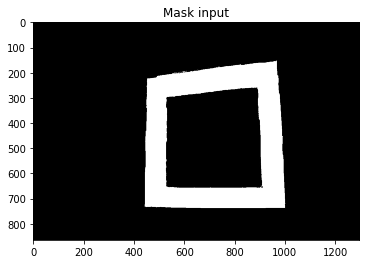

In [2]:
from matplotlib import pyplot as plt
import imutils
import numpy as np
import cv2

img = cv2.imread('images/mask.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur =  cv2.GaussianBlur(gray, (5, 5), 0)

#th1 = cv2.threshold(mask_gray,127,255,cv2.THRESH_BINARY)[1]
th1 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)[1]
#th1 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINAR_INV)[1]

result = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)
plt.imshow(result)
plt.title('Mask input')
plt.show()

## Shape and Corner Detection

### Refs
https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv


527 258 385 397 292


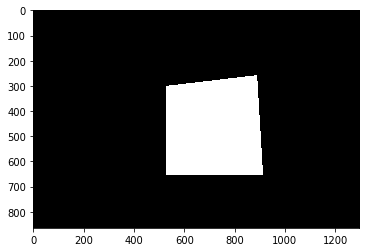

443 153 556 584 338


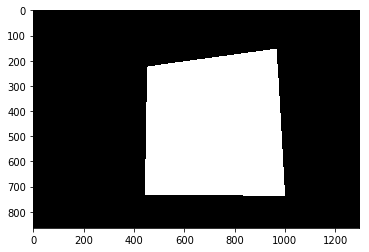

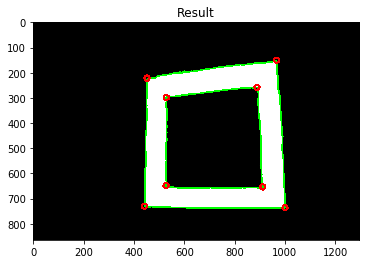

[{'area': 152845, 'centroid': (717, 467), 'corners': array([[647.49554, 431.49792],
       [887.677  , 258.6832 ],
       [528.3231 , 299.6661 ],
       [527.41296, 648.8678 ],
       [910.6342 , 653.7162 ]], dtype=float32)}, {'area': 324704, 'centroid': (721, 463), 'corners': array([[647.4954 , 431.49835],
       [965.011  , 151.82608],
       [451.8188 , 222.81879],
       [441.71982, 730.6512 ],
       [998.4417 , 736.4417 ]], dtype=float32)}]


In [3]:
img_result = img.copy()

results = []

_min_pixels_size = 10

#cnts = cv2.findContours(th1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cv2.findContours(th1.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

for c in cnts:
    
    # Perform shape approximation
    epsilon = 0.1*cv2.arcLength(c,True) #0.04
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    # 4 sides?
    if (len(approx)==4):
        
        cv2.drawContours(img_result, [c], -1, (0, 255, 0), 5)
        
        (x, y, w, h) = cv2.boundingRect(approx)
        if (w>=_min_pixels_size and h>=_min_pixels_size):
            
            result = {}
            
            print(x, y, w, h, len(c))
            
            area = w * h
            result['area'] = area
            
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            
            result['centroid'] = (cx, cy)
            
            # create mask for edge detection
            gray = np.float32(th1)
            mask = np.zeros(gray.shape, dtype="uint8")
            cv2.fillPoly(mask, [approx], (255,255,255))
            
            dst = cv2.cornerHarris(mask,5,3,0.04)
            ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
            dst = np.uint8(dst)
            ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
            corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
            
            result['corners'] = corners
            
            results.append(result)
            
            for i in range(1, len(corners)):
                #print(corners[i,0])
                cv2.circle(img_result, (int(corners[i,0]), int(corners[i,1])), 10, (255,0,0), 7)

            #print(corners)
            
            plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))
            plt.show()
            
            
        

plt.imshow(img_result)
plt.title('Result')
plt.show()

print(results)

[[887.677   258.6832 ]
 [528.3231  299.6661 ]
 [527.41296 648.8678 ]
 [910.6342  653.7162 ]]


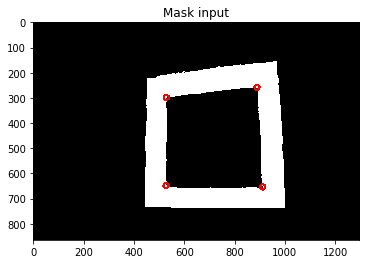

In [4]:
def draw_points_array(image, points):
    for i in range(0, len(points)):
        cv2.circle(image, (int(points[i,0]), int(points[i,1])), 10, (255,0,0), 7)
    return image

def get_inner_area_corners_from_results(results):
    assert len(results)==2, 'I got more than 2 shapes for a gate...'
    inner_shape = None
    if results[0]['area'] > results[1]['area']:
        inner_shape = results[1]
    else:
        inner_shape = results[0]
    corners = inner_shape['corners'][1:]
    return corners

corners = get_inner_area_corners_from_results(results)
print(corners)

img_solution = draw_points_array(img.copy(), corners)

plt.imshow(img_solution)
plt.title('Mask input')
plt.show()

## Test class

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6760.png
[{'area': 27816, 'centroid': (252, 239), 'corners': array([[255.50099, 255.50522],
       [209.57875, 110.37147],
       [307.47437, 151.87132],
       [197.32841, 345.67004],
       [309.7116 , 350.2311 ]], dtype=float32)}, {'area': 64944, 'centroid': (248, 239), 'corners': array([[255.50269 , 255.50252 ],
       [173.75769 ,  33.7836  ],
       [335.787   , 115.581985],
       [341.9167  , 397.1633  ],
       [164.34886 , 403.2802  ]], dtype=float32)}]


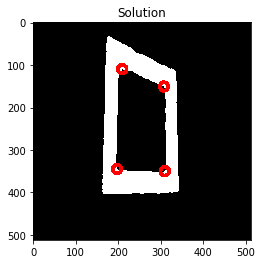

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1883.png
[{'area': 6552, 'centroid': (265, 278), 'corners': array([[255.49683, 255.49402],
       [287.20352, 214.28639],
       [240.87442, 225.45084],
       [289.6716 , 337.67004],
       [241.34929, 338.2809 ]], dtype=float32)}, {'area': 14931, 'centroid': (264, 278), 'corners': array([[255.49684, 255.49431],
       [302.18124, 179.81876],
       [225.22597, 203.4514 ],
       [224.83705, 362.91663],
       [301.96866, 370.20892]], dtype=float32)}]


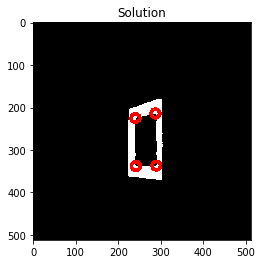

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3057.png
[]
file has only one shape


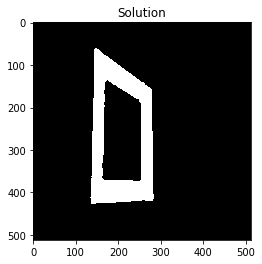

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0578.png
[{'area': 64800, 'centroid': (261, 250), 'corners': array([[255.49863, 255.50137],
       [361.67004,  90.32843],
       [163.09642, 100.82894],
       [159.49605, 397.40942],
       [355.48978, 415.21112]], dtype=float32)}, {'area': 140238, 'centroid': (266, 250), 'corners': array([[255.49738 , 255.50026 ],
       [410.48035 ,  13.608956],
       [118.828835,  37.09675 ],
       [115.608894, 458.48044 ],
       [406.23044 , 490.71176 ]], dtype=float32)}]


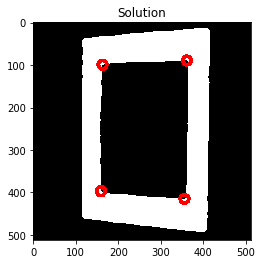

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8231.png
[]
file has only one shape


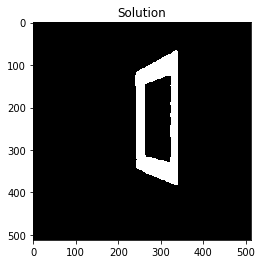

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5530.png
[{'area': 11376, 'centroid': (247, 267), 'corners': array([[255.50235, 255.49687],
       [210.75768, 194.78363],
       [285.07468, 204.84045],
       [285.87326, 333.31024],
       [208.81877, 338.18124]], dtype=float32)}, {'area': 25440, 'centroid': (247, 268), 'corners': array([[255.50209, 255.49673],
       [191.34937, 159.71901],
       [307.67154, 177.32993],
       [307.1628 , 364.9167 ],
       [188.81879, 372.1812 ]], dtype=float32)}]


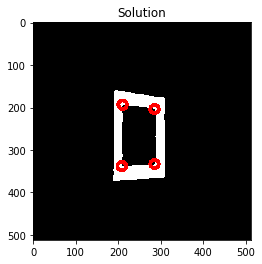

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8635 (1).png
[]
file has only one shape


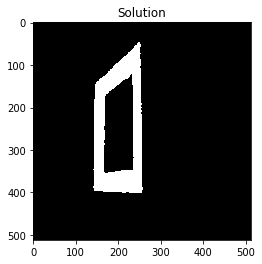

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4599.png
[{'area': 24075, 'centroid': (223, 247), 'corners': array([[255.50859, 255.50224],
       [270.1137 , 135.31744],
       [169.65945, 156.49141],
       [172.28836, 345.23105],
       [274.44153, 359.44183]], dtype=float32)}, {'area': 54756, 'centroid': (224, 248), 'corners': array([[255.507  , 255.50198],
       [297.70758,  77.44192],
       [141.08969, 118.813  ],
       [143.51016, 385.21118],
       [301.1708 , 417.88702]], dtype=float32)}]


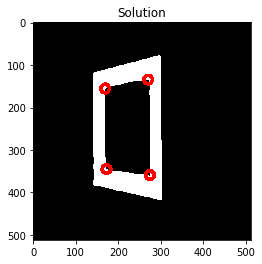

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7351.png
[{'area': 21280, 'centroid': (263, 265), 'corners': array([[255.49722, 255.49815],
       [310.21448, 166.31561],
       [209.08954, 187.81296],
       [317.91046, 351.18704],
       [213.42178, 354.43024]], dtype=float32)}, {'area': 44043, 'centroid': (264, 266), 'corners': array([[255.49698, 255.49821],
       [336.18124, 119.81877],
       [185.55995, 155.5473 ],
       [184.84926, 391.90475],
       [343.56567, 396.3093 ]], dtype=float32)}]


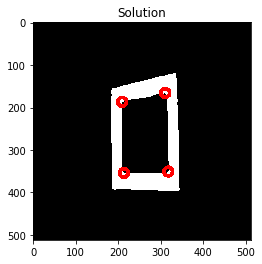

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3390.png
[{'area': 16695, 'centroid': (272, 272), 'corners': array([[255.49525, 255.49533],
       [223.57593, 193.57593],
       [324.42407, 196.57593],
       [222.08336, 350.16284],
       [321.43994, 350.4527 ]], dtype=float32)}, {'area': 35880, 'centroid': (273, 273), 'corners': array([[255.49506, 255.49478],
       [199.29301, 157.86874],
       [351.87573, 163.85213],
       [198.35408, 388.2857 ],
       [346.42416, 388.42416]], dtype=float32)}]


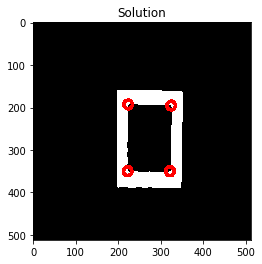

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8206.png
[{'area': 4488, 'centroid': (289, 238), 'corners': array([[255.48976, 255.50493],
       [309.2036 , 187.28633],
       [268.25   , 198.4375 ],
       [309.6716 , 287.67004],
       [272.51968, 287.39102]], dtype=float32)}, {'area': 10117, 'centroid': (289, 239), 'corners': array([[255.48984, 255.50485],
       [320.64578, 162.71425],
       [255.44148, 176.29341],
       [256.5759 , 305.42407],
       [320.7076 , 315.55804]], dtype=float32)}]


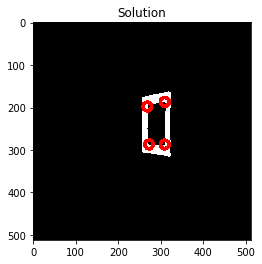

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7752 (1).png
[{'area': 6890, 'centroid': (259, 319), 'corners': array([[255.49913, 255.48218],
       [228.81877, 266.8188 ],
       [290.14154, 273.31396],
       [228.30196, 371.54648],
       [289.67004, 369.6716 ]], dtype=float32)}, {'area': 14288, 'centroid': (259, 320), 'corners': array([[255.49876, 255.48207],
       [213.78357, 243.75772],
       [306.1812 , 250.81879],
       [212.46948, 394.77246],
       [306.1628 , 393.9167 ]], dtype=float32)}]


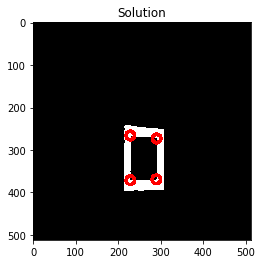

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6980.png
[]
file has only one shape


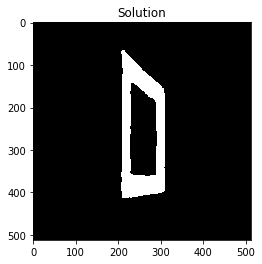

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1917.png
[{'area': 12844, 'centroid': (215, 267), 'corners': array([[255.51067, 255.49759],
       [249.11359, 178.31746],
       [178.84218, 199.56667],
       [251.16295, 346.91696],
       [178.32997, 344.67157]], dtype=float32)}, {'area': 29325, 'centroid': (215, 267), 'corners': array([[255.51057, 255.49773],
       [267.20465, 132.37582],
       [160.13579, 168.8127 ],
       [157.55998, 379.45273],
       [269.6571 , 389.49707]], dtype=float32)}]


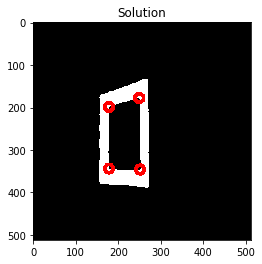

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7250 (1).png
[{'area': 7276, 'centroid': (235, 318), 'corners': array([[255.50557, 255.48262],
       [266.23834, 265.3054 ],
       [203.08954, 269.81296],
       [266.7076 , 370.55807],
       [202.32997, 369.67157]], dtype=float32)}, {'area': 15190, 'centroid': (234, 320), 'corners': array([[255.5059 , 255.48221],
       [282.1812 , 241.81879],
       [186.08333, 246.83719],
       [283.16296, 395.91696],
       [185.48692, 396.28394]], dtype=float32)}]


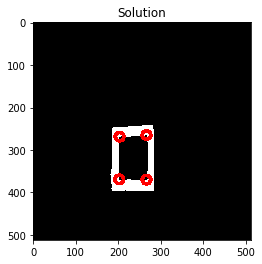

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8221.png
[{'area': 11644, 'centroid': (259, 234), 'corners': array([[255.49815, 255.50671],
       [291.2383 , 149.3054 ],
       [225.04941, 165.54509],
       [228.5197 , 309.39102],
       [292.42407, 314.42407]], dtype=float32)}, {'area': 26565, 'centroid': (260, 235), 'corners': array([[255.49776, 255.506  ],
       [304.45456, 107.40909],
       [206.53789, 138.5383 ],
       [206.08333, 337.1628 ],
       [310.31186, 359.55515]], dtype=float32)}]


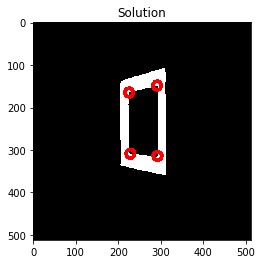

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9501.png
[{'area': 10168, 'centroid': (324, 306), 'corners': array([[255.48097, 255.48613],
       [286.78168, 245.78166],
       [363.87576, 249.85213],
       [285.08337, 363.16287],
       [362.18704, 365.91046]], dtype=float32)}, {'area': 20592, 'centroid': (326, 307), 'corners': array([[255.4807 , 255.48586],
       [269.32993, 220.32845],
       [383.16284, 221.08292],
       [268.2925 , 393.5581 ],
       [380.89893, 396.21277]], dtype=float32)}]


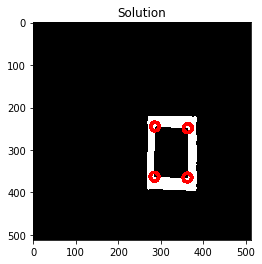

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8085 (1).png
[]
file has only one shape


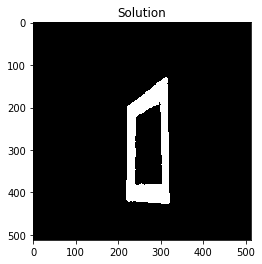

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4758.png
[]
file has only one shape


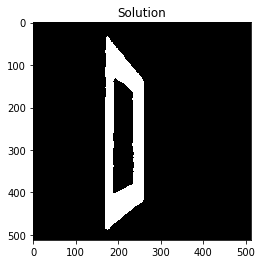

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0023.png
[{'area': 20068, 'centroid': (219, 255), 'corners': array([[255.50989, 255.5    ],
       [165.81296, 170.08954],
       [274.47845, 172.47343],
       [162.78166, 340.21832],
       [275.67004, 339.6716 ]], dtype=float32)}, {'area': 41416, 'centroid': (219, 256), 'corners': array([[255.50983, 255.49965],
       [139.34889, 132.71976],
       [301.1812 , 132.81879],
       [135.87149, 380.28387],
       [302.66214, 380.24765]], dtype=float32)}]


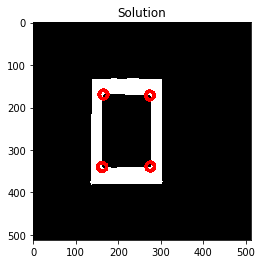

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7475 (1).png
[]
file has only one shape


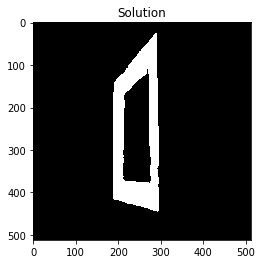

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6232.png
[{'area': 5568, 'centroid': (241, 307), 'corners': array([[254.07199, 255.0958 ],
       [222.16599, 247.56844],
       [265.42972, 263.17648],
       [221.16498, 363.43112],
       [258.6111 , 361.6111 ]], dtype=float32)}, {'area': 12483, 'centroid': (242, 308), 'corners': array([[254.072  , 255.0958 ],
       [210.35423, 219.71423],
       [277.87604, 238.85216],
       [279.4241 , 384.42407],
       [205.46962, 390.77255]], dtype=float32)}]


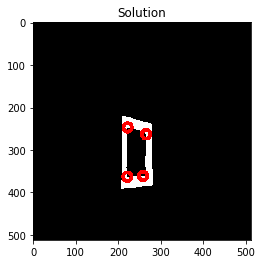

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1680.png
[{'area': 6630, 'centroid': (244, 298), 'corners': array([[255.50275, 255.4884 ],
       [266.2443 , 231.31879],
       [219.57254, 244.63141],
       [266.6214 , 362.3069 ],
       [220.81296, 358.91046]], dtype=float32)}, {'area': 15405, 'centroid': (243, 299), 'corners': array([[255.5029 , 255.48834],
       [280.44473, 197.19005],
       [203.4472 , 221.684  ],
       [203.8372 , 386.9167 ],
       [279.23788, 395.69452]], dtype=float32)}]


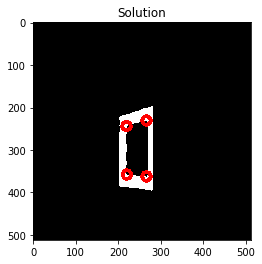

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3068.png
[{'area': 11832, 'centroid': (216, 296), 'corners': array([[255.51057, 255.48804],
       [187.80762, 204.55615],
       [250.71861, 240.55042],
       [185.32841, 374.67004],
       [247.18704, 375.91046]], dtype=float32)}, {'area': 27352, 'centroid': (216, 297), 'corners': array([[255.51083, 255.48781],
       [169.34995, 152.64156],
       [267.32483, 205.46109],
       [269.54523, 413.3481 ],
       [166.38889, 414.6111 ]], dtype=float32)}]


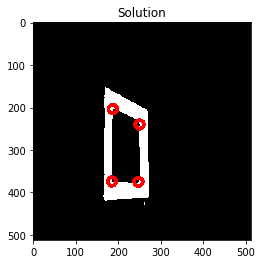

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8333 (1).png
[{'area': 17955, 'centroid': (192, 286), 'corners': array([[255.51851, 255.49199],
       [144.57596, 198.57596],
       [243.45273, 215.55998],
       [141.32841, 365.67004],
       [241.71161, 367.23117]], dtype=float32)}, {'area': 39370, 'centroid': (191, 289), 'corners': array([[255.5188 , 255.49196],
       [120.81877, 153.81877],
       [267.1812 , 183.81877],
       [115.16494, 409.43112],
       [269.1628 , 405.9167 ]], dtype=float32)}]


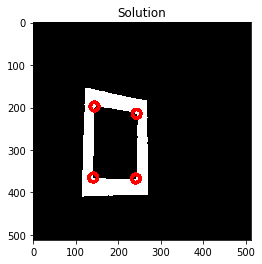

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0107.png
[{'area': 64165, 'centroid': (304, 221), 'corners': array([[255.48628 , 255.51073 ],
       [398.51312 ,  58.716072],
       [205.08954 ,  81.81295 ],
       [407.05328 , 366.52185 ],
       [202.32997 , 368.67157 ]], dtype=float32)}, {'area': 134368, 'centroid': (308, 224), 'corners': array([[255.49318  , 255.49995  ],
       [425.8188   ,   1.1812041],
       [162.08366  ,  21.836525 ],
       [156.71982  , 432.65115  ],
       [461.67007  , 440.67154  ]], dtype=float32)}]


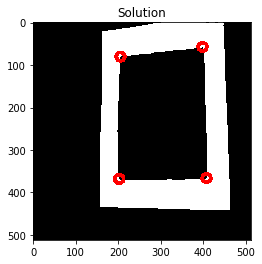

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6766.png
[{'area': 6324, 'centroid': (279, 278), 'corners': array([[255.49344, 255.49417],
       [260.66528, 212.9524 ],
       [304.391  , 229.51971],
       [256.08966, 333.187  ],
       [303.47604, 334.476  ]], dtype=float32)}, {'area': 14220, 'centroid': (279, 278), 'corners': array([[255.49393, 255.49414],
       [240.45374, 184.30212],
       [318.0826 , 206.91739],
       [240.81879, 363.1812 ],
       [318.54523, 363.3481 ]], dtype=float32)}]


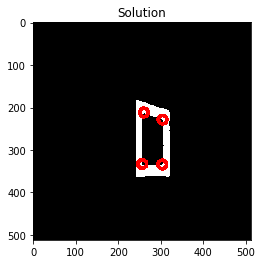

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7990 (1).png
[{'area': 12816, 'centroid': (288, 338), 'corners': array([[255.4906 , 255.4771 ],
       [325.9047 , 265.39844],
       [246.66469, 277.73013],
       [332.6716 , 405.67004],
       [248.78273, 407.59286]], dtype=float32)}, {'area': 25830, 'centroid': (288, 340), 'corners': array([[255.4908 , 255.47667],
       [347.1812 , 233.8188 ],
       [226.22626, 251.45123],
       [228.77177, 439.41388],
       [351.56558, 438.30923]], dtype=float32)}]


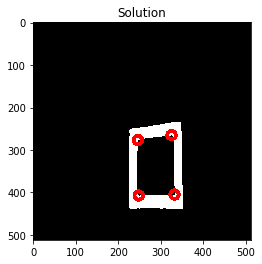

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3510.png
[{'area': 2268, 'centroid': (259, 309), 'corners': array([[255.49876, 255.48503],
       [242.08327, 280.83676],
       [276.91663, 280.83713],
       [244.85248, 339.8765 ],
       [275.68604, 339.578  ]], dtype=float32)}, {'area': 4876, 'centroid': (261, 310), 'corners': array([[255.49849, 255.48495],
       [235.57584, 264.57584],
       [286.67154, 264.32993],
       [287.16   , 353.91925],
       [233.78886, 355.48984]], dtype=float32)}]


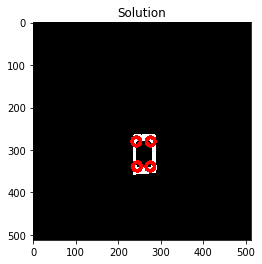

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4866.png
[{'area': 26196, 'centroid': (357, 307), 'corners': array([[255.4721 , 255.48611],
       [300.63147, 194.57246],
       [413.9933 , 213.92313],
       [416.46176, 407.46207],
       [299.46988, 416.36252]], dtype=float32)}, {'area': 60573, 'centroid': (357, 310), 'corners': array([[255.47151, 255.48454],
       [268.32996, 144.32841],
       [444.65112, 167.71979],
       [452.1628 , 453.9167 ],
       [269.55322, 475.8088 ]], dtype=float32)}]


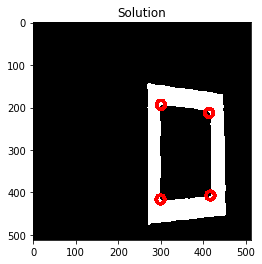

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2524.png
[]
file has only one shape


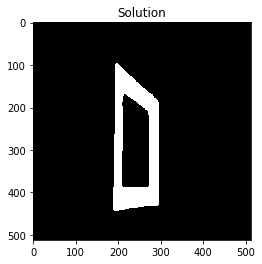

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1636.png
[{'area': 14630, 'centroid': (245, 306), 'corners': array([[255.50261, 255.48592],
       [292.42407, 229.57593],
       [200.85248, 234.1235 ],
       [198.08919, 378.1869 ],
       [291.20264, 383.41727]], dtype=float32)}, {'area': 31970, 'centroid': (245, 307), 'corners': array([[255.50282, 255.48611],
       [311.83426, 189.56856],
       [176.32845, 203.32994],
       [174.09676, 412.17123],
       [313.24228, 421.21643]], dtype=float32)}]


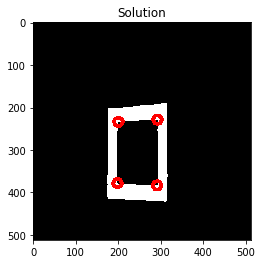

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9632.png
[{'area': 46102, 'centroid': (247, 270), 'corners': array([[255.50186, 255.4967 ],
       [325.1701 , 140.32788],
       [169.26736, 143.19284],
       [338.14752, 388.8765 ],
       [164.27162, 398.39447]], dtype=float32)}, {'area': 100337, 'centroid': (248, 274), 'corners': array([[255.50192 , 255.49602 ],
       [363.67007 ,  87.328445],
       [127.818794,  87.818794],
       [385.67163 , 446.66998 ],
       [116.818794, 459.1812  ]], dtype=float32)}]


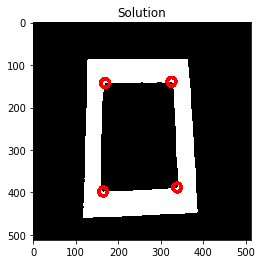

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9748.png
[{'area': 12285, 'centroid': (254, 284), 'corners': array([[255.50034, 255.49109],
       [290.18704, 219.08954],
       [211.74144, 229.3273 ],
       [299.91046, 339.18704],
       [218.81296, 350.91046]], dtype=float32)}, {'area': 26334, 'centroid': (255, 285), 'corners': array([[255.49986, 255.4916 ],
       [309.24234, 186.78363],
       [191.32845, 203.32994],
       [322.9167 , 366.1628 ],
       [200.34291, 383.65454]], dtype=float32)}]


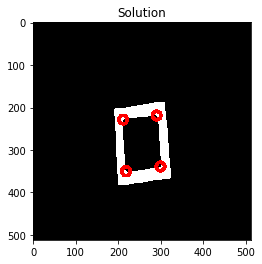

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1891.png
[{'area': 3354, 'centroid': (298, 293), 'corners': array([[255.48776, 255.48949],
       [315.2423 , 250.78363],
       [279.87448, 257.4508 ],
       [316.18124, 334.18124],
       [280.8609 , 333.9215 ]], dtype=float32)}, {'area': 7620, 'centroid': (296, 295), 'corners': array([[255.48825, 255.48969],
       [322.83392, 227.56836],
       [267.6263 , 240.62688],
       [266.26602, 352.753  ],
       [324.64594, 356.2857 ]], dtype=float32)}]


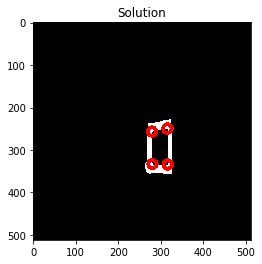

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4538.png
[{'area': 33640, 'centroid': (265, 249), 'corners': array([[255.4971 , 255.50214],
       [334.18124, 131.81877],
       [194.08954, 143.81296],
       [196.3493 , 359.28094],
       [335.6716 , 363.67004]], dtype=float32)}, {'area': 73217, 'centroid': (268, 248), 'corners': array([[255.49677, 255.50214],
       [369.67004,  75.32843],
       [160.08951,  99.81297],
       [163.8372 , 403.9167 ],
       [368.72366, 423.18594]], dtype=float32)}]


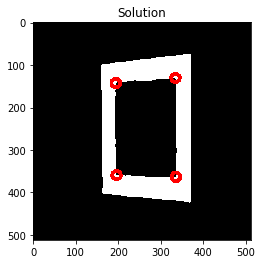

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4867.png
[{'area': 29591, 'centroid': (376, 304), 'corners': array([[255.46666, 255.48688],
       [312.83716, 187.08336],
       [437.56183, 199.66011],
       [438.3933 , 411.2698 ],
       [313.76886, 418.7116 ]], dtype=float32)}, {'area': 67965, 'centroid': (375, 306), 'corners': array([[255.46645, 255.48653],
       [278.7143 , 134.35416],
       [468.5491 , 155.22673],
       [478.67007, 457.67154],
       [284.38846, 480.04642]], dtype=float32)}]


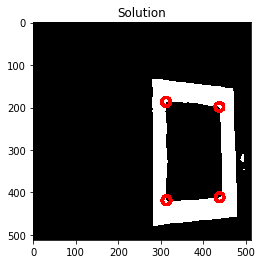

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7024 (1).png
[{'area': 18511, 'centroid': (226, 288), 'corners': array([[255.50854, 255.49129],
       [179.8609 , 200.0785 ],
       [279.13412, 216.5446 ],
       [175.81313, 370.91083],
       [276.43994, 370.4527 ]], dtype=float32)}, {'area': 39624, 'centroid': (225, 291), 'corners': array([[255.50914, 255.49129],
       [153.75768, 157.78363],
       [303.18118, 181.81882],
       [303.18704, 408.9105 ],
       [147.81879, 412.1812 ]], dtype=float32)}]


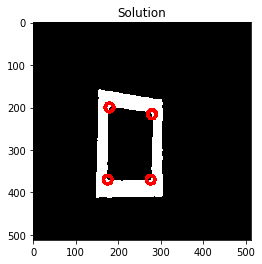

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7784 (1).png
[{'area': 7560, 'centroid': (248, 336), 'corners': array([[255.50206, 255.47772],
       [218.29329, 281.44153],
       [281.41602, 289.6911 ],
       [213.81879, 387.1812 ],
       [280.9164 , 387.16348]], dtype=float32)}, {'area': 15857, 'centroid': (249, 337), 'corners': array([[255.50186, 255.47748],
       [202.8075 , 256.55606],
       [298.19354, 265.09106],
       [198.32845, 413.67007],
       [298.67007, 413.67154]], dtype=float32)}]


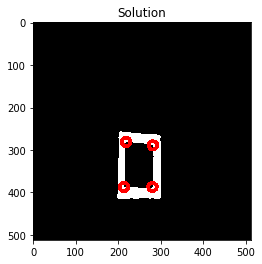

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7183 (1).png
[{'area': 7350, 'centroid': (257, 307), 'corners': array([[255.49945, 255.48578],
       [225.3493 , 255.71906],
       [290.29163, 257.47925],
       [224.32841, 357.67004],
       [290.16287, 357.91663]], dtype=float32)}, {'area': 15606, 'centroid': (258, 308), 'corners': array([[255.49924, 255.4855 ],
       [209.35722, 231.60808],
       [307.39774, 232.7516 ],
       [207.88618, 384.68283],
       [308.91696, 384.16296]], dtype=float32)}]


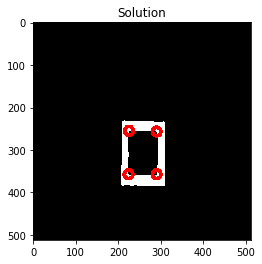

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8990.png
[]
file has only one shape


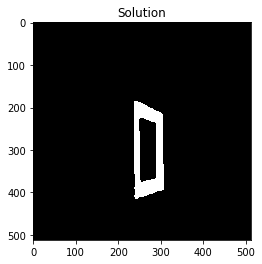

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7640 (1).png
[{'area': 16669, 'centroid': (263, 318), 'corners': array([[255.49908, 255.48273],
       [229.49219, 204.61078],
       [300.47433, 241.87123],
       [224.71906, 410.6507 ],
       [300.28015, 411.65115]], dtype=float32)}]
file has only one shape


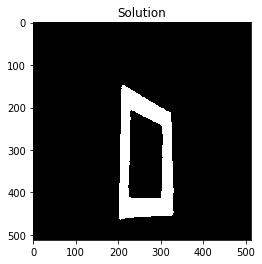

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7499.png
[{'area': 6771, 'centroid': (258, 234), 'corners': array([[255.4998 , 255.5064 ],
       [232.32996, 179.32843],
       [286.16324, 185.08318],
       [229.31802, 285.78986],
       [283.91083, 285.18683]], dtype=float32)}, {'area': 14355, 'centroid': (258, 235), 'corners': array([[255.49966, 255.50595],
       [219.29327, 150.44156],
       [300.30524, 166.25757],
       [297.16284, 312.71103],
       [217.56728, 318.60016]], dtype=float32)}]


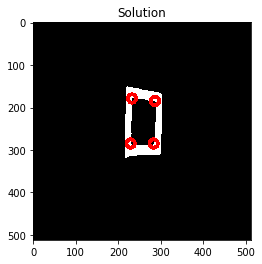

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6217.png
[{'area': 8640, 'centroid': (266, 307), 'corners': array([[255.49747, 255.48582],
       [241.79637, 232.28633],
       [294.99448, 250.56693],
       [237.75641, 374.72983],
       [291.6507 , 374.28094]], dtype=float32)}, {'area': 19313, 'centroid': (266, 310), 'corners': array([[255.49754, 255.48582],
       [225.69502, 195.32889],
       [310.28003, 224.34874],
       [312.67007, 404.67154],
       [223.32845, 413.67007]], dtype=float32)}]


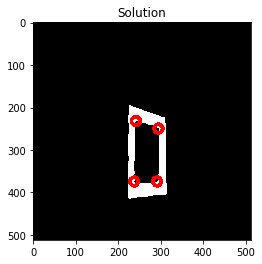

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7315 (1).png
[{'area': 10720, 'centroid': (214, 307), 'corners': array([[255.51135, 255.48578],
       [252.7725 , 239.46953],
       [175.609  , 248.5197 ],
       [250.48991, 373.21115],
       [175.63142, 371.42746]], dtype=float32)}, {'area': 22116, 'centroid': (213, 308), 'corners': array([[255.51157, 255.48549],
       [269.96887, 209.79106],
       [157.08951, 221.81297],
       [155.69006, 399.87378],
       [269.41205, 404.56805]], dtype=float32)}]


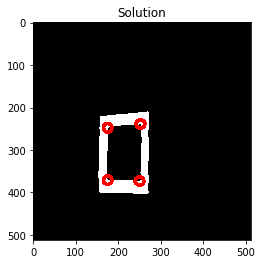

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3308.png
[]
file has only one shape


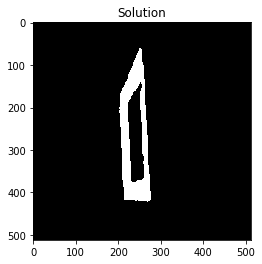

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9129.png
[{'area': 32619, 'centroid': (212, 253), 'corners': array([[255.51297, 255.5019 ],
       [161.47801, 119.5278 ],
       [276.91046, 159.81296],
       [148.68468, 367.64136],
       [270.21835, 365.21832]], dtype=float32)}, {'area': 75845, 'centroid': (208, 253), 'corners': array([[255.51355 , 255.50194 ],
       [130.55244 ,  45.269413],
       [307.578   , 124.313995],
       [302.9169  , 411.16315 ],
       [111.818794, 431.1812  ]], dtype=float32)}]


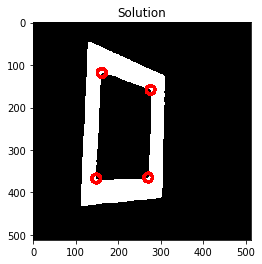

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1678.png
[{'area': 9145, 'centroid': (238, 297), 'corners': array([[255.5042 , 255.48868],
       [265.60223, 217.32916],
       [210.80821, 233.29523],
       [208.67325, 366.46   ],
       [266.33185, 371.42572]], dtype=float32)}, {'area': 21855, 'centroid': (238, 298), 'corners': array([[255.50423, 255.48795],
       [281.7725 , 175.46954],
       [191.5473 , 208.56001],
       [192.83716, 400.71103],
       [282.15656, 412.67752]], dtype=float32)}]


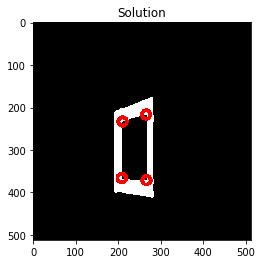

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1812.png
[{'area': 4028, 'centroid': (304, 291), 'corners': array([[255.48593, 255.49042],
       [321.66214, 236.7523 ],
       [288.4382 , 243.66002],
       [284.32993, 339.67154],
       [322.89987, 343.4344 ]], dtype=float32)}]
file has only one shape


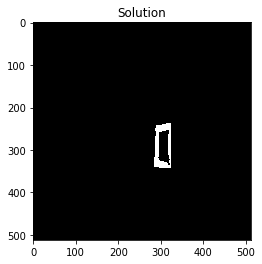

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4860.png
[{'area': 14580, 'centroid': (285, 316), 'corners': array([[255.49207, 255.48347],
       [244.3298 , 233.32858],
       [329.17526, 247.14014],
       [243.81322, 396.9108 ],
       [328.21835, 391.21832]], dtype=float32)}, {'area': 32472, 'centroid': (285, 318), 'corners': array([[255.49146, 255.48322],
       [224.1663 , 192.26077],
       [351.1812 , 212.81879],
       [353.1628 , 424.9167 ],
       [221.22614, 439.5296 ]], dtype=float32)}]


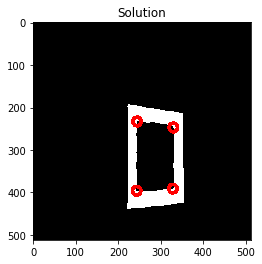

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6768.png
[{'area': 4830, 'centroid': (265, 281), 'corners': array([[255.49707, 255.4927 ],
       [250.92157, 227.26033],
       [287.75   , 243.4375 ],
       [243.5116 , 322.1725 ],
       [283.17126, 329.90347]], dtype=float32)}, {'area': 10710, 'centroid': (266, 281), 'corners': array([[255.4975 , 255.4934 ],
       [234.39749, 201.3291 ],
       [299.9167 , 216.8372 ],
       [230.46886, 351.48373],
       [298.0508 , 354.5646 ]], dtype=float32)}]


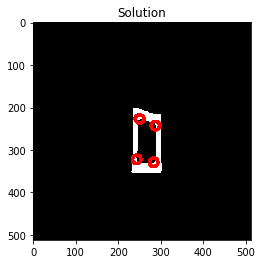

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9201.png
[]
file has only one shape


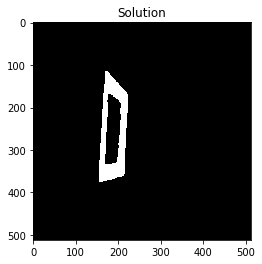

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9834.png
[{'area': 34578, 'centroid': (226, 225), 'corners': array([[255.5079 , 255.50838],
       [155.83714, 114.08336],
       [300.67145, 114.32983],
       [151.52155, 334.52658],
       [300.57462, 335.6897 ]], dtype=float32)}, {'area': 71940, 'centroid': (227, 226), 'corners': array([[255.50777 , 255.50824 ],
       [121.818794,  62.818794],
       [335.28018 ,  64.348854],
       [115.837036, 385.91696 ],
       [336.66998 , 388.67163 ]], dtype=float32)}]


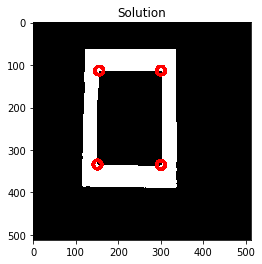

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9728.png
[{'area': 10584, 'centroid': (256, 202), 'corners': array([[255.49959, 255.51459],
       [219.28839, 140.76883],
       [297.28094, 146.3493 ],
       [216.08954, 258.18704],
       [294.18124, 264.18124]], dtype=float32)}, {'area': 21480, 'centroid': (256, 202), 'corners': array([[255.49973 , 255.51442 ],
       [203.22581 , 112.46735 ],
       [314.83505 , 117.568886],
       [196.81879 , 287.1812  ],
       [312.24228 , 292.21646 ]], dtype=float32)}]


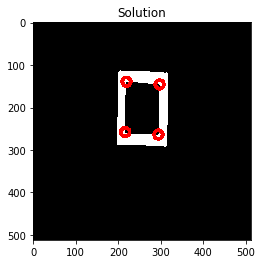

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8454 (1).png
[{'area': 17600, 'centroid': (145, 295), 'corners': array([[255.53015, 255.48894],
       [ 97.26066, 217.83984],
       [198.18684, 216.08917],
       [ 92.34876, 375.28003],
       [193.71161, 374.23117]], dtype=float32)}, {'area': 36729, 'centroid': (144, 298), 'corners': array([[255.53023, 255.4886 ],
       [ 72.32994, 182.32845],
       [221.65114, 181.71979],
       [ 64.08332, 412.1628 ],
       [223.18121, 412.1812 ]], dtype=float32)}]


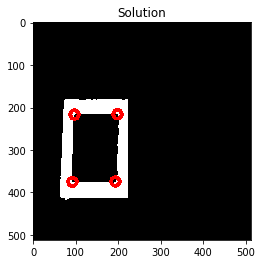

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0929.png
[{'area': 55084, 'centroid': (258, 315), 'corners': array([[255.49937, 255.48372],
       [347.70682, 166.86876],
       [167.12634, 174.68999],
       [164.43768, 456.03455],
       [350.91663, 460.16293]], dtype=float32)}, {'area': 113702, 'centroid': (260, 311), 'corners': array([[255.4907 , 255.49373],
       [393.91672, 102.83671],
       [125.07851, 118.86089],
       [393.8605 , 510.37476],
       [225.66667, 510.33334]], dtype=float32)}]


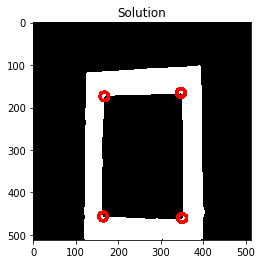

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3882.png
[]
file has only one shape


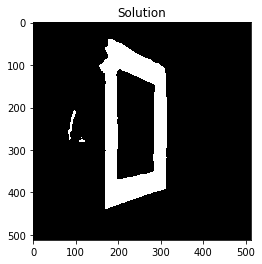

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0103.png
[{'area': 13020, 'centroid': (352, 281), 'corners': array([[255.47298, 255.49318],
       [393.18707, 211.08957],
       [308.53778, 218.5384 ],
       [397.18677, 346.9108 ],
       [309.10953, 347.61478]], dtype=float32)}, {'area': 27675, 'centroid': (353, 282), 'corners': array([[255.47269, 255.49303],
       [414.20282, 175.2865 ],
       [286.8188 , 191.81879],
       [421.1812 , 380.1812 ],
       [288.87775, 380.28235]], dtype=float32)}]


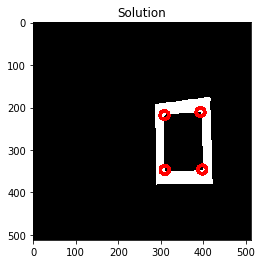

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6738.png
[]
file has only one shape


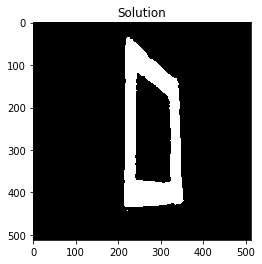

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0520.png
[{'area': 20709, 'centroid': (267, 228), 'corners': array([[255.49663, 255.50742],
       [215.10106, 139.78726],
       [324.21835, 143.78165],
       [211.81313, 313.91083],
       [322.16287, 314.91663]], dtype=float32)}, {'area': 43264, 'centroid': (268, 228), 'corners': array([[255.49657, 255.50742],
       [185.4043 ,  99.62083],
       [354.28568, 106.35421],
       [185.79677, 354.7136 ],
       [348.3172 , 355.55228]], dtype=float32)}]


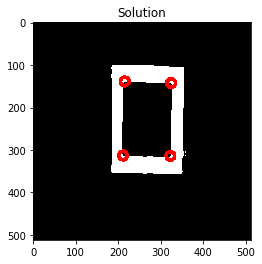

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6147.png
[]
file has only one shape


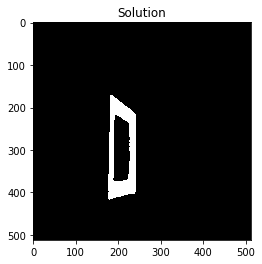

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3523.png
[{'area': 3139, 'centroid': (248, 315), 'corners': array([[255.50179, 255.48372],
       [229.22893, 278.195  ],
       [269.18124, 280.81876],
       [229.35852, 350.31494],
       [270.18124, 349.18124]], dtype=float32)}, {'area': 6890, 'centroid': (249, 315), 'corners': array([[255.50165, 255.48352],
       [216.58281, 263.7974 ],
       [282.21646, 263.75772],
       [281.9108 , 365.18677],
       [218.75772, 370.21643]], dtype=float32)}]


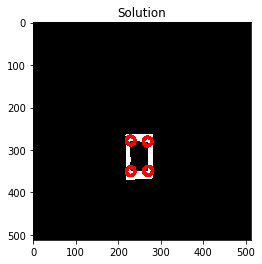

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5807.png
[{'area': 51216, 'centroid': (256, 224), 'corners': array([[255.49968 , 255.50908 ],
       [341.11584 ,  76.121   ],
       [170.60637 ,  96.308266],
       [166.78166 , 360.21832 ],
       [343.16348 , 365.9164  ]], dtype=float32)}, {'area': 112665, 'centroid': (261, 224), 'corners': array([[ 2.5550053e+02,  2.5550504e+02],
       [ 3.7333334e+02,  6.6666669e-01],
       [ 3.8098325e+02, -1.4091316e-01],
       [ 1.3032841e+02,  4.4329964e+01],
       [ 1.2957147e+02,  4.1229620e+02],
       [ 3.8718677e+02,  4.3591080e+02]], dtype=float32)}]


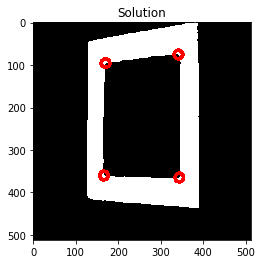

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0102.png
[{'area': 11659, 'centroid': (334, 285), 'corners': array([[255.478  , 255.4919 ],
       [370.39606, 218.38791],
       [293.31033, 225.42538],
       [378.31534, 346.64136],
       [293.04968, 347.4552 ]], dtype=float32)}, {'area': 24384, 'centroid': (336, 286), 'corners': array([[255.4775 , 255.49161],
       [395.0692 , 188.34285],
       [273.0833 , 201.8372 ],
       [274.8372 , 378.9167 ],
       [399.19354, 378.90894]], dtype=float32)}]


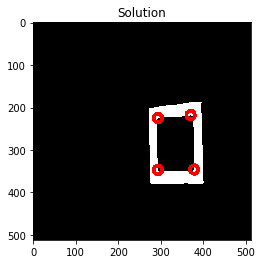

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1502.png
[{'area': 9180, 'centroid': (244, 304), 'corners': array([[255.5034 , 255.48672],
       [220.42181, 224.56975],
       [272.23114, 241.28839],
       [271.16293, 373.91666],
       [217.2924 , 378.55807]], dtype=float32)}, {'area': 21714, 'centroid': (244, 305), 'corners': array([[255.50345, 255.48666],
       [203.55246, 183.26941],
       [291.55283, 218.68405],
       [290.1479 , 404.87573],
       [197.66014, 411.3617 ]], dtype=float32)}]


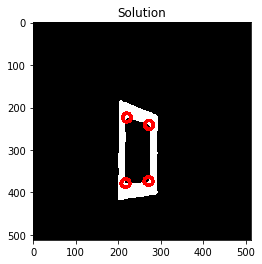

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8737 (1).png
[]
file has only one shape


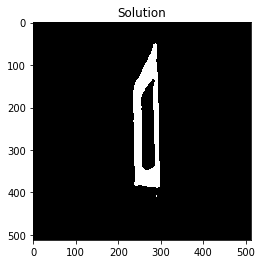

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6226.png
[{'area': 5148, 'centroid': (235, 321), 'corners': array([[255.50618, 255.48178],
       [217.32549, 261.8123 ],
       [256.3839 , 274.455  ],
       [214.71428, 376.6459 ],
       [253.91687, 375.16312]], dtype=float32)}, {'area': 11832, 'centroid': (235, 323), 'corners': array([[255.50629, 255.48145],
       [203.76987, 232.17366],
       [268.9103 , 253.813  ],
       [268.70673, 403.55853],
       [203.29317, 408.13126]], dtype=float32)}]


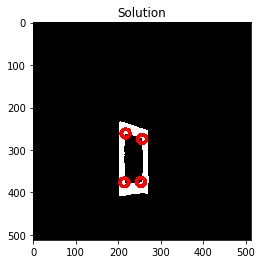

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2547.png
[{'area': 11136, 'centroid': (218, 307), 'corners': array([[251.6927 , 253.50034],
       [192.21532, 215.45679],
       [249.32513, 243.6356 ],
       [188.81877, 388.18124],
       [242.61111, 387.6111 ]], dtype=float32)}]
file has only one shape


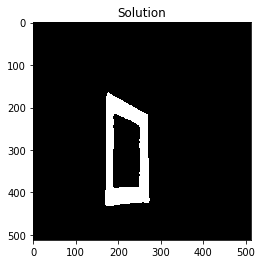

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7780 (1).png
[{'area': 9163, 'centroid': (266, 341), 'corners': array([[257.50006, 257.9991 ],
       [233.29329, 281.44153],
       [301.28387, 286.80722],
       [228.81877, 398.18124],
       [303.16287, 397.91663]], dtype=float32)}, {'area': 19203, 'centroid': (267, 343), 'corners': array([[257.50006, 257.9991 ],
       [213.4419 , 256.2925 ],
       [321.67154, 262.32993],
       [211.81879, 427.1812 ],
       [323.1628 , 426.9167 ]], dtype=float32)}]


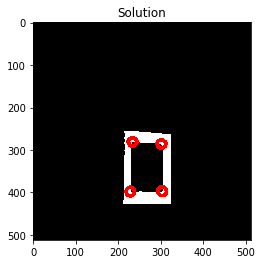

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4254.png
[{'area': 20384, 'centroid': (237, 234), 'corners': array([[255.50557, 255.5058 ],
       [204.5    , 124.99956],
       [286.391  , 147.51971],
       [281.81076, 324.72867],
       [196.39778, 346.67084]], dtype=float32)}, {'area': 47460, 'centroid': (236, 235), 'corners': array([[255.50726 , 255.50554 ],
       [170.22754 ,  66.46948 ],
       [309.2311  , 109.288376],
       [307.14752 , 363.8766  ],
       [173.18771 , 405.8384  ]], dtype=float32)}]


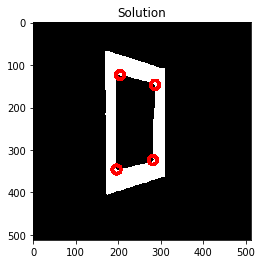

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4301.png
[{'area': 6200, 'centroid': (280, 232), 'corners': array([[255.49306, 255.5064 ],
       [252.81877, 182.81877],
       [310.87576, 187.85213],
       [251.8369 , 281.91687],
       [307.45273, 279.44006]], dtype=float32)}, {'area': 12615, 'centroid': (280, 232), 'corners': array([[255.493  , 255.50618],
       [239.8386 , 158.58037],
       [325.45544, 164.54451],
       [322.1479 , 302.87573],
       [239.75772, 306.21643]], dtype=float32)}]


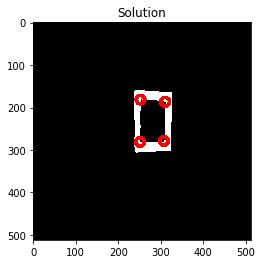

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7701.png
[{'area': 4944, 'centroid': (246, 292), 'corners': array([[255.50203, 255.48984],
       [266.21732, 240.40712],
       [223.25   , 252.4375 ],
       [268.16293, 341.91696],
       [225.56001, 340.4527 ]], dtype=float32)}, {'area': 10336, 'centroid': (246, 293), 'corners': array([[255.50221, 255.48972],
       [278.9708 , 215.7859 ],
       [212.1207 , 230.8842 ],
       [212.08311, 361.16315],
       [278.31165, 368.55493]], dtype=float32)}]


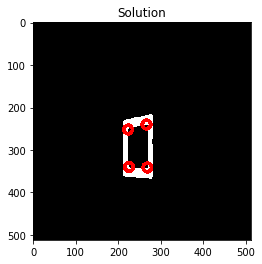

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8678.png
[{'area': 3990, 'centroid': (234, 276), 'corners': array([[255.50624, 255.49445],
       [216.32997, 229.3284 ],
       [255.75   , 238.4375 ],
       [216.76888, 321.7116 ],
       [252.71162, 320.23114]], dtype=float32)}, {'area': 9425, 'centroid': (236, 277), 'corners': array([[255.50565, 255.49432],
       [208.6062 , 203.44188],
       [268.91052, 215.81299],
       [265.16895, 342.67206],
       [205.38889, 347.6111 ]], dtype=float32)}]


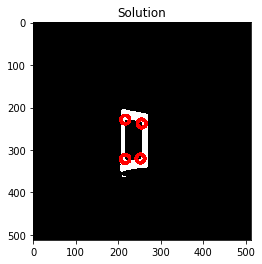

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4488.png
[{'area': 42405, 'centroid': (276, 240), 'corners': array([[255.49416 , 255.50398 ],
       [358.5492  , 111.87445 ],
       [195.80826 , 118.295395],
       [194.78166 , 364.21832 ],
       [356.56183 , 368.33987 ]], dtype=float32)}, {'area': 91611, 'centroid': (279, 240), 'corners': array([[255.49382 , 255.50398 ],
       [398.65112 ,  51.719757],
       [155.8188  ,  64.818794],
       [159.81297 , 417.9105  ],
       [397.42416 , 428.42416 ]], dtype=float32)}]


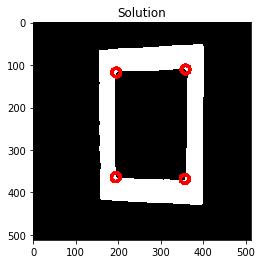

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9265.png
[{'area': 19488, 'centroid': (278, 253), 'corners': array([[255.49355, 255.50035],
       [225.0497 , 167.54478],
       [333.91046, 172.81296],
       [225.09535, 340.1512 ],
       [332.16293, 336.91663]], dtype=float32)}, {'area': 40800, 'centroid': (279, 254), 'corners': array([[255.4932 , 255.50035],
       [200.33002, 126.32837],
       [360.42416, 135.57584],
       [359.1628 , 374.9167 ],
       [203.47664, 382.9224 ]], dtype=float32)}]


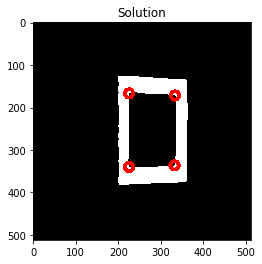

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2037.png
[{'area': 11172, 'centroid': (280, 265), 'corners': array([[255.49313, 255.49725],
       [240.83714, 199.08336],
       [320.87366, 204.68999],
       [241.78226, 330.59317],
       [320.16287, 328.91663]], dtype=float32)}, {'area': 23520, 'centroid': (281, 266), 'corners': array([[255.49306, 255.49712],
       [222.32994, 167.32845],
       [340.1812 , 175.81879],
       [221.08951, 359.187  ],
       [340.35696, 361.34634]], dtype=float32)}]


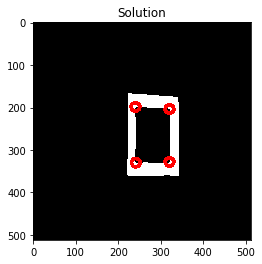

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9454.png
[{'area': 33227, 'centroid': (261, 277), 'corners': array([[255.49814, 255.49402],
       [196.62064, 164.4296 ],
       [333.91663, 170.83713],
       [187.8369 , 385.91687],
       [333.42407, 386.42407]], dtype=float32)}, {'area': 70196, 'centroid': (262, 279), 'corners': array([[255.49814 , 255.49368 ],
       [159.32994 , 117.328445],
       [367.1812  , 122.818794],
       [152.35722 , 436.3919  ],
       [369.91696 , 438.16296 ]], dtype=float32)}]


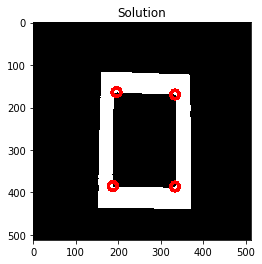

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8388.png
[{'area': 8775, 'centroid': (354, 266), 'corners': array([[255.47273, 255.49718],
       [320.2936 , 207.44136],
       [390.42407, 212.57593],
       [317.26065, 319.83334],
       [390.42407, 322.42407]], dtype=float32)}, {'area': 18083, 'centroid': (355, 267), 'corners': array([[255.4726 , 255.49657],
       [304.33002, 183.32837],
       [409.21646, 188.75772],
       [301.86874, 347.707  ],
       [405.31128, 350.25046]], dtype=float32)}]


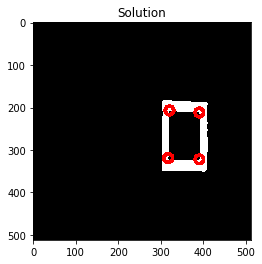

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6929.png
[{'area': 6943, 'centroid': (258, 242), 'corners': array([[255.49857, 255.5042 ],
       [282.60223, 174.32916],
       [234.87865, 189.84666],
       [282.18683, 302.91083],
       [232.25757, 301.30536]], dtype=float32)}, {'area': 15795, 'centroid': (258, 241), 'corners': array([[255.49901, 255.5044 ],
       [294.9486 , 137.25539],
       [217.17108, 170.29892],
       [296.4527 , 328.44   ],
       [216.28265, 332.2956 ]], dtype=float32)}]


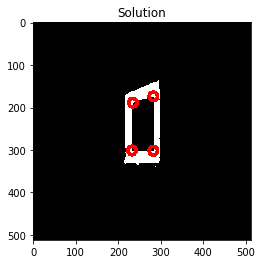

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5368.png
[]
file has only one shape


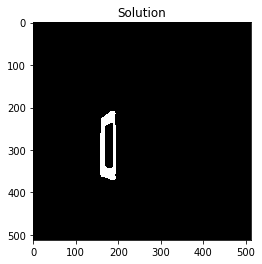

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7814.png
[]
file has only one shape


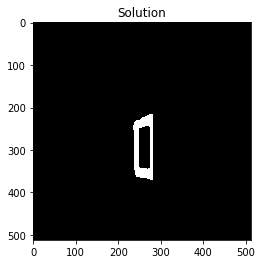

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8701.png
[{'area': 29835, 'centroid': (298, 275), 'corners': array([[255.48811, 255.49501],
       [235.83702, 163.08336],
       [364.44006, 175.54729],
       [363.71988, 376.31165],
       [232.71948, 382.65097]], dtype=float32)}, {'area': 63504, 'centroid': (298, 276), 'corners': array([[255.4881 , 255.49492],
       [204.8188 , 111.8188 ],
       [395.7307 , 132.74762],
       [396.67007, 422.67154],
       [200.81886, 436.18115]], dtype=float32)}]


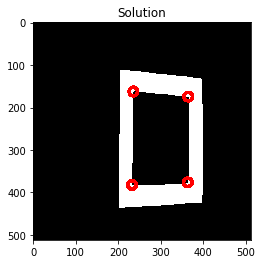

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1592.png
[{'area': 22755, 'centroid': (260, 298), 'corners': array([[255.49849, 255.48833],
       [208.02025, 204.35912],
       [319.1869 , 210.08919],
       [200.32841, 387.67004],
       [319.1479 , 387.87576]], dtype=float32)}, {'area': 47972, 'centroid': (261, 299), 'corners': array([[255.49828, 255.48811],
       [176.88611, 163.31715],
       [348.56558, 168.69078],
       [172.68835, 432.55493],
       [351.18115, 431.18115]], dtype=float32)}]


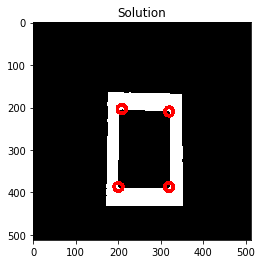

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4937.png
[{'area': 33033, 'centroid': (264, 325), 'corners': array([[255.49774, 255.48123],
       [197.2884 , 207.76875],
       [333.32486, 220.46109],
       [335.91083, 431.1869 ],
       [193.08954, 438.18704]], dtype=float32)}, {'area': 71740, 'centroid': (262, 327), 'corners': array([[255.4978 , 255.48088],
       [164.45477, 154.65189],
       [365.67154, 175.32993],
       [370.67007, 479.67154],
       [160.03133, 496.20892]], dtype=float32)}]


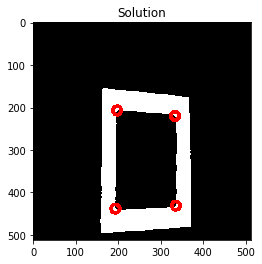

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7344.png
[{'area': 10560, 'centroid': (254, 263), 'corners': array([[255.50015, 255.49811],
       [290.18124, 196.81877],
       [215.61609, 207.45499],
       [292.21832, 324.21835],
       [217.78166, 325.21832]], dtype=float32)}, {'area': 21774, 'centroid': (254, 263), 'corners': array([[255.49991, 255.4985 ],
       [306.69806, 163.45352],
       [197.0895 , 182.81299],
       [199.8075 , 354.44394],
       [309.11423, 355.68295]], dtype=float32)}]


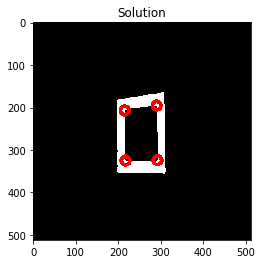

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3441.png
[{'area': 2688, 'centroid': (236, 341), 'corners': array([[255.50543, 255.47617],
       [213.40683, 313.78226],
       [255.67159, 310.32996],
       [216.57593, 372.42407],
       [254.46541, 373.50845]], dtype=float32)}, {'area': 6336, 'centroid': (236, 342), 'corners': array([[255.50543, 255.4763 ],
       [265.1928 , 293.0907 ],
       [203.69308, 296.37857],
       [266.61496, 386.89032],
       [207.42177, 391.4302 ]], dtype=float32)}]


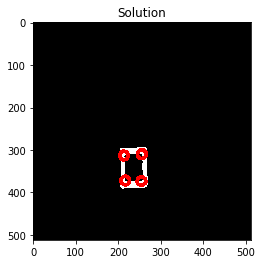

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8360 (1).png
[{'area': 6324, 'centroid': (236, 299), 'corners': array([[257.50003, 251.9995 ],
       [208.3021 , 247.45369],
       [265.65125, 252.71997],
       [206.49156, 346.46545],
       [265.9164 , 347.16348]], dtype=float32)}, {'area': 13261, 'centroid': (236, 301), 'corners': array([[257.50003, 251.9995 ],
       [193.32996, 225.32841],
       [282.4174 , 234.79736],
       [192.81879, 374.1812 ],
       [280.2282 , 373.41388]], dtype=float32)}]


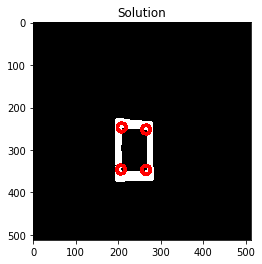

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2110.png
[]
file has only one shape


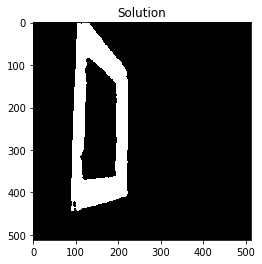

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9892.png
[{'area': 20125, 'centroid': (201, 261), 'corners': array([[255.51463, 255.49841],
       [148.25758, 176.69463],
       [257.67157, 175.32997],
       [146.81313, 345.91083],
       [256.18704, 347.91046]], dtype=float32)}, {'area': 42164, 'centroid': (203, 262), 'corners': array([[255.5145  , 255.498   ],
       [286.55685 , 136.59074 ],
       [122.450905, 139.22673 ],
       [118.32993 , 384.67154 ],
       [283.39774 , 390.2484  ]], dtype=float32)}]


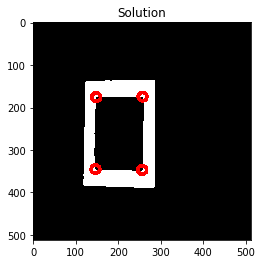

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0428.png
[{'area': 6993, 'centroid': (270, 262), 'corners': array([[255.49585, 255.4982 ],
       [240.81877, 206.81877],
       [300.87576, 212.85213],
       [300.24774, 313.66217],
       [241.37859, 317.30692]], dtype=float32)}, {'area': 15322, 'centroid': (271, 263), 'corners': array([[255.49564, 255.49823],
       [228.65753, 179.42128],
       [318.23108, 190.28838],
       [316.67007, 338.67154],
       [227.51022, 345.21112]], dtype=float32)}]


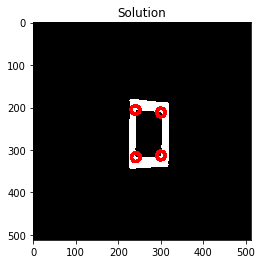

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7719 (1).png
[{'area': 6405, 'centroid': (281, 316), 'corners': array([[255.49277, 255.48294],
       [254.09071, 265.8067 ],
       [310.74234, 270.69458],
       [252.5584 , 366.44177],
       [307.2678 , 367.31552]], dtype=float32)}, {'area': 13376, 'centroid': (282, 317), 'corners': array([[255.49263, 255.48283],
       [238.8188 , 239.8188 ],
       [326.73923, 252.16637],
       [238.81879, 392.1812 ],
       [326.1628 , 389.9167 ]], dtype=float32)}]


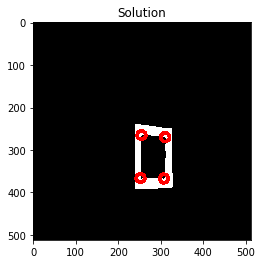

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1605.png
[{'area': 14400, 'centroid': (235, 300), 'corners': array([[255.50557, 255.4875 ],
       [280.31155, 225.98163],
       [189.85248, 228.1235 ],
       [282.18124, 374.18124],
       [189.47652, 374.92236]], dtype=float32)}, {'area': 31174, 'centroid': (235, 302), 'corners': array([[255.50563, 255.48715],
       [304.64578, 191.71432],
       [165.32837, 196.33002],
       [162.85213, 407.87573],
       [304.7075 , 412.5581 ]], dtype=float32)}]


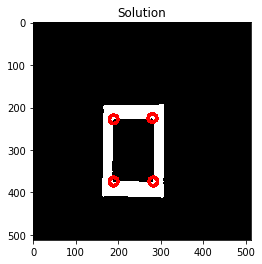

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1915.png
[{'area': 8640, 'centroid': (203, 274), 'corners': array([[255.51411, 255.49507],
       [233.46918, 205.55261],
       [173.8398 , 216.26071],
       [172.08917, 336.18686],
       [234.18123, 339.18124]], dtype=float32)}, {'area': 19488, 'centroid': (202, 274), 'corners': array([[255.51407, 255.49548],
       [248.77248, 168.46953],
       [153.4419 , 193.60617],
       [155.8372 , 365.9167 ],
       [249.18121, 372.1812 ]], dtype=float32)}]


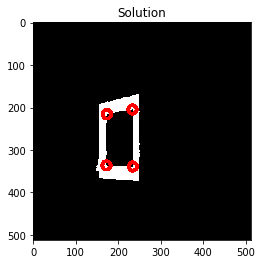

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3411.png
[{'area': 9000, 'centroid': (296, 297), 'corners': array([[255.4886 , 255.4886 ],
       [262.78168, 236.78166],
       [331.16348, 238.08357],
       [330.43994, 354.4527 ],
       [262.08337, 360.16287]], dtype=float32)}, {'area': 19716, 'centroid': (297, 298), 'corners': array([[255.48825, 255.48811],
       [244.81886, 206.81886],
       [350.67154, 212.32993],
       [350.42422, 382.42422],
       [248.79211, 395.4994 ]], dtype=float32)}]


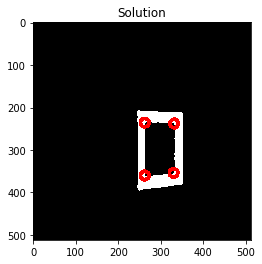

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8811.png
[{'area': 9954, 'centroid': (329, 281), 'corners': array([[255.47945, 255.49318],
       [301.35724, 201.60806],
       [359.56726, 212.73418],
       [359.71167, 353.231  ],
       [301.79663, 361.71356]], dtype=float32)}, {'area': 23760, 'centroid': (330, 283), 'corners': array([[255.47957, 255.49286],
       [282.75766, 160.78368],
       [380.24765, 185.33784],
       [381.71164, 383.23108],
       [282.57596, 402.42404]], dtype=float32)}]


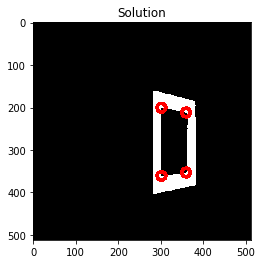

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7899.png
[]
file has only one shape


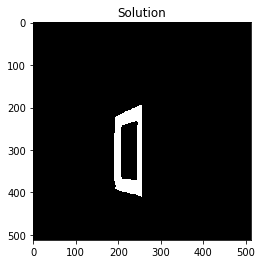

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1208.png
[]
file has only one shape


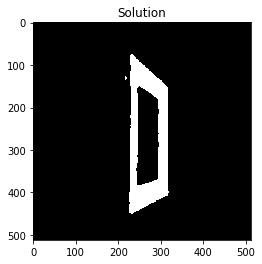

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6313.png
[{'area': 42390, 'centroid': (292, 256), 'corners': array([[255.48962, 255.5004 ],
       [217.32994, 118.32844],
       [368.44006, 140.54729],
       [371.6727 , 378.25842],
       [215.81877, 387.18124]], dtype=float32)}, {'area': 95274, 'centroid': (290, 258), 'corners': array([[255.49103 , 255.50122 ],
       [179.81879 ,  51.818787],
       [401.9167  ,  91.8372  ],
       [413.91696 , 431.16296 ],
       [176.81879 , 454.1812  ]], dtype=float32)}]


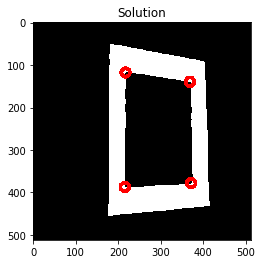

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4607.png
[{'area': 12008, 'centroid': (220, 250), 'corners': array([[255.50945, 255.50188],
       [253.50288, 170.68378],
       [183.76886, 181.28839],
       [186.68407, 322.55283],
       [254.70758, 329.55807]], dtype=float32)}, {'area': 27007, 'centroid': (219, 251), 'corners': array([[255.5095 , 255.50136],
       [273.18124, 130.81877],
       [162.57585, 152.57585],
       [167.38889, 355.6111 ],
       [274.18118, 370.1812 ]], dtype=float32)}]


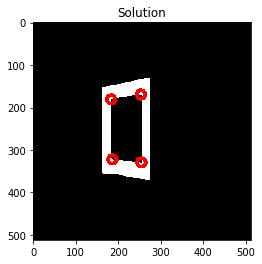

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4162.png
[]
file has only one shape


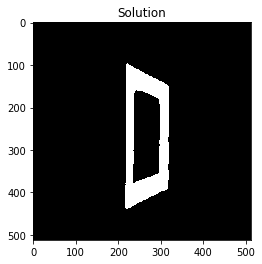

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3982.png
[{'area': 19474, 'centroid': (234, 275), 'corners': array([[255.50525, 255.49512],
       [273.24234, 165.78366],
       [190.49615, 189.59068],
       [193.27396, 369.70306],
       [277.60236, 379.6708 ]], dtype=float32)}, {'area': 45402, 'centroid': (235, 276), 'corners': array([[255.5044 , 255.4948 ],
       [295.5234 , 105.54886],
       [164.57594, 156.57594],
       [163.99931, 388.50006],
       [302.1629 , 433.91663]], dtype=float32)}]


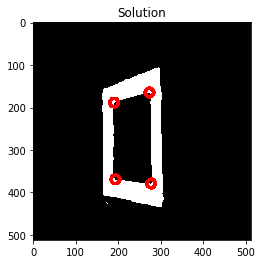

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5942.png
[{'area': 3432, 'centroid': (196, 275), 'corners': array([[255.51627, 255.4945 ],
       [215.5465 , 232.30194],
       [178.42201, 237.31398],
       [213.81586, 318.33252],
       [179.78166, 316.21832]], dtype=float32)}, {'area': 8113, 'centroid': (194, 277), 'corners': array([[255.5173 , 255.49387],
       [222.67003, 211.32841],
       [166.47311, 219.52165],
       [225.36917, 332.37476],
       [164.22264, 342.88315]], dtype=float32)}]


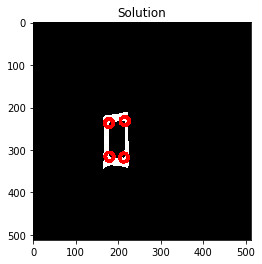

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5865.png
[{'area': 12096, 'centroid': (259, 256), 'corners': array([[255.49881, 255.50015],
       [298.43253, 182.39998],
       [218.74144, 192.3273 ],
       [217.78166, 323.21832],
       [299.14752, 325.8765 ]], dtype=float32)}, {'area': 25742, 'centroid': (259, 257), 'corners': array([[255.49901, 255.49986],
       [318.77277, 149.46971],
       [197.83702, 164.08305],
       [198.35422, 356.28568],
       [318.41205, 361.56805]], dtype=float32)}]


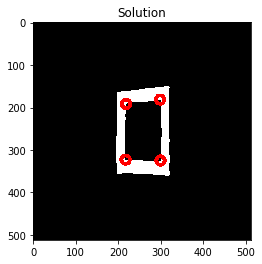

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8852.png
[{'area': 6996, 'centroid': (283, 306), 'corners': array([[252.32996, 254.32843],
       [252.32997, 254.32841],
       [315.18124, 256.81876],
       [252.32841, 358.67004],
       [313.54858, 356.77405]], dtype=float32)}, {'area': 14725, 'centroid': (283, 308), 'corners': array([[252.32996, 254.32843],
       [237.81297, 230.08951],
       [330.67154, 235.32993],
       [330.6213 , 382.30682],
       [237.32845, 385.67007]], dtype=float32)}]


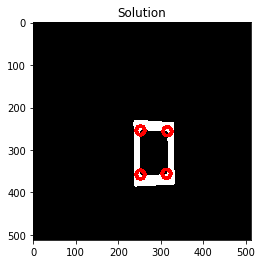

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8556.png
[]
file has only one shape


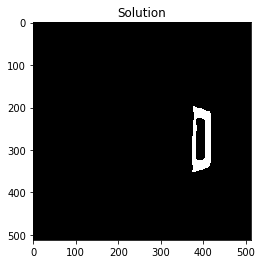

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2351.png
[{'area': 14852, 'centroid': (229, 303), 'corners': array([[255.50688, 255.48688],
       [274.12234, 223.7174 ],
       [185.55995, 233.54729],
       [276.16348, 377.9164 ],
       [184.81296, 378.91046]], dtype=float32)}, {'area': 31740, 'centroid': (229, 305), 'corners': array([[255.50664, 255.48695],
       [295.18124, 184.81876],
       [161.08331, 206.8372 ],
       [160.57584, 414.42416],
       [297.14758, 415.87613]], dtype=float32)}]


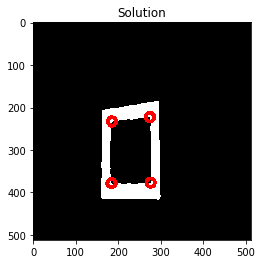

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3162.png
[{'area': 26462, 'centroid': (227, 217), 'corners': array([[255.5075 , 255.51126],
       [289.31003, 115.12635],
       [164.7302 , 127.60668],
       [290.4899 , 312.21115],
       [163.54729, 313.44006]], dtype=float32)}, {'area': 56935, 'centroid': (228, 218), 'corners': array([[255.50749 , 255.51065 ],
       [319.67007 ,  67.328445],
       [135.32845 ,  82.32994 ],
       [325.67154 , 356.67007 ],
       [132.8372  , 360.9167  ]], dtype=float32)}]


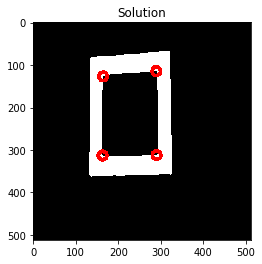

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0285.png
[]
file has only one shape


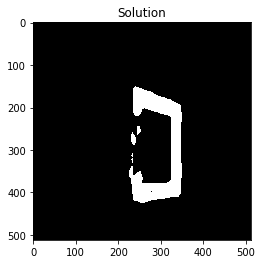

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5378.png
[]
file has only one shape


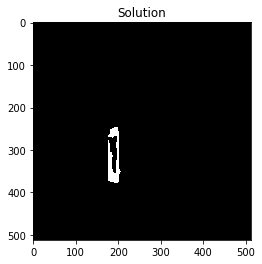

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6931.png
[{'area': 4815, 'centroid': (272, 240), 'corners': array([[251.00044, 258.50003],
       [290.80453, 185.93434],
       [250.10335, 204.94353],
       [292.6716 , 287.67004],
       [255.56691, 289.99445]], dtype=float32)}, {'area': 9880, 'centroid': (272, 239), 'corners': array([[251.00044, 258.50003],
       [301.24234, 158.78368],
       [239.61606, 179.45497],
       [303.23108, 309.71164],
       [241.32993, 309.67154]], dtype=float32)}]


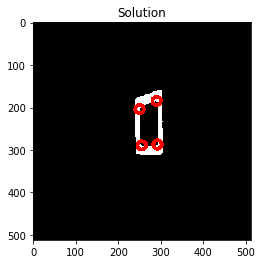

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7746.png
[{'area': 33642, 'centroid': (287, 269), 'corners': array([[255.49062, 255.49681],
       [338.52655, 129.52151],
       [226.21268, 169.57092],
       [228.32997, 385.67157],
       [348.6716 , 395.67004]], dtype=float32)}, {'area': 80136, 'centroid': (293, 269), 'corners': array([[255.48843 , 255.49236 ],
       [365.42105 ,  46.157894],
       [194.6089  , 135.51956 ],
       [196.32841 , 431.67004 ],
       [383.22983 , 468.8265  ]], dtype=float32)}]


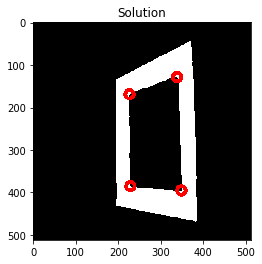

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7566.png
[{'area': 17170, 'centroid': (207, 307), 'corners': array([[255.51312, 255.48586],
       [256.56204, 220.96574],
       [159.96544, 231.43768],
       [157.08357, 388.16348],
       [257.25174, 389.52557]], dtype=float32)}, {'area': 37200, 'centroid': (207, 310), 'corners': array([[255.51324, 255.4853 ],
       [279.67   , 183.32838],
       [134.57584, 200.57584],
       [132.1655 , 426.43124],
       [282.1812 , 431.1812 ]], dtype=float32)}]


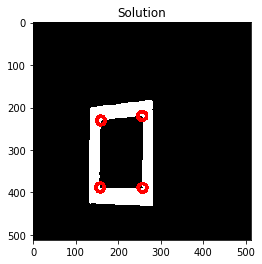

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3319.png
[]
file has only one shape


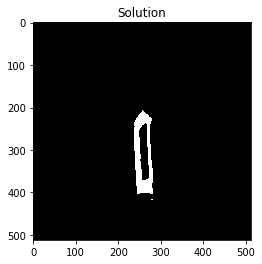

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0168.png
[{'area': 13348, 'centroid': (181, 253), 'corners': array([[252.00063, 254.49995],
       [136.08073, 184.84   ],
       [226.18689, 182.08917],
       [135.8369 , 324.91687],
       [227.43996, 323.4527 ]], dtype=float32)}, {'area': 32340, 'centroid': (181, 254), 'corners': array([[252.00063 , 254.49995 ],
       [250.67004 , 149.32841 ],
       [ 98.135025, 173.39418 ],
       [250.83507 , 359.43112 ],
       [111.818794, 358.1812  ]], dtype=float32)}]


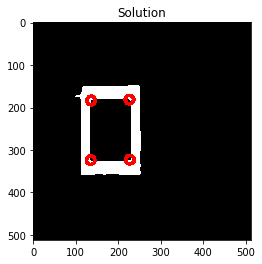

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0992.png
[{'area': 3510, 'centroid': (240, 315), 'corners': array([[255.50378, 255.48254],
       [223.0831 , 274.83682],
       [258.6716 , 271.32996],
       [223.83676, 358.91684],
       [257.7063 , 361.5587 ]], dtype=float32)}, {'area': 8357, 'centroid': (239, 317), 'corners': array([[255.50447, 255.48286],
       [266.19223, 247.55623],
       [209.44719, 258.68405],
       [208.85213, 379.87573],
       [267.707  , 386.13126]], dtype=float32)}]


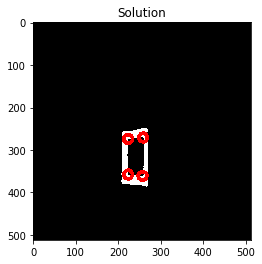

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6612.png
[{'area': 27216, 'centroid': (321, 251), 'corners': array([[255.48103, 255.502  ],
       [369.67007, 121.32846],
       [267.74594, 160.31389],
       [268.81296, 358.91046],
       [374.4121 , 365.56815]], dtype=float32)}, {'area': 64051, 'centroid': (325, 251), 'corners': array([[255.48076 , 255.49861 ],
       [398.18112 ,  45.818867],
       [238.66467 , 127.73005 ],
       [245.73128 , 414.1683  ],
       [406.16293 , 426.91696 ]], dtype=float32)}]


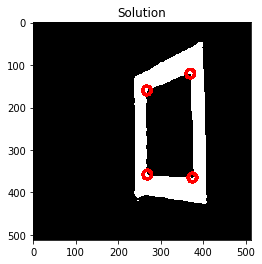

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6136.png
[]
file has only one shape


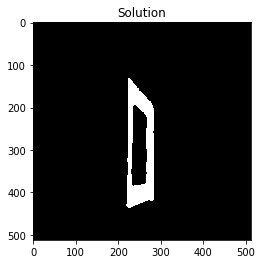

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4308.png
[{'area': 8806, 'centroid': (276, 242), 'corners': array([[255.49413, 255.50378],
       [243.32994, 183.32843],
       [312.91046, 188.81296],
       [309.8765 , 297.14752],
       [240.78888, 299.4898 ]], dtype=float32)}, {'area': 18480, 'centroid': (277, 242), 'corners': array([[255.49388, 255.50337],
       [226.33002, 155.32837],
       [328.7075 , 160.4419 ],
       [327.47018, 325.2196 ],
       [226.22614, 331.5296 ]], dtype=float32)}]


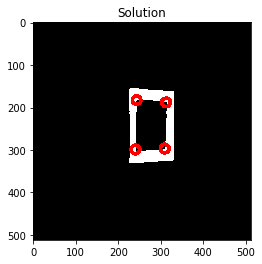

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5479.png
[]
file has only one shape


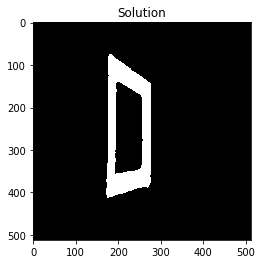

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2378.png
[{'area': 4692, 'centroid': (214, 315), 'corners': array([[255.51106, 255.48347],
       [233.40565, 263.07684],
       [191.9875 , 275.7889 ],
       [235.67159, 362.67004],
       [194.87695, 362.7356 ]], dtype=float32)}, {'area': 10350, 'centroid': (213, 316), 'corners': array([[255.51129, 255.48322],
       [245.67003, 239.32841],
       [179.42198, 254.314  ],
       [247.05327, 387.52185],
       [180.66808, 387.73843]], dtype=float32)}]


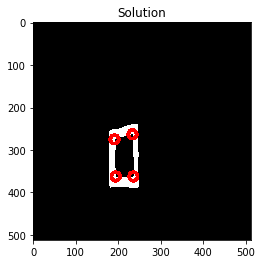

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7417 (1).png
[{'area': 14832, 'centroid': (261, 298), 'corners': array([[255.49788, 255.4876 ],
       [292.23303, 188.1739 ],
       [225.04922, 221.54512],
       [228.22906, 389.80502],
       [294.83505, 396.43112]], dtype=float32)}]
file has only one shape


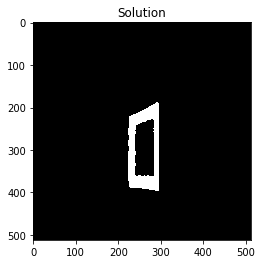

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4164.png
[]
file has only one shape


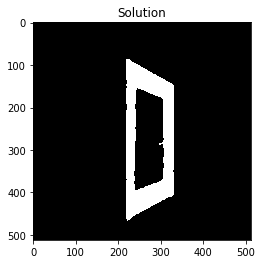

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7054 (1).png
[{'area': 7314, 'centroid': (255, 299), 'corners': array([[255.50008, 255.48798],
       [224.22679, 247.45084],
       [286.51932, 249.67108],
       [220.81877, 351.18124],
       [287.9164 , 350.16348]], dtype=float32)}, {'area': 15912, 'centroid': (255, 300), 'corners': array([[255.49986, 255.48778],
       [207.32994, 221.32845],
       [306.21646, 227.75772],
       [204.78355, 375.24228],
       [304.44003, 376.45273]], dtype=float32)}]


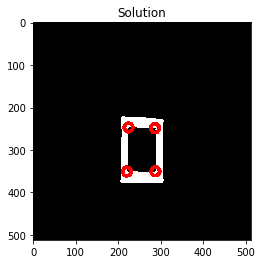

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1587.png
[{'area': 34579, 'centroid': (250, 283), 'corners': array([[255.50124, 255.49245],
       [180.56004, 167.54732],
       [323.1869 , 173.08919],
       [175.81883, 396.18115],
       [324.91083, 393.1869 ]], dtype=float32)}, {'area': 73926, 'centroid': (250, 285), 'corners': array([[255.50104, 255.49217],
       [147.83105, 114.32793],
       [357.9167 , 126.8372 ],
       [140.08333, 448.1628 ],
       [363.2857 , 444.64594]], dtype=float32)}]


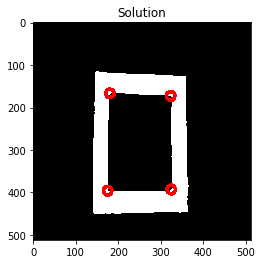

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6923 (1).png
[{'area': 6912, 'centroid': (245, 305), 'corners': array([[255.50328, 255.48604],
       [222.75766, 239.78366],
       [270.35706, 254.85167],
       [220.32841, 366.67004],
       [268.91696, 364.16293]], dtype=float32)}, {'area': 15040, 'centroid': (245, 307), 'corners': array([[255.50351, 255.48633],
       [207.81877, 207.81877],
       [285.42743, 232.6314 ],
       [285.19238, 393.44385],
       [207.79738, 398.4172 ]], dtype=float32)}]


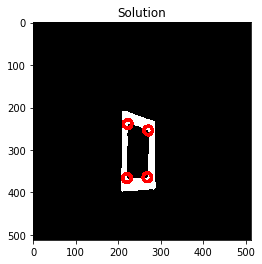

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3831.png
[{'area': 6868, 'centroid': (225, 274), 'corners': array([[255.50818, 255.49457],
       [194.28839, 225.76883],
       [257.31024, 225.12674],
       [192.81877, 326.18124],
       [257.6622 , 323.24738]], dtype=float32)}, {'area': 14356, 'centroid': (226, 274), 'corners': array([[255.50763, 255.4947 ],
       [184.37794, 200.51373],
       [274.9167 , 200.8372 ],
       [179.32845, 349.67007],
       [274.67007, 347.67154]], dtype=float32)}]


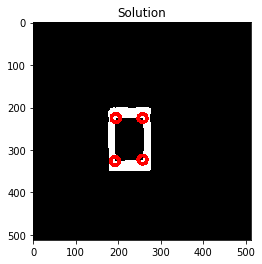

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9016.png
[]
file has only one shape


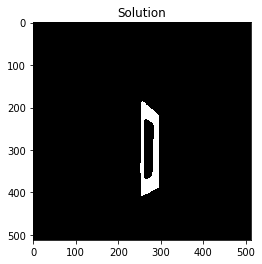

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6604.png
[{'area': 31624, 'centroid': (263, 255), 'corners': array([[255.49695, 255.50133],
       [326.2478 , 132.33784],
       [199.5907 , 155.49619],
       [196.5384 , 362.46222],
       [330.18115, 367.18115]], dtype=float32)}, {'area': 71242, 'centroid': (266, 255), 'corners': array([[255.49574, 255.50188],
       [358.6544 ,  68.62074],
       [167.12395, 117.85216],
       [163.21275, 407.4293 ],
       [363.56546, 425.3091 ]], dtype=float32)}]


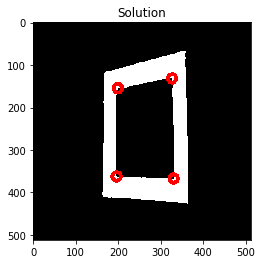

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7227.png
[{'area': 8880, 'centroid': (244, 256), 'corners': array([[255.50397, 255.50037],
       [216.81885, 179.81885],
       [272.15784, 195.56667],
       [215.32841, 327.67004],
       [269.36447, 325.32504]], dtype=float32)}, {'area': 21111, 'centroid': (243, 255), 'corners': array([[255.50389, 255.50064],
       [199.82166, 135.34772],
       [289.0826 , 168.91739],
       [291.1628 , 353.9167 ],
       [198.32845, 363.67007]], dtype=float32)}]


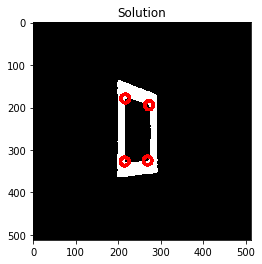

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5451.png
[]
file has only one shape


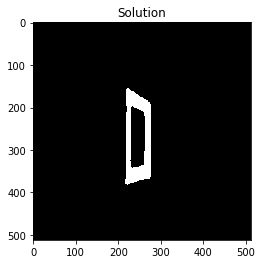

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4188.png
[{'area': 15549, 'centroid': (252, 292), 'corners': array([[255.50154, 255.48941],
       [218.55525, 185.19005],
       [289.4527 , 206.56001],
       [290.2311 , 377.7116 ],
       [218.55258, 398.73065]], dtype=float32)}]
file has only one shape


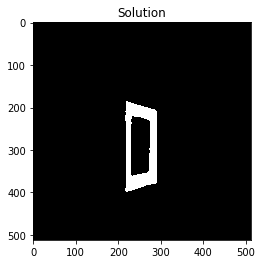

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0375.png
[{'area': 1050, 'centroid': (313, 405), 'corners': array([[255.48233, 255.45497],
       [305.49142, 389.65945],
       [330.94153, 400.28854],
       [302.33563, 424.29742],
       [325.49203, 421.5798 ]], dtype=float32)}, {'area': 132, 'centroid': (135, 380), 'corners': array([[255.53905, 255.45963],
       [135.70049, 372.57126],
       [139.72728, 378.5    ],
       [129.72083, 378.69742],
       [139.49652, 384.43167]], dtype=float32)}, {'area': 180, 'centroid': (160, 53), 'corners': array([[255.52786 , 255.56023 ],
       [166.56757 ,  51.243244],
       [151.00264 ,  52.628914],
       [160.66667 ,  59.      ]], dtype=float32)}, {'area': 1120, 'centroid': (184, 60), 'corners': array([[255.52124 , 255.55629 ],
       [175.60223 ,  47.751556],
       [202.13075 ,  51.35602 ],
       [163.05327 ,  68.6866  ],
       [189.60188 ,  74.86631 ]], dtype=float32)}

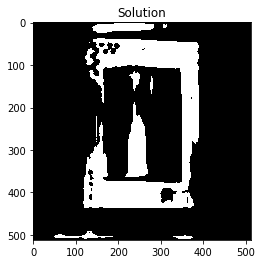

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0101.png
[{'area': 10584, 'centroid': (313, 289), 'corners': array([[255.4842 , 255.49066],
       [351.91083, 227.81313],
       [273.2702 , 230.7771 ],
       [354.16348, 349.9164 ],
       [274.56006, 350.4527 ]], dtype=float32)}, {'area': 22878, 'centroid': (314, 290), 'corners': array([[255.4835 , 255.49069],
       [371.67   , 195.32838],
       [254.32845, 206.32994],
       [376.21646, 379.24228],
       [254.81879, 380.1812 ]], dtype=float32)}]


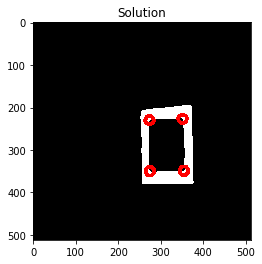

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0827.png
[{'area': 8892, 'centroid': (244, 265), 'corners': array([[255.50296, 255.49704],
       [208.85211, 209.12422],
       [281.42407, 210.57593],
       [208.22646, 323.52972],
       [281.67004, 322.6716 ]], dtype=float32)}, {'area': 18810, 'centroid': (244, 266), 'corners': array([[255.5031 , 255.49677],
       [299.54858, 182.22597],
       [189.57584, 183.57584],
       [298.6213 , 352.30682],
       [189.16426, 351.71317]], dtype=float32)}]


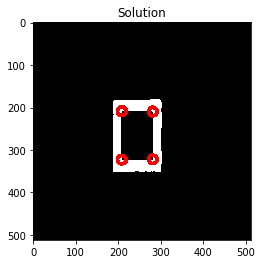

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6727 (1).png
[{'area': 6204, 'centroid': (279, 325), 'corners': array([[255.49295, 255.48088],
       [298.97073, 255.78583],
       [257.0494 , 270.54486],
       [258.81296, 386.9105 ],
       [301.2032 , 390.71362]], dtype=float32)}]
file has only one shape


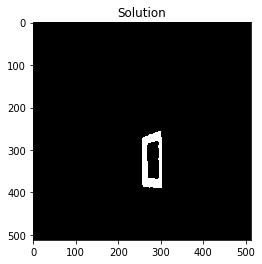

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2593.png
[{'area': 8625, 'centroid': (244, 311), 'corners': array([[255.50443, 254.5008 ],
       [213.16586, 247.56851],
       [277.55283, 259.68408],
       [211.32841, 369.67004],
       [278.18124, 370.18124]], dtype=float32)}, {'area': 19055, 'centroid': (245, 313), 'corners': array([[255.50443, 254.5008 ],
       [195.61702, 218.17545],
       [296.1812 , 233.81877],
       [297.90894, 399.19354],
       [194.57584, 401.42416]], dtype=float32)}]


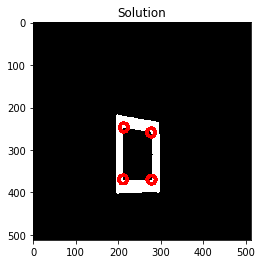

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6207.png
[{'area': 18792, 'centroid': (221, 289), 'corners': array([[255.50949, 255.4898 ],
       [184.83116, 173.10141],
       [265.15436, 213.67471],
       [260.36447, 384.32504],
       [181.08336, 389.16284]], dtype=float32)}, {'area': 43560, 'centroid': (221, 291), 'corners': array([[255.5101 , 255.48837],
       [164.2821 , 113.92585],
       [288.39108, 179.51956],
       [289.71164, 423.23108],
       [157.40424, 445.379  ]], dtype=float32)}]


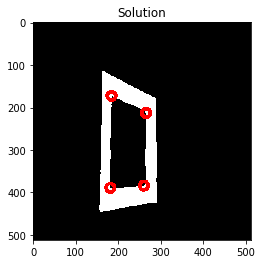

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5047.png
[{'area': 19040, 'centroid': (245, 282), 'corners': array([[255.50275, 255.49245],
       [192.28839, 198.76883],
       [300.12555, 200.4508 ],
       [191.34875, 367.28003],
       [298.7116 , 366.23114]], dtype=float32)}, {'area': 40344, 'centroid': (245, 284), 'corners': array([[255.50269, 255.49176],
       [165.32994, 163.32845],
       [326.67163, 163.33002],
       [326.67007, 405.67154],
       [164.66006, 409.64633]], dtype=float32)}]


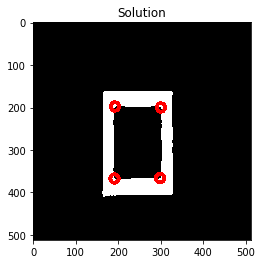

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2170.png
[]
file has only one shape


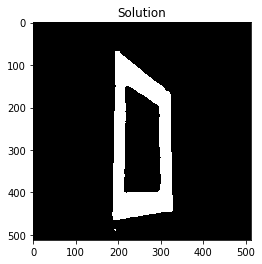

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2748.png
[{'area': 52521, 'centroid': (267, 263), 'corners': array([[255.49553, 255.49962],
       [347.2349 , 113.34866],
       [183.68285, 140.44771],
       [359.54916, 391.77322],
       [177.81296, 397.91046]], dtype=float32)}, {'area': 113710, 'centroid': (272, 267), 'corners': array([[255.49431 , 255.49965 ],
       [388.16287 ,  45.083366],
       [143.32841 ,  91.329956],
       [410.28024 , 456.65112 ],
       [135.32993 , 458.67154 ]], dtype=float32)}]


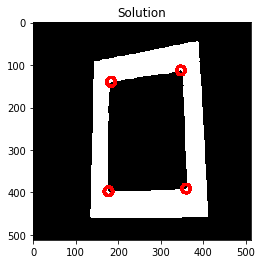

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1860.png
[{'area': 2100, 'centroid': (241, 292), 'corners': array([[253.82071, 254.63548],
       [253.82065, 254.63525],
       [229.32845, 259.32993],
       [251.22826, 329.41388],
       [230.56001, 326.4527 ]], dtype=float32)}]
file has only one shape


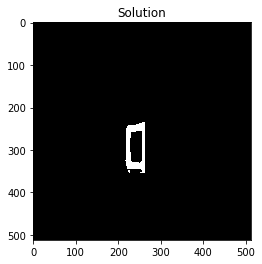

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9791.png
[{'area': 30816, 'centroid': (304, 234), 'corners': array([[255.48654, 255.50612],
       [372.16287, 127.08336],
       [235.25769, 131.69455],
       [375.91046, 336.18704],
       [236.27124, 338.8107 ]], dtype=float32)}, {'area': 64790, 'centroid': (306, 234), 'corners': array([[255.48627 , 255.50598 ],
       [404.60242 ,  77.329216],
       [203.32837 ,  83.33002 ],
       [410.65112 , 386.2802  ],
       [202.81879 , 387.1812  ]], dtype=float32)}]


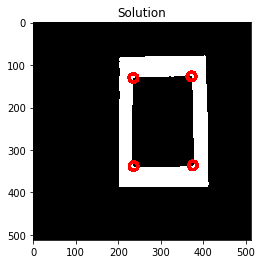

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6645.png
[{'area': 4532, 'centroid': (218, 297), 'corners': array([[255.50996, 255.48828],
       [237.57729, 245.61517],
       [198.09654, 255.82872],
       [199.83713, 345.91663],
       [238.60246, 347.67087]], dtype=float32)}, {'area': 10184, 'centroid': (217, 300), 'corners': array([[255.51035, 255.48773],
       [249.18121, 222.81879],
       [184.71977, 236.34888],
       [251.18121, 372.1812 ],
       [184.86603, 374.56357]], dtype=float32)}]


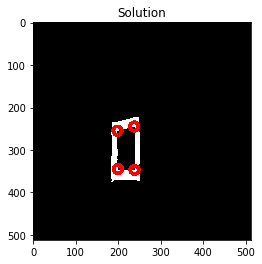

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6787.png
[{'area': 14620, 'centroid': (245, 223), 'corners': array([[255.50339, 255.5099 ],
       [209.29366, 134.44135],
       [287.254  , 157.31355],
       [205.43817, 298.33987],
       [283.5084 , 302.34064]], dtype=float32)}, {'area': 32121, 'centroid': (244, 222), 'corners': array([[255.50412, 255.51044],
       [184.83705,  89.08337],
       [308.75   , 131.4375 ],
       [180.81879, 337.1812 ],
       [310.9108 , 335.18677]], dtype=float32)}]


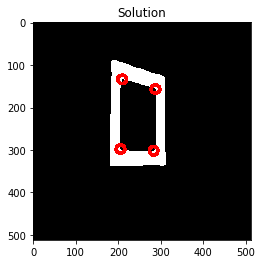

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6619.png
[{'area': 22321, 'centroid': (229, 264), 'corners': array([[255.50673, 255.4982 ],
       [272.7065 , 146.44142],
       [179.66426, 180.86958],
       [182.5197 , 364.39102],
       [278.18124, 367.18124]], dtype=float32)}, {'area': 51000, 'centroid': (230, 264), 'corners': array([[255.50633 , 255.49815 ],
       [297.445   ,  83.190186],
       [154.0807  , 144.84    ],
       [158.67293 , 413.1643  ],
       [302.65112 , 424.2802  ]], dtype=float32)}]


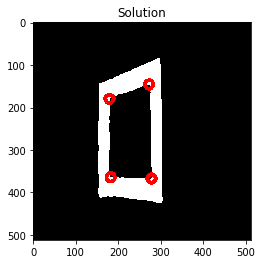

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3243.png
[{'area': 6157, 'centroid': (221, 279), 'corners': array([[255.50958, 255.49272],
       [237.93112, 211.33865],
       [199.18924, 229.27133],
       [242.23105, 336.71164],
       [203.06436, 340.11642]], dtype=float32)}, {'area': 13896, 'centroid': (220, 279), 'corners': array([[255.50844, 255.4923 ],
       [250.64926, 175.36784],
       [183.10335, 213.94353],
       [253.81754, 369.4519 ],
       [186.29239, 368.55804]], dtype=float32)}]


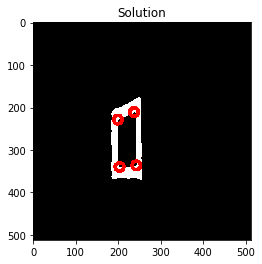

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2492.png
[]
file has only one shape


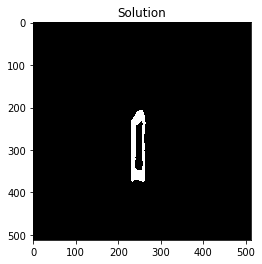

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9080.png
[{'area': 7722, 'centroid': (233, 295), 'corners': array([[255.50623, 255.48923],
       [203.81294, 236.08957],
       [264.87366, 243.68999],
       [202.12637, 350.31003],
       [263.18704, 349.91046]], dtype=float32)}, {'area': 16800, 'centroid': (233, 297), 'corners': array([[255.50587, 255.48878],
       [188.29341, 207.4415 ],
       [282.1812 , 220.81879],
       [283.1812 , 376.1812 ],
       [186.83717, 382.91708]], dtype=float32)}]


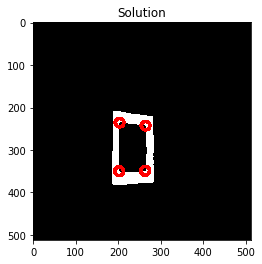

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6637.png
[{'area': 6222, 'centroid': (218, 294), 'corners': array([[255.51001, 255.4895 ],
       [241.32384, 231.40862],
       [194.7816 , 242.7816 ],
       [242.4416 , 351.44177],
       [193.08305, 350.16293]], dtype=float32)}, {'area': 14141, 'centroid': (217, 296), 'corners': array([[255.51004, 255.48909],
       [254.77246, 202.46948],
       [177.5804 , 223.83856],
       [178.47661, 380.4511 ],
       [254.70749, 383.5581 ]], dtype=float32)}]


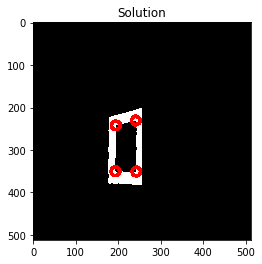

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0309.png
[{'area': 14345, 'centroid': (281, 300), 'corners': array([[255.49283, 255.48866],
       [319.1858 , 223.43333],
       [238.42201, 228.31396],
       [329.80917, 367.56323],
       [236.81877, 370.18124]], dtype=float32)}, {'area': 31688, 'centroid': (284, 298), 'corners': array([[255.49231, 255.48813],
       [349.187  , 181.08968],
       [215.44759, 200.68314],
       [213.32993, 403.67154],
       [350.63852, 413.3889 ]], dtype=float32)}]


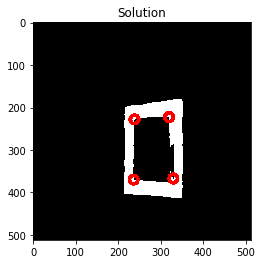

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3898.png
[{'area': 50596, 'centroid': (240, 243), 'corners': array([[255.50406 , 255.5033  ],
       [151.1235  , 106.85248 ],
       [330.42407 , 107.575935],
       [329.31598 , 378.5528  ],
       [151.81313 , 383.91083 ]], dtype=float32)}, {'area': 107869, 'centroid': (240, 244), 'corners': array([[255.5042  , 255.50288 ],
       [108.575836,  43.575832],
       [371.57803 ,  50.314007],
       [374.85443 , 439.81754 ],
       [106.09648 , 445.17114 ]], dtype=float32)}]


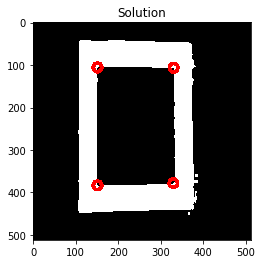

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0714.png
[]
file has only one shape


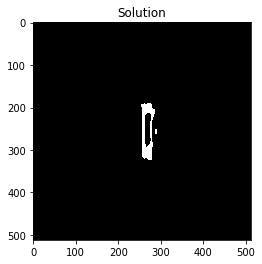

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2401.png
[{'area': 11550, 'centroid': (220, 294), 'corners': array([[255.50906, 255.48996],
       [249.81316, 201.0142 ],
       [189.60901, 227.51971],
       [249.80418, 374.50012],
       [188.57591, 373.42407]], dtype=float32)}, {'area': 26462, 'centroid': (220, 294), 'corners': array([[255.50806, 255.48842],
       [266.1327 , 152.75536],
       [171.45125, 198.8746 ],
       [168.7816 , 408.2184 ],
       [269.65112, 415.2802 ]], dtype=float32)}]


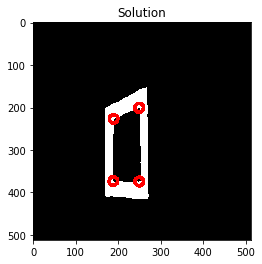

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2750.png
[{'area': 45730, 'centroid': (266, 264), 'corners': array([[255.49603, 255.49892],
       [339.61157, 123.95354],
       [188.51955, 150.60889],
       [351.1869 , 385.91083],
       [182.83713, 390.91663]], dtype=float32)}, {'area': 98806, 'centroid': (270, 267), 'corners': array([[255.49506 , 255.49904 ],
       [378.1479  ,  61.124348],
       [148.32841 , 102.329956],
       [398.1933  , 446.9093  ],
       [143.0892  , 448.18677 ]], dtype=float32)}]


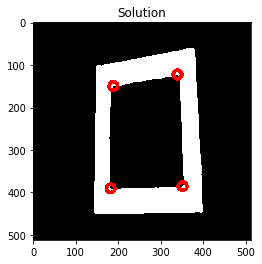

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8166 (1).png
[]
file has only one shape


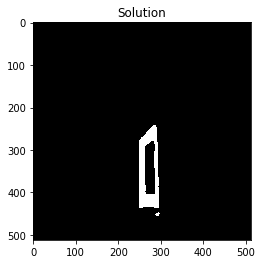

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4236.png
[{'area': 6048, 'centroid': (248, 235), 'corners': array([[255.50217, 255.50505],
       [227.75768, 172.78366],
       [272.56723, 179.73407],
       [272.31534, 290.64136],
       [226.22748, 299.53046]], dtype=float32)}, {'area': 14476, 'centroid': (249, 236), 'corners': array([[255.50255, 255.50531],
       [212.32999, 143.32838],
       [288.16318, 156.08311],
       [288.71164, 316.23105],
       [213.22597, 331.52948]], dtype=float32)}]


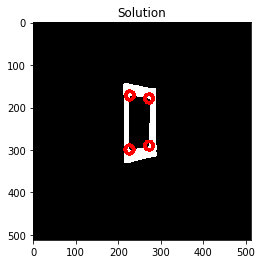

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8501 (1).png
[{'area': 10428, 'centroid': (253, 288), 'corners': array([[255.50003, 255.49124],
       [289.59592, 221.43878],
       [215.44717, 234.68407],
       [290.5987 , 348.3047 ],
       [216.48315, 351.4503 ]], dtype=float32)}, {'area': 21660, 'centroid': (253, 290), 'corners': array([[255.50014, 255.49103],
       [306.18124, 192.81877],
       [197.1262 , 209.69006],
       [309.11426, 378.68295],
       [200.35121, 382.87436]], dtype=float32)}]


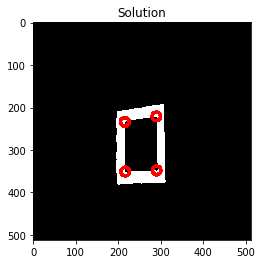

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8672.png
[{'area': 3640, 'centroid': (146, 275), 'corners': array([[255.5311 , 255.49466],
       [128.3298 , 230.32858],
       [164.4401 , 235.54733],
       [128.78166, 320.21832],
       [163.22984, 317.8934 ]], dtype=float32)}, {'area': 8556, 'centroid': (147, 277), 'corners': array([[255.53098 , 255.4945  ],
       [118.32996 , 207.32841 ],
       [177.87572 , 216.85213 ],
       [174.46642 , 339.69064 ],
       [117.388885, 343.6111  ]], dtype=float32)}]


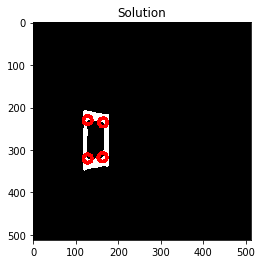

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9786.png
[{'area': 29820, 'centroid': (347, 234), 'corners': array([[255.4746 , 255.50584],
       [281.54474, 127.04962],
       [414.68967, 130.42538],
       [279.85248, 339.8765 ],
       [416.31598, 338.5528 ]], dtype=float32)}, {'area': 64480, 'centroid': (349, 235), 'corners': array([[255.47404, 255.5059 ],
       [249.03123,  77.791  ],
       [448.67154,  82.32993],
       [248.16493, 389.43112],
       [455.1812 , 387.1812 ]], dtype=float32)}]


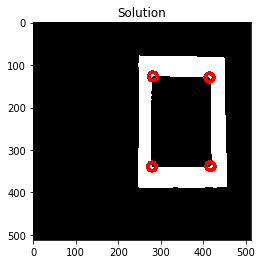

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8847.png
[{'area': 22148, 'centroid': (256, 299), 'corners': array([[255.49963, 255.48834],
       [206.4764 , 199.0777 ],
       [310.4552 , 212.0497 ],
       [312.43994, 388.4527 ],
       [200.81877, 395.18124]], dtype=float32)}, {'area': 48552, 'centroid': (256, 301), 'corners': array([[255.4996 , 255.4881 ],
       [177.22722, 153.46971],
       [339.0534 , 177.47806],
       [342.2802 , 426.65112],
       [175.16493, 444.43112]], dtype=float32)}]


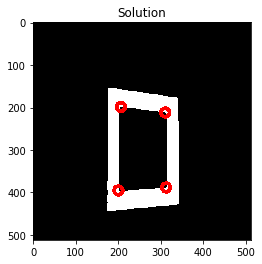

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7363 (1).png
[{'area': 5376, 'centroid': (250, 305), 'corners': array([[255.57275, 252.07286],
       [271.4476 , 248.26944],
       [227.55975, 261.69272],
       [272.77423, 358.52936],
       [228.83698, 357.91666]], dtype=float32)}, {'area': 12300, 'centroid': (249, 307), 'corners': array([[255.57274, 252.07286],
       [283.70673, 222.86879],
       [213.0785 , 239.8609 ],
       [287.4172 , 383.2026 ],
       [212.86916, 386.20618]], dtype=float32)}]


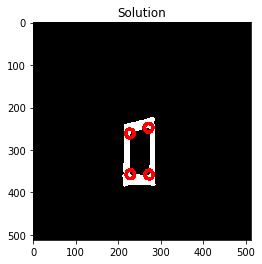

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4381.png
[{'area': 38500, 'centroid': (291, 240), 'corners': array([[255.48984, 255.50412],
       [218.28839, 115.76884],
       [368.23102, 125.28835],
       [367.91083, 355.18686],
       [217.68976, 365.87326]], dtype=float32)}, {'area': 82575, 'centroid': (290, 240), 'corners': array([[255.4899 , 255.50392],
       [180.03125,  57.791  ],
       [404.67163,  75.33002],
       [403.3626 , 405.53   ],
       [181.32845, 425.67007]], dtype=float32)}]


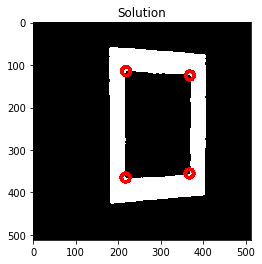

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8363.png
[{'area': 23353, 'centroid': (243, 269), 'corners': array([[255.50337, 255.49602],
       [302.72104, 173.2768 ],
       [184.4699 , 179.63748],
       [299.48987, 366.21115],
       [184.83818, 363.65744]], dtype=float32)}, {'area': 50018, 'centroid': (244, 271), 'corners': array([[255.50337, 255.49553],
       [330.24228, 129.78355],
       [155.68982, 142.12662],
       [156.1655 , 403.43124],
       [330.9687 , 412.20895]], dtype=float32)}]


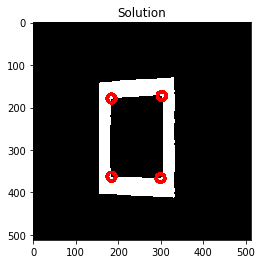

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3029.png
[]
file has only one shape


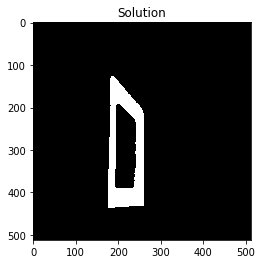

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2421.png
[{'area': 3496, 'centroid': (227, 324), 'corners': array([[252.17209, 254.86897],
       [244.16298, 279.08334],
       [208.81876, 284.81876],
       [244.18123, 367.18124],
       [211.68999, 367.87366]], dtype=float32)}, {'area': 7728, 'centroid': (226, 326), 'corners': array([[252.17209, 254.86897],
       [252.16914, 254.87164],
       [199.34879, 266.7199 ],
       [252.20262, 392.4172 ],
       [198.77034, 390.89334]], dtype=float32)}]


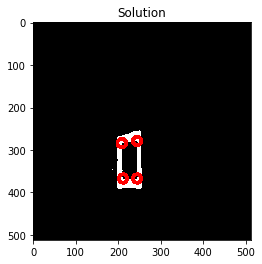

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2283.png
[{'area': 17010, 'centroid': (243, 296), 'corners': array([[255.5033 , 255.48846],
       [193.26927, 216.74834],
       [294.07468, 220.84045],
       [191.8369 , 376.91687],
       [294.21725, 376.59286]], dtype=float32)}, {'area': 37920, 'centroid': (244, 299), 'corners': array([[255.50302, 255.48805],
       [168.18413, 179.6675 ],
       [319.67154, 184.32993],
       [325.1812 , 414.1812 ],
       [166.16493, 418.43112]], dtype=float32)}]


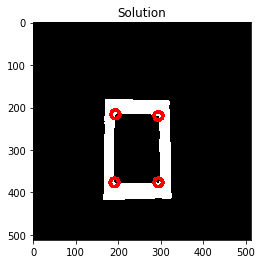

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8509.png
[{'area': 4370, 'centroid': (320, 274), 'corners': array([[255.4816 , 255.4949 ],
       [306.49734, 226.08304],
       [343.24738, 231.33781],
       [300.85248, 321.87646],
       [340.7116 , 318.2311 ]], dtype=float32)}, {'area': 9724, 'centroid': (321, 276), 'corners': array([[255.48131, 255.49408],
       [289.32996, 205.32841],
       [355.9167 , 212.8372 ],
       [355.67007, 339.67154],
       [289.90915, 348.78583]], dtype=float32)}]


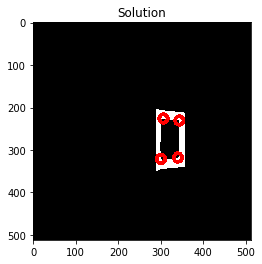

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7692.png
[{'area': 24416, 'centroid': (293, 262), 'corners': array([[255.4886 , 255.49902],
       [340.18707, 146.08958],
       [240.74602, 174.31355],
       [240.57591, 360.42407],
       [344.64597, 370.2857 ]], dtype=float32)}, {'area': 55062, 'centroid': (296, 262), 'corners': array([[255.48625, 255.49826],
       [369.44473,  84.19004],
       [214.0807 , 140.84   ],
       [212.12662, 398.31018],
       [373.77402, 427.52948]], dtype=float32)}]


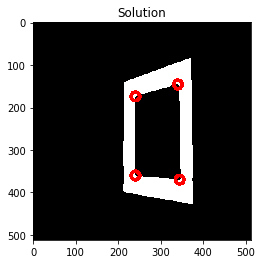

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7124 (1).png
[{'area': 8588, 'centroid': (256, 304), 'corners': array([[255.49959, 255.48633],
       [221.56004, 249.54732],
       [294.24738, 252.33781],
       [220.71906, 358.6507 ],
       [291.90396, 360.15112]], dtype=float32)}, {'area': 18537, 'centroid': (257, 307), 'corners': array([[255.49959, 255.486  ],
       [204.33002, 223.32837],
       [311.1812 , 226.81879],
       [201.32855, 387.67017],
       [310.8345 , 389.43124]], dtype=float32)}]


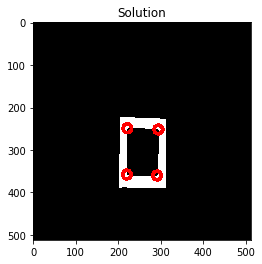

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3694.png
[{'area': 29820, 'centroid': (244, 288), 'corners': array([[255.50282, 255.49121],
       [180.28455, 179.47966],
       [313.16348, 187.08357],
       [313.7116 , 389.23114],
       [176.32841, 393.67004]], dtype=float32)}, {'area': 64165, 'centroid': (244, 289), 'corners': array([[255.50288, 255.49107],
       [144.81886, 131.81886],
       [345.28568, 139.35422],
       [348.1628 , 436.9167 ],
       [143.32845, 445.67007]], dtype=float32)}]


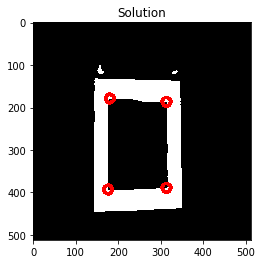

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7156 (1).png
[{'area': 37600, 'centroid': (249, 269), 'corners': array([[255.50172, 255.49635],
       [175.35863, 151.68468],
       [323.16898, 153.32793],
       [167.89452, 380.7021 ],
       [326.52185, 384.05328]], dtype=float32)}, {'area': 79112, 'centroid': (248, 272), 'corners': array([[255.50159 , 255.49588 ],
       [140.32994 ,  98.328445],
       [360.50845 , 107.5345  ],
       [132.83652 , 438.91635 ],
       [365.67007 , 437.67154 ]], dtype=float32)}]


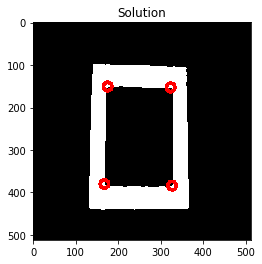

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7392.png
[{'area': 12936, 'centroid': (258, 271), 'corners': array([[255.49861, 255.49606],
       [290.3057 , 183.33464],
       [221.44719, 205.68404],
       [295.18124, 350.18124],
       [222.78166, 348.21832]], dtype=float32)}, {'area': 28728, 'centroid': (259, 272), 'corners': array([[255.49838, 255.49608],
       [309.44476, 137.19005],
       [202.28012, 178.68849],
       [204.42177, 383.4302 ],
       [315.1812 , 390.1812 ]], dtype=float32)}]


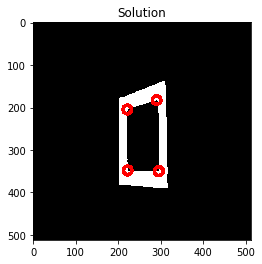

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7441.png
[]
file has only one shape


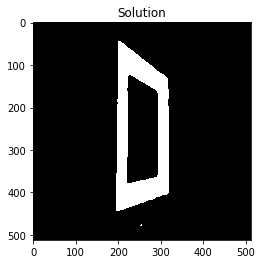

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0647.png
[]
file has only one shape


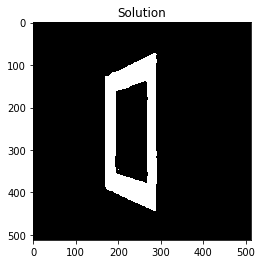

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3193.png
[{'area': 21696, 'centroid': (234, 248), 'corners': array([[255.5046 , 255.50018],
       [273.47418, 127.05641],
       [189.83623, 171.12651],
       [280.21832, 341.21832],
       [190.84387, 350.8949 ]], dtype=float32)}, {'area': 49494, 'centroid': (235, 247), 'corners': array([[255.50352, 255.50081],
       [294.57077,  60.33112],
       [162.6089 , 142.51956],
       [307.67154, 392.67007],
       [172.03938, 399.80728]], dtype=float32)}]


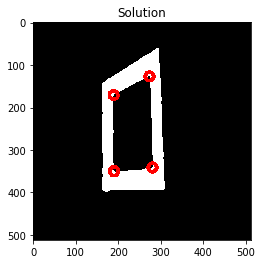

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4235.png
[{'area': 6144, 'centroid': (223, 233), 'corners': array([[255.50964, 255.50569],
       [200.81877, 170.81877],
       [246.47835, 178.4731 ],
       [245.25858, 288.67273],
       [201.17935, 298.36475]], dtype=float32)}, {'area': 14516, 'centroid': (224, 234), 'corners': array([[255.50952, 255.50601],
       [188.16577, 139.56853],
       [263.209  , 156.03125],
       [262.18683, 314.91083],
       [193.54546, 329.5909 ]], dtype=float32)}]


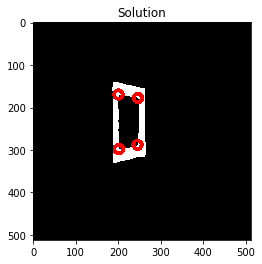

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0530.png
[{'area': 7776, 'centroid': (268, 222), 'corners': array([[255.49629, 255.50906],
       [238.22894, 168.19502],
       [302.67157, 172.32997],
       [233.81877, 274.18124],
       [302.18124, 274.18124]], dtype=float32)}, {'area': 15708, 'centroid': (268, 222), 'corners': array([[255.49635, 255.50893],
       [218.08305, 146.83702],
       [320.16327, 146.08328],
       [221.47664, 300.9224 ],
       [317.91696, 300.16296]], dtype=float32)}]


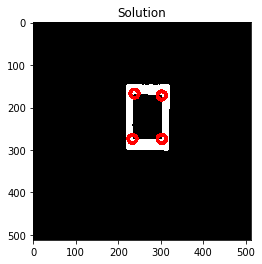

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7571 (1).png
[]
file has only one shape


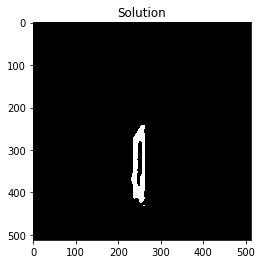

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2450.png
[]
file has only one shape


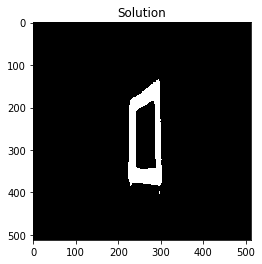

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3674.png
[{'area': 5580, 'centroid': (182, 261), 'corners': array([[255.52026, 255.49828],
       [210.40024, 215.46269],
       [153.32841, 218.32997],
       [209.66217, 306.24774],
       [152.81877, 306.18124]], dtype=float32)}, {'area': 11658, 'centroid': (181, 262), 'corners': array([[255.52026, 255.49828],
       [224.67006, 195.32845],
       [137.7143 , 199.35416],
       [224.67155, 326.67007],
       [138.75772, 328.21646]], dtype=float32)}]


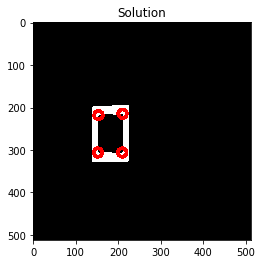

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9799.png
[{'area': 31666, 'centroid': (311, 236), 'corners': array([[255.48416, 255.50609],
       [377.2423 , 120.78362],
       [243.85248, 138.1235 ],
       [381.21832, 341.21835],
       [244.5197 , 341.39102]], dtype=float32)}, {'area': 67774, 'centroid': (315, 236), 'corners': array([[255.48215 , 255.50706 ],
       [412.13126 ,  66.292984],
       [213.81311 ,  96.08918 ],
       [212.29239 , 386.55804 ],
       [416.70685 , 395.13126 ]], dtype=float32)}]


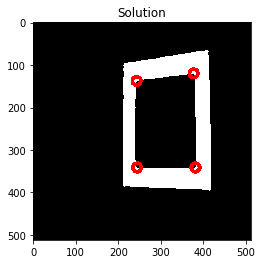

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9252.png
[{'area': 25155, 'centroid': (137, 260), 'corners': array([[255.53207 , 255.49849 ],
       [ 80.388885, 163.38889 ],
       [201.34062 , 168.49161 ],
       [ 75.328415, 356.67004 ],
       [200.91081 , 355.1869  ]], dtype=float32)}, {'area': 52547, 'centroid': (136, 261), 'corners': array([[255.53262 , 255.49821 ],
       [ 42.818794, 120.818794],
       [229.67155 , 123.32994 ],
       [ 44.402344, 402.61267 ],
       [228.20262 , 402.4172  ]], dtype=float32)}]


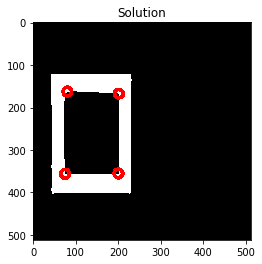

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7914.png
[{'area': 54120, 'centroid': (281, 257), 'corners': array([[255.49168 , 255.50072 ],
       [350.18082 ,  85.066956],
       [197.06717 , 134.81938 ],
       [198.68407 , 394.55283 ],
       [359.1391  , 414.9215  ]], dtype=float32)}, {'area': 124992, 'centroid': (289, 256), 'corners': array([[255.49008 , 255.4971  ],
       [381.24094 ,   1.161885],
       [162.49603 ,  84.590576],
       [157.3073  , 433.50012 ],
       [406.18124 , 503.18124 ]], dtype=float32)}]


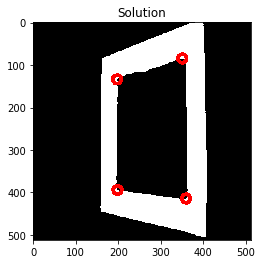

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6910 (1).png
[{'area': 6370, 'centroid': (258, 304), 'corners': array([[255.49968, 255.48659],
       [240.15204, 237.15437],
       [281.68192, 252.21007],
       [237.2924 , 365.55807],
       [273.6111 , 365.6111 ]], dtype=float32)}, {'area': 13986, 'centroid': (258, 305), 'corners': array([[255.49959, 255.48651],
       [225.48308, 204.54987],
       [295.391  , 232.51971],
       [222.32845, 394.67007],
       [294.96875, 393.209  ]], dtype=float32)}]


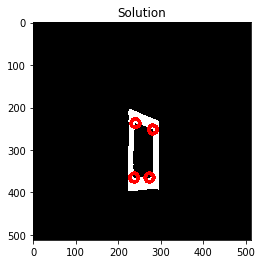

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2038.png
[{'area': 10496, 'centroid': (301, 264), 'corners': array([[255.48737, 255.49759],
       [261.71997, 201.34875],
       [340.73077, 203.74788],
       [262.3284 , 326.67004],
       [341.16287, 325.91663]], dtype=float32)}, {'area': 22302, 'centroid': (302, 265), 'corners': array([[255.48688, 255.49745],
       [244.32994, 169.32845],
       [360.1812 , 175.81879],
       [244.83704, 357.91696],
       [363.87613, 355.14758]], dtype=float32)}]


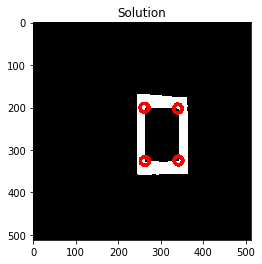

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8025.png
[{'area': 16700, 'centroid': (170, 292), 'corners': array([[255.52328, 255.4897 ],
       [221.18123, 208.81877],
       [123.34876, 214.71996],
       [119.32996, 372.67157],
       [218.60234, 375.6708 ]], dtype=float32)}, {'area': 36150, 'centroid': (169, 295), 'corners': array([[255.52383 , 255.48901 ],
       [241.20338 , 173.28644 ],
       [ 97.328445, 184.32994 ],
       [ 92.8372  , 407.9167  ],
       [243.18121 , 415.1812  ]], dtype=float32)}]


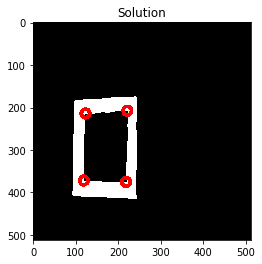

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8489.png
[{'area': 5100, 'centroid': (243, 276), 'corners': array([[255.50371, 255.49455],
       [222.3379 , 225.75253],
       [268.50842, 232.53468],
       [220.80634, 325.9087 ],
       [265.44   , 322.4527 ]], dtype=float32)}, {'area': 11324, 'centroid': (244, 277), 'corners': array([[255.50311, 255.49417],
       [207.55614, 203.80757],
       [281.9167 , 211.8372 ],
       [281.4241 , 344.42407],
       [208.76212, 353.69452]], dtype=float32)}]


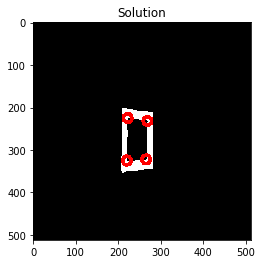

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4610.png
[{'area': 9867, 'centroid': (233, 251), 'corners': array([[255.50577, 255.50154],
       [262.70657, 178.44144],
       [200.44717, 189.68405],
       [203.68407, 317.55283],
       [266.55865, 320.7064 ]], dtype=float32)}, {'area': 22032, 'centroid': (232, 252), 'corners': array([[255.5062 , 255.50114],
       [279.7728 , 142.46973],
       [180.7816 , 161.7816 ],
       [185.36432, 354.88123],
       [278.7605 , 361.6122 ]], dtype=float32)}]


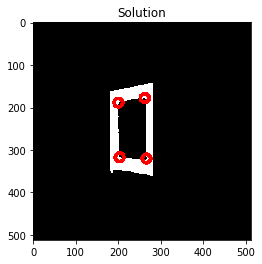

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3639.png
[{'area': 2583, 'centroid': (224, 250), 'corners': array([[255.50859, 255.50151],
       [205.32997, 220.32841],
       [243.16339, 221.08372],
       [205.08336, 279.16284],
       [242.28711, 280.34036]], dtype=float32)}, {'area': 5428, 'centroid': (224, 251), 'corners': array([[255.50838, 255.50117],
       [195.83719, 205.08333],
       [253.91667, 207.83719],
       [195.44196, 295.7076 ],
       [253.65111, 296.28024]], dtype=float32)}]


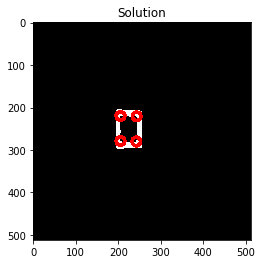

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3728.png
[{'area': 17227, 'centroid': (411, 279), 'corners': array([[255.45659, 255.49371],
       [459.16302, 197.08336],
       [358.83652, 208.08357],
       [361.32993, 354.67154],
       [463.16348, 356.9164 ]], dtype=float32)}, {'area': 38955, 'centroid': (414, 279), 'corners': array([[255.4568 , 255.4943 ],
       [483.60242, 152.32922],
       [333.0924 , 164.43048],
       [341.64038, 391.34335],
       [492.1812 , 398.1812 ]], dtype=float32)}]


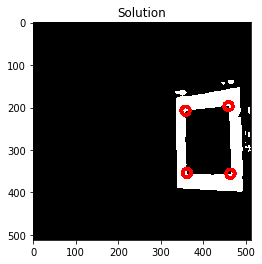

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2055.png
[{'area': 24600, 'centroid': (248, 246), 'corners': array([[255.50166, 255.50298],
       [194.42226, 142.56943],
       [308.91663, 159.83713],
       [189.32855, 342.67017],
       [308.42407, 340.42407]], dtype=float32)}, {'area': 52569, 'centroid': (247, 248), 'corners': array([[255.50304 , 255.5037  ],
       [164.1657  ,  92.56857 ],
       [335.18677 , 121.089195],
       [339.3911  , 380.48044 ],
       [160.10666 , 390.22964 ]], dtype=float32)}]


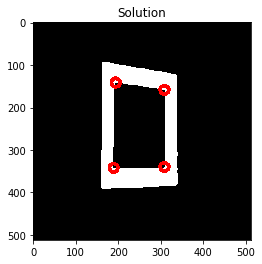

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9734.png
[{'area': 7630, 'centroid': (256, 277), 'corners': array([[255.49965, 255.49402],
       [222.85211, 224.12422],
       [289.91663, 224.83707],
       [222.77895, 329.57974],
       [290.6507 , 330.28094]], dtype=float32)}, {'area': 16380, 'centroid': (256, 277), 'corners': array([[255.49959, 255.49382],
       [307.1812 , 199.81879],
       [204.49155, 204.5345 ],
       [310.13126, 351.707  ],
       [206.75772, 355.21646]], dtype=float32)}]


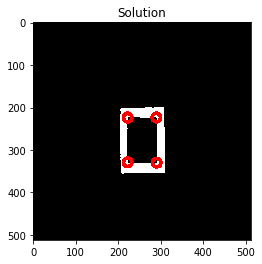

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3086.png
[{'area': 7208, 'centroid': (254, 291), 'corners': array([[255.50049, 255.49033],
       [233.35646, 220.81761],
       [279.37622, 237.90166],
       [232.5345 , 354.50842],
       [279.21835, 353.21832]], dtype=float32)}, {'area': 16160, 'centroid': (255, 292), 'corners': array([[255.50056, 255.4905 ],
       [217.42897, 182.33128],
       [294.70328, 216.27423],
       [297.42407, 382.42407],
       [216.32845, 385.67007]], dtype=float32)}]


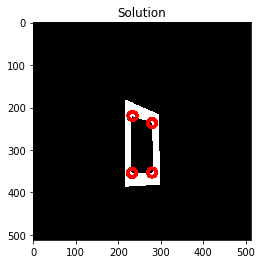

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7912.png
[{'area': 55611, 'centroid': (279, 256), 'corners': array([[255.49196, 255.50089],
       [354.30878,  82.47381],
       [194.84567, 130.67476],
       [195.82874, 395.90347],
       [358.16293, 416.91696]], dtype=float32)}, {'area': 126500, 'centroid': (286, 256), 'corners': array([[255.49281  , 255.49576  ],
       [372.18124  ,   1.1812328],
       [158.76889  ,  82.288376 ],
       [155.81319  , 446.91083  ],
       [403.81726  , 505.45212  ]], dtype=float32)}]


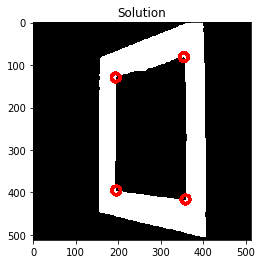

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3920.png
[{'area': 13013, 'centroid': (215, 264), 'corners': array([[255.51099, 255.49759],
       [172.68999, 193.12634],
       [258.1869 , 196.08919],
       [259.67004, 331.6716 ],
       [168.82109, 331.4913 ]], dtype=float32)}, {'area': 28380, 'centroid': (216, 264), 'corners': array([[255.51096, 255.49763],
       [152.3378 , 156.75226],
       [283.1543 , 170.67476],
       [283.67007, 363.67154],
       [151.30197, 372.54645]], dtype=float32)}]


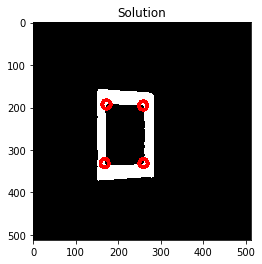

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5871.png
[{'area': 16170, 'centroid': (262, 253), 'corners': array([[255.49774, 255.50102],
       [309.6981 , 168.45348],
       [215.74144, 179.3273 ],
       [215.63142, 331.42746],
       [310.54916, 333.77322]], dtype=float32)}, {'area': 34648, 'centroid': (263, 254), 'corners': array([[255.4978 , 255.50082],
       [332.24234, 129.78363],
       [191.74825, 148.26918],
       [193.43785, 365.03436],
       [332.20264, 374.4174 ]], dtype=float32)}]


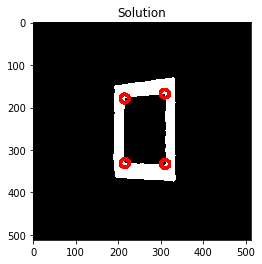

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0512.png
[{'area': 62685, 'centroid': (250, 225), 'corners': array([[255.5009  , 255.50897 ],
       [160.2952  ,  66.808205],
       [352.68185 ,  85.21004 ],
       [345.87326 , 371.31024 ],
       [156.32846 , 380.67007 ]], dtype=float32)}, {'area': 129600, 'centroid': (249, 224), 'corners': array([[255.49553  , 255.499    ],
       [127.666664 ,   0.6666667],
       [397.23108  ,  25.288368 ],
       [391.25983  , 432.36517  ],
       [108.46731  , 447.77408  ]], dtype=float32)}]


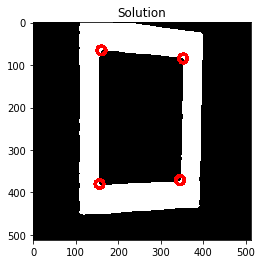

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6305.png
[{'area': 21728, 'centroid': (259, 315), 'corners': array([[255.49936, 255.48404],
       [207.81296, 215.08954],
       [313.15793, 232.56654],
       [204.65936, 406.5084 ],
       [316.46158, 405.4622 ]], dtype=float32)}, {'area': 49517, 'centroid': (258, 318), 'corners': array([[255.49979, 255.48367],
       [178.81879, 167.81879],
       [339.54913, 195.22685],
       [345.91696, 446.16296],
       [177.8384 , 461.65714]], dtype=float32)}]


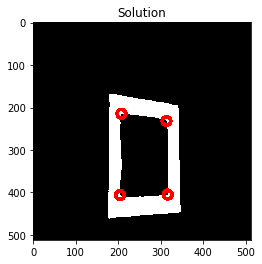

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2011.png
[{'area': 6600, 'centroid': (276, 258), 'corners': array([[255.49443, 255.49896],
       [244.55823, 209.5584 ],
       [307.87366, 212.68999],
       [245.09535, 307.1512 ],
       [306.16287, 306.91663]], dtype=float32)}, {'area': 13392, 'centroid': (276, 260), 'corners': array([[255.4941 , 255.4989 ],
       [230.71979, 187.34886],
       [323.16296, 190.08305],
       [230.49998, 330.27274],
       [322.26205, 330.39984]], dtype=float32)}]


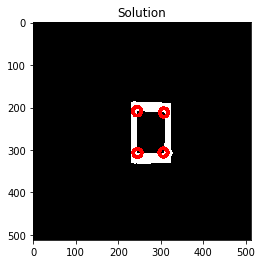

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6930.png
[{'area': 5684, 'centroid': (262, 222), 'corners': array([[255.49768, 255.50839],
       [282.48352, 162.46883],
       [238.69244, 183.83963],
       [282.21762, 276.59314],
       [248.5503 , 276.71863]], dtype=float32)}, {'area': 11523, 'centroid': (262, 221), 'corners': array([[255.49744, 255.51067],
       [295.58383, 131.26328],
       [228.0807 , 155.84   ],
       [295.16315, 298.9169 ],
       [227.8372 , 297.9167 ]], dtype=float32)}]


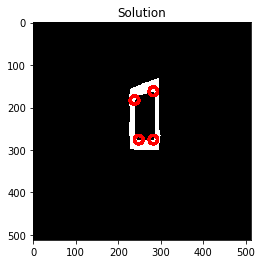

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8052.png
[]
file has only one shape


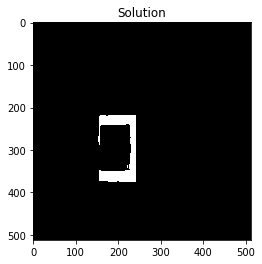

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3688.png
[{'area': 5400, 'centroid': (229, 272), 'corners': array([[255.50714, 255.49547],
       [201.3493 , 227.71906],
       [257.90906, 228.80695],
       [201.32841, 316.67004],
       [257.6507 , 315.28094]], dtype=float32)}, {'area': 11266, 'centroid': (230, 272), 'corners': array([[255.5068 , 255.49525],
       [187.08305, 207.83702],
       [272.9167 , 207.8372 ],
       [274.1812 , 336.1812 ],
       [189.75772, 340.21643]], dtype=float32)}]


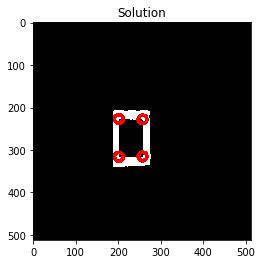

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9759.png
[{'area': 19720, 'centroid': (254, 239), 'corners': array([[255.50014, 255.5048 ],
       [201.32997, 155.32841],
       [309.65125, 155.71997],
       [196.67322, 318.46002],
       [311.16287, 321.91663]], dtype=float32)}, {'area': 41328, 'centroid': (256, 239), 'corners': array([[255.49986, 255.50447],
       [178.83852, 115.58057],
       [336.67154, 118.32993],
       [171.34886, 359.2802 ],
       [338.21732, 362.59302]], dtype=float32)}]


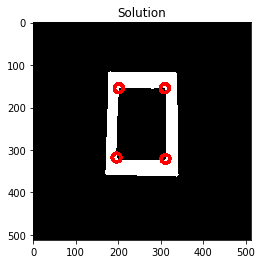

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3385.png
[{'area': 13072, 'centroid': (258, 250), 'corners': array([[255.49939, 255.50124],
       [216.83714, 177.08336],
       [299.19254, 177.55608],
       [299.91083, 316.1869 ],
       [217.3284 , 328.67   ]], dtype=float32)}, {'area': 29154, 'centroid': (258, 251), 'corners': array([[255.49884, 255.50052],
       [195.75772, 142.78354],
       [325.33252, 148.18413],
       [322.476  , 347.47604],
       [199.76208, 369.69455]], dtype=float32)}]


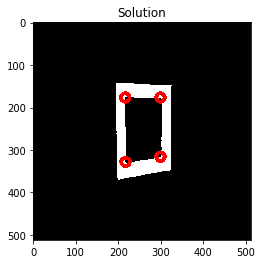

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3705.png
[{'area': 24444, 'centroid': (250, 288), 'corners': array([[255.50117, 255.491  ],
       [191.81294, 191.08958],
       [311.67145, 197.32983],
       [312.87326, 379.31024],
       [189.08336, 384.16284]], dtype=float32)}, {'area': 51870, 'centroid': (250, 289), 'corners': array([[255.5011 , 255.49066],
       [160.8188 , 146.81879],
       [340.67154, 155.32993],
       [345.39792, 419.7979 ],
       [160.83717, 431.91708]], dtype=float32)}]


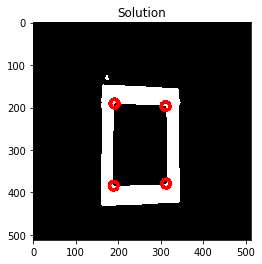

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8047 (1).png
[]
file has only one shape


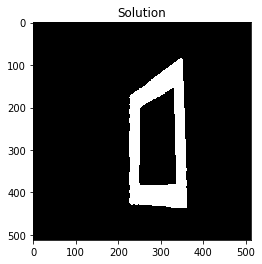

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1298.png
[{'area': 28215, 'centroid': (260, 278), 'corners': array([[255.49821, 255.49388],
       [200.2183 , 171.225  ],
       [325.7076 , 180.44196],
       [195.32855, 379.67017],
       [326.6507 , 378.28094]], dtype=float32)}, {'area': 59780, 'centroid': (261, 278), 'corners': array([[255.49821, 255.49374],
       [166.22754, 123.46949],
       [357.66217, 135.75223],
       [360.1628 , 423.9167 ],
       [163.83704, 428.91696]], dtype=float32)}]


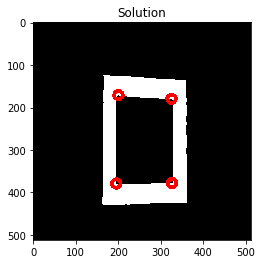

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7691 (1).png
[{'area': 27588, 'centroid': (275, 266), 'corners': array([[255.4953 , 255.49854],
       [222.15324, 143.72234],
       [333.81076, 179.27133],
       [216.83705, 368.91696],
       [335.90326, 367.1711 ]], dtype=float32)}, {'area': 61671, 'centroid': (273, 268), 'corners': array([[255.49602, 255.49869],
       [192.32991,  86.32847],
       [360.1868 , 140.08919],
       [366.65112, 416.28024],
       [183.81879, 423.1812 ]], dtype=float32)}]


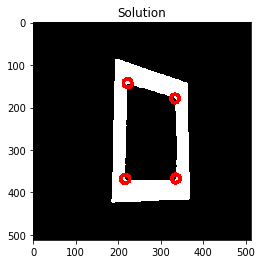

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9503.png
[{'area': 12696, 'centroid': (259, 293), 'corners': array([[255.49863, 255.48943],
       [218.08917, 226.81311],
       [304.67157, 230.32997],
       [216.81313, 358.91083],
       [299.4664 , 362.69067]], dtype=float32)}, {'area': 26600, 'centroid': (260, 295), 'corners': array([[255.49863, 255.48915],
       [198.83719, 196.08333],
       [325.9093 , 200.80719],
       [196.53452, 390.50842],
       [322.96875, 395.209  ]], dtype=float32)}]


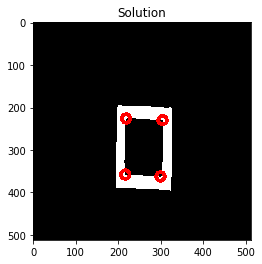

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9148.png
[{'area': 4738, 'centroid': (210, 277), 'corners': array([[255.51329, 255.49399],
       [192.8609 , 226.0785 ],
       [232.31532, 235.35863],
       [188.38889, 321.6111 ],
       [227.14789, 325.87573]], dtype=float32)}, {'area': 10863, 'centroid': (210, 279), 'corners': array([[255.51308, 255.49387],
       [183.16583, 198.56853],
       [245.55283, 218.68405],
       [242.2184 , 348.2184 ],
       [177.80168, 354.69174]], dtype=float32)}]


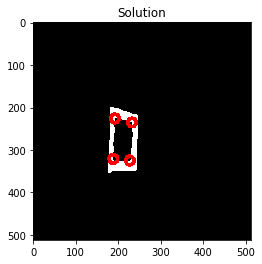

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1864.png
[{'area': 3024, 'centroid': (274, 290), 'corners': array([[257.56595, 255.77922],
       [289.66214, 248.75229],
       [257.566  , 255.77908],
       [289.6512 , 330.28012],
       [266.54544, 330.5909 ]], dtype=float32)}, {'area': 6375, 'centroid': (274, 290), 'corners': array([[257.56595, 255.77922],
       [298.67004, 226.32841],
       [249.83972, 235.26099],
       [250.32732, 348.25836],
       [297.66443, 353.2973 ]], dtype=float32)}]


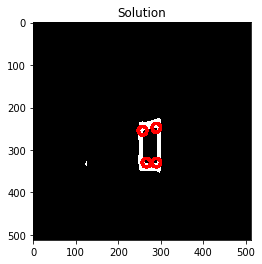

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3329.png
[]
file has only one shape


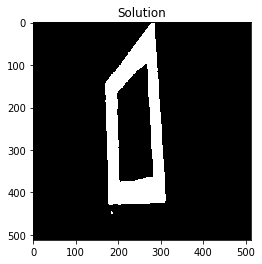

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6434.png
[{'area': 35649, 'centroid': (265, 269), 'corners': array([[255.49731, 255.49622],
       [337.5492 , 154.87445],
       [193.16658, 155.26068],
       [340.87576, 380.1479 ],
       [192.22893, 385.805  ]], dtype=float32)}, {'area': 75484, 'centroid': (264, 272), 'corners': array([[255.49739 , 255.49574 ],
       [372.18115 , 104.818855],
       [156.32845 , 107.32994 ],
       [378.67154 , 433.67007 ],
       [155.22581 , 439.53265 ]], dtype=float32)}]


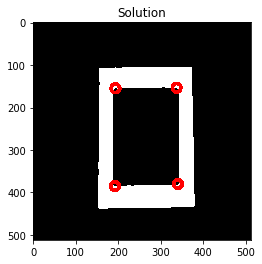

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9028.png
[{'area': 48094, 'centroid': (190, 247), 'corners': array([[255.51904, 255.50389],
       [113.08918, 102.81319],
       [276.42407, 129.57594],
       [272.50842, 374.34048],
       [107.31032, 380.57462]], dtype=float32)}, {'area': 106335, 'centroid': (186, 248), 'corners': array([[255.52028 , 255.50426 ],
       [ 72.55533 ,  29.190006],
       [312.9167  ,  82.8372  ],
       [314.65112 , 428.28024 ],
       [ 59.71981 , 446.65115 ]], dtype=float32)}]


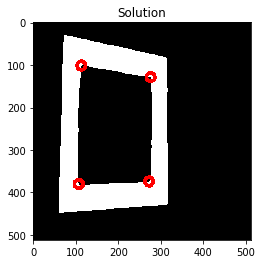

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5026.png
[{'area': 15000, 'centroid': (257, 285), 'corners': array([[255.49945, 255.49162],
       [211.81296, 212.08954],
       [305.16016, 214.26067],
       [208.26065, 356.83337],
       [303.67004, 358.6716 ]], dtype=float32)}, {'area': 31104, 'centroid': (258, 287), 'corners': array([[255.49918, 255.49107],
       [188.32994, 180.32845],
       [330.71356, 182.7966 ],
       [187.60225, 396.2484 ],
       [328.18704, 393.9105 ]], dtype=float32)}]


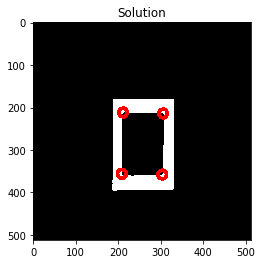

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6051.png
[]
file has only one shape


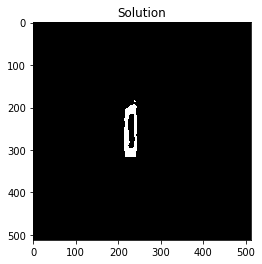

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0609.png
[{'area': 5184, 'centroid': (269, 255), 'corners': array([[255.49603, 255.50029],
       [290.2385 , 200.30534],
       [247.08336, 205.83714],
       [247.83713, 305.91663],
       [290.20334, 310.71356]], dtype=float32)}, {'area': 12062, 'centroid': (268, 256), 'corners': array([[255.49608, 255.49997],
       [304.67004, 175.32841],
       [231.57585, 185.57585],
       [230.54147, 332.47018],
       [302.2827 , 340.68018]], dtype=float32)}]


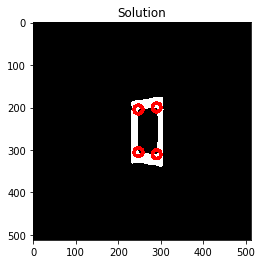

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8614.png
[]
file has only one shape


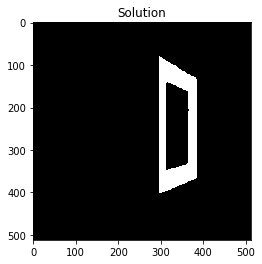

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5701.png
[{'area': 7776, 'centroid': (234, 278), 'corners': array([[255.5055 , 255.49355],
       [200.81877, 225.81877],
       [269.77405, 227.4514 ],
       [200.8369 , 330.91687],
       [270.54648, 330.69806]], dtype=float32)}, {'area': 16275, 'centroid': (235, 280), 'corners': array([[255.50557, 255.4932 ],
       [184.08922, 203.81322],
       [287.209  , 204.03123],
       [184.3429 , 358.49707],
       [287.21643, 356.24228]], dtype=float32)}]


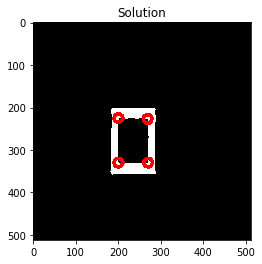

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9100.png
[{'area': 45920, 'centroid': (236, 253), 'corners': array([[255.50656, 255.50214],
       [169.15   , 100.54487],
       [315.87573, 142.85213],
       [310.67273, 381.25858],
       [159.4699 , 387.36252]], dtype=float32)}, {'area': 103095, 'centroid': (231, 254), 'corners': array([[255.50766 , 255.50299 ],
       [131.94875 ,  21.035706],
       [351.3151  , 100.35854 ],
       [350.42416 , 434.42416 ],
       [116.29227 , 458.55798 ]], dtype=float32)}]


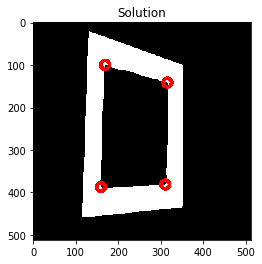

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9899.png
[{'area': 8664, 'centroid': (334, 276), 'corners': array([[255.4783 , 255.49423],
       [298.08313, 220.8369 ],
       [370.67157, 221.32997],
       [297.71948, 330.65097],
       [370.44   , 332.45267]], dtype=float32)}, {'area': 17767, 'centroid': (335, 277), 'corners': array([[255.47795, 255.49396],
       [389.91696, 195.83704],
       [281.86087, 198.07849],
       [279.74017, 355.3652 ],
       [389.67154, 359.67007]], dtype=float32)}]


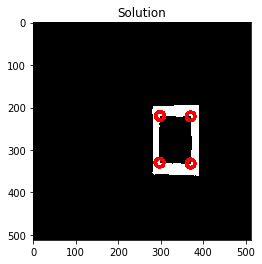

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5934.png
[{'area': 4876, 'centroid': (237, 263), 'corners': array([[259.00043, 250.49997],
       [257.1136 , 210.31746],
       [215.00552, 220.56693],
       [217.85213, 313.87576],
       [257.8159 , 315.3325 ]], dtype=float32)}, {'area': 11304, 'centroid': (236, 265), 'corners': array([[259.00043, 250.49997],
       [270.1812 , 185.81879],
       [200.26077, 201.1663 ],
       [270.38885, 342.4933 ],
       [201.24542, 342.4699 ]], dtype=float32)}]


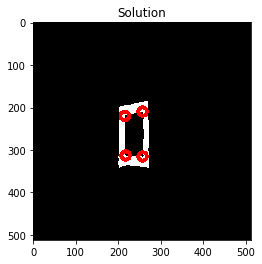

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7753.png
[{'area': 16320, 'centroid': (257, 286), 'corners': array([[255.49866, 255.49194],
       [294.12225, 186.71765],
       [215.84567, 211.67476],
       [219.77177, 373.41394],
       [297.60236, 378.6708 ]], dtype=float32)}, {'area': 37211, 'centroid': (258, 286), 'corners': array([[255.49835, 255.49124],
       [315.07437, 133.25815],
       [194.49615, 181.59067],
       [195.73236, 408.3155 ],
       [319.67422, 427.6056 ]], dtype=float32)}]


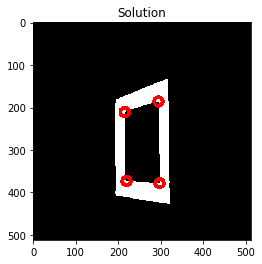

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4225.png
[{'area': 10416, 'centroid': (249, 237), 'corners': array([[255.50177, 255.50499],
       [228.5    , 155.99956],
       [281.50385, 168.59068],
       [280.90347, 306.1713 ],
       [220.86977, 321.20593]], dtype=float32)}, {'area': 24153, 'centroid': (249, 238), 'corners': array([[255.50282, 255.50485],
       [202.44556, 114.60635],
       [300.24765, 140.33784],
       [298.1712 , 338.90326],
       [208.54546, 362.5909 ]], dtype=float32)}]


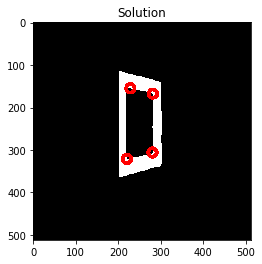

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1585.png
[{'area': 20532, 'centroid': (250, 297), 'corners': array([[255.50131, 255.48874],
       [200.27162, 206.60553],
       [306.42416, 214.57584],
       [193.08336, 382.16284],
       [306.67004, 381.6716 ]], dtype=float32)}, {'area': 43860, 'centroid': (250, 298), 'corners': array([[255.50117, 255.48825],
       [168.30545, 168.76218],
       [334.9093 , 175.80719],
       [334.65112, 423.28024],
       [166.8075 , 426.44394]], dtype=float32)}]


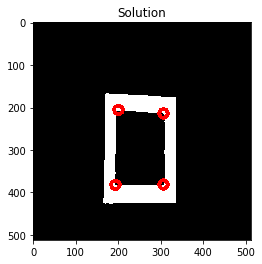

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2881.png
[{'area': 2728, 'centroid': (255, 313), 'corners': array([[253.1852 , 251.83624],
       [267.81766, 269.53625],
       [240.55614, 276.80762],
       [268.91663, 354.16287],
       [243.28839, 354.23114]], dtype=float32)}, {'area': 6157, 'centroid': (253, 314), 'corners': array([[253.18518, 251.83626],
       [276.19794, 245.71086],
       [231.49023, 258.5499 ],
       [229.09099, 375.1935 ],
       [274.41623, 379.45462]], dtype=float32)}]


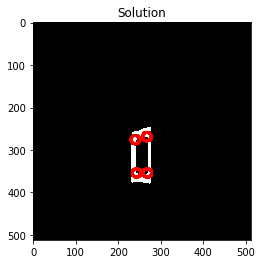

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8650 (1).png
[]
file has only one shape


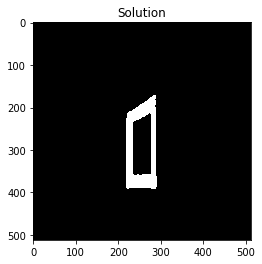

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2944.png
[]
file has only one shape


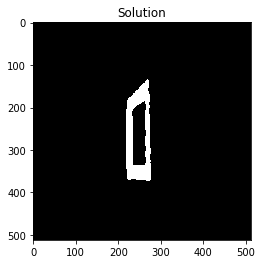

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2709.png
[{'area': 13113, 'centroid': (250, 319), 'corners': array([[255.50145, 255.48262],
       [291.89893, 248.78728],
       [205.57593, 251.57593],
       [295.31024, 386.87326],
       [204.71997, 387.65125]], dtype=float32)}, {'area': 28912, 'centroid': (251, 321), 'corners': array([[255.50131, 255.48207],
       [315.2034 , 215.28644],
       [184.32845, 222.32994],
       [320.9093 , 421.1928 ],
       [183.60225, 424.2484 ]], dtype=float32)}]


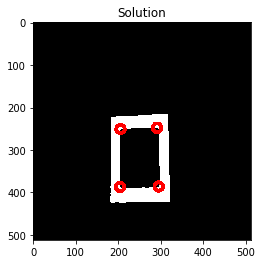

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8112 (1).png
[]
file has only one shape


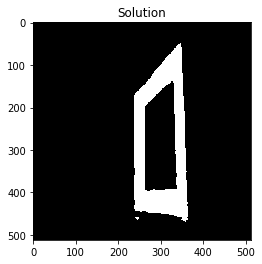

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6726.png
[]
file has only one shape


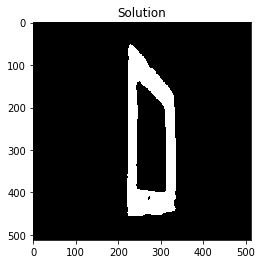

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2311.png
[{'area': 7412, 'centroid': (234, 322), 'corners': array([[255.50594, 255.48141],
       [266.6981 , 268.4535 ],
       [200.76884, 274.2884 ],
       [265.20322, 374.71362],
       [200.83713, 374.91663]], dtype=float32)}, {'area': 16274, 'centroid': (233, 324), 'corners': array([[255.50604, 255.48105],
       [283.1812 , 244.81879],
       [182.56874, 252.1655 ],
       [284.67154, 399.67007],
       [184.38573, 402.8058 ]], dtype=float32)}]


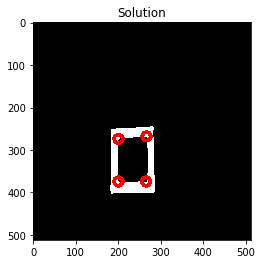

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0938.png
[{'area': 10707, 'centroid': (229, 329), 'corners': array([[255.50714, 255.47981],
       [268.74243, 265.6946 ],
       [190.55995, 267.5473 ],
       [190.28839, 390.23117],
       [270.18124, 393.18124]], dtype=float32)}, {'area': 23086, 'centroid': (228, 330), 'corners': array([[255.50763, 255.4794 ],
       [286.67007, 233.32845],
       [169.34546, 241.34294],
       [169.08305, 420.16296],
       [286.50262, 427.31625]], dtype=float32)}]


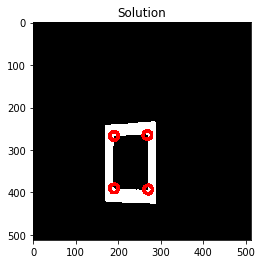

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7091 (1).png
[{'area': 29607, 'centroid': (246, 277), 'corners': array([[255.50269, 255.49402],
       [182.53119, 168.63953],
       [310.48044, 177.60889],
       [177.55995, 379.4527 ],
       [313.21835, 379.21832]], dtype=float32)}, {'area': 63444, 'centroid': (245, 279), 'corners': array([[255.50293, 255.49422],
       [150.8188 , 118.8188 ],
       [343.24228, 136.78357],
       [346.21732, 427.59302],
       [142.81879, 430.1812 ]], dtype=float32)}]


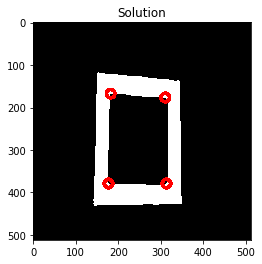

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6387.png
[{'area': 14647, 'centroid': (234, 309), 'corners': array([[255.50594, 255.48526],
       [189.32994, 233.32843],
       [282.32504, 242.63553],
       [188.83983, 382.73935],
       [280.21835, 380.21832]], dtype=float32)}, {'area': 31240, 'centroid': (233, 311), 'corners': array([[255.50598, 255.48476],
       [165.8188 , 198.81879],
       [303.16327, 209.08328],
       [305.2184 , 416.2184 ],
       [161.56874, 418.8345 ]], dtype=float32)}]


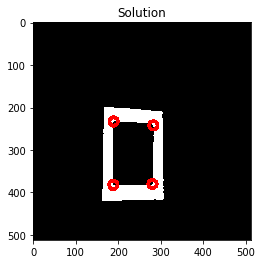

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3153.png
[{'area': 42000, 'centroid': (212, 234), 'corners': array([[255.51163, 255.50668],
       [288.83218, 106.26028],
       [136.35852, 121.68504],
       [295.69177, 350.39346],
       [128.81296, 353.91046]], dtype=float32)}, {'area': 91113, 'centroid': (214, 236), 'corners': array([[255.51154 , 255.50626 ],
       [328.1628  ,  49.08332 ],
       [ 98.818794,  62.818794],
       [338.67154 , 408.67007 ],
       [ 88.33781 , 411.24777 ]], dtype=float32)}]


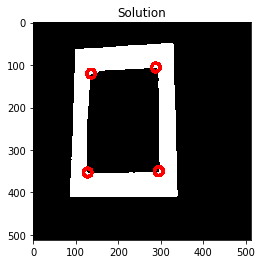

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6673.png
[{'area': 6048, 'centroid': (240, 298), 'corners': array([[255.50359, 255.4884 ],
       [260.4447 , 233.19002],
       [218.09654, 247.82872],
       [263.1312 , 356.70728],
       [219.53825, 355.46207]], dtype=float32)}, {'area': 13359, 'centroid': (239, 300), 'corners': array([[255.50398, 255.4882 ],
       [272.77246, 203.46948],
       [203.49998, 225.72728],
       [204.1655 , 384.43124],
       [275.4302 , 386.57825]], dtype=float32)}]


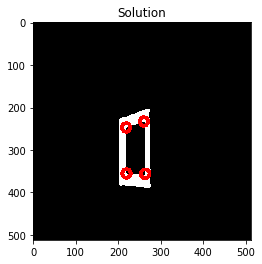

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9725.png
[{'area': 13395, 'centroid': (247, 199), 'corners': array([[255.50206, 255.51532],
       [205.56004, 129.54732],
       [294.39102, 136.5197 ],
       [201.60016, 264.262  ],
       [291.67004, 267.6716 ]], dtype=float32)}, {'area': 27948, 'centroid': (248, 199), 'corners': array([[255.502  , 255.51546],
       [183.83719,  98.08333],
       [314.96866, 101.79107],
       [180.32845, 295.67007],
       [312.7076 , 301.55804]], dtype=float32)}]


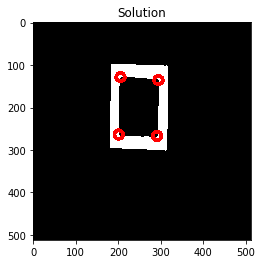

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6728 (1).png
[]
file has only one shape


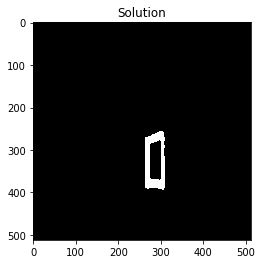

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8599 (1).png
[{'area': 4715, 'centroid': (233, 310), 'corners': array([[255.50601, 255.48451],
       [250.23491, 251.34866],
       [213.6161 , 265.455  ],
       [251.66217, 362.24774],
       [214.08336, 363.16327]], dtype=float32)}, {'area': 11560, 'centroid': (232, 311), 'corners': array([[255.50598, 255.48473],
       [261.7725 , 220.46954],
       [199.47934, 245.70827],
       [200.32993, 389.67154],
       [266.1812 , 391.1812 ]], dtype=float32)}]


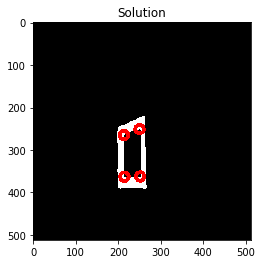

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4635.png
[{'area': 3192, 'centroid': (227, 249), 'corners': array([[255.50763, 255.50204],
       [241.57768, 207.56938],
       [210.78166, 211.78166],
       [244.16328, 289.9166 ],
       [212.08305, 288.16293]], dtype=float32)}, {'area': 7000, 'centroid': (226, 250), 'corners': array([[255.50783, 255.50179],
       [253.43112, 188.165  ],
       [199.57596, 193.57596],
       [203.20451, 311.44626],
       [253.60254, 312.67078]], dtype=float32)}]


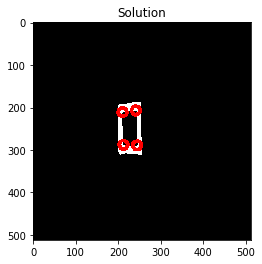

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1970.png
[{'area': 17220, 'centroid': (283, 260), 'corners': array([[255.49237, 255.49883],
       [333.90393, 177.84889],
       [233.35852, 181.68504],
       [334.14752, 340.8765 ],
       [230.08919, 338.1869 ]], dtype=float32)}, {'area': 38478, 'centroid': (284, 261), 'corners': array([[255.49231, 255.49869],
       [360.1812 , 136.81879],
       [207.81322, 148.08922],
       [204.57584, 376.42416],
       [363.28024, 378.65112]], dtype=float32)}]


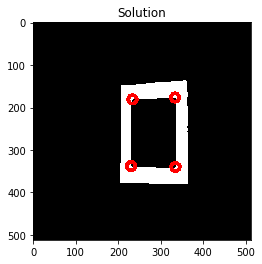

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6741 (1).png
[]
file has only one shape


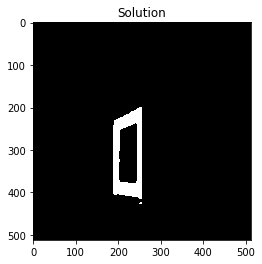

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9815.png
[{'area': 11704, 'centroid': (350, 260), 'corners': array([[255.47397, 255.49896],
       [307.78168, 194.78166],
       [392.3624 , 196.46986],
       [306.32788, 322.17014],
       [393.91083, 323.1869 ]], dtype=float32)}, {'area': 24768, 'centroid': (352, 260), 'corners': array([[255.47363, 255.49849],
       [414.18115, 164.81885],
       [288.0895 , 167.81297],
       [416.1812 , 355.1812 ],
       [288.8715 , 356.28387]], dtype=float32)}]


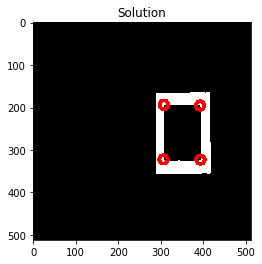

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1266.png
[{'area': 6552, 'centroid': (260, 280), 'corners': array([[255.49849, 255.49324],
       [232.81296, 229.08954],
       [290.67157, 232.32997],
       [232.16522, 331.4312 ],
       [290.67004, 329.6716 ]], dtype=float32)}, {'area': 13832, 'centroid': (261, 281), 'corners': array([[255.49835, 255.49278],
       [215.621  , 205.40424],
       [306.41205, 209.43195],
       [305.3685 , 355.42758],
       [217.08333, 357.1628 ]], dtype=float32)}]


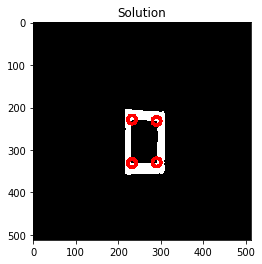

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2439.png
[]
file has only one shape


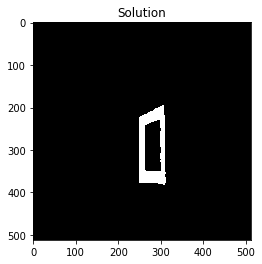

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8991.png
[]
file has only one shape


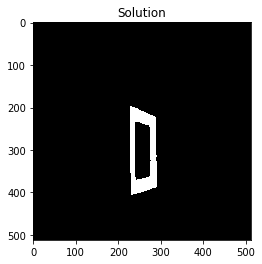

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8612.png
[]
file has only one shape


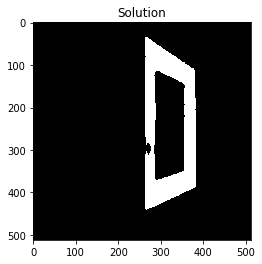

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9384.png
[{'area': 7597, 'centroid': (203, 268), 'corners': array([[255.514  , 255.49643],
       [171.85211, 216.12422],
       [238.18123, 218.81877],
       [170.08336, 319.16284],
       [238.18123, 320.18124]], dtype=float32)}, {'area': 15352, 'centroid': (204, 269), 'corners': array([[255.51387, 255.49608],
       [156.42177, 192.5698 ],
       [254.67155, 196.32994],
       [156.78233, 346.59317],
       [254.18121, 344.1812 ]], dtype=float32)}]


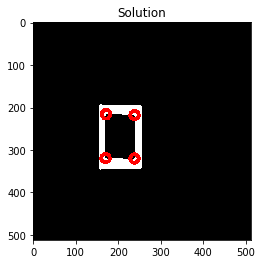

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7332 (1).png
[{'area': 37044, 'centroid': (202, 266), 'corners': array([[255.51399, 255.4982 ],
       [272.73077, 134.74838],
       [134.28017, 157.6886 ],
       [127.81295, 383.91046],
       [273.5217 , 386.05334]], dtype=float32)}, {'area': 82782, 'centroid': (204, 267), 'corners': array([[255.51358, 255.49883],
       [305.67   ,  70.32839],
       [101.76899, 113.28835],
       [ 90.6374 , 430.53   ],
       [310.1812 , 448.1812 ]], dtype=float32)}]


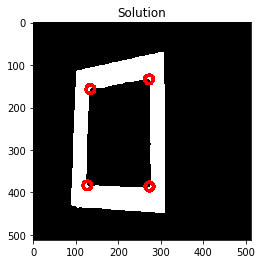

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6266.png
[{'area': 10125, 'centroid': (283, 309), 'corners': array([[255.49287, 255.48506],
       [249.42273, 240.6151 ],
       [319.71625, 255.9653 ],
       [246.30539, 373.23834],
       [313.6111 , 373.6111 ]], dtype=float32)}, {'area': 21780, 'centroid': (283, 311), 'corners': array([[255.49219, 255.485  ],
       [231.65755, 208.42125],
       [337.67154, 224.32993],
       [338.2378 , 402.69455],
       [229.32845, 407.67007]], dtype=float32)}]


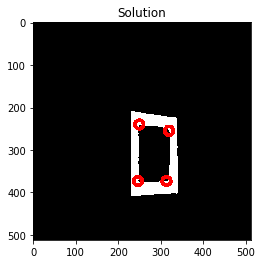

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3448.png
[{'area': 3082, 'centroid': (236, 343), 'corners': array([[255.50516, 255.47562],
       [256.9164 , 311.83652],
       [215.5378 , 313.53842],
       [258.18124, 375.18124],
       [216.32997, 375.67157]], dtype=float32)}, {'area': 6732, 'centroid': (236, 345), 'corners': array([[255.50522, 255.47562],
       [267.60248, 293.32916],
       [203.66858, 296.69992],
       [268.9167 , 392.1628 ],
       [204.83698, 394.91666]], dtype=float32)}]


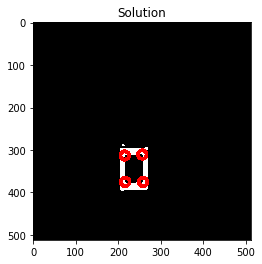

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8044.png
[{'area': 31020, 'centroid': (182, 271), 'corners': array([[254.00052, 256.50003],
       [250.72876, 162.18932],
       [113.78166, 164.78166],
       [110.56005, 379.4527 ],
       [249.64148, 382.31494]], dtype=float32)}, {'area': 68052, 'centroid': (181, 274), 'corners': array([[254.00052 , 256.50003 ],
       [ 80.575836, 118.575836],
       [285.9093  , 116.80718 ],
       [ 73.328445, 428.67007 ],
       [285.18115 , 435.18115 ]], dtype=float32)}]


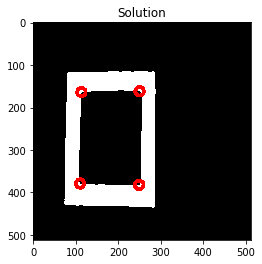

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0038.png
[{'area': 13728, 'centroid': (280, 300), 'corners': array([[255.49327, 255.4875 ],
       [234.07846, 230.86089],
       [325.1869 , 230.08919],
       [232.71906, 370.6507 ],
       [327.36258, 370.53006]], dtype=float32)}, {'area': 29400, 'centroid': (281, 302), 'corners': array([[255.49292, 255.48715],
       [348.24228, 196.78355],
       [213.81322, 200.08922],
       [351.24228, 406.21643],
       [212.7966 , 406.71356]], dtype=float32)}]


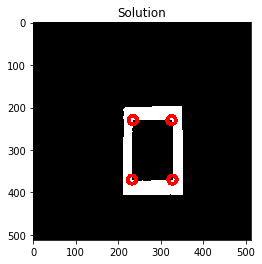

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7435.png
[]
file has only one shape


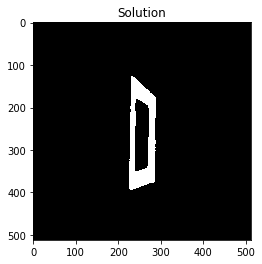

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2406.png
[]
file has only one shape


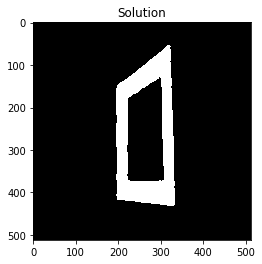

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0675.png
[]
file has only one shape


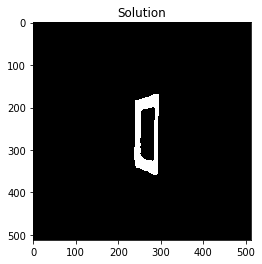

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7704.png
[{'area': 3560, 'centroid': (261, 290), 'corners': array([[255.49811, 255.49028],
       [280.2423 , 246.78363],
       [242.22595, 252.4514 ],
       [278.6716 , 332.67004],
       [243.8609 , 332.9215 ]], dtype=float32)}, {'area': 7552, 'centroid': (260, 291), 'corners': array([[255.49812, 255.49037],
       [289.42404, 226.57597],
       [231.75227, 235.33789],
       [232.81297, 350.9105 ],
       [289.67163, 354.66998]], dtype=float32)}]


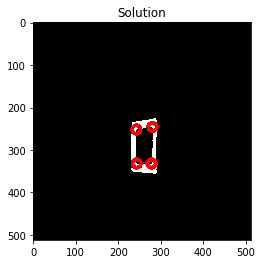

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8105.png
[{'area': 28776, 'centroid': (311, 229), 'corners': array([[255.48445 , 255.50748 ],
       [374.91077 , 119.813225],
       [246.83969 , 135.26091 ],
       [247.53998 , 330.32678 ],
       [374.1869  , 336.91083 ]], dtype=float32)}, {'area': 62400, 'centroid': (314, 230), 'corners': array([[255.48277 , 255.50838 ],
       [404.7242  ,  63.814396],
       [216.81322 ,  96.0892  ],
       [216.8372  , 370.9167  ],
       [407.1812  , 390.1812  ]], dtype=float32)}]


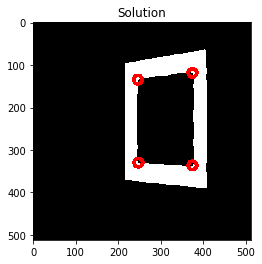

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7023.png
[{'area': 9702, 'centroid': (263, 277), 'corners': array([[255.49847, 255.49457],
       [232.3297 , 202.32869],
       [295.05325, 217.47812],
       [233.20676, 345.67838],
       [292.545  , 346.3839 ]], dtype=float32)}, {'area': 22248, 'centroid': (261, 278), 'corners': array([[255.49876, 255.49457],
       [213.33   , 163.32837],
       [313.20135, 194.30373],
       [212.32845, 378.67007],
       [314.41202, 378.56805]], dtype=float32)}]


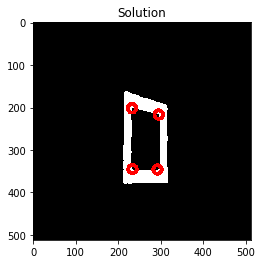

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6011.png
[]
file has only one shape


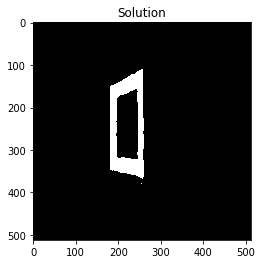

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3846.png
[{'area': 5369, 'centroid': (207, 304), 'corners': array([[255.51291, 255.48647],
       [180.5384 , 261.53778],
       [236.18123, 260.81876],
       [237.18123, 346.18124],
       [180.18414, 351.33252]], dtype=float32)}, {'area': 11172, 'centroid': (208, 306), 'corners': array([[255.51263, 255.4864 ],
       [171.67476, 236.84572],
       [251.25981, 243.63489],
       [251.1628 , 368.9167 ],
       [167.32845, 371.67007]], dtype=float32)}]


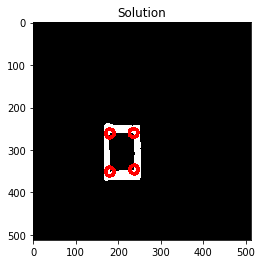

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9760.png
[{'area': 22932, 'centroid': (243, 246), 'corners': array([[255.50316, 255.50282],
       [187.77164, 154.5861 ],
       [301.75064, 154.5306 ],
       [181.08954, 334.18704],
       [306.67004, 334.6716 ]], dtype=float32)}, {'area': 49929, 'centroid': (244, 247), 'corners': array([[255.50296 , 255.50261 ],
       [331.18115 , 112.818855],
       [157.32845 , 115.32994 ],
       [339.21646 , 376.24228 ],
       [151.81879 , 379.1812  ]], dtype=float32)}]


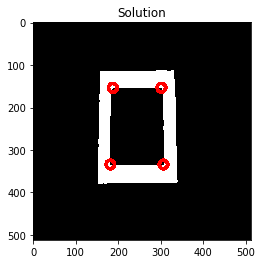

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1177.png
[]
file has only one shape


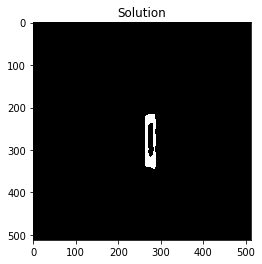

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9922.png
[{'area': 20470, 'centroid': (301, 248), 'corners': array([[255.48723, 255.50186],
       [354.3686 , 159.57254],
       [245.04962, 168.54472],
       [358.42407, 332.42407],
       [248.81296, 334.91046]], dtype=float32)}, {'area': 43264, 'centroid': (304, 249), 'corners': array([[255.48682, 255.50172],
       [383.1812 , 118.81878],
       [219.83702, 132.08305],
       [388.1812 , 372.1812 ],
       [223.7622 , 374.69455]], dtype=float32)}]


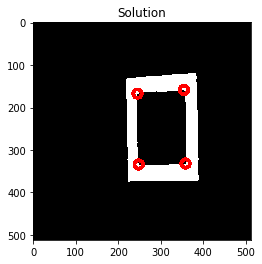

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9340.png
[{'area': 8103, 'centroid': (224, 269), 'corners': array([[255.50845, 255.49622],
       [189.57593, 214.57593],
       [260.3624 , 217.46986],
       [190.78166, 323.21832],
       [260.67004, 322.6716 ]], dtype=float32)}, {'area': 16800, 'centroid': (225, 269), 'corners': array([[255.5081 , 255.49594],
       [173.83719, 190.08333],
       [277.67154, 192.32993],
       [175.73247, 351.3155 ],
       [278.1812 , 348.1812 ]], dtype=float32)}]


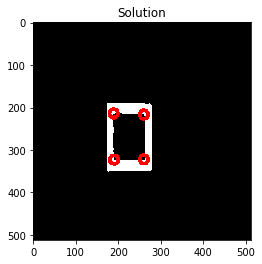

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2081.png
[{'area': 26061, 'centroid': (246, 250), 'corners': array([[255.5034 , 255.50246],
       [195.47656, 134.07762],
       [305.3839 , 164.455  ],
       [189.08336, 353.16284],
       [303.1479 , 350.87576]], dtype=float32)}, {'area': 58275, 'centroid': (243, 251), 'corners': array([[255.5042 , 255.50307],
       [163.32996,  75.32842],
       [331.47842, 125.47338],
       [334.3626 , 393.53   ],
       [159.83986, 408.73935]], dtype=float32)}]


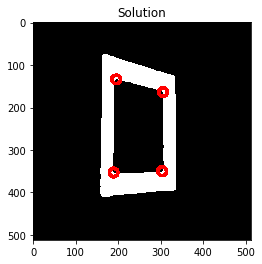

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7390 (1).png
[{'area': 36057, 'centroid': (257, 273), 'corners': array([[255.49861, 255.49335],
       [307.6441 , 107.8888 ],
       [197.44719, 170.68402],
       [200.61041, 406.6117 ],
       [314.5656 , 413.30923]], dtype=float32)}]
file has only one shape


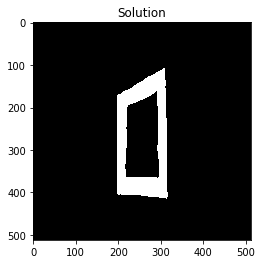

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6543.png
[{'area': 46200, 'centroid': (292, 266), 'corners': array([[255.48882, 255.49838],
       [368.53806, 121.36939],
       [211.91956, 150.57497],
       [207.83713, 393.91663],
       [374.4552 , 395.95032]], dtype=float32)}, {'area': 103000, 'centroid': (297, 267), 'corners': array([[255.4874  , 255.49867 ],
       [407.70673 ,  50.44155 ],
       [174.32841 , 102.329956],
       [172.0311  , 450.20905 ],
       [422.1812  , 463.1812  ]], dtype=float32)}]


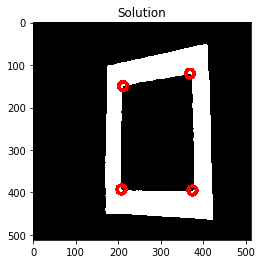

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6890 (1).png
[{'area': 23940, 'centroid': (235, 257), 'corners': array([[255.50618, 255.49782],
       [198.63666, 119.89865],
       [280.21527, 167.72777],
       [190.08336, 371.16302],
       [275.32526, 370.15433]], dtype=float32)}]
file has only one shape


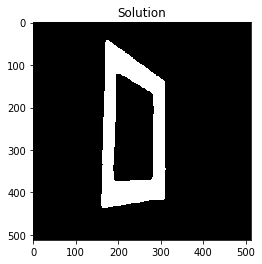

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8720.png
[{'area': 15444, 'centroid': (277, 275), 'corners': array([[255.49402, 255.4945 ],
       [232.35863, 196.68468],
       [324.44006, 203.54729],
       [228.81877, 351.18124],
       [323.67007, 349.67154]], dtype=float32)}, {'area': 32688, 'centroid': (277, 276), 'corners': array([[255.49374, 255.49423],
       [209.33002, 161.32837],
       [348.67154, 172.32993],
       [348.67007, 383.67154],
       [206.75772, 389.21643]], dtype=float32)}]


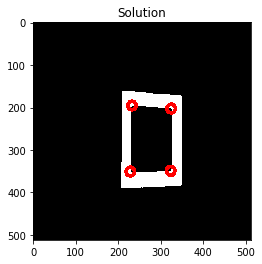

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8837.png
[{'area': 69700, 'centroid': (221, 276), 'corners': array([[255.50871, 255.4951 ],
       [128.68588, 103.93212],
       [324.67154, 129.32991],
       [326.91925, 424.16   ],
       [123.83999, 443.91928]], dtype=float32)}, {'area': 152579, 'centroid': (218, 276), 'corners': array([[255.50453 , 255.50636 ],
       [ 79.17935 ,  14.635258],
       [366.16296 ,  72.08302 ],
       [374.53015 , 488.36243 ],
       [ 87.666664, 510.33334 ]], dtype=float32)}]


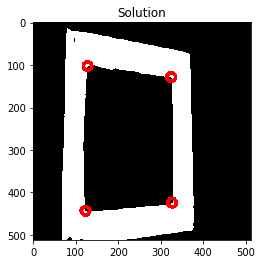

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7180 (1).png
[{'area': 8066, 'centroid': (277, 309), 'corners': array([[255.49382, 255.48523],
       [243.68999, 256.12634],
       [314.33252, 257.18414],
       [242.83661, 361.9163 ],
       [311.67004, 361.6716 ]], dtype=float32)}, {'area': 17172, 'centroid': (278, 310), 'corners': array([[255.49368, 255.48476],
       [226.08305, 231.83702],
       [332.33252, 233.18413],
       [224.81879, 389.1812 ],
       [331.16302, 389.91666]], dtype=float32)}]


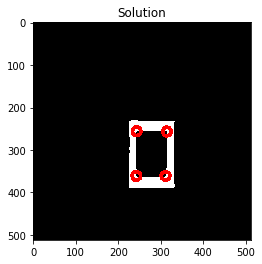

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8077 (1).png
[]
file has only one shape


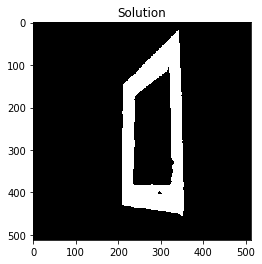

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8329 (1).png
[{'area': 24079, 'centroid': (207, 267), 'corners': array([[255.51416, 255.4975 ],
       [154.5525 , 163.26938],
       [266.39102, 188.51968],
       [147.84889, 357.90393],
       [265.18704, 359.91046]], dtype=float32)}, {'area': 51507, 'centroid': (205, 269), 'corners': array([[255.51471 , 255.49757 ],
       [126.227196, 114.46973 ],
       [292.18115 , 151.81885 ],
       [295.67007 , 401.67154 ],
       [118.79656 , 406.71353 ]], dtype=float32)}]


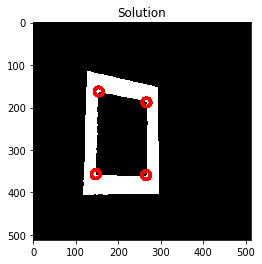

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8106.png
[{'area': 34080, 'centroid': (308, 233), 'corners': array([[255.4854 , 255.50653],
       [377.67004, 112.32843],
       [237.12634, 129.68999],
       [237.69455, 341.7423 ],
       [374.0918 , 352.60107]], dtype=float32)}, {'area': 74613, 'centroid': (312, 233), 'corners': array([[255.48274, 255.50708],
       [412.7728 ,  51.46973],
       [205.81322,  87.0892 ],
       [204.81879, 386.1812 ],
       [412.6715 , 409.6701 ]], dtype=float32)}]


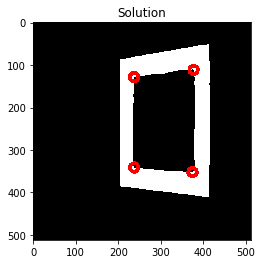

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5437.png
[]
file has only one shape


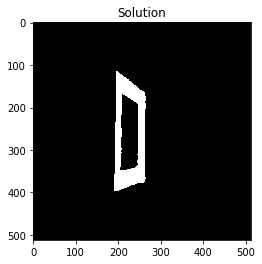

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7010 (1).png
[{'area': 47472, 'centroid': (231, 246), 'corners': array([[255.50745, 255.50426],
       [155.83998, 101.08074],
       [315.1391 , 129.07846],
       [146.32855, 375.67017],
       [315.56232, 374.03455]], dtype=float32)}, {'area': 105627, 'centroid': (227, 247), 'corners': array([[255.50853 , 255.50475 ],
       [115.81879 ,  28.818787],
       [350.9167  ,  81.8372  ],
       [357.42416 , 430.42416 ],
       [100.43196 , 439.41202 ]], dtype=float32)}]


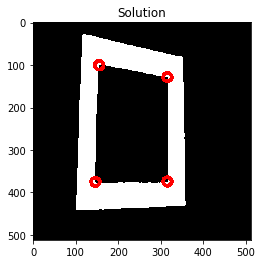

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6632.png
[{'area': 8400, 'centroid': (228, 293), 'corners': array([[255.50677, 255.48969],
       [254.23201, 221.17381],
       [201.00552, 237.56693],
       [258.80716, 358.12146],
       [204.20212, 359.39795]], dtype=float32)}, {'area': 18564, 'centroid': (228, 294), 'corners': array([[255.50688, 255.48972],
       [271.18124, 187.81877],
       [183.0785 , 212.8609 ],
       [184.68091, 389.60516],
       [270.42618, 394.57608]], dtype=float32)}]


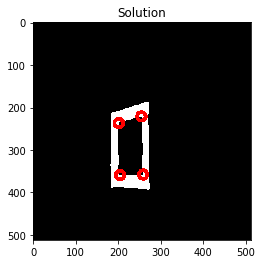

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1966.png
[{'area': 7739, 'centroid': (254, 273), 'corners': array([[255.50041, 255.49506],
       [287.67004, 220.32841],
       [220.32841, 223.32997],
       [287.8759 , 324.1479 ],
       [220.83713, 325.91663]], dtype=float32)}, {'area': 16536, 'centroid': (254, 274), 'corners': array([[255.50035, 255.49484],
       [303.187  , 194.08951],
       [202.30545, 200.7622 ],
       [306.14993, 350.9047 ],
       [205.44275, 352.2853 ]], dtype=float32)}]


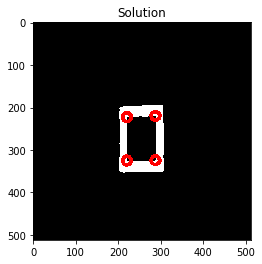

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3712.png
[{'area': 28222, 'centroid': (344, 287), 'corners': array([[255.47575, 255.49141],
       [407.90393, 183.84889],
       [277.09094, 189.80695],
       [411.23114, 385.7116 ],
       [278.08917, 386.1869 ]], dtype=float32)}, {'area': 60900, 'centroid': (347, 288), 'corners': array([[255.47528, 255.49121],
       [440.67007, 135.32845],
       [245.81879, 145.8188 ],
       [247.81879, 434.1812 ],
       [448.1812 , 435.1812 ]], dtype=float32)}, {'area': 357, 'centroid': (258, 129), 'corners': array([[255.49927, 255.53386],
       [256.85828, 117.34532],
       [250.08308, 131.50285],
       [268.15363, 133.2384 ],
       [259.79077, 139.08691]], dtype=float32)}, {'area': 255, 'centroid': (427, 114), 'corners': array([[255.4504  , 255.54095 ],
       [428.80725 , 104.752785],
       [435.11172 , 113.54015 ],
       [420.10526 , 115.42105 ],
       [422.31735 , 12

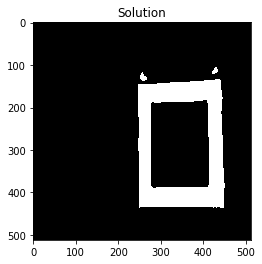

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5237.png
[{'area': 4074, 'centroid': (191, 310), 'corners': array([[255.5176 , 255.48457],
       [210.16333, 261.28888],
       [171.44717, 269.68405],
       [172.08917, 354.18686],
       [209.60234, 358.6708 ]], dtype=float32)}, {'area': 9152, 'centroid': (190, 312), 'corners': array([[255.51799, 255.4843 ],
       [221.67003, 240.32841],
       [159.08072, 250.84   ],
       [219.26776, 383.31552],
       [159.38725, 382.5889 ]], dtype=float32)}]


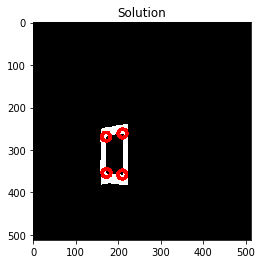

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6813 (1).png
[]
file has only one shape


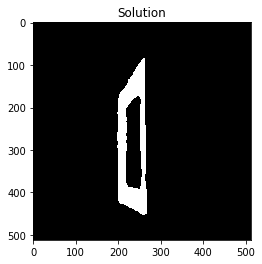

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7200 (1).png
[{'area': 15352, 'centroid': (244, 298), 'corners': array([[255.50316, 255.48798],
       [196.08917, 225.81311],
       [293.49985, 225.7272 ],
       [195.32841, 373.67004],
       [291.67004, 373.6716 ]], dtype=float32)}, {'area': 32046, 'centroid': (244, 301), 'corners': array([[255.50302, 255.48729],
       [315.67007, 193.32845],
       [174.32845, 193.32994],
       [318.1812 , 410.1812 ],
       [171.7622 , 410.69455]], dtype=float32)}]


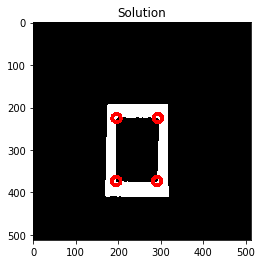

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8265.png
[]
file has only one shape


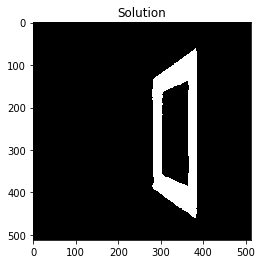

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7028.png
[{'area': 4752, 'centroid': (269, 239), 'corners': array([[255.49625, 255.50478],
       [248.58792, 189.43192],
       [291.9506 , 200.54509],
       [246.68915, 277.0959 ],
       [287.67267, 285.25836]], dtype=float32)}, {'area': 9360, 'centroid': (271, 240), 'corners': array([[255.49614, 255.5047 ],
       [241.03131, 166.79105],
       [302.49985, 180.7272 ],
       [238.71976, 305.65112],
       [302.30484, 310.6711 ]], dtype=float32)}]


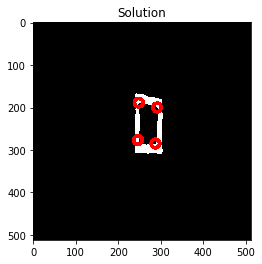

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4603.png
[{'area': 17010, 'centroid': (236, 253), 'corners': array([[255.50505, 255.50095],
       [273.9009 , 158.1969 ],
       [191.8088 , 177.23117],
       [194.78166, 337.21832],
       [278.08072, 348.34268]], dtype=float32)}, {'area': 38488, 'centroid': (236, 254), 'corners': array([[255.50453 , 255.50082 ],
       [297.24234 , 110.783676],
       [165.60889 , 144.51953 ],
       [168.08919 , 371.1868  ],
       [299.7069  , 395.13126 ]], dtype=float32)}]


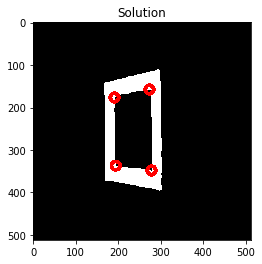

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8576.png
[]
file has only one shape


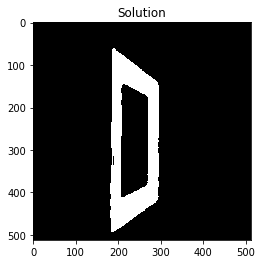

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6241.png
[{'area': 10586, 'centroid': (253, 300), 'corners': array([[255.50108, 255.48769],
       [224.88641, 218.31746],
       [285.26575, 238.68126],
       [222.32841, 376.67004],
       [285.2184 , 372.2184 ]], dtype=float32)}, {'area': 24174, 'centroid': (253, 303), 'corners': array([[255.50136, 255.48758],
       [204.56868, 180.16518],
       [304.87604, 211.85216],
       [302.43008, 408.38425],
       [204.75117, 416.72382]], dtype=float32)}]


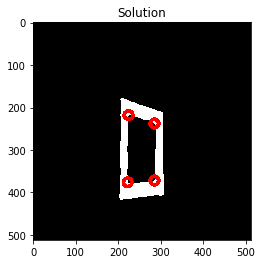

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9155.png
[{'area': 9088, 'centroid': (203, 271), 'corners': array([[250.99922, 250.49995],
       [180.85211, 199.1242 ],
       [233.92241, 213.64299],
       [173.32841, 337.67004],
       [227.31593, 337.55283]], dtype=float32)}, {'area': 20758, 'centroid': (203, 272), 'corners': array([[250.99922, 250.49995],
       [164.7577 , 158.78358],
       [251.87605, 192.85216],
       [247.42409, 366.42407],
       [156.75772, 374.21643]], dtype=float32)}]


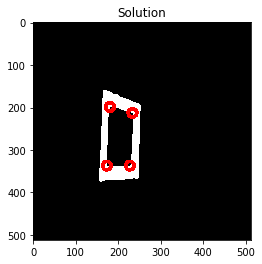

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5383.png
[]
file has only one shape


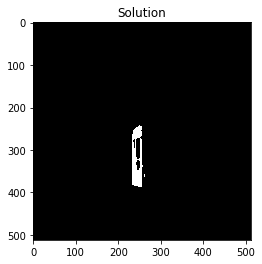

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7621 (1).png
[]
file has only one shape


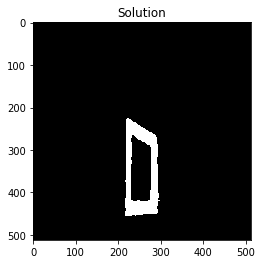

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0655.png
[{'area': 29536, 'centroid': (258, 256), 'corners': array([[255.49818, 255.49965],
       [302.45456, 115.40909],
       [204.04941, 149.54488],
       [202.609  , 363.48032],
       [306.48416, 398.44324]], dtype=float32)}]
file has only one shape


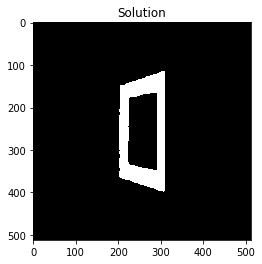

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1005.png
[{'area': 14742, 'centroid': (205, 324), 'corners': array([[255.5137 , 255.48055],
       [241.83414, 229.56851],
       [168.8398 , 243.26071],
       [166.28838, 407.23114],
       [241.39255, 419.61716]], dtype=float32)}, {'area': 35670, 'centroid': (206, 326), 'corners': array([[255.51317, 255.47968],
       [263.6025 , 179.3291 ],
       [144.25   , 217.4375 ],
       [142.54729, 441.44   ],
       [266.43115, 467.8349 ]], dtype=float32)}]


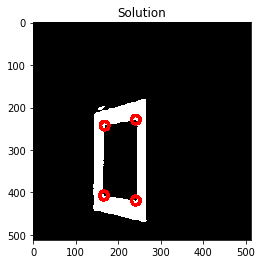

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8499.png
[{'area': 23108, 'centroid': (271, 273), 'corners': array([[255.49599, 255.496  ],
       [225.83856, 161.34253],
       [323.4527 , 181.56   ],
       [319.54285, 367.8057 ],
       [222.81316, 381.91083]], dtype=float32)}, {'area': 53280, 'centroid': (269, 274), 'corners': array([[255.49791, 255.49484],
       [195.81876, 105.81876],
       [351.67157, 144.32996],
       [350.8765 , 405.14755],
       [193.22597, 439.52948]], dtype=float32)}]


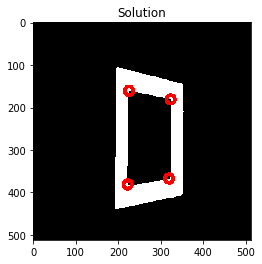

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9991.png
[{'area': 9282, 'centroid': (250, 243), 'corners': array([[255.50137, 255.50323],
       [213.08313, 184.8369 ],
       [288.05328, 188.47815],
       [212.76884, 300.7116 ],
       [288.24783, 300.66214]], dtype=float32)}, {'area': 19323, 'centroid': (251, 244), 'corners': array([[255.50117, 255.50302],
       [195.83698, 159.08336],
       [306.65735, 161.34537],
       [195.75772, 329.21643],
       [307.1628 , 328.9167 ]], dtype=float32)}]


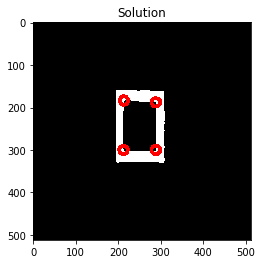

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9635.png
[{'area': 38556, 'centroid': (273, 287), 'corners': array([[255.49492, 255.4919 ],
       [346.33163, 168.26154],
       [200.78247, 169.40695],
       [355.1869 , 398.91083],
       [194.31396, 402.57797]], dtype=float32)}, {'area': 84035, 'centroid': (274, 290), 'corners': array([[255.49492, 255.49121],
       [379.8345 , 116.56875],
       [163.32837, 119.33002],
       [400.28568, 452.64578],
       [155.29301, 460.13126]], dtype=float32)}]


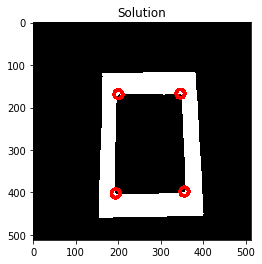

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1786.png
[]
file has only one shape


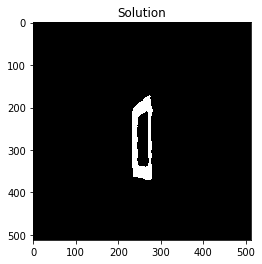

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0386.png
[]
file has only one shape


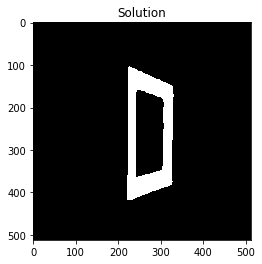

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2548.png
[{'area': 9381, 'centroid': (234, 316), 'corners': array([[256.19788, 251.60046],
       [209.22746, 233.46956],
       [263.53204, 258.07678],
       [207.32841, 388.67004],
       [256.47043, 390.79324]], dtype=float32)}, {'area': 22320, 'centroid': (234, 317), 'corners': array([[256.2547 , 251.62033],
       [194.4296 , 186.9019 ],
       [281.3977 , 233.34895],
       [282.65112, 423.28024],
       [192.28258, 430.29544]], dtype=float32)}]


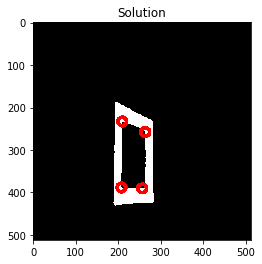

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3587.png
[{'area': 4240, 'centroid': (240, 271), 'corners': array([[255.50412, 255.49553],
       [215.83714, 233.08336],
       [266.28094, 234.3493 ],
       [216.34875, 310.28003],
       [264.67004, 309.6716 ]], dtype=float32)}, {'area': 8740, 'centroid': (240, 272), 'corners': array([[255.50406, 255.49539],
       [203.32994, 215.32845],
       [278.42407, 216.57591],
       [204.29251, 330.5581 ],
       [277.64276, 329.39194]], dtype=float32)}]


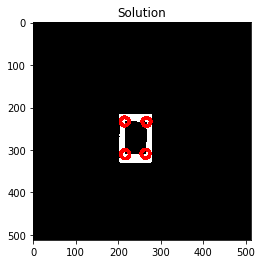

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1747.png
[]
file has only one shape


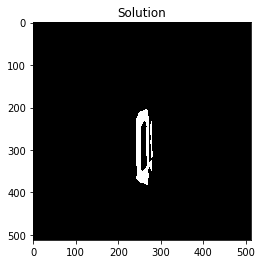

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7934.png
[{'area': 9514, 'centroid': (184, 282), 'corners': array([[255.51959, 255.49298],
       [216.67004, 210.32843],
       [153.76886, 219.28839],
       [154.25879, 349.363  ],
       [217.80498, 349.77106]], dtype=float32)}, {'area': 21513, 'centroid': (184, 283), 'corners': array([[255.51976, 255.49242],
       [233.77281, 174.46973],
       [134.83684, 194.08311],
       [131.32993, 375.67154],
       [231.70757, 389.55807]], dtype=float32)}]


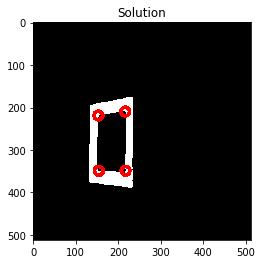

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4515.png
[{'area': 6798, 'centroid': (246, 243), 'corners': array([[255.50233, 255.50337],
       [278.28003, 193.34875],
       [215.85248, 195.1235 ],
       [277.6716 , 291.67004],
       [219.41212, 294.33612]], dtype=float32)}, {'area': 14356, 'centroid': (245, 243), 'corners': array([[255.50269, 255.50296],
       [291.48984, 168.78886],
       [197.32854, 173.32983],
       [198.7816 , 316.2184 ],
       [293.16296, 317.91696]], dtype=float32)}]


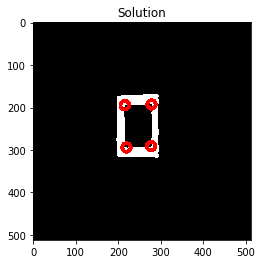

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7260 (1).png
[{'area': 11305, 'centroid': (236, 307), 'corners': array([[255.50516, 255.48558],
       [276.90393, 241.84889],
       [196.69463, 245.25758],
       [278.18124, 372.18124],
       [195.47343, 371.47845]], dtype=float32)}, {'area': 23546, 'centroid': (236, 309), 'corners': array([[255.50536, 255.48517],
       [295.7076 , 210.44196],
       [176.32845, 219.32994],
       [175.83104, 403.67206],
       [297.45547, 403.45547]], dtype=float32)}]


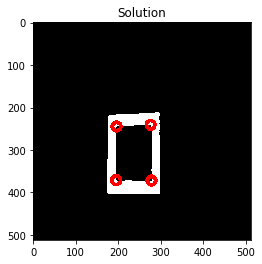

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9672.png
[{'area': 11592, 'centroid': (230, 209), 'corners': array([[255.50763, 255.51372],
       [191.83714, 139.08336],
       [270.91046, 150.81296],
       [190.7816 , 273.2184 ],
       [269.91083, 273.1869 ]], dtype=float32)}, {'area': 24442, 'centroid': (230, 209), 'corners': array([[255.5077 , 255.51372],
       [174.35414, 103.71429],
       [290.9167 , 123.8372 ],
       [170.83704, 304.91696],
       [289.8345 , 306.43124]], dtype=float32)}]


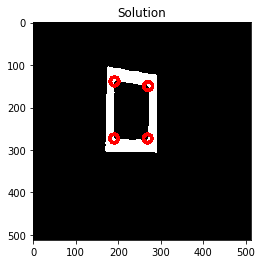

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3835.png
[{'area': 4565, 'centroid': (221, 292), 'corners': array([[260.41956, 256.99875],
       [195.56004, 251.54732],
       [247.87573, 252.85211],
       [195.8369 , 333.91687],
       [246.67017, 331.67145]], dtype=float32)}, {'area': 10125, 'centroid': (221, 293), 'corners': array([[260.41956, 256.99875],
       [181.55608, 230.8075 ],
       [260.9035 , 236.82884],
       [182.29234, 355.55804],
       [261.9108 , 353.18677]], dtype=float32)}]


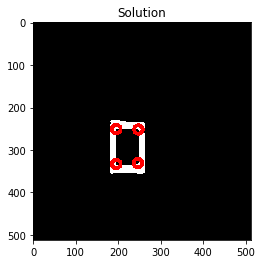

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8028 (1).png
[{'area': 6324, 'centroid': (269, 322), 'corners': array([[255.49562, 255.4815 ],
       [290.56592, 257.96643],
       [246.60016, 273.738  ],
       [294.1812 , 379.1812 ],
       [246.68999, 379.87366]], dtype=float32)}, {'area': 14299, 'centroid': (269, 324), 'corners': array([[255.49554, 255.48131],
       [303.81757, 228.5362 ],
       [231.47311, 252.52165],
       [306.7075 , 408.5581 ],
       [232.61108, 409.49338]], dtype=float32)}]


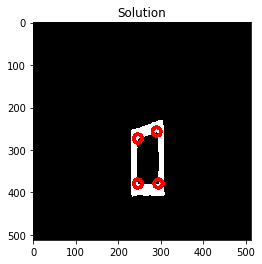

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4055.png
[]
file has only one shape


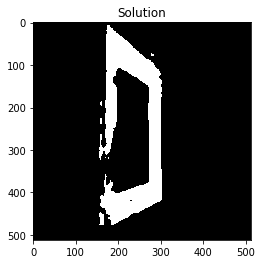

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8632 (1).png
[]
file has only one shape


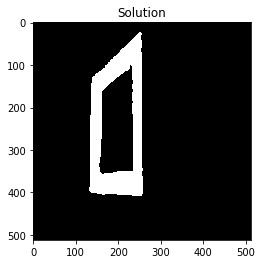

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5666.png
[{'area': 20648, 'centroid': (241, 273), 'corners': array([[255.50365, 255.49506],
       [187.5384 , 184.5378 ],
       [295.48044, 188.60889],
       [185.08336, 360.16284],
       [298.24774, 358.66217]], dtype=float32)}, {'area': 43771, 'centroid': (241, 275), 'corners': array([[255.50371, 255.4945 ],
       [159.8188 , 144.81879],
       [323.46872, 152.63951],
       [325.91696, 399.16296],
       [156.81879, 404.1812 ]], dtype=float32)}]


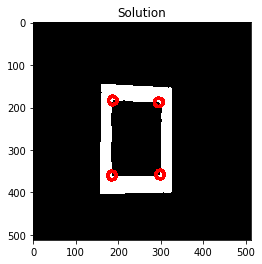

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8039 (1).png
[{'area': 4018, 'centroid': (264, 335), 'corners': array([[255.49725, 255.47739],
       [278.44174, 286.1667 ],
       [244.25   , 302.4375 ],
       [282.6571 , 381.65454],
       [248.42178, 382.43024]], dtype=float32)}, {'area': 8742, 'centroid': (263, 338), 'corners': array([[255.49734, 255.47717],
       [291.18124, 264.81876],
       [232.65189, 281.45462],
       [293.67154, 404.67007],
       [233.18413, 405.33252]], dtype=float32)}]


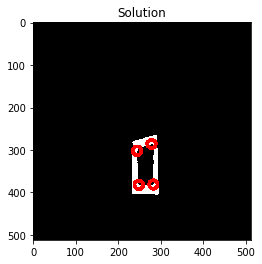

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6174.png
[]
file has only one shape


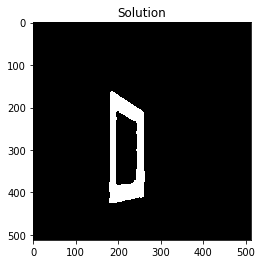

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7617.png
[{'area': 9360, 'centroid': (215, 294), 'corners': array([[252.3073 , 254.50038],
       [252.24232, 228.78363],
       [181.08954, 236.81296],
       [181.77739, 357.43332],
       [250.90718, 356.23538]], dtype=float32)}, {'area': 20680, 'centroid': (216, 296), 'corners': array([[252.3073 , 254.50038],
       [267.36508, 199.7402 ],
       [163.08945, 214.81297],
       [159.81879, 384.1812 ],
       [271.13123, 387.70676]], dtype=float32)}]


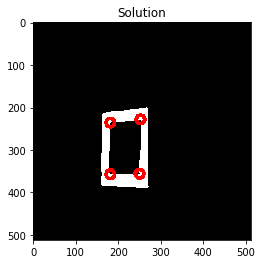

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8482.png
[{'area': 3960, 'centroid': (234, 257), 'corners': array([[255.50612, 255.49966],
       [215.7816 , 214.7816 ],
       [255.90347, 219.82874],
       [214.83676, 300.91672],
       [252.18704, 298.91046]], dtype=float32)}, {'area': 8777, 'centroid': (235, 258), 'corners': array([[255.5058 , 255.49956],
       [206.35422, 191.71425],
       [268.77405, 201.45142],
       [266.1612 , 319.65707],
       [204.16493, 324.43112]], dtype=float32)}]


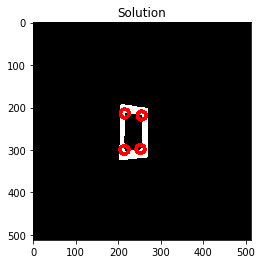

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7271.png
[{'area': 7381, 'centroid': (260, 260), 'corners': array([[255.499  , 255.49924],
       [233.29327, 198.44153],
       [289.91663, 207.83713],
       [232.08954, 316.18704],
       [286.48032, 317.39102]], dtype=float32)}, {'area': 16284, 'centroid': (260, 261), 'corners': array([[255.49918, 255.49913],
       [214.86874, 171.29301],
       [306.28024, 186.34888],
       [306.24228, 342.21646],
       [215.39746, 347.67078]], dtype=float32)}]


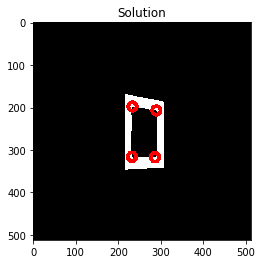

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8344 (1).png
[{'area': 11645, 'centroid': (156, 295), 'corners': array([[255.52858 , 255.48929 ],
       [118.83715 , 226.08336 ],
       [197.05325 , 238.47815 ],
       [115.328415, 358.67004 ],
       [194.87625 , 359.1475  ]], dtype=float32)}, {'area': 24600, 'centroid': (155, 297), 'corners': array([[255.52866, 255.48897],
       [101.40431, 191.62088],
       [216.2184 , 214.7816 ],
       [ 96.16494, 393.43112],
       [214.70761, 391.55804]], dtype=float32)}]


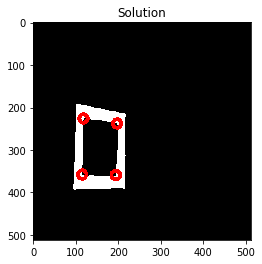

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5413.png
[{'area': 36504, 'centroid': (250, 244), 'corners': array([[255.50117, 255.50302],
       [177.73013, 127.66469],
       [327.5528 , 131.684  ],
       [326.42407, 358.42407],
       [172.78888, 359.4898 ]], dtype=float32)}, {'area': 76614, 'centroid': (249, 247), 'corners': array([[255.50137 , 255.50255 ],
       [140.75772 ,  75.78355 ],
       [360.77386 ,  79.470406],
       [137.81322 , 415.9108  ],
       [362.96875 , 414.209   ]], dtype=float32)}]


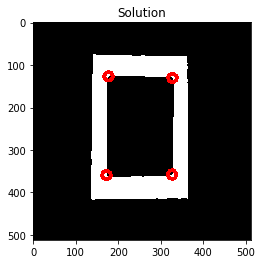

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8004 (1).png
[{'area': 6656, 'centroid': (255, 353), 'corners': array([[255.49997, 255.47278],
       [285.77252, 301.4695 ],
       [225.08968, 307.813  ],
       [286.2089 , 402.96896],
       [223.81877, 403.18124]], dtype=float32)}, {'area': 13950, 'centroid': (254, 355), 'corners': array([[255.50012, 255.47252],
       [298.9688 , 277.79095],
       [209.08951, 287.813  ],
       [208.8372 , 426.9167 ],
       [300.67154, 428.67007]], dtype=float32)}]


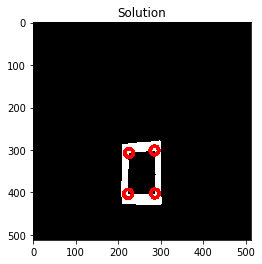

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4666.png
[]
file has only one shape


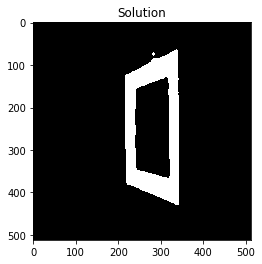

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8486.png
[{'area': 4465, 'centroid': (241, 266), 'corners': array([[255.50409, 255.49728],
       [221.7816 , 219.7816 ],
       [263.6716 , 223.32997],
       [261.73935, 309.16013],
       [220.32841, 313.67004]], dtype=float32)}, {'area': 10080, 'centroid': (242, 268), 'corners': array([[255.50374, 255.49673],
       [209.32996, 197.32841],
       [277.67154, 205.32993],
       [272.74518, 334.0037 ],
       [209.46043, 340.3364 ]], dtype=float32)}]


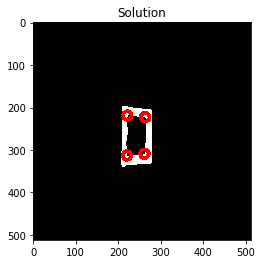

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7444.png
[]
file has only one shape


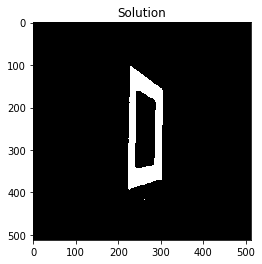

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4128.png
[]
file has only one shape


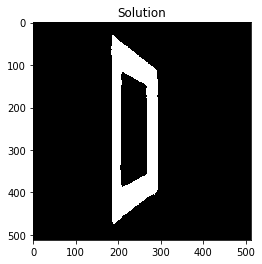

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6834 (1).png
[]
file has only one shape


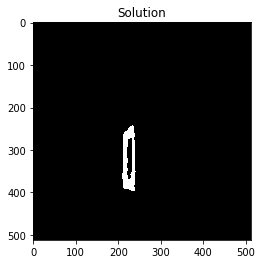

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4802.png
[{'area': 18549, 'centroid': (236, 288), 'corners': array([[255.50607, 255.49028],
       [199.76956, 171.17358],
       [276.96515, 200.4012 ],
       [277.91666, 382.1628 ],
       [197.88649, 400.68253]], dtype=float32)}]
file has only one shape


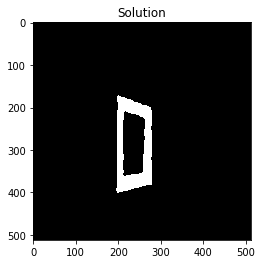

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8491 (1).png
[{'area': 17304, 'centroid': (259, 264), 'corners': array([[255.4981 , 255.49825],
       [306.28708, 178.65962],
       [210.44717, 194.68407],
       [310.67145, 340.67017],
       [209.08919, 343.1869 ]], dtype=float32)}, {'area': 36995, 'centroid': (260, 266), 'corners': array([[255.49783, 255.49818],
       [327.23785, 137.30544],
       [186.12637, 163.68996],
       [335.60254, 379.67078],
       [187.81297, 381.9105 ]], dtype=float32)}]


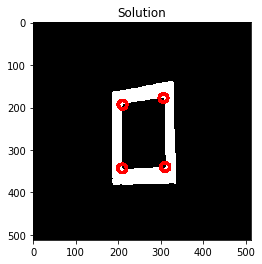

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6788.png
[{'area': 11704, 'centroid': (266, 260), 'corners': array([[255.49742, 255.49954],
       [233.85867, 181.54729],
       [302.4527 , 198.56001],
       [228.38889, 324.6111 ],
       [302.6507 , 331.28094]], dtype=float32)}, {'area': 25536, 'centroid': (265, 261), 'corners': array([[255.49802, 255.4994 ],
       [213.13243, 141.94905],
       [321.75   , 177.4375 ],
       [208.81879, 364.1812 ],
       [322.16177, 365.65765]], dtype=float32)}]


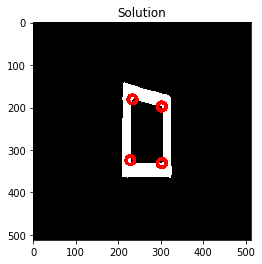

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2542.png
[]
file has only one shape


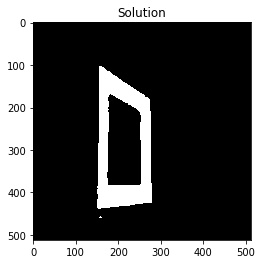

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1578.png
[{'area': 8250, 'centroid': (244, 309), 'corners': array([[255.50288, 255.48495],
       [210.08919, 256.8131 ],
       [280.6716 , 258.32996],
       [209.32841, 363.67004],
       [278.6622 , 363.24738]], dtype=float32)}, {'area': 17172, 'centroid': (245, 312), 'corners': array([[255.50261, 255.48462],
       [194.74762, 230.2693 ],
       [298.19354, 234.09108],
       [193.81322, 391.9108 ],
       [298.67007, 390.67154]], dtype=float32)}]


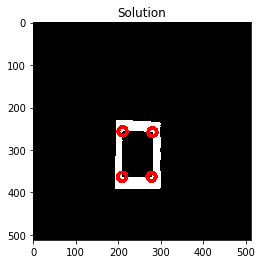

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0459.png
[{'area': 8024, 'centroid': (269, 263), 'corners': array([[255.49606, 255.49773],
       [238.12346, 205.85248],
       [302.91046, 211.81296],
       [237.8369 , 321.91687],
       [300.36252, 318.53012]], dtype=float32)}, {'area': 17952, 'centroid': (270, 265), 'corners': array([[255.49579, 255.49763],
       [223.75768, 175.78363],
       [321.9105 , 187.81297],
       [317.7308 , 345.25174],
       [222.35408, 353.2857 ]], dtype=float32)}]


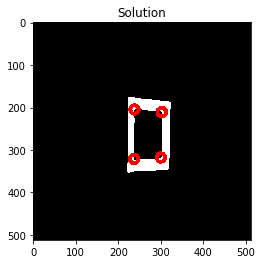

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7849.png
[]
file has only one shape


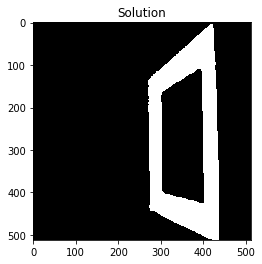

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7274 (1).png
[{'area': 45236, 'centroid': (123, 244), 'corners': array([[255.53627 , 255.50351 ],
       [207.16365 , 111.28896 ],
       [ 48.206753, 116.32162 ],
       [ 33.781662, 368.21832 ],
       [202.45522 , 373.95032 ]], dtype=float32)}, {'area': 94464, 'centroid': (124, 243), 'corners': array([[255.54266  , 255.49971  ],
       [246.54521  ,  51.65189  ],
       [  8.348868 ,  57.719788 ],
       [  2.182911 , 402.99896  ],
       [  1.4987726, 427.49945  ],
       [244.67155  , 436.67007  ]], dtype=float32)}]


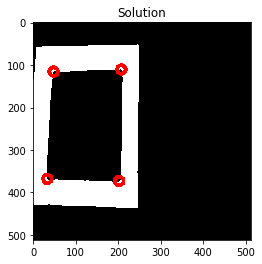

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8565.png
[]
file has only one shape


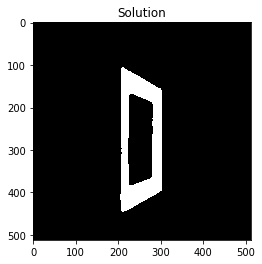

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7923.png
[{'area': 36716, 'centroid': (271, 262), 'corners': array([[255.4945 , 255.49928],
       [333.47476, 123.48792],
       [206.80821, 152.29523],
       [203.78166, 380.21832],
       [336.16293, 396.91696]], dtype=float32)}, {'area': 87535, 'centroid': (277, 263), 'corners': array([[255.49155 , 255.49828 ],
       [369.1612  ,  43.342976],
       [176.25272 , 111.18736 ],
       [169.32164 , 423.79327 ],
       [374.1812  , 471.1812  ]], dtype=float32)}]


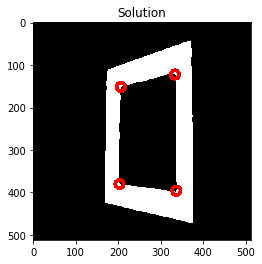

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9866.png
[{'area': 13066, 'centroid': (327, 269), 'corners': array([[255.48022, 255.49615],
       [369.22263, 198.56668],
       [282.76883, 204.28839],
       [281.68506, 335.64148],
       [373.6716 , 338.67004]], dtype=float32)}, {'area': 27604, 'centroid': (329, 270), 'corners': array([[255.48001, 255.49574],
       [392.707  , 165.86874],
       [262.0833 , 175.8372 ],
       [261.32993, 367.67154],
       [396.13126, 371.707  ]], dtype=float32)}]


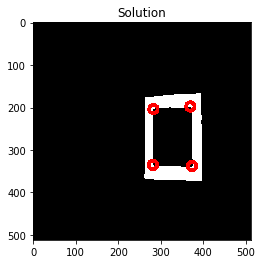

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0136.png
[{'area': 32780, 'centroid': (216, 227), 'corners': array([[255.51038 , 255.5081  ],
       [148.3493  , 115.719055],
       [288.14752 , 119.123505],
       [143.32841 , 335.67004 ],
       [290.42407 , 333.42407 ]], dtype=float32)}, {'area': 70414, 'centroid': (216, 227), 'corners': array([[255.51044 , 255.5079  ],
       [113.807175,  64.09071 ],
       [322.1812  ,  71.818794],
       [324.64578 , 385.28568 ],
       [108.328445, 387.67007 ]], dtype=float32)}]


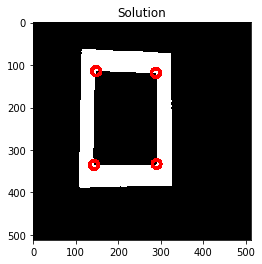

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7077 (1).png
[{'area': 31443, 'centroid': (261, 272), 'corners': array([[255.49837, 255.49593],
       [195.83998, 158.08075],
       [329.90906, 172.80695],
       [192.81313, 378.91083],
       [330.7116 , 378.23114]], dtype=float32)}, {'area': 69208, 'centroid': (259, 274), 'corners': array([[255.49876, 255.49593],
       [162.81876, 102.81876],
       [361.1812 , 128.81879],
       [367.21643, 426.24228],
       [156.29251, 432.5581 ]], dtype=float32)}]


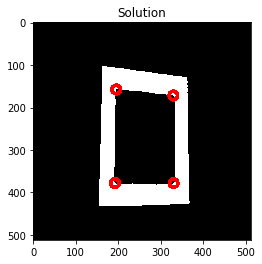

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6096.png
[]
file has only one shape


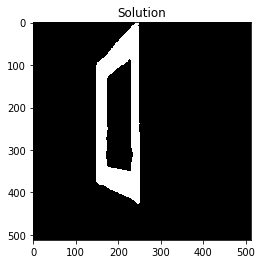

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5924.png
[{'area': 7239, 'centroid': (231, 264), 'corners': array([[255.50636, 255.49779],
       [255.2173 , 199.4071 ],
       [204.74602, 211.31355],
       [204.08305, 323.16293],
       [258.55865, 324.7064 ]], dtype=float32)}, {'area': 16150, 'centroid': (230, 265), 'corners': array([[255.50636, 255.49773],
       [270.6981 , 167.45348],
       [188.12395, 187.85216],
       [188.30194, 353.54648],
       [270.70032, 359.5737 ]], dtype=float32)}]


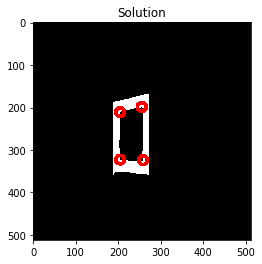

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3128.png
[{'area': 44544, 'centroid': (235, 213), 'corners': array([[255.50522 , 255.51181 ],
       [156.3493  ,  83.719055],
       [317.70758 ,  89.44193 ],
       [149.55995 , 338.45273 ],
       [323.21835 , 336.21832 ]], dtype=float32)}, {'area': 99036, 'centroid': (235, 216), 'corners': array([[255.50516 , 255.51181 ],
       [118.769905,  20.173649],
       [355.16296 ,  36.083054],
       [369.21643 , 393.24228 ],
       [105.818794, 399.1812  ]], dtype=float32)}]


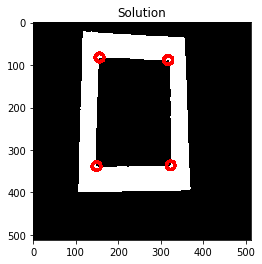

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1852.png
[{'area': 4633, 'centroid': (235, 284), 'corners': array([[255.50519, 255.49216],
       [253.24234, 226.78365],
       [216.78162, 237.38214],
       [253.5171 , 338.44986],
       [220.51971, 337.391  ]], dtype=float32)}, {'area': 11050, 'centroid': (234, 284), 'corners': array([[255.50499, 255.49243],
       [265.18124, 195.81877],
       [201.69528, 216.40128],
       [208.58763, 362.8071 ],
       [266.1812 , 366.1812 ]], dtype=float32)}]


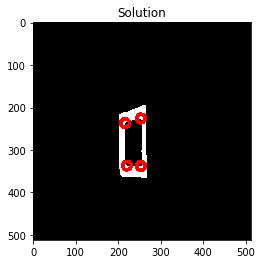

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8391.png
[{'area': 6100, 'centroid': (285, 251), 'corners': array([[255.4916 , 255.50117],
       [258.4619 , 201.3695 ],
       [315.3624 , 206.46986],
       [256.83652, 300.9164 ],
       [313.72794, 298.87466]], dtype=float32)}, {'area': 13050, 'centroid': (286, 253), 'corners': array([[255.49149, 255.50055],
       [243.84383, 180.1051 ],
       [332.18585, 187.43292],
       [329.67007, 322.67154],
       [240.78886, 323.48984]], dtype=float32)}]


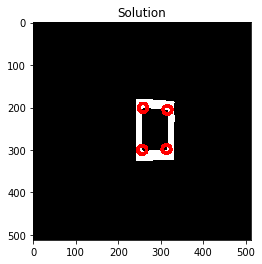

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2189.png
[{'area': 14134, 'centroid': (234, 315), 'corners': array([[255.5063 , 255.48329],
       [201.32994, 214.32845],
       [269.95822, 247.62776],
       [200.58788, 403.56815],
       [268.7116 , 401.2311 ]], dtype=float32)}, {'area': 33872, 'centroid': (233, 316), 'corners': array([[255.50642, 255.48291],
       [184.42088, 156.91045],
       [291.4092 , 216.59662],
       [294.4241 , 438.42407],
       [177.32845, 450.67007]], dtype=float32)}]


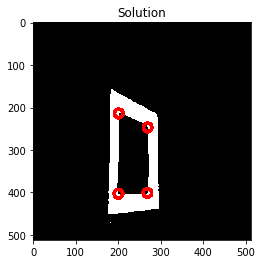

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5449.png
[]
file has only one shape


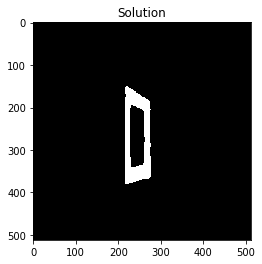

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7510.png
[{'area': 5600, 'centroid': (248, 250), 'corners': array([[255.5021 , 255.50166],
       [223.83716, 201.08336],
       [275.24738, 206.33781],
       [222.6376 , 297.53012],
       [272.31   , 297.87366]], dtype=float32)}, {'area': 11890, 'centroid': (248, 251), 'corners': array([[255.50195, 255.50119],
       [211.79735, 176.58272],
       [289.9167 , 187.8372 ],
       [287.67007, 319.67154],
       [208.81879, 323.1812 ]], dtype=float32)}]


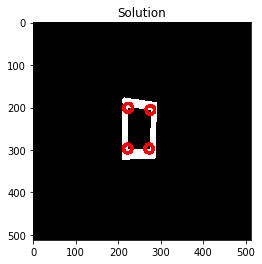

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7793 (1).png
[{'area': 41745, 'centroid': (286, 276), 'corners': array([[255.49136, 255.49493],
       [211.81296, 146.08954],
       [362.68967, 162.42538],
       [204.81401, 395.70346],
       [369.45273, 395.44006]], dtype=float32)}, {'area': 92378, 'centroid': (285, 279), 'corners': array([[255.49156 , 255.49489 ],
       [176.3787  ,  83.69319 ],
       [398.1812  , 111.818794],
       [410.90894 , 452.19354 ],
       [164.58795 , 458.56805 ]], dtype=float32)}]


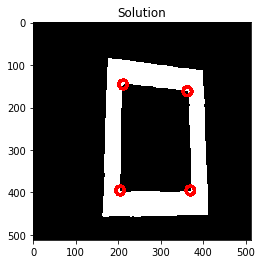

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5106.png
[{'area': 11484, 'centroid': (235, 297), 'corners': array([[255.5055 , 255.48833],
       [276.91083, 232.81313],
       [193.68468, 236.35863],
       [193.08919, 360.1869 ],
       [277.6979 , 363.5463 ]], dtype=float32)}, {'area': 24056, 'centroid': (235, 299), 'corners': array([[255.50563, 255.48798],
       [294.23776, 200.30545],
       [176.226  , 206.46729],
       [175.51015, 394.21115],
       [295.7075 , 396.5581 ]], dtype=float32)}]


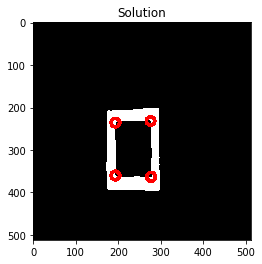

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2528.png
[]
file has only one shape


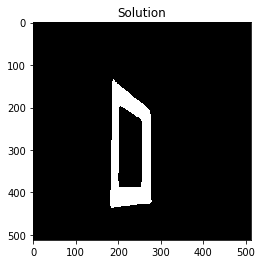

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6105.png
[]
file has only one shape


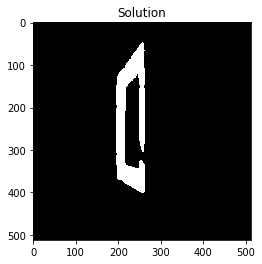

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9270.png
[{'area': 20815, 'centroid': (285, 255), 'corners': array([[255.49155, 255.49973],
       [339.1391 , 167.0785 ],
       [231.5378 , 172.5384 ],
       [232.3493 , 339.28094],
       [342.69806, 347.54648]], dtype=float32)}, {'area': 43195, 'centroid': (288, 256), 'corners': array([[255.49155, 255.49973],
       [367.66998, 124.32836],
       [205.32845, 137.32994],
       [207.51015, 376.21115],
       [366.67154, 389.67007]], dtype=float32)}]


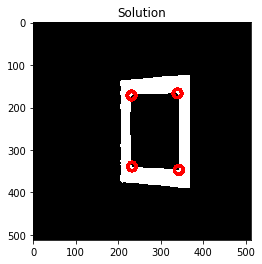

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7467 (1).png
[]
file has only one shape


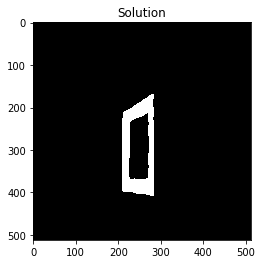

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2156.png
[]
file has only one shape


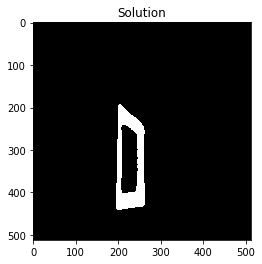

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4861.png
[{'area': 15996, 'centroid': (292, 316), 'corners': array([[255.49019, 255.4835 ],
       [248.81877, 228.81877],
       [338.39783, 244.34909],
       [336.43994, 395.4527 ],
       [245.4296 , 396.37936]], dtype=float32)}, {'area': 35604, 'centroid': (291, 318), 'corners': array([[255.48978, 255.4823 ],
       [225.35724, 187.60808],
       [360.67154, 208.32993],
       [363.3919 , 429.64276],
       [225.79666, 446.71356]], dtype=float32)}]


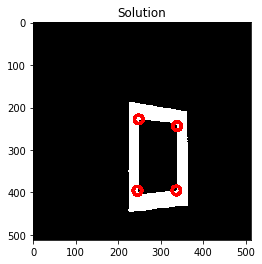

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4057.png
[]
file has only one shape


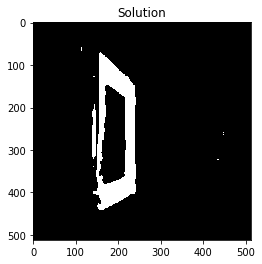

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7833 (1).png
[{'area': 15402, 'centroid': (250, 317), 'corners': array([[255.50124, 255.4829 ],
       [205.56004, 242.54732],
       [300.25858, 249.3273 ],
       [200.67322, 387.46002],
       [297.56232, 391.03455]], dtype=float32)}, {'area': 32266, 'centroid': (250, 320), 'corners': array([[255.5011 , 255.48235],
       [183.33002, 208.32837],
       [321.67154, 217.32993],
       [178.35408, 426.2857 ],
       [322.2378 , 428.69455]], dtype=float32)}]


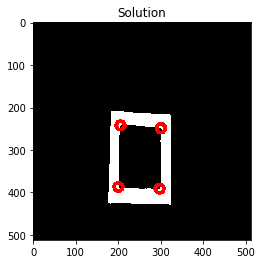

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2984.png
[]
file has only one shape


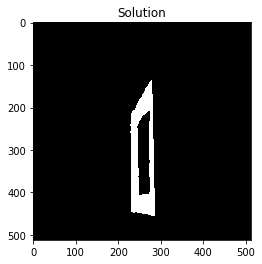

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9169.png
[{'area': 7535, 'centroid': (182, 251), 'corners': array([[255.5213 , 255.50172],
       [161.34935, 180.719  ],
       [207.2517 , 194.2692 ],
       [156.32841, 315.67004],
       [205.45271, 313.44006]], dtype=float32)}, {'area': 17888, 'centroid': (181, 252), 'corners': array([[255.52084, 255.50136],
       [146.48308, 142.54987],
       [224.81099, 175.27158],
       [221.65111, 342.28024],
       [139.81879, 351.1812 ]], dtype=float32)}]


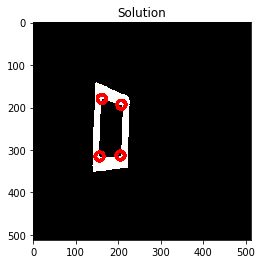

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0957.png
[{'area': 9401, 'centroid': (243, 303), 'corners': array([[255.50343, 255.48668],
       [206.08917, 247.81311],
       [281.18124, 245.81877],
       [205.78166, 361.21832],
       [278.23834, 363.6946 ]], dtype=float32)}, {'area': 19950, 'centroid': (243, 305), 'corners': array([[255.50351, 255.48633],
       [299.16296, 217.08336],
       [186.22597, 221.4514 ],
       [186.8372 , 389.9167 ],
       [298.67154, 392.67007]], dtype=float32)}]


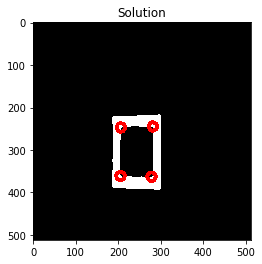

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5680.png
[{'area': 12015, 'centroid': (266, 278), 'corners': array([[255.49701, 255.49345],
       [225.81296, 212.08954],
       [310.30875, 219.82759],
       [223.8369 , 345.91687],
       [306.30914, 343.5655 ]], dtype=float32)}, {'area': 25155, 'centroid': (266, 280), 'corners': array([[255.49698, 255.49313],
       [202.58261, 183.79736],
       [331.28568, 186.35422],
       [204.16623, 378.7392 ],
       [330.66208, 377.24753]], dtype=float32)}]


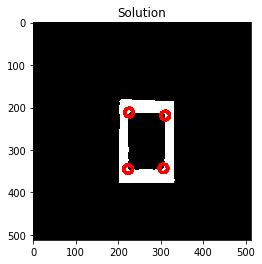

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5309.png
[]
file has only one shape


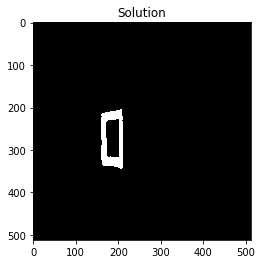

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2419.png
[{'area': 4368, 'centroid': (222, 314), 'corners': array([[251.00092, 251.49994],
       [237.78098, 261.22485],
       [203.7816 , 269.7816 ],
       [242.18123, 363.18124],
       [204.3493 , 363.28094]], dtype=float32)}, {'area': 9333, 'centroid': (221, 315), 'corners': array([[251.00092, 251.49994],
       [250.18123, 234.81877],
       [191.12628, 251.69003],
       [191.28836, 386.23108],
       [249.59885, 389.3047 ]], dtype=float32)}]


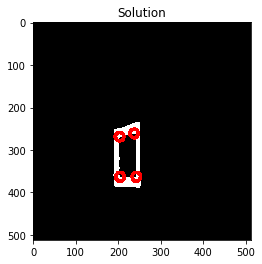

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6349.png
[{'area': 6732, 'centroid': (245, 275), 'corners': array([[255.50255, 255.4945 ],
       [215.71996, 225.34875],
       [278.18124, 227.81877],
       [215.81313, 325.91083],
       [276.87628, 323.14746]], dtype=float32)}, {'area': 14250, 'centroid': (245, 276), 'corners': array([[255.50269, 255.4941 ],
       [199.6081 , 201.35722],
       [294.2484 , 207.60225],
       [198.43442, 350.30923],
       [291.16296, 349.91663]], dtype=float32)}]


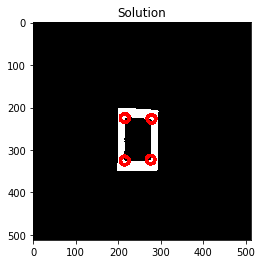

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2468.png
[]
file has only one shape


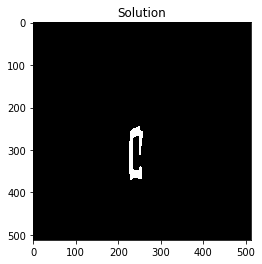

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8430.png
[{'area': 6678, 'centroid': (319, 262), 'corners': array([[255.482  , 255.4982 ],
       [291.8521 , 210.12425],
       [350.23117, 214.28839],
       [349.91687, 312.16312],
       [289.57593, 314.42407]], dtype=float32)}, {'area': 14352, 'centroid': (320, 264), 'corners': array([[255.48193, 255.49767],
       [274.86874, 187.29317],
       [366.67154, 191.32993],
       [365.7117 , 336.2307 ],
       [277.45462, 343.3481 ]], dtype=float32)}]


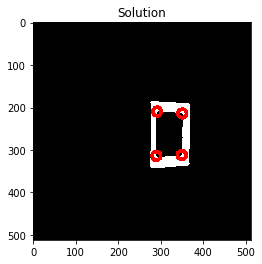

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9792.png
[{'area': 31104, 'centroid': (310, 235), 'corners': array([[255.48482, 255.50557],
       [378.9163 , 127.83661],
       [241.5378 , 132.5384 ],
       [381.39362, 339.69174],
       [243.09546, 342.23746]], dtype=float32)}, {'area': 65730, 'centroid': (312, 236), 'corners': array([[255.48454, 255.5055 ],
       [411.20074,  77.20303],
       [209.32845,  87.32994],
       [417.67154, 388.67007],
       [208.75772, 389.21646]], dtype=float32)}]


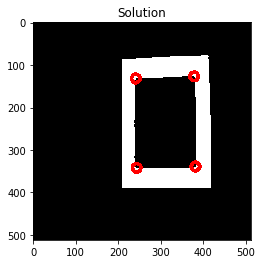

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7475.png
[{'area': 11388, 'centroid': (252, 256), 'corners': array([[255.50104, 255.50047],
       [220.32996, 176.32843],
       [287.90466, 189.84872],
       [287.8765 , 327.14752],
       [218.32841, 331.67004]], dtype=float32)}, {'area': 25740, 'centroid': (252, 257), 'corners': array([[255.50166, 255.50052],
       [200.81876, 135.81876],
       [307.8758 , 164.85205],
       [307.1628 , 359.9167 ],
       [200.76212, 372.69455]], dtype=float32)}]


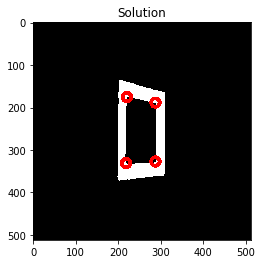

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9582.png
[{'area': 8855, 'centroid': (242, 334), 'corners': array([[259.50003, 254.99954],
       [207.3493 , 277.71906],
       [278.6716 , 281.32996],
       [204.84889, 387.90393],
       [278.16302, 389.91666]], dtype=float32)}, {'area': 17767, 'centroid': (242, 335), 'corners': array([[259.50003, 254.99954],
       [189.4916 , 256.53452],
       [295.67154, 256.32993],
       [187.81879, 415.1812 ],
       [296.1812 , 416.1812 ]], dtype=float32)}]


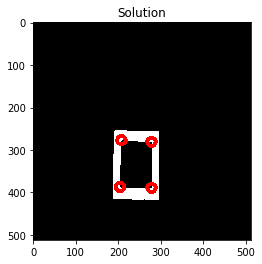

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1207.png
[]
file has only one shape


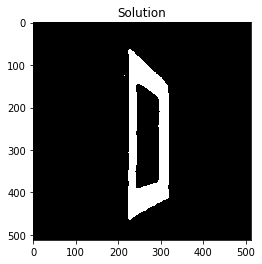

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6620.png
[{'area': 19623, 'centroid': (222, 268), 'corners': array([[255.5087 , 255.49748],
       [265.163  , 157.08336],
       [178.5906 , 182.49608],
       [175.4382 , 363.3396 ],
       [267.33185, 366.42572]], dtype=float32)}, {'area': 46980, 'centroid': (223, 268), 'corners': array([[255.50826, 255.49725],
       [288.57108,  95.33131],
       [150.0807 , 151.84   ],
       [156.14476, 410.61026],
       [293.9167 , 420.1628 ]], dtype=float32)}]


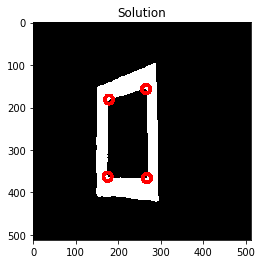

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6847.png
[{'area': 14841, 'centroid': (293, 239), 'corners': array([[255.48947, 255.50511],
       [337.49527, 163.98447],
       [247.91756, 169.91756],
       [341.27002, 310.33533],
       [245.49619, 311.4093 ]], dtype=float32)}, {'area': 32256, 'centroid': (295, 238), 'corners': array([[255.48903, 255.50511],
       [361.24234, 122.78363],
       [222.88724, 142.7494 ],
       [367.1812 , 345.1812 ],
       [224.83882, 346.65707]], dtype=float32)}]


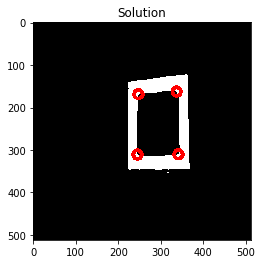

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8936.png
[{'area': 12876, 'centroid': (272, 307), 'corners': array([[255.49605, 255.486  ],
       [236.83713, 219.08336],
       [307.2311 , 234.28838],
       [306.43344, 385.15787],
       [237.08336, 392.16284]], dtype=float32)}, {'area': 30245, 'centroid': (271, 309), 'corners': array([[255.49689, 255.48459],
       [216.43434, 175.69072],
       [328.91663, 204.83702],
       [333.90326, 415.17123],
       [217.46394, 439.2976 ]], dtype=float32)}]


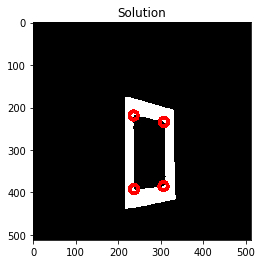

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8493 (1).png
[{'area': 15520, 'centroid': (270, 274), 'corners': array([[255.49525, 255.49539],
       [314.27322, 193.27377],
       [223.85391, 208.6544 ],
       [315.77405, 347.53268],
       [224.7964 , 350.71365]], dtype=float32)}, {'area': 32060, 'centroid': (270, 276), 'corners': array([[255.49487, 255.49527],
       [334.67004, 157.32841],
       [202.32841, 179.32997],
       [340.67154, 381.67007],
       [206.84923, 386.51523]], dtype=float32)}]


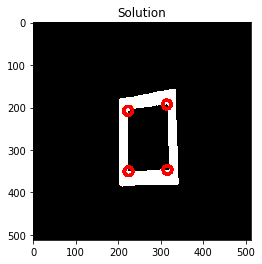

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8613.png
[]
file has only one shape


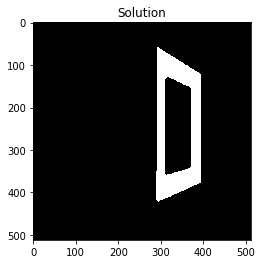

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2174.png
[]
file has only one shape


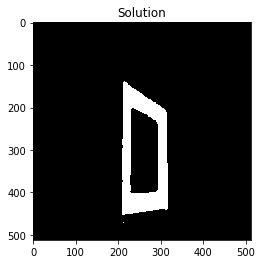

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3828.png
[{'area': 10824, 'centroid': (258, 291), 'corners': array([[255.49924, 255.49004],
       [216.81877, 226.81877],
       [298.42416, 229.57584],
       [299.91083, 352.1869 ],
       [218.8369 , 357.91687]], dtype=float32)}, {'area': 23474, 'centroid': (259, 292), 'corners': array([[255.49855, 255.48935],
       [201.47806, 197.9466 ],
       [319.3962 , 204.60852],
       [321.64276, 383.39194],
       [200.53085, 391.44717]], dtype=float32)}]


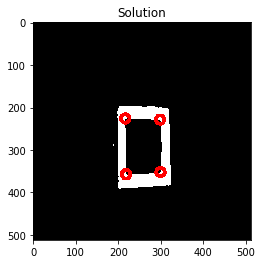

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8352 (1).png
[{'area': 8352, 'centroid': (210, 309), 'corners': array([[255.51323, 255.48524],
       [179.53458, 250.4916 ],
       [243.91046, 259.81296],
       [174.7911 , 362.969  ],
       [243.24783, 363.66214]], dtype=float32)}, {'area': 16968, 'centroid': (209, 311), 'corners': array([[255.51263, 255.48495],
       [160.44197, 225.29234],
       [260.42422, 237.57578],
       [159.81879, 392.1812 ],
       [260.91696, 390.16296]], dtype=float32)}]


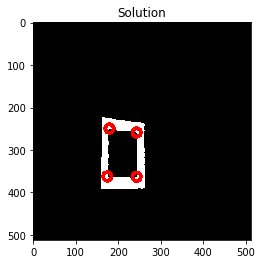

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8478 (1).png
[{'area': 43952, 'centroid': (207, 229), 'corners': array([[255.51263 , 255.50887 ],
       [283.2423  ,  89.78362 ],
       [133.73004 , 117.664665],
       [287.27277 , 349.4999  ],
       [123.85211 , 354.87576 ]], dtype=float32)}, {'area': 95694, 'centroid': (209, 231), 'corners': array([[255.51181 , 255.50943 ],
       [318.9688  ,  22.790987],
       [ 95.50017 ,  68.727196],
       [ 87.41156 , 412.55804 ],
       [331.1812  , 411.1812  ]], dtype=float32)}]


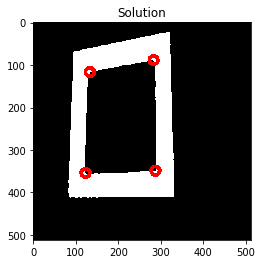

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9293.png
[{'area': 7314, 'centroid': (249, 282), 'corners': array([[255.50151, 255.49265],
       [217.32997, 231.32841],
       [283.18124, 232.81877],
       [217.4783 , 331.05334],
       [281.62125, 334.30676]], dtype=float32)}, {'area': 14850, 'centroid': (250, 282), 'corners': array([[255.50145, 255.49245],
       [201.32994, 209.32845],
       [299.1812 , 209.81879],
       [201.7816 , 356.2184 ],
       [298.77246, 358.53052]], dtype=float32)}]


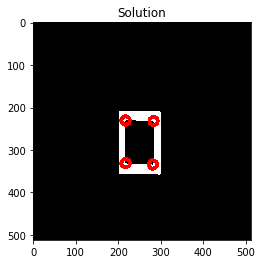

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2724.png
[{'area': 15900, 'centroid': (234, 320), 'corners': array([[255.50577, 255.48242],
       [282.36258, 241.46996],
       [186.76883, 246.28839],
       [284.04758, 393.7853 ],
       [185.28835, 397.23096]], dtype=float32)}, {'area': 35334, 'centroid': (235, 322), 'corners': array([[255.50577, 255.4818 ],
       [305.24228, 202.78355],
       [161.08333, 215.83719],
       [310.65118, 432.28015],
       [161.78564, 436.6846 ]], dtype=float32)}]


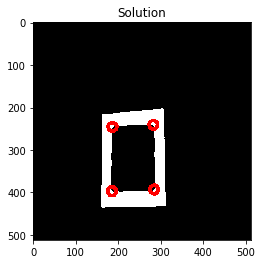

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5354.png
[]
file has only one shape


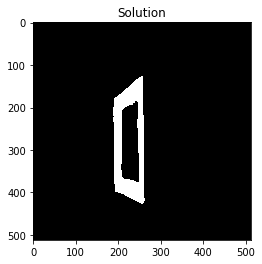

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6917.png
[{'area': 12525, 'centroid': (255, 229), 'corners': array([[255.4995 , 255.50764],
       [289.85205, 141.59181],
       [218.25   , 170.4375 ],
       [290.6716 , 303.67004],
       [219.5384 , 305.46222]], dtype=float32)}, {'area': 27798, 'centroid': (256, 228), 'corners': array([[255.49942, 255.50836],
       [305.57947,  93.88156],
       [199.32843, 138.32996],
       [310.67154, 340.67007],
       [200.22906, 340.80502]], dtype=float32)}]


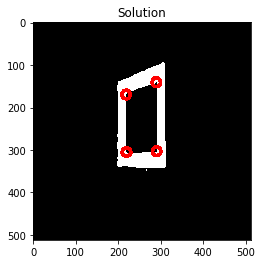

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7555.png
[{'area': 52746, 'centroid': (273, 258), 'corners': array([[255.49449, 255.5008 ],
       [354.0766 , 103.27228],
       [184.71902, 132.34933],
       [183.46986, 392.3624 ],
       [359.16348, 400.9164 ]], dtype=float32)}, {'area': 117216, 'centroid': (278, 259), 'corners': array([[255.49307 , 255.50117 ],
       [395.41626 ,  28.545374],
       [148.12428 ,  82.85213 ],
       [142.81879 , 448.1812  ],
       [406.67154 , 473.67007 ]], dtype=float32)}]


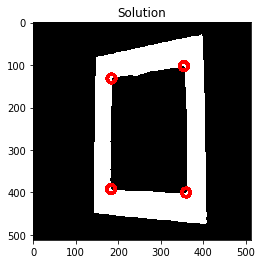

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9690.png
[{'area': 22750, 'centroid': (211, 285), 'corners': array([[255.51202, 255.4919 ],
       [155.3273 , 195.74144],
       [270.14752, 194.1235 ],
       [149.1066 , 374.22986],
       [271.43994, 375.4527 ]], dtype=float32)}, {'area': 49395, 'centroid': (212, 287), 'corners': array([[255.51189 , 255.49162 ],
       [299.67007 , 152.32845 ],
       [126.818794, 154.81879 ],
       [118.8372  , 417.9167  ],
       [304.1812  , 419.1812  ]], dtype=float32)}]


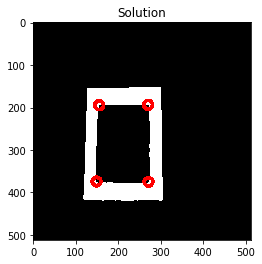

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2376.png
[{'area': 6642, 'centroid': (276, 306), 'corners': array([[250.616  , 257.4549 ],
       [300.4476 , 243.26944],
       [250.6161 , 257.455  ],
       [302.28094, 362.6507 ],
       [255.84918, 365.51523]], dtype=float32)}, {'area': 15023, 'centroid': (276, 308), 'corners': array([[250.616  , 257.4549 ],
       [314.18124, 211.81876],
       [235.32843, 235.32996],
       [316.6111 , 390.6111 ],
       [237.42177, 392.4302 ]], dtype=float32)}]


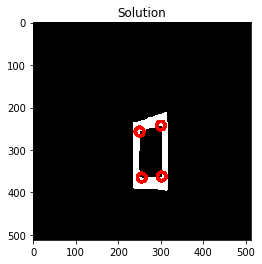

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8836.png
[{'area': 69422, 'centroid': (253, 278), 'corners': array([[255.49988 , 255.49495 ],
       [158.7816  , 106.78159 ],
       [356.91663 , 127.837135],
       [358.47833 , 427.52692 ],
       [156.51955 , 444.3911  ]], dtype=float32)}, {'area': 149688, 'centroid': (251, 278), 'corners': array([[255.50244 , 255.49295 ],
       [111.91303 ,  23.221947],
       [398.9105  ,  68.812965],
       [408.53003 , 492.36255 ],
       [101.49604 , 509.98926 ]], dtype=float32)}]


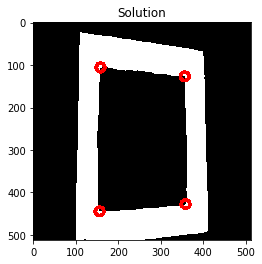

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8223.png
[{'area': 19596, 'centroid': (276, 226), 'corners': array([[255.49324, 255.50844],
       [317.67   , 119.3284 ],
       [230.18924, 142.27133],
       [232.52165, 318.5269 ],
       [318.7741 , 331.52945]], dtype=float32)}, {'area': 45731, 'centroid': (278, 226), 'corners': array([[255.49203 , 255.50746 ],
       [343.60223 ,  59.329185],
       [205.74608 , 110.31347 ],
       [206.76886 , 352.7116  ],
       [343.5178  , 388.69388 ]], dtype=float32)}]


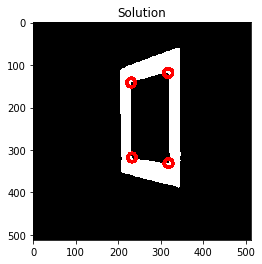

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7338 (1).png
[{'area': 25168, 'centroid': (268, 254), 'corners': array([[255.49585, 255.50151],
       [312.477  , 121.80901],
       [219.68842, 162.28006],
       [219.87128, 362.9806 ],
       [319.15112, 362.90396]], dtype=float32)}, {'area': 59940, 'centroid': (271, 253), 'corners': array([[255.49495 , 255.4984  ],
       [342.2423  ,  52.783592],
       [188.84567 , 133.67476 ],
       [188.34889 , 406.28024 ],
       [349.9093  , 423.1928  ]], dtype=float32)}]


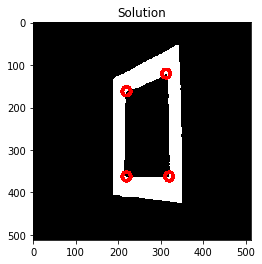

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9371.png
[{'area': 36036, 'centroid': (263, 263), 'corners': array([[255.49773, 255.498  ],
       [189.56004, 146.54732],
       [339.16348, 147.08357],
       [188.45084, 379.77322],
       [339.67004, 377.6716 ]], dtype=float32)}, {'area': 75600, 'centroid': (264, 264), 'corners': array([[255.49753 , 255.49767 ],
       [155.293   ,  94.868744],
       [375.16296 ,  97.08305 ],
       [152.32845 , 432.67007 ],
       [377.67007 , 430.67154 ]], dtype=float32)}]


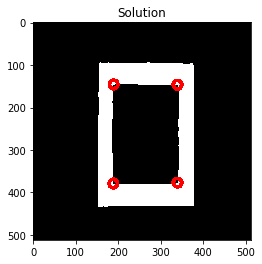

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4013.png
[]
file has only one shape


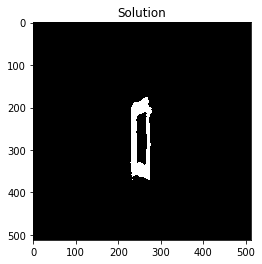

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7084.png
[{'area': 22990, 'centroid': (253, 251), 'corners': array([[255.50027, 255.50124],
       [196.63748, 155.4699 ],
       [310.3686 , 163.57254],
       [195.4731 , 343.47833],
       [315.8765 , 341.14752]], dtype=float32)}, {'area': 51324, 'centroid': (253, 252), 'corners': array([[255.50046 , 255.50153 ],
       [167.8188  , 107.8188  ],
       [339.14758 , 126.123886],
       [346.91696 , 383.16296 ],
       [164.74364 , 389.88275 ]], dtype=float32)}]


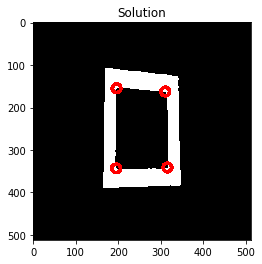

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7450 (1).png
[]
file has only one shape


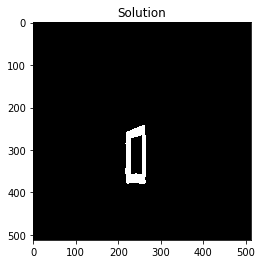

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2218.png
[{'area': 11745, 'centroid': (224, 305), 'corners': array([[255.50914, 255.48665],
       [188.32996, 231.32843],
       [263.16342, 245.08357],
       [187.5101 , 373.21115],
       [262.6622 , 373.24738]], dtype=float32)}, {'area': 25466, 'centroid': (225, 307), 'corners': array([[255.50888, 255.48634],
       [170.75768, 194.78363],
       [285.59317, 221.78226],
       [285.67007, 403.67154],
       [166.83704, 408.91696]], dtype=float32)}]


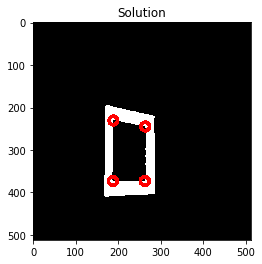

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3551.png
[{'area': 2583, 'centroid': (244, 243), 'corners': array([[255.50319, 255.50346],
       [224.81877, 212.81877],
       [263.67157, 215.32997],
       [225.57593, 271.42407],
       [261.6507 , 273.28094]], dtype=float32)}, {'area': 5510, 'centroid': (245, 244), 'corners': array([[255.50282, 255.50302],
       [218.29239, 196.44196],
       [273.67154, 200.32993],
       [216.81879, 289.1812 ],
       [270.64877, 291.87436]], dtype=float32)}]


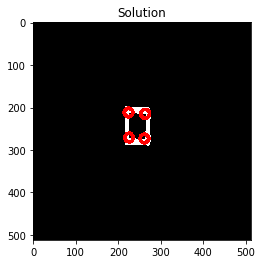

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4912.png
[{'area': 7040, 'centroid': (260, 316), 'corners': array([[255.49886, 255.48315],
       [230.76149, 261.30536],
       [290.9928 , 269.5656 ],
       [291.18124, 366.18124],
       [228.5584 , 370.44177]], dtype=float32)}, {'area': 14915, 'centroid': (261, 317), 'corners': array([[255.49835, 255.48283],
       [215.34889, 238.71976],
       [309.209  , 245.03123],
       [306.72986, 392.2436 ],
       [216.03133, 397.20892]], dtype=float32)}]


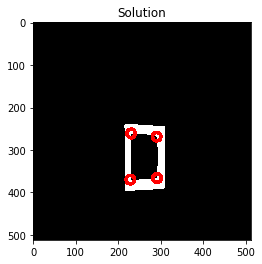

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5326.png
[]
file has only one shape


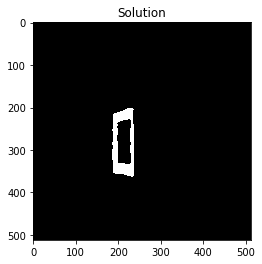

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8712 (1).png
[]
file has only one shape


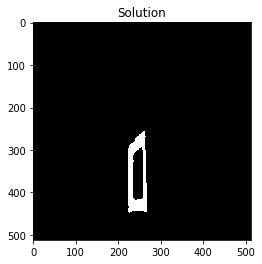

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4047.png
[]
file has only one shape


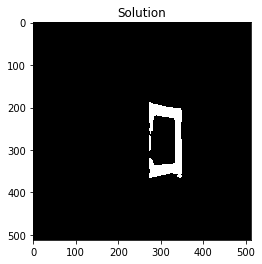

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4846.png
[{'area': 5586, 'centroid': (284, 283), 'corners': array([[255.49179, 255.49211],
       [259.81296, 236.08954],
       [312.91046, 240.81296],
       [259.08954, 330.18704],
       [310.91687, 330.16312]], dtype=float32)}, {'area': 12180, 'centroid': (285, 284), 'corners': array([[255.49179, 255.49193],
       [244.32996, 212.32841],
       [326.9105 , 219.81297],
       [326.1628 , 352.9167 ],
       [243.43442, 356.30923]], dtype=float32)}]


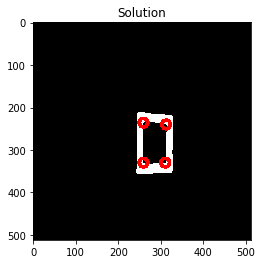

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0955.png
[{'area': 8740, 'centroid': (248, 305), 'corners': array([[255.50186, 255.48619],
       [212.68999, 250.12634],
       [284.14752, 249.1235 ],
       [212.32841, 361.67004],
       [284.9091 , 362.19345]], dtype=float32)}, {'area': 18810, 'centroid': (248, 307), 'corners': array([[255.50186, 255.48564],
       [303.16296, 221.08336],
       [194.32845, 226.32994],
       [195.5345 , 391.50845],
       [302.67133, 392.6703 ]], dtype=float32)}]


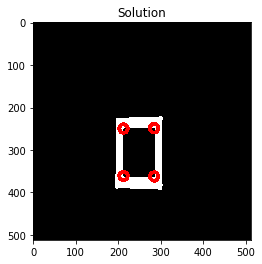

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6710.png
[{'area': 4797, 'centroid': (235, 308), 'corners': array([[255.50523, 255.48517],
       [253.44492, 248.19014],
       [215.84567, 262.67477],
       [217.8439 , 362.89484],
       [253.82068, 365.36453]], dtype=float32)}, {'area': 11440, 'centroid': (234, 310), 'corners': array([[255.50551, 255.48499],
       [263.70694, 218.86882],
       [202.7816 , 239.7816 ],
       [204.34889, 390.28024],
       [265.51727, 395.4497 ]], dtype=float32)}]


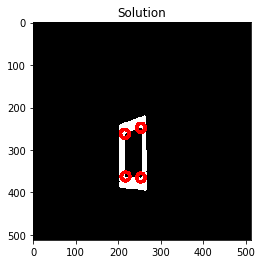

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1002.png
[{'area': 8220, 'centroid': (216, 327), 'corners': array([[259.99927, 254.50005],
       [245.18123, 258.81876],
       [188.25769, 266.69452],
       [187.83713, 389.91663],
       [245.18123, 395.18124]], dtype=float32)}, {'area': 19044, 'centroid': (215, 328), 'corners': array([[259.99927, 254.50005],
       [259.67004, 224.32841],
       [168.66841, 244.19817],
       [173.6912 , 420.81592],
       [258.83417, 432.4315 ]], dtype=float32)}]


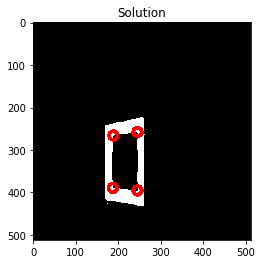

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7997.png
[{'area': 26015, 'centroid': (186, 273), 'corners': array([[255.51894, 255.49521],
       [246.16284, 165.08336],
       [128.08336, 179.83714],
       [125.78166, 372.21832],
       [246.18123, 379.18124]], dtype=float32)}, {'area': 56700, 'centroid': (187, 275), 'corners': array([[255.51903, 255.49498],
       [276.55807, 118.29242],
       [ 98.83703, 140.08305],
       [ 94.08921, 413.18677],
       [274.11423, 432.68295]], dtype=float32)}]


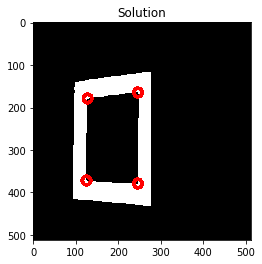

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7002.png
[{'area': 7672, 'centroid': (259, 262), 'corners': array([[255.49937, 255.49847],
       [237.65439, 192.85382],
       [286.2853 , 207.44278],
       [233.32841, 326.67004],
       [284.74243, 325.3053 ]], dtype=float32)}, {'area': 18270, 'centroid': (259, 264), 'corners': array([[255.4995 , 255.49837],
       [218.83699, 152.08336],
       [301.91953, 183.84007],
       [303.45273, 356.44006],
       [215.81879, 362.1812 ]], dtype=float32)}]


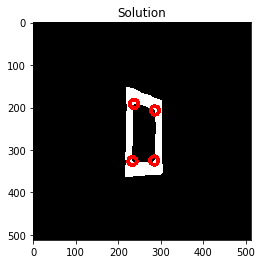

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2563.png
[{'area': 17052, 'centroid': (223, 289), 'corners': array([[255.50957, 255.49127],
       [185.39761, 180.32906],
       [263.4543 , 213.65791],
       [182.96544, 379.56232],
       [264.42407, 380.42407]], dtype=float32)}, {'area': 41272, 'centroid': (221, 290), 'corners': array([[255.50945, 255.4895 ],
       [165.45912, 120.846  ],
       [287.45273, 184.55998],
       [291.67007, 420.67154],
       [157.68982, 430.87338]], dtype=float32)}]


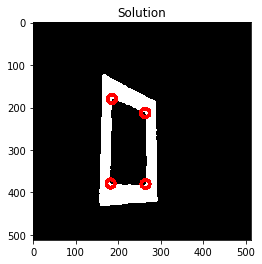

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7567 (1).png
[]
file has only one shape


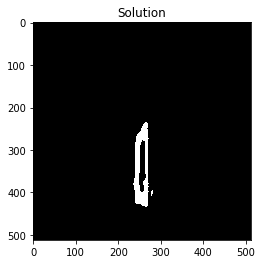

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6656.png
[{'area': 3182, 'centroid': (221, 308), 'corners': array([[255.51015, 255.48381],
       [234.40442, 266.50455],
       [206.54001, 271.67325],
       [237.67159, 347.67004],
       [209.6289 , 349.9682 ]], dtype=float32)}, {'area': 7095, 'centroid': (219, 311), 'corners': array([[255.50975, 255.48438],
       [243.21439, 246.3157 ],
       [193.42195, 257.31403],
       [247.03351, 370.7921 ],
       [200.38104, 376.7157 ]], dtype=float32)}]


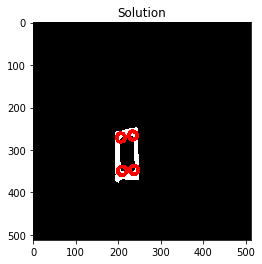

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8229 (1).png
[]
file has only one shape


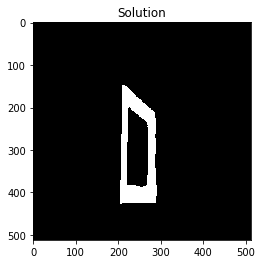

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8860.png
[{'area': 27178, 'centroid': (242, 301), 'corners': array([[255.5035 , 255.48788],
       [184.34929, 191.71909],
       [304.21832, 206.78166],
       [304.67838, 396.79324],
       [180.76884, 404.7116 ]], dtype=float32)}, {'area': 58962, 'centroid': (241, 302), 'corners': array([[255.50388, 255.48767],
       [154.22722, 140.46971],
       [332.66217, 167.75223],
       [335.18704, 440.9105 ],
       [150.29251, 459.5581 ]], dtype=float32)}]


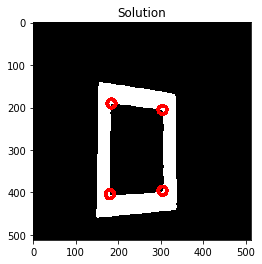

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2930.png
[]
file has only one shape


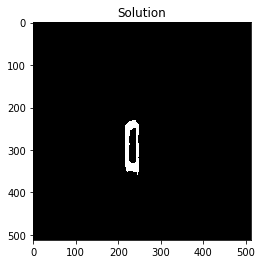

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7688 (1).png
[{'area': 33232, 'centroid': (264, 250), 'corners': array([[255.49814, 255.50313],
       [204.81294, 117.08959],
       [329.91046, 152.81296],
       [199.81877, 364.18124],
       [333.31494, 361.64148]], dtype=float32)}, {'area': 76328, 'centroid': (261, 251), 'corners': array([[255.49919 , 255.50374 ],
       [173.0313  ,  47.791042],
       [358.87604 , 113.85216 ],
       [366.42416 , 412.42416 ],
       [163.81879 , 424.1812  ]], dtype=float32)}]


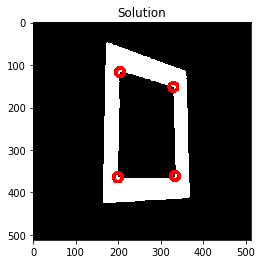

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4028.png
[{'area': 40300, 'centroid': (238, 249), 'corners': array([[255.505  , 255.50226],
       [312.4241 , 115.57591],
       [159.61609, 135.45499],
       [160.54729, 370.44006],
       [310.47318, 376.263  ]], dtype=float32)}, {'area': 91014, 'centroid': (241, 249), 'corners': array([[255.50438 , 255.50238 ],
       [350.70657 ,  48.441494],
       [122.71432 ,  86.35421 ],
       [126.53369 , 423.69067 ],
       [353.16156 , 443.65704 ]], dtype=float32)}]


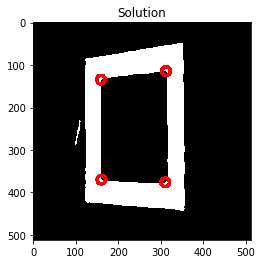

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0125.png
[]
file has only one shape


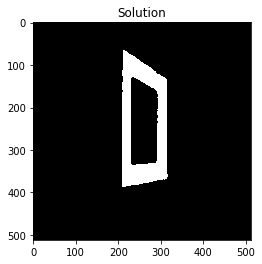

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9941.png
[{'area': 10250, 'centroid': (245, 258), 'corners': array([[255.50275, 255.49918],
       [205.56004, 196.54732],
       [285.16348, 197.08357],
       [206.32841, 321.67004],
       [286.1479 , 318.87576]], dtype=float32)}, {'area': 22878, 'centroid': (246, 259), 'corners': array([[255.50233, 255.4989 ],
       [305.67017, 168.32855],
       [186.08333, 169.83719],
       [306.7075 , 348.5581 ],
       [188.75772, 353.21646]], dtype=float32)}]


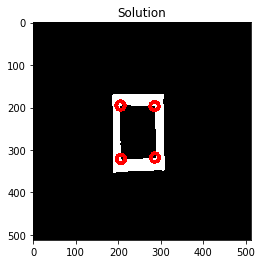

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9912.png
[{'area': 13348, 'centroid': (244, 258), 'corners': array([[255.50288, 255.4991 ],
       [288.42407, 188.57593],
       [199.22597, 191.4514 ],
       [290.16348, 325.9164 ],
       [201.32997, 327.67157]], dtype=float32)}, {'area': 28566, 'centroid': (245, 259), 'corners': array([[255.50269, 255.49883],
       [309.1925 , 154.55606],
       [177.32845, 163.32994],
       [311.48978, 359.21112],
       [180.34276, 361.65463]], dtype=float32)}]


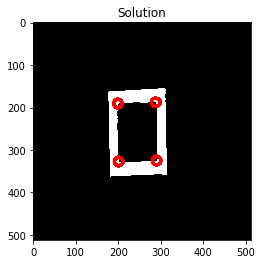

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6237.png
[{'area': 7809, 'centroid': (237, 310), 'corners': array([[255.5055 , 255.48488],
       [213.53268, 239.58025],
       [265.37613, 257.90134],
       [212.20338, 376.49478],
       [263.67004, 373.6716 ]], dtype=float32)}, {'area': 17286, 'centroid': (238, 313), 'corners': array([[255.5055 , 255.48476],
       [197.81876, 207.81876],
       [280.87335, 232.6898 ],
       [282.30994, 401.87378],
       [196.32845, 409.67007]], dtype=float32)}]


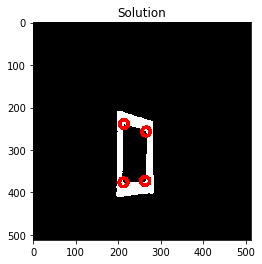

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6225.png
[{'area': 5520, 'centroid': (233, 321), 'corners': array([[255.50668, 255.48158],
       [215.18234, 260.53625],
       [255.42746, 273.6314 ],
       [211.81877, 379.18124],
       [252.21834, 377.21832]], dtype=float32)}, {'area': 12390, 'centroid': (233, 323), 'corners': array([[255.50664, 255.48166],
       [202.18245, 230.5362 ],
       [267.57965, 251.77913],
       [269.16296, 402.91663],
       [198.56874, 407.8345 ]], dtype=float32)}]


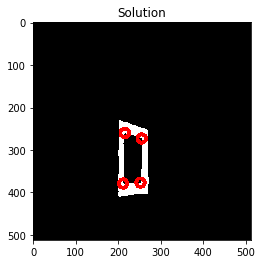

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2985.png
[]
file has only one shape


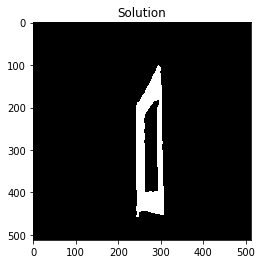

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6049.png
[]
file has only one shape


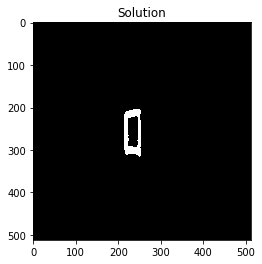

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9243.png
[{'area': 50874, 'centroid': (274, 255), 'corners': array([[255.49484, 255.49979],
       [365.16348, 118.08358],
       [184.91756, 120.91756],
       [184.57593, 390.42407],
       [362.52185, 395.05328]], dtype=float32)}, {'area': 107590, 'centroid': (276, 255), 'corners': array([[255.49457 , 255.49979 ],
       [408.67007 ,  54.328445],
       [143.22614 ,  60.4704  ],
       [143.81879 , 450.1812  ],
       [406.16296 , 459.91696 ]], dtype=float32)}]


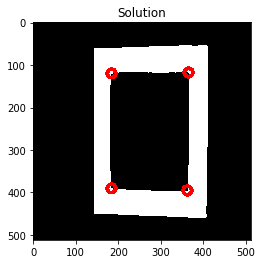

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7722.png
[{'area': 3060, 'centroid': (234, 286), 'corners': array([[255.5057 , 255.4914 ],
       [251.18123, 244.81877],
       [217.61363, 249.32811],
       [250.39192, 325.64276],
       [220.56168, 327.66943]], dtype=float32)}, {'area': 6534, 'centroid': (233, 286), 'corners': array([[255.50584, 255.49168],
       [260.67004, 225.32841],
       [207.83972, 233.26099],
       [206.74762, 341.7307 ],
       [259.24228, 347.21643]], dtype=float32)}]


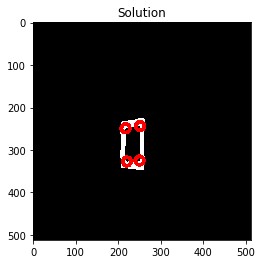

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9660.png
[{'area': 39680, 'centroid': (224, 247), 'corners': array([[255.50931, 255.50377],
       [156.45499, 111.61608],
       [298.18695, 143.0892 ],
       [148.55995, 364.45273],
       [302.47833, 364.52692]], dtype=float32)}, {'area': 89916, 'centroid': (221, 250), 'corners': array([[255.5109  , 255.5041  ],
       [121.79653 ,  44.286438],
       [331.77405 , 102.4514  ],
       [342.1812  , 418.1812  ],
       [105.818794, 426.1812  ]], dtype=float32)}]


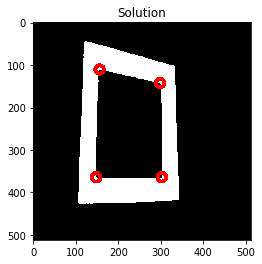

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0446.png
[{'area': 13884, 'centroid': (282, 267), 'corners': array([[255.49242, 255.49712],
       [243.77171, 186.58607],
       [325.22357, 197.27074],
       [324.42407, 339.42407],
       [240.32841, 343.67004]], dtype=float32)}, {'area': 30756, 'centroid': (283, 268), 'corners': array([[255.49222, 255.4969 ],
       [221.75768, 149.78363],
       [349.9167 , 167.8372 ],
       [346.87613, 371.14758],
       [220.16493, 384.43112]], dtype=float32)}]


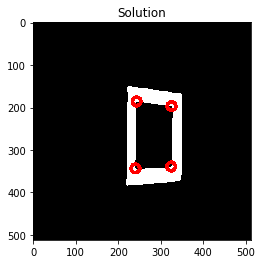

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4290.png
[{'area': 5900, 'centroid': (274, 234), 'corners': array([[255.49466, 255.50604],
       [249.53615, 184.79686],
       [303.10764, 189.0875 ],
       [247.78166, 283.21832],
       [300.6507 , 282.28094]], dtype=float32)}, {'area': 12789, 'centroid': (274, 235), 'corners': array([[255.49464, 255.50543],
       [232.55606, 162.8075 ],
       [319.18115, 166.81886],
       [315.30994, 304.87378],
       [232.81879, 309.1812 ]], dtype=float32)}]


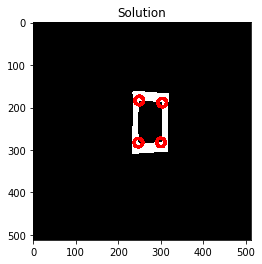

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7784.png
[{'area': 7480, 'centroid': (259, 310), 'corners': array([[255.49841, 255.48492],
       [282.69806, 240.4535 ],
       [233.18924, 255.27133],
       [284.6716 , 374.67004],
       [236.4916 , 374.34064]], dtype=float32)}, {'area': 16884, 'centroid': (258, 312), 'corners': array([[255.49873, 255.48482],
       [295.26462, 205.09492],
       [216.84567, 235.67476],
       [216.81879, 400.1812 ],
       [300.21646, 407.24228]], dtype=float32)}]


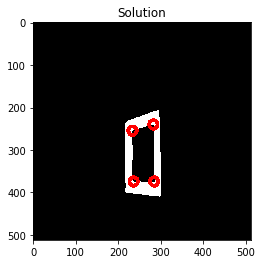

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6859.png
[{'area': 11954, 'centroid': (263, 254), 'corners': array([[255.4977 , 255.50076],
       [303.91077, 184.81322],
       [222.19426, 193.45717],
       [306.2614 , 317.88623],
       [220.1235 , 319.14752]], dtype=float32)}, {'area': 26035, 'centroid': (263, 254), 'corners': array([[255.49776, 255.50082],
       [323.67004, 148.32843],
       [200.74825, 165.26918],
       [326.24228, 352.21643],
       [200.7622 , 352.69455]], dtype=float32)}]


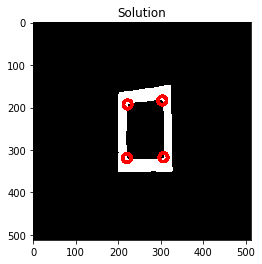

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9510.png
[{'area': 71060, 'centroid': (255, 266), 'corners': array([[255.49979, 255.498  ],
       [159.22679, 103.45084],
       [359.66217, 109.75226],
       [142.76884, 414.7116 ],
       [362.45273, 422.44006]], dtype=float32)}, {'area': 154344, 'centroid': (256, 270), 'corners': array([[255.49979 , 255.49731 ],
       [115.32994 ,  30.328442],
       [406.16296 ,  44.083054],
       [ 87.63757 , 485.53015 ],
       [415.30994 , 500.87378 ]], dtype=float32)}]


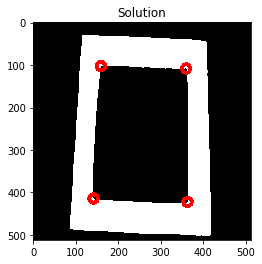

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2261.png
[{'area': 7314, 'centroid': (235, 304), 'corners': array([[255.50543, 255.48654],
       [204.3493 , 251.71906],
       [268.67157, 255.32997],
       [203.34875, 355.28003],
       [266.21725, 355.59286]], dtype=float32)}, {'area': 15345, 'centroid': (236, 305), 'corners': array([[255.50502, 255.48627],
       [188.32994, 227.32845],
       [286.69455, 233.7622 ],
       [188.66794, 381.7385 ],
       [285.5957 , 381.37918]], dtype=float32)}]


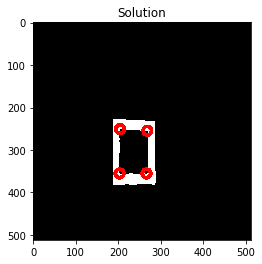

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1979.png
[{'area': 15352, 'centroid': (270, 259), 'corners': array([[255.49594, 255.4989 ],
       [222.08313, 184.8369 ],
       [318.1869 , 184.08919],
       [220.96643, 333.7921 ],
       [319.16287, 333.91663]], dtype=float32)}, {'area': 32929, 'centroid': (271, 260), 'corners': array([[255.49574, 255.4989 ],
       [343.67007, 149.32845],
       [197.78354, 150.75772],
       [196.12389, 367.14758],
       [346.1812 , 370.1812 ]], dtype=float32)}]


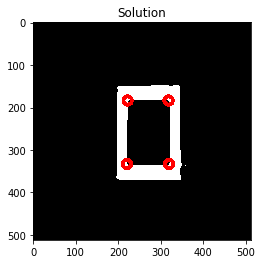

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5798.png
[{'area': 26865, 'centroid': (199, 246), 'corners': array([[255.51524, 255.50241],
       [137.08917, 150.81311],
       [264.1869 , 147.08919],
       [132.7801 , 342.535  ],
       [264.18124, 346.18124]], dtype=float32)}, {'area': 55390, 'centroid': (200, 248), 'corners': array([[255.51532 , 255.50192 ],
       [294.67007 , 103.328445],
       [106.328445, 108.32993 ],
       [106.53369 , 390.69067 ],
       [294.67154 , 393.67007 ]], dtype=float32)}]


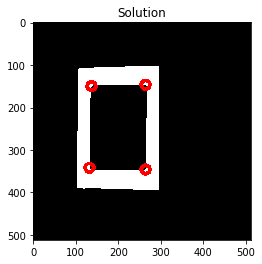

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2048.png
[{'area': 7659, 'centroid': (225, 277), 'corners': array([[259.99957, 259.50003],
       [193.08919, 222.81319],
       [258.1869 , 227.08919],
       [193.32855, 331.67017],
       [257.53012, 330.3624 ]], dtype=float32)}, {'area': 16600, 'centroid': (226, 278), 'corners': array([[259.99957, 259.50003],
       [177.8188 , 192.8188 ],
       [278.73956, 208.92189],
       [178.81322, 359.9108 ],
       [275.2184 , 357.2184 ]], dtype=float32)}]


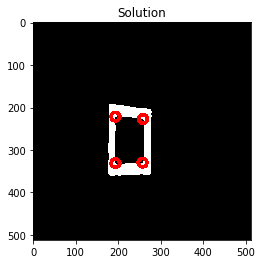

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7747 (1).png
[]
file has only one shape


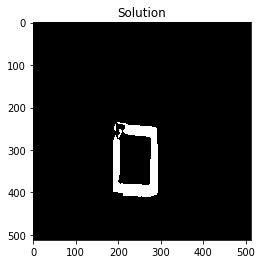

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4935.png
[{'area': 41080, 'centroid': (264, 321), 'corners': array([[255.49742, 255.48248],
       [189.28012, 190.68837],
       [341.44006, 203.54729],
       [343.77322, 439.54916],
       [187.81314, 448.91083]], dtype=float32)}, {'area': 88830, 'centroid': (262, 324), 'corners': array([[255.49915, 255.47914],
       [152.8188 , 131.8188 ],
       [374.39377, 154.44191],
       [382.67007, 491.67154],
       [147.98384, 509.6966 ]], dtype=float32)}]


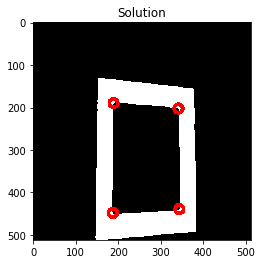

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0030.png
[{'area': 44460, 'centroid': (264, 227), 'corners': array([[255.49731, 255.50818],
       [345.2385 ,  96.30552],
       [182.76898, 102.28835],
       [351.16348, 349.9164 ],
       [180.81296, 353.91046]], dtype=float32)}, {'area': 95250, 'centroid': (265, 228), 'corners': array([[255.49725 , 255.50797 ],
       [385.20892 ,  40.03133 ],
       [144.08333 ,  45.837193],
       [393.9167  , 408.1628  ],
       [139.81886 , 413.18115 ]], dtype=float32)}]


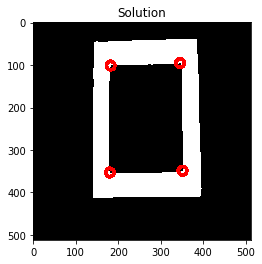

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9518.png
[{'area': 47793, 'centroid': (268, 286), 'corners': array([[255.49629, 255.49217],
       [188.81294, 153.08958],
       [353.51715, 154.55017],
       [177.95241, 410.7853 ],
       [355.8765 , 416.14752]], dtype=float32)}, {'area': 103329, 'centroid': (270, 289), 'corners': array([[255.49608 , 255.49162 ],
       [152.78226 ,  94.40683 ],
       [393.64276 ,  99.608086],
       [132.32793 , 467.16895 ],
       [400.1628  , 480.9167  ]], dtype=float32)}]


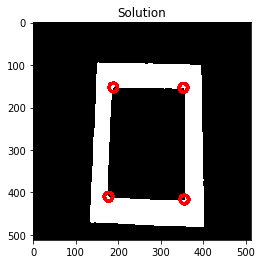

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4326.png
[{'area': 39520, 'centroid': (288, 241), 'corners': array([[255.49052, 255.50392],
       [217.69455, 112.25768],
       [364.4527 , 124.56005],
       [364.90326, 356.1711 ],
       [216.31032, 372.57462]], dtype=float32)}, {'area': 87462, 'centroid': (286, 240), 'corners': array([[255.49146 , 255.50388 ],
       [174.81877 ,  48.818768],
       [400.18677 ,  73.08921 ],
       [401.67007 , 407.67154 ],
       [177.8188  , 436.1812  ]], dtype=float32)}]


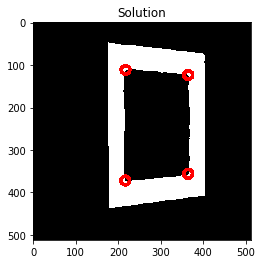

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8891.png
[{'area': 17100, 'centroid': (290, 303), 'corners': array([[255.49077, 255.48701],
       [245.08322, 212.83675],
       [334.18686, 225.08917],
       [334.64136, 386.31534],
       [244.32843, 391.67004]], dtype=float32)}, {'area': 38198, 'centroid': (289, 305), 'corners': array([[255.49104, 255.48645],
       [223.27579, 167.81439],
       [359.16296, 193.08304],
       [362.42416, 420.42416],
       [221.22603, 438.5295 ]], dtype=float32)}]


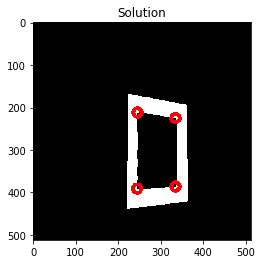

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0094.png
[{'area': 7848, 'centroid': (265, 288), 'corners': array([[255.49725, 255.49094],
       [230.57593, 235.57593],
       [300.42407, 234.57593],
       [230.8369 , 341.91687],
       [301.67004, 341.6716 ]], dtype=float32)}, {'area': 17227, 'centroid': (266, 288), 'corners': array([[255.49698, 255.49094],
       [318.1812 , 206.81879],
       [214.85242, 212.12389],
       [213.81879, 367.1812 ],
       [319.67163, 367.66998]], dtype=float32)}]


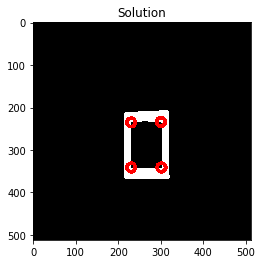

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6647.png
[{'area': 4100, 'centroid': (220, 303), 'corners': array([[255.5097 , 255.48657],
       [237.3927 , 253.38289],
       [199.60901, 264.5197 ],
       [237.5131 , 350.28394],
       [204.47652, 351.92236]], dtype=float32)}, {'area': 9408, 'centroid': (219, 306), 'corners': array([[255.50995, 255.48601],
       [249.67085, 232.39754],
       [188.12428, 244.85213],
       [250.67155, 374.67007],
       [188.18936, 379.09872]], dtype=float32)}]


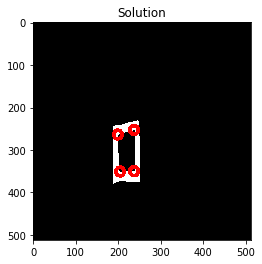

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6932.png
[{'area': 4356, 'centroid': (259, 232), 'corners': array([[255.49886, 255.50671],
       [274.2627 , 181.84784],
       [236.35585, 196.7322 ],
       [276.6512 , 278.28012],
       [244.78123, 278.71698]], dtype=float32)}, {'area': 8260, 'centroid': (259, 231), 'corners': array([[255.4985 , 255.50647],
       [288.18127, 157.81874],
       [229.1262 , 183.69006],
       [233.38889, 296.6111 ],
       [286.42407, 298.4241 ]], dtype=float32)}]


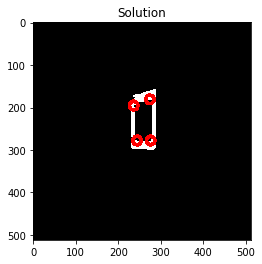

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1543.png
[{'area': 10010, 'centroid': (247, 305), 'corners': array([[255.50284, 255.48657],
       [213.02893, 238.78593],
       [283.6716 , 248.32997],
       [209.78366, 366.24234],
       [282.18704, 365.91046]], dtype=float32)}, {'area': 20979, 'centroid': (248, 307), 'corners': array([[255.502  , 255.48624],
       [196.32997, 209.32841],
       [302.67154, 223.32993],
       [302.56213, 394.03436],
       [193.32845, 398.67007]], dtype=float32)}]


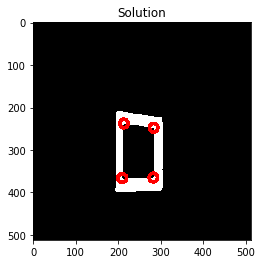

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4516.png
[{'area': 6864, 'centroid': (247, 244), 'corners': array([[255.50233, 255.50296],
       [277.41208, 192.43192],
       [215.08954, 196.81296],
       [214.78885, 291.4899 ],
       [277.41205, 295.56805]], dtype=float32)}, {'area': 14304, 'centroid': (246, 244), 'corners': array([[255.50233, 255.50269],
       [295.67078, 171.39746],
       [197.78886, 175.51016],
       [200.40265, 319.3869 ],
       [293.305  , 319.6711 ]], dtype=float32)}]


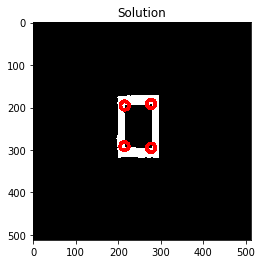

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4674.png
[]
file has only one shape


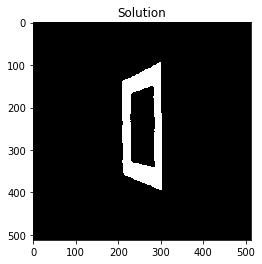

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0823.png
[{'area': 12972, 'centroid': (217, 264), 'corners': array([[255.51038, 255.49753],
       [173.32997, 195.32841],
       [262.4527 , 197.56004],
       [173.81313, 333.91083],
       [261.6507 , 333.28094]], dtype=float32)}, {'area': 27675, 'centroid': (218, 265), 'corners': array([[255.51024, 255.49704],
       [151.35422, 162.71432],
       [282.52386, 164.07782],
       [284.1925 , 367.44394],
       [152.49635, 369.34943]], dtype=float32)}]


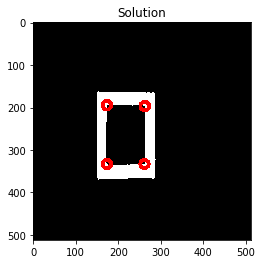

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9779.png
[{'area': 9500, 'centroid': (256, 277), 'corners': array([[255.49973, 255.49388],
       [221.09605, 216.84888],
       [292.91663, 218.83713],
       [291.91687, 334.16312],
       [221.2924 , 342.55807]], dtype=float32)}, {'area': 20165, 'centroid': (256, 279), 'corners': array([[255.49965, 255.49333],
       [203.29301, 187.86874],
       [311.1812 , 192.81879],
       [310.67007, 362.67154],
       [204.79677, 374.7136 ]], dtype=float32)}]


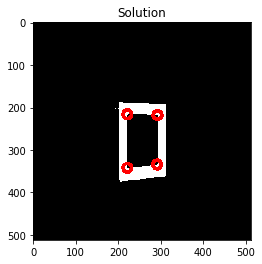

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4843.png
[{'area': 5170, 'centroid': (283, 268), 'corners': array([[255.49231, 255.49643],
       [259.81296, 222.08954],
       [309.90463, 224.84879],
       [257.81876, 314.18124],
       [307.91696, 312.16293]], dtype=float32)}, {'area': 10880, 'centroid': (284, 268), 'corners': array([[255.49217, 255.49629],
       [244.69319, 200.3787 ],
       [323.67154, 205.32993],
       [244.81879, 336.1812 ],
       [322.67007, 333.67154]], dtype=float32)}]


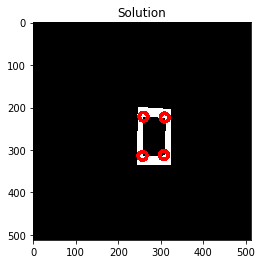

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8760 (1).png
[{'area': 8060, 'centroid': (221, 271), 'corners': array([[255.5095 , 255.49573],
       [192.34929, 208.71909],
       [252.66217, 216.75226],
       [191.12422, 331.1479 ],
       [251.16287, 329.91663]], dtype=float32)}, {'area': 18315, 'centroid': (222, 273), 'corners': array([[255.50987, 255.49583],
       [175.81877, 178.81877],
       [273.41736, 195.79735],
       [270.67007, 354.67154],
       [175.29317, 365.13126]], dtype=float32)}]


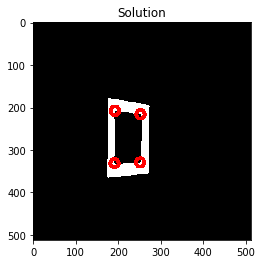

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7737 (1).png
[{'area': 17888, 'centroid': (273, 304), 'corners': array([[255.4951 , 255.48642],
       [224.57596, 217.57596],
       [324.32504, 232.63553],
       [223.32841, 385.67004],
       [324.67004, 386.6716 ]], dtype=float32)}, {'area': 39215, 'centroid': (273, 308), 'corners': array([[255.49532, 255.48601],
       [202.2936 , 174.44139],
       [347.16296, 198.08304],
       [196.57578, 427.42422],
       [352.1628 , 425.9167 ]], dtype=float32)}]


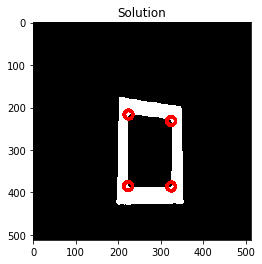

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3915.png
[{'area': 7210, 'centroid': (212, 256), 'corners': array([[255.51181, 255.49973],
       [177.52524, 207.48792],
       [245.91046, 207.81296],
       [179.6604 , 306.5618 ],
       [245.73073, 306.25165]], dtype=float32)}, {'area': 15554, 'centroid': (212, 256), 'corners': array([[255.51154, 255.49965],
       [262.87613, 181.85242],
       [164.81322, 181.08922],
       [263.67154, 330.67007],
       [163.32985, 333.67145]], dtype=float32)}]


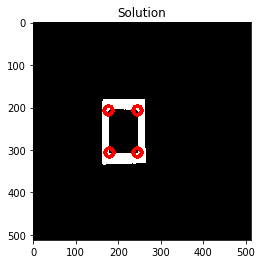

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1267.png
[{'area': 6912, 'centroid': (251, 292), 'corners': array([[255.50128, 255.48997],
       [221.76149, 237.30534],
       [282.23117, 244.28839],
       [281.8765 , 341.14752],
       [220.43437, 344.30927]], dtype=float32)}, {'area': 14758, 'centroid': (252, 293), 'corners': array([[255.50082, 255.48956],
       [206.32994, 214.32845],
       [298.87418, 221.2717 ],
       [298.1479 , 367.87573],
       [206.75772, 372.21643]], dtype=float32)}]


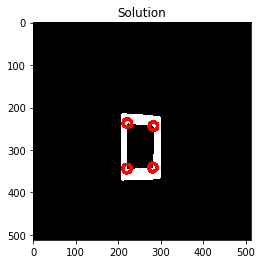

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8456.png
[{'area': 4750, 'centroid': (245, 252), 'corners': array([[255.50327, 255.50124],
       [223.83696, 205.08336],
       [268.15112, 209.09605],
       [221.54726, 297.44016],
       [264.31592, 296.55283]], dtype=float32)}, {'area': 10656, 'centroid': (244, 253), 'corners': array([[255.50284, 255.50056],
       [211.29323, 181.86868],
       [281.9167 , 191.8372 ],
       [278.5237 , 318.92224],
       [209.1108 , 326.46277]], dtype=float32)}]


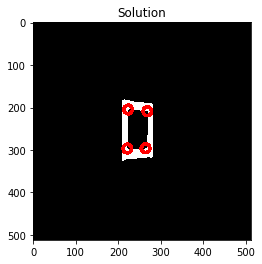

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5396.png
[]
file has only one shape


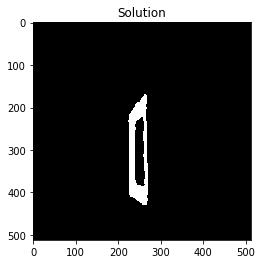

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1254.png
[{'area': 18228, 'centroid': (272, 284), 'corners': array([[255.49565, 255.49277],
       [228.56744, 187.39996],
       [319.53687, 206.59232],
       [320.54858, 367.77405],
       [224.55624, 373.1922 ]], dtype=float32)}, {'area': 40310, 'centroid': (272, 285), 'corners': array([[255.49596, 255.49223],
       [203.48308, 142.5499 ],
       [344.5301 , 171.63747],
       [347.87613, 403.14758],
       [203.78577, 422.68445]], dtype=float32)}]


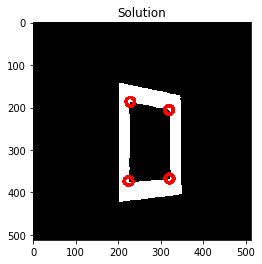

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0813.png
[{'area': 39445, 'centroid': (241, 258), 'corners': array([[255.5033 , 255.49937],
       [169.18187, 134.40509],
       [321.67157, 140.32997],
       [320.91083, 375.1869 ],
       [164.08336, 379.16293]], dtype=float32)}, {'area': 83070, 'centroid': (242, 258), 'corners': array([[255.50337 , 255.49918 ],
       [127.348854,  79.71981 ],
       [359.67154 ,  88.32993 ],
       [360.2184  , 429.2184  ],
       [127.81322 , 435.9108  ]], dtype=float32)}]


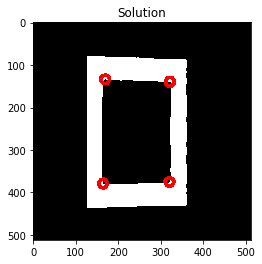

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2115.png
[]
file has only one shape


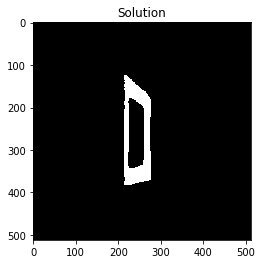

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9031.png
[{'area': 41796, 'centroid': (202, 252), 'corners': array([[255.51448, 255.50156],
       [130.12346, 119.85247],
       [282.1869 , 140.08919],
       [280.6858 , 370.57822],
       [124.2692 , 376.25214]], dtype=float32)}, {'area': 90945, 'centroid': (199, 253), 'corners': array([[255.51663 , 255.50255 ],
       [ 92.28463 ,  51.431393],
       [316.44003 ,  95.5473  ],
       [318.67007 , 422.67154 ],
       [ 83.885765, 439.68295 ]], dtype=float32)}]


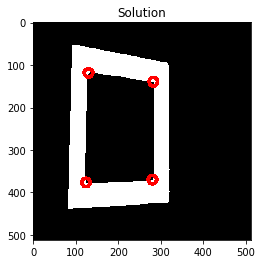

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2879.png
[{'area': 2490, 'centroid': (271, 315), 'corners': array([[255.4955 , 255.4828 ],
       [282.14868, 273.24585],
       [257.3286 , 281.32977],
       [284.43393, 351.22113],
       [259.8521 , 353.87576]], dtype=float32)}, {'area': 5324, 'centroid': (269, 317), 'corners': array([[255.4957 , 255.48293],
       [290.20892, 256.03134],
       [247.5028 , 267.3429 ],
       [247.7835 , 373.24222],
       [290.1266 , 377.61227]], dtype=float32)}]


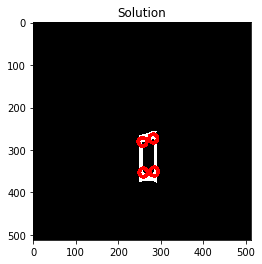

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7440 (1).png
[{'area': 5796, 'centroid': (254, 318), 'corners': array([[254.79219, 256.8864 ],
       [275.18124, 252.81876],
       [232.1244 , 263.85214],
       [234.42177, 377.4302 ],
       [276.67154, 379.67007]], dtype=float32)}]
file has only one shape


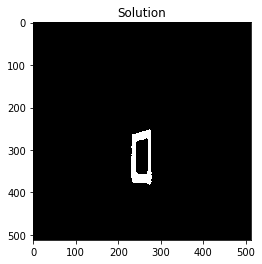

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3424.png
[{'area': 3552, 'centroid': (267, 324), 'corners': array([[255.49657, 255.4807 ],
       [245.28839, 289.76883],
       [290.6716 , 289.32996],
       [245.8369 , 361.91687],
       [289.96896, 361.2089 ]], dtype=float32)}, {'area': 7776, 'centroid': (269, 326), 'corners': array([[255.49635, 255.48056],
       [232.35004, 272.81064],
       [303.1812 , 271.8188 ],
       [304.42416, 379.42416],
       [234.81879, 381.1812 ]], dtype=float32)}]


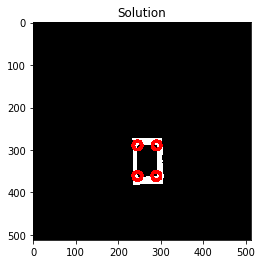

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6655.png
[{'area': 3344, 'centroid': (207, 309), 'corners': array([[255.51389, 255.48419],
       [222.2347 , 266.3486 ],
       [189.57593, 273.57593],
       [224.18123, 350.18124],
       [194.10083, 352.2313 ]], dtype=float32)}, {'area': 7493, 'centroid': (206, 312), 'corners': array([[255.51329, 255.48444],
       [231.6458 , 246.7142 ],
       [178.49615, 258.59067],
       [235.16293, 372.91696],
       [179.56003, 372.4527 ]], dtype=float32)}]


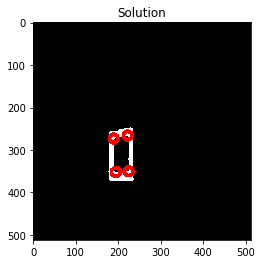

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6906.png
[{'area': 20301, 'centroid': (244, 280), 'corners': array([[255.50198, 255.49419],
       [289.75232, 174.11382],
       [194.71423, 202.35413],
       [292.476  , 368.47604],
       [200.69318, 373.22797]], dtype=float32)}, {'area': 41760, 'centroid': (249, 282), 'corners': array([[255.50128, 255.49348],
       [311.1689 , 125.32792],
       [179.49615, 178.59068],
       [174.32993, 409.67154],
       [320.67078, 413.60242]], dtype=float32)}]


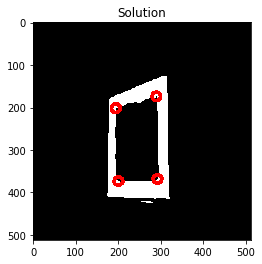

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0284.png
[]
file has only one shape


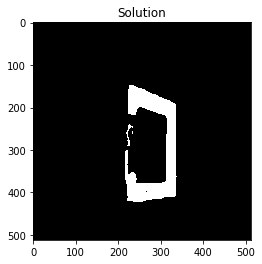

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8649.png
[{'area': 15405, 'centroid': (298, 246), 'corners': array([[255.48833, 255.50304],
       [265.34937, 147.71901],
       [337.91046, 164.81296],
       [334.31586, 331.55286],
       [262.3488 , 342.28006]], dtype=float32)}, {'area': 36722, 'centroid': (298, 246), 'corners': array([[255.48915, 255.50279],
       [245.54546,  94.40909],
       [361.23743, 135.09537],
       [361.9103 , 364.187  ],
       [241.0985 , 394.80276]], dtype=float32)}]


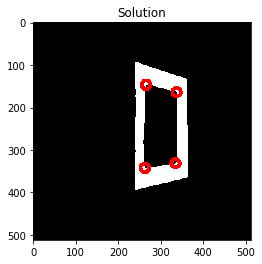

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6868 (1).png
[]
file has only one shape


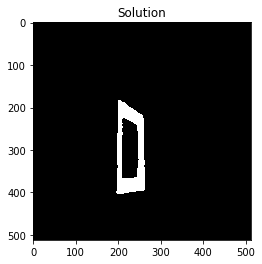

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5947.png
[{'area': 3078, 'centroid': (188, 269), 'corners': array([[255.51857, 255.49614],
       [203.45454, 229.40909],
       [169.62625, 237.6269 ],
       [205.79826, 306.3954 ],
       [172.46992, 307.36252]], dtype=float32)}, {'area': 6426, 'centroid': (186, 271), 'corners': array([[255.51927, 255.49591],
       [211.67001, 211.32838],
       [159.6848 , 220.3586 ],
       [212.67155, 327.67007],
       [160.96584, 329.67496]], dtype=float32)}]


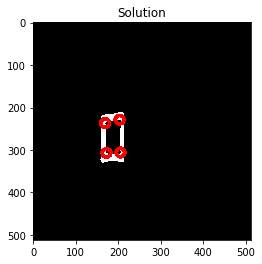

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3991.png
[{'area': 4242, 'centroid': (231, 284), 'corners': array([[255.50653, 255.49223],
       [249.18704, 234.08954],
       [211.08954, 240.81296],
       [249.42403, 332.42404],
       [213.73009, 331.33533]], dtype=float32)}]
file has only one shape


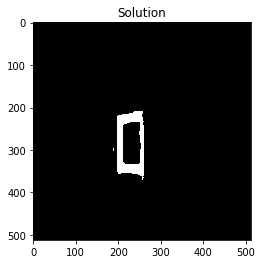

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5427.png
[]
file has only one shape


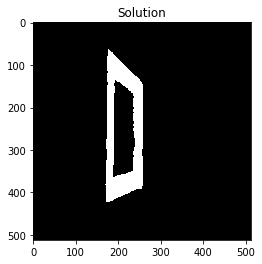

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2621.png
[{'area': 6720, 'centroid': (238, 308), 'corners': array([[255.50484, 255.48544],
       [209.16586, 255.56851],
       [269.18124, 260.81876],
       [207.81877, 359.18124],
       [266.36514, 359.25983]], dtype=float32)}, {'area': 14136, 'centroid': (239, 310), 'corners': array([[255.50462, 255.48512],
       [195.2933 , 230.86879],
       [284.18677, 240.0892 ],
       [192.81879, 384.1812 ],
       [286.28015, 382.65118]], dtype=float32)}]


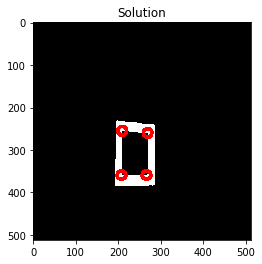

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2346.png
[{'area': 8760, 'centroid': (243, 318), 'corners': array([[255.50308, 255.48276],
       [278.1812 , 257.8188 ],
       [209.81314, 265.08917],
       [279.18124, 374.18124],
       [209.32997, 374.67157]], dtype=float32)}, {'area': 18656, 'centroid': (243, 319), 'corners': array([[255.50343, 255.48253],
       [293.18124, 228.81876],
       [189.52866, 243.25188],
       [292.83347, 403.73932],
       [192.3787 , 404.30682]], dtype=float32)}]


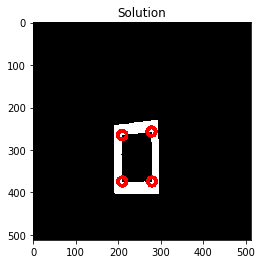

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5410.png
[{'area': 40836, 'centroid': (259, 241), 'corners': array([[255.49863 , 255.50357 ],
       [181.47342 , 118.52154 ],
       [340.19174 , 121.295395],
       [180.76227 , 366.69455 ],
       [339.1479  , 363.87576 ]], dtype=float32)}, {'area': 85323, 'centroid': (259, 243), 'corners': array([[255.49876 , 255.50337 ],
       [142.81879 ,  63.818794],
       [378.4315  ,  68.16582 ],
       [139.76892 , 420.71164 ],
       [379.67017 , 419.67145 ]], dtype=float32)}]


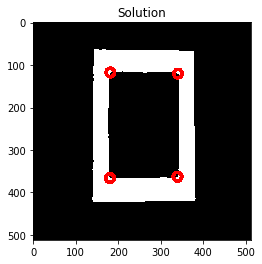

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8151 (1).png
[]
file has only one shape


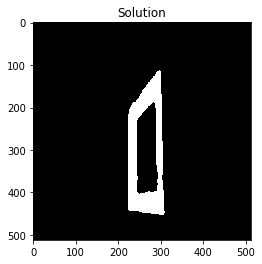

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2203.png
[{'area': 25172, 'centroid': (262, 303), 'corners': array([[255.49889, 255.48746],
       [208.83713, 190.08336],
       [320.1543 , 217.67477],
       [206.81313, 405.91083],
       [321.31   , 403.87366]], dtype=float32)}, {'area': 59040, 'centroid': (261, 306), 'corners': array([[255.4994 , 255.48763],
       [179.81877, 132.81877],
       [346.2236 , 178.27051],
       [354.14578, 448.53738],
       [175.79677, 461.7136 ]], dtype=float32)}]


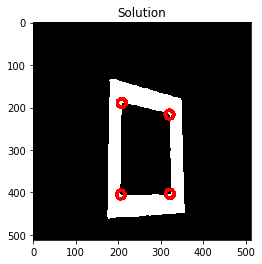

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8128 (1).png
[]
file has only one shape


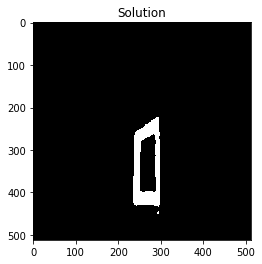

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2744.png
[{'area': 31080, 'centroid': (245, 236), 'corners': array([[255.50269, 255.50601],
       [310.13974, 122.30169],
       [179.43297, 135.81415],
       [315.23114, 339.7116 ],
       [176.3493 , 342.28094]], dtype=float32)}, {'area': 66861, 'centroid': (247, 237), 'corners': array([[255.50229, 255.50587],
       [342.4655 ,  68.49155],
       [148.27003,  92.75644],
       [144.78226, 391.59317],
       [350.11423, 392.68295]], dtype=float32)}]


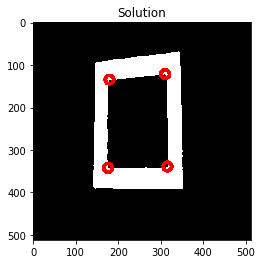

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3750.png
[{'area': 10044, 'centroid': (275, 288), 'corners': array([[255.4943 , 255.49107],
       [236.83714, 227.08336],
       [314.67157, 227.32997],
       [236.81877, 350.18124],
       [315.6507 , 347.28094]], dtype=float32)}, {'area': 21896, 'centroid': (276, 288), 'corners': array([[255.49416, 255.49072],
       [216.08922, 198.81322],
       [335.31018, 197.12662],
       [334.73764, 379.7557 ],
       [218.32845, 382.67007]], dtype=float32)}]


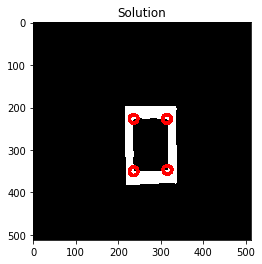

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4602.png
[{'area': 18620, 'centroid': (232, 252), 'corners': array([[255.506  , 255.5014 ],
       [274.38202, 153.43358],
       [186.44717, 170.68405],
       [188.69455, 338.7423 ],
       [277.77423, 349.52936]], dtype=float32)}, {'area': 41736, 'centroid': (233, 253), 'corners': array([[255.50476, 255.50058],
       [298.18124, 103.81876],
       [160.5473 , 136.56001],
       [161.08313, 374.16315],
       [298.97076, 401.21423]], dtype=float32)}]


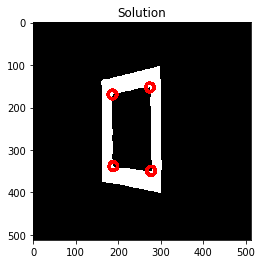

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6915 (1).png
[{'area': 5236, 'centroid': (247, 309), 'corners': array([[254.47003, 256.30618],
       [228.61798, 249.43358],
       [269.25858, 262.32727],
       [228.81877, 366.18124],
       [262.6111 , 366.6111 ]], dtype=float32)}, {'area': 11725, 'centroid': (248, 312), 'corners': array([[254.47003, 256.30618],
       [219.45084, 218.91182],
       [281.9103 , 241.813  ],
       [282.18704, 391.9105 ],
       [215.81879, 395.1812 ]], dtype=float32)}]


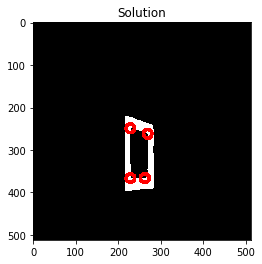

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4039.png
[{'area': 25095, 'centroid': (245, 267), 'corners': array([[255.5032 , 255.4981 ],
       [204.35864, 141.68466],
       [297.50385, 171.59068],
       [296.55237, 368.317  ],
       [195.48508, 378.8996 ]], dtype=float32)}, {'area': 57380, 'centroid': (245, 267), 'corners': array([[255.5035 , 255.49643],
       [186.2645 ,  70.87026],
       [324.15787, 136.56659],
       [327.3529 , 410.2461 ],
       [178.87257, 451.12576]], dtype=float32)}]


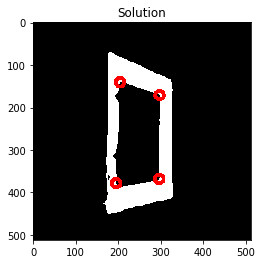

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7728 (1).png
[{'area': 40820, 'centroid': (261, 263), 'corners': array([[255.49895, 255.49953],
       [192.90857, 125.39909],
       [336.08267, 155.91733],
       [184.5378 , 381.46158],
       [340.73935, 382.16013]], dtype=float32)}, {'area': 89770, 'centroid': (258, 265), 'corners': array([[255.4999  , 255.49962 ],
       [155.83711 ,  61.083363],
       [368.67157 , 111.32996 ],
       [376.2282  , 437.41388 ],
       [142.78355 , 443.24228 ]], dtype=float32)}]


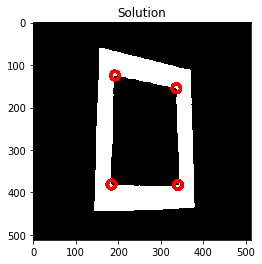

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2638.png
[{'area': 34220, 'centroid': (205, 256), 'corners': array([[255.5147 , 255.50098],
       [141.4255 , 132.1071 ],
       [276.45267, 157.56006],
       [133.57593, 366.42407],
       [278.16287, 365.91663]], dtype=float32)}, {'area': 77088, 'centroid': (203, 259), 'corners': array([[255.51541 , 255.50116 ],
       [106.843445,  71.32236 ],
       [307.54913 , 116.22685 ],
       [315.2479  , 414.6621  ],
       [ 97.16494 , 425.43112 ]], dtype=float32)}]


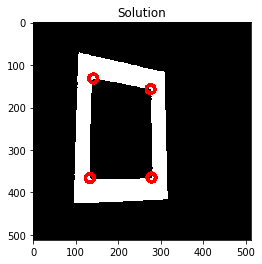

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8422 (1).png
[{'area': 13440, 'centroid': (218, 304), 'corners': array([[255.50996, 255.48668],
       [175.4382 , 235.6604 ],
       [265.5038 , 237.5907 ],
       [172.78166, 373.21832],
       [262.78998, 372.68185]], dtype=float32)}, {'area': 28152, 'centroid': (219, 306), 'corners': array([[255.50975, 255.48613],
       [153.32994, 204.32845],
       [285.64276, 206.60808],
       [287.20264, 406.4174 ],
       [150.83717, 407.91708]], dtype=float32)}]


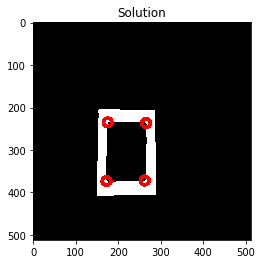

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8136.png
[{'area': 5353, 'centroid': (303, 233), 'corners': array([[255.48656, 255.50633],
       [326.969  , 182.79114],
       [278.12634, 188.68999],
       [327.6716 , 281.67004],
       [279.59064, 280.50388]], dtype=float32)}, {'area': 11466, 'centroid': (303, 233), 'corners': array([[255.48663, 255.50613],
       [342.56805, 160.58797],
       [263.83704, 170.08305],
       [265.32993, 300.67154],
       [339.20322, 307.7136 ]], dtype=float32)}]


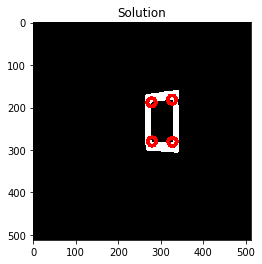

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9980.png
[{'area': 3384, 'centroid': (213, 271), 'corners': array([[255.51154, 255.49553],
       [192.56563, 236.00719],
       [235.18689, 236.08917],
       [191.8369 , 306.91687],
       [235.14787, 305.87576]], dtype=float32)}, {'area': 7140, 'centroid': (213, 271), 'corners': array([[255.51154, 255.49547],
       [179.32994, 220.32845],
       [247.18121, 219.8188 ],
       [247.1628 , 322.9167 ],
       [180.58795, 325.56805]], dtype=float32)}]


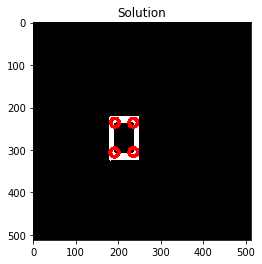

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3004.png
[]
file has only one shape


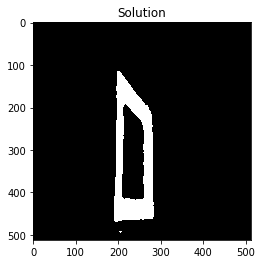

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8749 (1).png
[]
file has only one shape


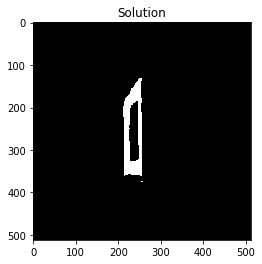

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3513.png
[{'area': 2368, 'centroid': (238, 317), 'corners': array([[255.50461, 255.48311],
       [220.83713, 286.08337],
       [256.18124, 286.81876],
       [221.60016, 347.262  ],
       [255.42407, 347.42407]], dtype=float32)}, {'area': 5415, 'centroid': (239, 318), 'corners': array([[255.50447, 255.48276],
       [212.12389, 271.85242],
       [266.87573, 271.8521 ],
       [211.32845, 366.67007],
       [265.3685 , 364.42758]], dtype=float32)}]


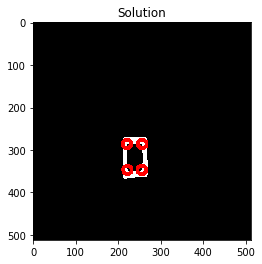

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8232 (1).png
[]
file has only one shape


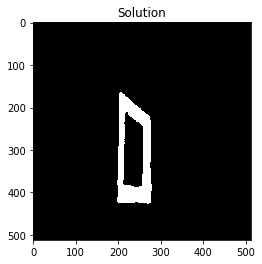

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7182 (1).png
[{'area': 7704, 'centroid': (263, 307), 'corners': array([[255.49786, 255.48572],
       [230.57593, 255.57593],
       [298.44177, 256.55832],
       [229.32841, 358.67004],
       [295.83414, 360.4315 ]], dtype=float32)}, {'area': 15965, 'centroid': (264, 309), 'corners': array([[255.49753, 255.48523],
       [214.8188 , 231.81879],
       [315.1812 , 233.81879],
       [213.22614, 385.5296 ],
       [315.1628 , 385.9167 ]], dtype=float32)}]


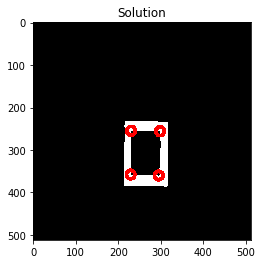

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1788.png
[]
file has only one shape


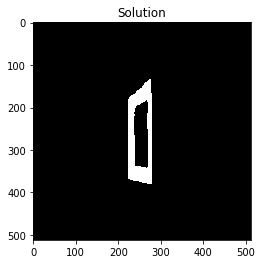

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9417.png
[{'area': 9963, 'centroid': (219, 277), 'corners': array([[255.50983, 255.49396],
       [181.54729, 218.55995],
       [257.65125, 217.71997],
       [179.69077, 335.5656 ],
       [259.67004, 337.6716 ]], dtype=float32)}, {'area': 20585, 'centroid': (219, 278), 'corners': array([[255.50983, 255.49374],
       [277.2165 , 188.75778],
       [163.34886, 192.71979],
       [163.29239, 365.55804],
       [275.7075 , 368.5581 ]], dtype=float32)}]


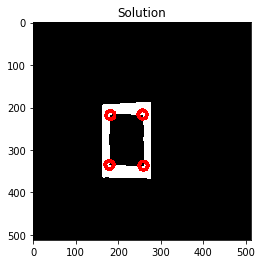

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7979 (1).png
[{'area': 30688, 'centroid': (281, 301), 'corners': array([[255.492  , 255.48856],
       [342.26263, 183.1948 ],
       [217.38516, 205.10957],
       [349.4999 , 403.27277],
       [211.78166, 404.21832]], dtype=float32)}, {'area': 66912, 'centroid': (284, 302), 'corners': array([[255.49113, 255.4887 ],
       [373.70663, 127.44151],
       [185.75641, 168.27014],
       [181.32993, 450.67154],
       [383.72998, 458.24356]], dtype=float32)}]


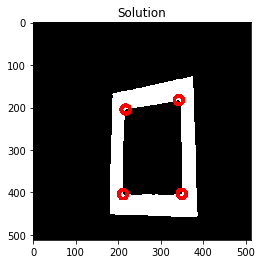

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7304.png
[{'area': 6386, 'centroid': (270, 238), 'corners': array([[255.49591, 255.505  ],
       [243.81296, 187.08954],
       [299.67157, 191.32997],
       [241.08336, 287.16284],
       [297.87326, 286.31024]], dtype=float32)}, {'area': 13261, 'centroid': (270, 238), 'corners': array([[255.49591, 255.5049 ],
       [226.32996, 163.32841],
       [314.67154, 171.32993],
       [314.1812 , 309.1812 ],
       [227.60225, 312.2484 ]], dtype=float32)}]


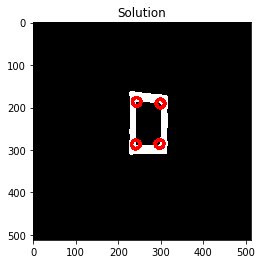

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3632.png
[{'area': 2542, 'centroid': (238, 247), 'corners': array([[255.50467, 255.50221],
       [255.22829, 216.58607],
       [217.63835, 222.60532],
       [256.65125, 277.28003],
       [220.68999, 276.87366]], dtype=float32)}, {'area': 5460, 'centroid': (239, 248), 'corners': array([[255.5044 , 255.502  ],
       [208.79106, 204.03133],
       [269.67206, 204.83104],
       [208.58261, 292.20264],
       [268.91653, 292.16327]], dtype=float32)}]


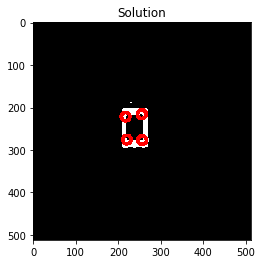

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6816 (1).png
[]
file has only one shape


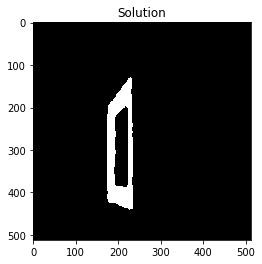

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4730.png
[]
file has only one shape


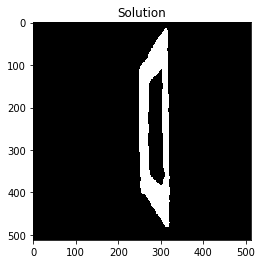

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4469.png
[{'area': 7314, 'centroid': (270, 238), 'corners': array([[255.49594, 255.50467],
       [303.67004, 187.32841],
       [236.71906, 189.3493 ],
       [302.6716 , 288.67004],
       [237.83713, 289.91663]], dtype=float32)}, {'area': 15554, 'centroid': (269, 238), 'corners': array([[255.49608, 255.5044 ],
       [319.60242, 161.32922],
       [218.52866, 167.25188],
       [319.1812 , 314.1812 ],
       [220.81886, 315.18115]], dtype=float32)}]


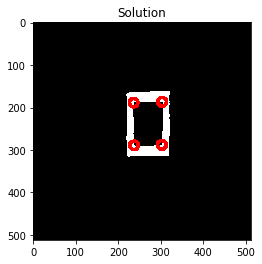

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3503.png
[{'area': 2030, 'centroid': (290, 310), 'corners': array([[255.49045, 255.48473],
       [276.83057, 281.32788],
       [304.18686, 282.08917],
       [273.57254, 335.3686 ],
       [306.9108 , 335.1869 ]], dtype=float32)}, {'area': 4368, 'centroid': (291, 310), 'corners': array([[255.48997, 255.48509],
       [267.22675, 268.4509 ],
       [316.2184 , 267.7816 ],
       [266.7816 , 353.2184 ],
       [315.45523, 350.95023]], dtype=float32)}]


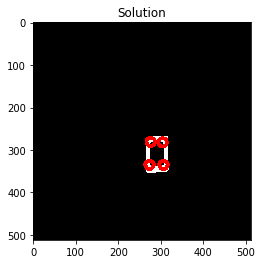

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8232.png
[]
file has only one shape


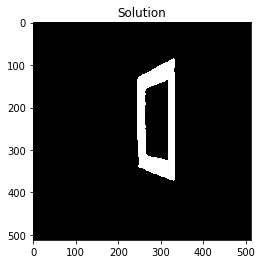

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9563.png
[{'area': 58491, 'centroid': (227, 245), 'corners': array([[255.50708, 255.50343],
       [143.22588,  95.46732],
       [323.54916, 106.22678],
       [127.63142, 383.42746],
       [328.30157, 382.926  ]], dtype=float32)}, {'area': 128527, 'centroid': (227, 248), 'corners': array([[255.50742 , 255.5031  ],
       [ 98.818794,  26.818794],
       [366.1812  ,  48.818794],
       [ 73.78355 , 448.24228 ],
       [375.67007 , 452.67154 ]], dtype=float32)}]


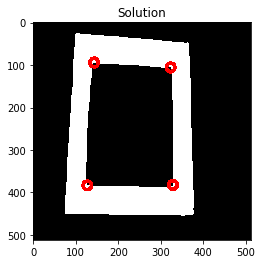

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7013.png
[{'area': 8220, 'centroid': (266, 274), 'corners': array([[255.49702, 255.49524],
       [243.74323, 203.32974],
       [294.33966, 217.43817],
       [237.38889, 332.6111 ],
       [293.64136, 338.31534]], dtype=float32)}, {'area': 19320, 'centroid': (266, 275), 'corners': array([[255.49825, 255.49486],
       [223.79106, 168.03133],
       [311.2311 , 195.28838],
       [221.08336, 370.16302],
       [296.65363, 376.80038]], dtype=float32)}]


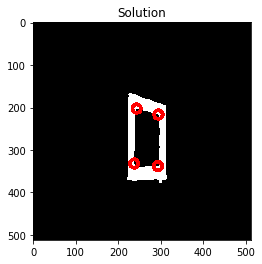

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9562.png
[{'area': 60564, 'centroid': (247, 243), 'corners': array([[255.50186, 255.50398],
       [159.5102 ,  92.78887],
       [343.31024, 101.12674],
       [143.96544, 382.56232],
       [348.7116 , 385.23114]], dtype=float32)}, {'area': 131886, 'centroid': (248, 247), 'corners': array([[255.50192 , 255.50351 ],
       [116.165504,  24.568747],
       [385.67157 ,  40.329933],
       [ 93.328445, 450.67007 ],
       [399.1628  , 454.9167  ]], dtype=float32)}]


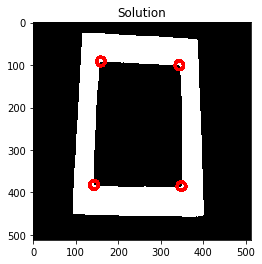

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7627.png
[{'area': 44082, 'centroid': (248, 274), 'corners': array([[255.50128, 255.4962 ],
       [320.3115 , 127.98164],
       [170.49617, 157.5907 ],
       [168.08919, 399.1869 ],
       [326.42407, 406.42407]], dtype=float32)}, {'area': 99066, 'centroid': (252, 275), 'corners': array([[255.49948 , 255.49672 ],
       [356.57065 ,  55.901848],
       [135.32843 , 112.329956],
       [131.32993 , 452.67154 ],
       [369.1812  , 475.1812  ]], dtype=float32)}]


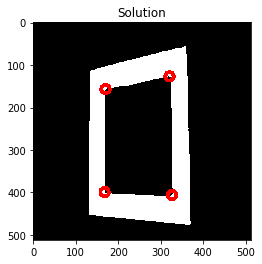

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9766.png
[{'area': 65637, 'centroid': (236, 226), 'corners': array([[255.50494, 255.50934],
       [330.17807,  73.34781],
       [141.32841,  84.32996],
       [349.39102, 358.48032],
       [128.19284, 366.73264]], dtype=float32)}, {'area': 143115, 'centroid': (237, 231), 'corners': array([[255.50494  , 255.50851  ],
       [369.1139   ,   7.3171587],
       [ 99.08953  ,  21.812954 ],
       [404.87573  , 426.1479   ],
       [ 75.75773  , 442.21646  ]], dtype=float32)}]


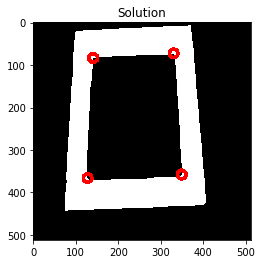

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1600.png
[{'area': 6936, 'centroid': (260, 308), 'corners': array([[255.49863, 255.48523],
       [292.4999 , 259.72723],
       [228.32846, 259.32993],
       [293.18124, 358.18124],
       [228.69635, 359.6677 ]], dtype=float32)}, {'area': 15000, 'centroid': (260, 309), 'corners': array([[255.49855, 255.48509],
       [309.90894, 234.80644],
       [211.08333, 236.83719],
       [310.28024, 382.65112],
       [211.83704, 383.91663]], dtype=float32)}]


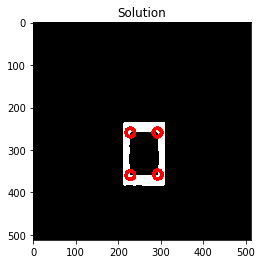

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5450.png
[]
file has only one shape


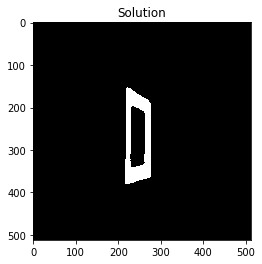

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6024.png
[{'area': 12352, 'centroid': (216, 253), 'corners': array([[255.51062, 255.50076],
       [245.97075, 152.78583],
       [184.12395, 176.85216],
       [184.8609 , 337.92148],
       [245.83417, 347.4315 ]], dtype=float32)}]
file has only one shape


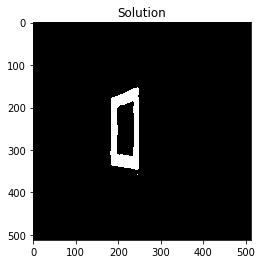

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7974.png
[{'area': 14535, 'centroid': (222, 317), 'corners': array([[255.50879, 255.48302],
       [261.77133, 230.37515],
       [181.76886, 244.28839],
       [180.57591, 394.42407],
       [261.3633 , 402.4854 ]], dtype=float32)}, {'area': 32131, 'centroid': (223, 319), 'corners': array([[255.50836, 255.48222],
       [284.7728 , 190.46973],
       [161.6745 , 216.74754],
       [157.81297, 426.9105 ],
       [283.70758, 445.55807]], dtype=float32)}]


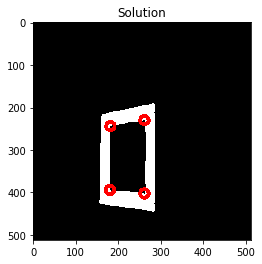

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7115.png
[{'area': 13680, 'centroid': (266, 250), 'corners': array([[255.497  , 255.50204],
       [307.64136, 172.68468],
       [223.78165, 182.78165],
       [310.21432, 317.55927],
       [222.56004, 322.4527 ]], dtype=float32)}, {'area': 30016, 'centroid': (267, 250), 'corners': array([[255.49615, 255.5026 ],
       [330.18124, 132.81876],
       [200.71977, 155.34888],
       [198.81886, 354.18115],
       [331.83505, 358.43112]], dtype=float32)}]


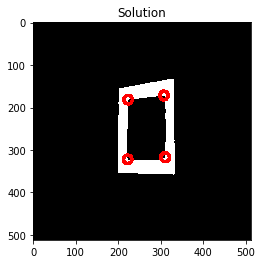

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2010.png
[{'area': 6600, 'centroid': (275, 259), 'corners': array([[255.4945 , 255.49904],
       [245.09605, 209.84888],
       [307.16348, 212.08357],
       [244.32841, 307.67004],
       [306.16287, 306.91663]], dtype=float32)}, {'area': 13630, 'centroid': (276, 260), 'corners': array([[255.49416, 255.49883],
       [230.32994, 187.32845],
       [323.16296, 190.08305],
       [230.08951, 331.187  ],
       [323.67007, 330.67154]], dtype=float32)}]


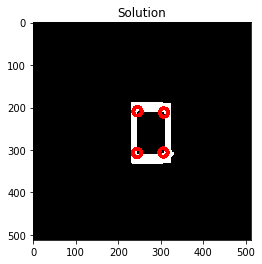

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5756.png
[{'area': 9360, 'centroid': (210, 261), 'corners': array([[255.5123 , 255.49841],
       [173.43768, 203.96544],
       [249.28094, 204.3493 ],
       [171.6953 , 318.59882],
       [248.72641, 318.2734 ]], dtype=float32)}, {'area': 19895, 'centroid': (209, 262), 'corners': array([[255.51257, 255.49814],
       [265.16156, 175.34288],
       [153.57584, 178.57584],
       [267.209  , 346.96875],
       [153.79736, 349.4174 ]], dtype=float32)}]


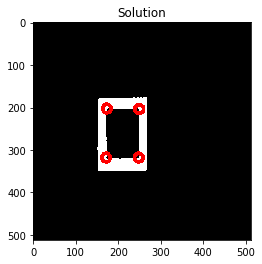

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2074.png
[{'area': 7540, 'centroid': (272, 276), 'corners': array([[255.49551, 255.49438],
       [240.81877, 217.81877],
       [303.3624 , 224.46986],
       [240.5584 , 332.44177],
       [302.52185, 331.05328]], dtype=float32)}, {'area': 16954, 'centroid': (272, 277), 'corners': array([[255.49515, 255.49422],
       [228.77173, 186.58604],
       [322.43124, 202.1655 ],
       [320.18704, 358.9105 ],
       [228.20212, 363.39798]], dtype=float32)}]


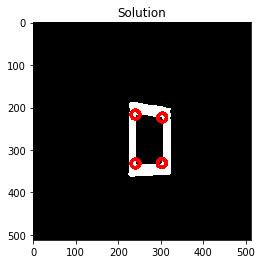

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2824.png
[{'area': 3520, 'centroid': (252, 329), 'corners': array([[255.50081, 255.4792 ],
       [266.48355, 284.46878],
       [232.63643, 295.26007],
       [269.67154, 367.67007],
       [236.31401, 369.57803]], dtype=float32)}, {'area': 7467, 'centroid': (251, 330), 'corners': array([[255.5008 , 255.47943],
       [277.558  , 264.29233],
       [222.57239, 276.63153],
       [277.41208, 392.5681 ],
       [226.63654, 394.1012 ]], dtype=float32)}]


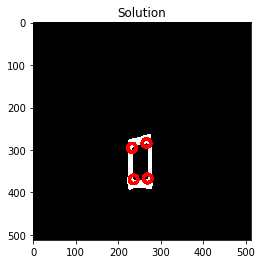

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3147.png
[{'area': 7210, 'centroid': (278, 267), 'corners': array([[255.4936 , 255.4967 ],
       [244.84879, 217.09535],
       [312.23117, 217.28839],
       [244.81877, 319.18124],
       [312.42407, 317.42407]], dtype=float32)}, {'area': 15759, 'centroid': (279, 267), 'corners': array([[255.49341, 255.49677],
       [328.67007, 191.32845],
       [229.32845, 192.32994],
       [331.1812 , 342.1812 ],
       [231.35422, 344.28568]], dtype=float32)}]


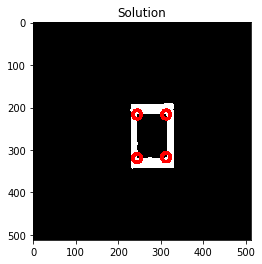

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2969.png
[]
file has only one shape


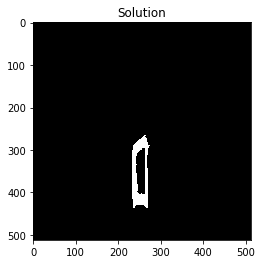

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9953.png
[{'area': 2440, 'centroid': (307, 261), 'corners': array([[255.4855 , 255.49828],
       [289.53998, 232.67322],
       [327.18124, 231.81877],
       [290.34875, 291.28003],
       [327.16287, 290.91663]], dtype=float32)}, {'area': 5673, 'centroid': (308, 262), 'corners': array([[255.48558, 255.49821],
       [335.67007, 216.32845],
       [278.0833 , 219.8372 ],
       [337.73605, 303.8645 ],
       [281.7622 , 308.69455]], dtype=float32)}]


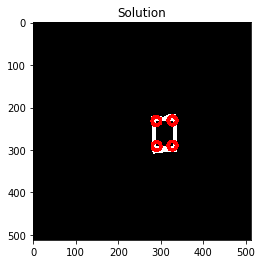

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0326.png
[{'area': 42706, 'centroid': (268, 261), 'corners': array([[255.4965 , 255.49905],
       [344.2026 , 126.58277],
       [189.81877, 143.81877],
       [184.83713, 381.91663],
       [347.4527 , 388.43994]], dtype=float32)}, {'area': 94916, 'centroid': (271, 263), 'corners': array([[255.49582 , 255.49867 ],
       [384.187   ,  66.089676],
       [155.68362 ,  96.593666],
       [145.85213 , 434.87573 ],
       [389.9167  , 455.1628  ]], dtype=float32)}]


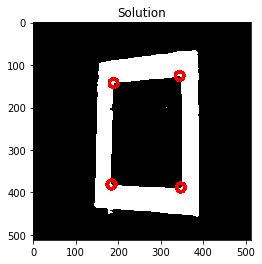

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7416.png
[]
file has only one shape


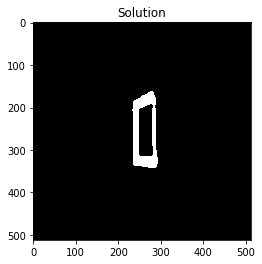

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5690.png
[{'area': 7420, 'centroid': (249, 278), 'corners': array([[255.50172, 255.49347],
       [216.83714, 227.08336],
       [282.81818, 229.18362],
       [215.81877, 331.18124],
       [281.67004, 329.6716 ]], dtype=float32)}, {'area': 15708, 'centroid': (249, 280), 'corners': array([[255.50165, 255.49306],
       [200.08305, 203.83702],
       [299.81595, 204.66754],
       [198.81879, 357.1812 ],
       [298.72986, 357.2436 ]], dtype=float32)}]


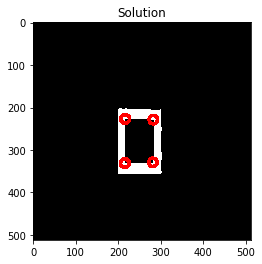

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9175.png
[]
file has only one shape


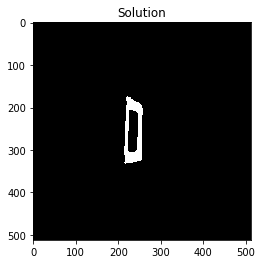

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0341.png
[{'area': 8030, 'centroid': (273, 312), 'corners': array([[255.49512, 255.48448],
       [240.08919, 259.8131 ],
       [307.53012, 260.63748],
       [238.32841, 362.67004],
       [306.14786, 365.87567]], dtype=float32)}, {'area': 17172, 'centroid': (273, 312), 'corners': array([[255.49484, 255.48434],
       [222.7816 , 234.7816 ],
       [327.92236, 237.47652],
       [220.08333, 388.1628 ],
       [326.1812 , 392.1812 ]], dtype=float32)}]


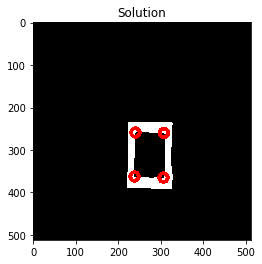

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2759.png
[{'area': 20679, 'centroid': (249, 307), 'corners': array([[255.50175, 255.48602],
       [301.91083, 215.81319],
       [193.76883, 227.28839],
       [303.4093 , 391.5038 ],
       [194.26091, 394.1603 ]], dtype=float32)}, {'area': 45123, 'centroid': (250, 310), 'corners': array([[255.50131, 255.48557],
       [328.1812 , 171.8188 ],
       [168.32845, 193.32994],
       [333.83377, 434.7392 ],
       [166.4514 , 437.77405]], dtype=float32)}]


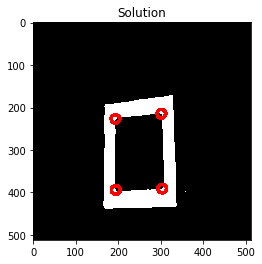

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9128.png
[{'area': 17480, 'centroid': (199, 277), 'corners': array([[255.51634, 255.49467],
       [162.81296, 181.08954],
       [245.23093, 205.28833],
       [154.31802, 361.78986],
       [239.70348, 362.186  ]], dtype=float32)}, {'area': 40040, 'centroid': (197, 279), 'corners': array([[255.51657, 255.49431],
       [140.30208, 129.45367],
       [269.9103 , 177.813  ],
       [264.71164, 398.23108],
       [128.18407, 410.33246]], dtype=float32)}]


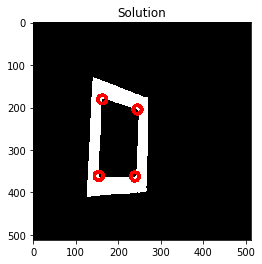

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9631.png
[{'area': 48576, 'centroid': (240, 274), 'corners': array([[255.50385, 255.49567],
       [322.50293, 141.68378],
       [158.32855, 143.32983],
       [333.91663, 396.16287],
       [150.81296, 402.91046]], dtype=float32)}, {'area': 105708, 'centroid': (240, 278), 'corners': array([[255.50406 , 255.49506 ],
       [118.818794,  82.818794],
       [360.1812  ,  88.818794],
       [381.21643 , 455.24228 ],
       [103.818794, 466.1812  ]], dtype=float32)}]


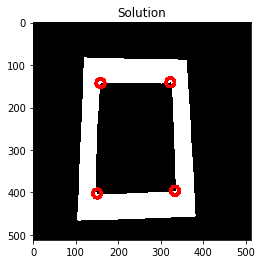

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5526.png
[{'area': 10108, 'centroid': (262, 266), 'corners': array([[255.4983 , 255.4976 ],
       [229.21678, 197.84363],
       [298.73532, 208.2483 ],
       [226.08336, 330.16284],
       [298.42407, 328.42407]], dtype=float32)}, {'area': 22064, 'centroid': (262, 267), 'corners': array([[255.49782, 255.49698],
       [211.29341, 166.4415 ],
       [320.28568, 183.35422],
       [318.67007, 357.67154],
       [208.48213, 364.6939 ]], dtype=float32)}]


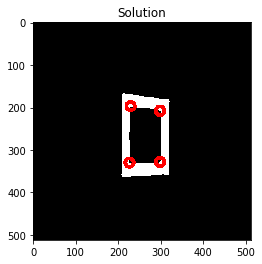

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5351.png
[]
file has only one shape


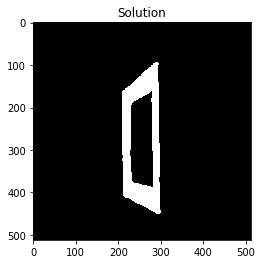

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4932.png
[{'area': 47040, 'centroid': (299, 323), 'corners': array([[255.48763, 255.48196],
       [224.62054, 179.42958],
       [382.27277, 196.50009],
       [383.4804 , 452.39108],
       [217.4699 , 460.36252]], dtype=float32)}, {'area': 99176, 'centroid': (299, 322), 'corners': array([[255.4767 , 255.48837],
       [180.16576, 119.56855],
       [419.28024, 143.34889],
       [428.1479 , 508.87582],
       [364.66666, 510.33334]], dtype=float32)}]


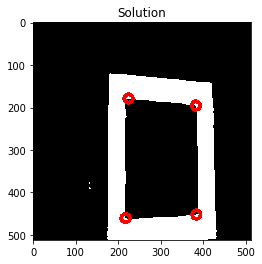

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4209.png
[{'area': 37440, 'centroid': (218, 311), 'corners': array([[257.99954, 252.49997],
       [163.76964, 155.17352],
       [278.92148, 194.8609 ],
       [280.75   , 421.5625 ],
       [161.17929, 467.36444]], dtype=float32)}]
file has only one shape


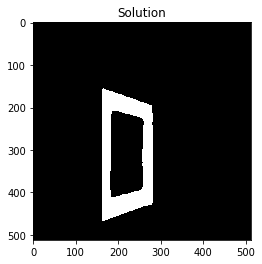

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3396.png
[{'area': 16500, 'centroid': (266, 257), 'corners': array([[255.49677, 255.49863],
       [217.21004, 181.31813],
       [314.67157, 178.32997],
       [220.81313, 333.91083],
       [314.43253, 343.6    ]], dtype=float32)}, {'area': 36408, 'centroid': (267, 258), 'corners': array([[255.49712, 255.49896],
       [338.77246, 136.46948],
       [190.81882, 148.81882],
       [196.43442, 368.30923],
       [336.21423, 384.68445]], dtype=float32)}]


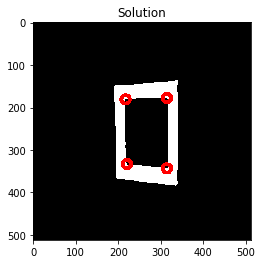

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5531.png
[{'area': 12054, 'centroid': (249, 269), 'corners': array([[255.50194, 255.49632],
       [212.69061, 194.40942],
       [288.04758, 205.2147 ],
       [287.18704, 337.91046],
       [210.35411, 342.28574]], dtype=float32)}, {'area': 26718, 'centroid': (248, 271), 'corners': array([[255.50243, 255.49648],
       [191.83873, 158.34282],
       [310.42416, 178.57585],
       [310.1628 , 369.9167 ],
       [189.0681 , 377.65033]], dtype=float32)}]


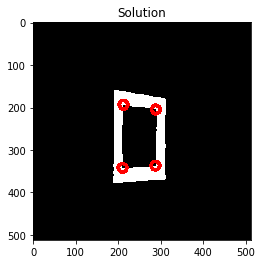

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1894.png
[{'area': 4888, 'centroid': (272, 283), 'corners': array([[251.28741, 253.00099],
       [292.4688 , 230.63953],
       [249.07768, 241.47644],
       [293.90463, 331.1512 ],
       [251.78166, 331.21832]], dtype=float32)}, {'area': 10863, 'centroid': (271, 284), 'corners': array([[251.28741, 253.00099],
       [305.91666, 204.83678],
       [236.08336, 219.83702],
       [236.85213, 354.87573],
       [303.57056, 360.0981 ]], dtype=float32)}]


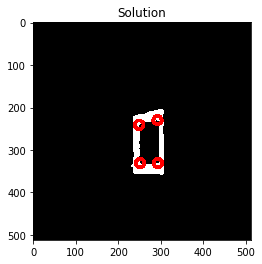

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1167.png
[]
file has only one shape


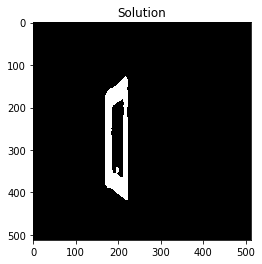

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2432.png
[{'area': 2233, 'centroid': (248, 330), 'corners': array([[255.5018 , 255.47896],
       [259.4476 , 292.26944],
       [235.08954, 297.81296],
       [259.7068 , 368.13123],
       [237.45496, 367.38394]], dtype=float32)}, {'area': 4945, 'centroid': (246, 332), 'corners': array([[255.50214, 255.47885],
       [266.18124, 272.81876],
       [226.1244 , 281.85214],
       [225.75772, 386.21646],
       [266.15814, 389.83533]], dtype=float32)}]


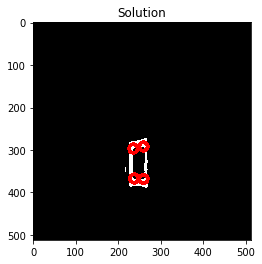

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3459.png
[{'area': 3626, 'centroid': (268, 352), 'corners': array([[255.49643, 255.47328],
       [290.16287, 317.08337],
       [245.4508 , 318.22687],
       [291.18124, 387.18124],
       [249.47652, 388.92236]], dtype=float32)}, {'area': 7739, 'centroid': (268, 353), 'corners': array([[255.49622, 255.47322],
       [303.1812 , 299.8188 ],
       [233.57578, 301.57578],
       [303.2184 , 404.2184 ],
       [236.4013 , 408.30472]], dtype=float32)}]


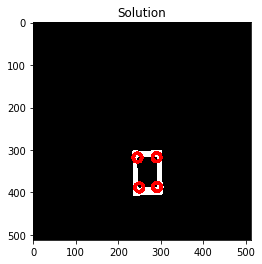

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4854.png
[{'area': 8946, 'centroid': (280, 306), 'corners': array([[255.49336, 255.48592],
       [248.29329, 242.44153],
       [313.26593, 249.43275],
       [245.28635, 367.20358],
       [312.21835, 365.21832]], dtype=float32)}, {'area': 19928, 'centroid': (280, 307), 'corners': array([[255.49295, 255.48575],
       [228.8188 , 212.8188 ],
       [333.65454, 224.34294],
       [333.42422, 393.42422],
       [228.81879, 401.1812 ]], dtype=float32)}]


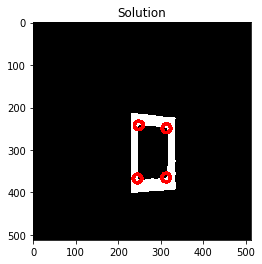

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7607.png
[{'area': 6527, 'centroid': (231, 272), 'corners': array([[255.50636, 255.49521],
       [262.4417 , 219.55832],
       [203.32841, 223.32997],
       [202.78166, 323.21832],
       [259.18124, 326.18124]], dtype=float32)}, {'area': 14220, 'centroid': (232, 274), 'corners': array([[255.50652, 255.49495],
       [277.67004, 195.32841],
       [188.32845, 203.32994],
       [185.81879, 347.1812 ],
       [274.41205, 353.56805]], dtype=float32)}]


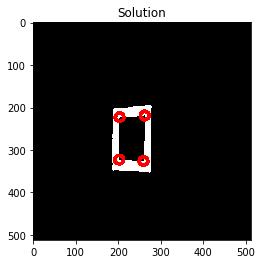

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3354.png
[{'area': 44370, 'centroid': (252, 249), 'corners': array([[255.50055 , 255.50124 ],
       [173.0497  , 120.544785],
       [339.14752 , 131.1235  ],
       [327.545   , 372.3839  ],
       [172.57593 , 379.42407 ]], dtype=float32)}, {'area': 96250, 'centroid': (251, 246), 'corners': array([[255.501   , 255.50229 ],
       [132.0892  ,  55.813213],
       [382.14758 ,  79.123886],
       [364.2184  , 424.2184  ],
       [135.32845 , 440.67007 ]], dtype=float32)}]


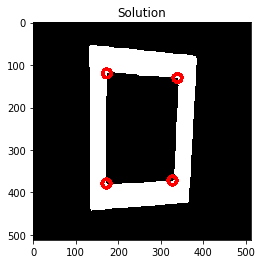

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4032.png
[{'area': 132, 'centroid': (463, 291), 'corners': array([[255.43718, 255.48901],
       [458.1237 , 287.8525 ],
       [468.24234, 285.78366],
       [457.5725 , 295.36856],
       [467.1924 , 298.44385]], dtype=float32)}, {'area': 47967, 'centroid': (316, 246), 'corners': array([[255.4833 , 255.50241],
       [403.52936, 111.22577],
       [228.8227 , 119.66589],
       [402.14752, 378.8765 ],
       [229.1235 , 378.14752]], dtype=float32)}, {'area': 102440, 'centroid': (321, 248), 'corners': array([[255.48283 , 255.50241 ],
       [444.20264 ,  46.582607],
       [188.81879 ,  59.818794],
       [187.09676 , 435.17117 ],
       [447.72934 , 442.22318 ]], dtype=float32)}]
file has more than 2 shapes for a gate, hence quitting 


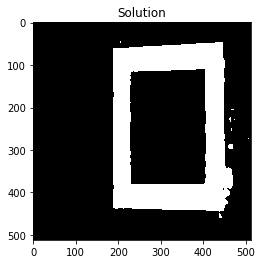

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2886.png
[]
file has only one shape


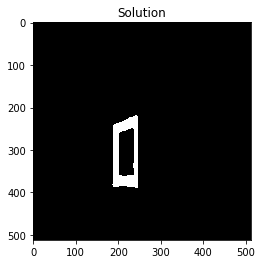

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2480.png
[]
file has only one shape


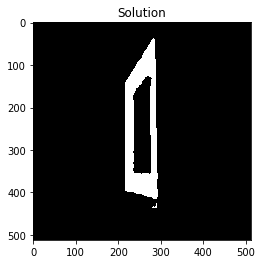

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3706.png
[{'area': 25610, 'centroid': (229, 288), 'corners': array([[255.5068 , 255.49113],
       [168.83698, 189.08336],
       [293.21832, 194.78166],
       [292.7116 , 381.23114],
       [167.32841, 385.67004]], dtype=float32)}, {'area': 54791, 'centroid': (229, 289), 'corners': array([[255.50687, 255.49094],
       [139.7622 , 141.30545],
       [322.1812 , 151.81879],
       [324.46167, 424.46213],
       [136.83704, 434.91696]], dtype=float32)}, {'area': 165, 'centroid': (151, 127), 'corners': array([[255.52823 , 255.53482 ],
       [149.2484  , 118.222755],
       [146.44008 , 128.90009 ],
       [157.88405 , 130.36757 ]], dtype=float32)}]
file has more than 2 shapes for a gate, hence quitting 


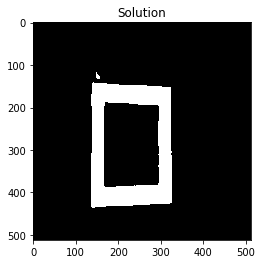

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7738 (1).png
[{'area': 16500, 'centroid': (281, 307), 'corners': array([[255.4932 , 255.48575],
       [235.85213, 224.12424],
       [331.2742 , 240.48581],
       [232.8369 , 385.91687],
       [329.18704, 385.91046]], dtype=float32)}, {'area': 35280, 'centroid': (281, 310), 'corners': array([[255.49274, 255.48544],
       [213.34937, 184.71901],
       [352.18118, 204.81882],
       [356.45267, 422.4402 ],
       [209.62074, 425.6544 ]], dtype=float32)}]


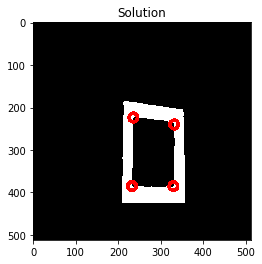

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8937.png
[{'area': 18720, 'centroid': (262, 298), 'corners': array([[255.49904, 255.48878],
       [220.87775, 191.71767],
       [305.4622 , 213.53839],
       [305.50452, 389.05826],
       [219.32841, 399.67004]], dtype=float32)}, {'area': 44341, 'centroid': (260, 300), 'corners': array([[255.50037, 255.48755],
       [196.18245, 135.5362 ],
       [330.73553, 181.24854],
       [333.91687, 425.16315],
       [192.81877, 455.1812 ]], dtype=float32)}]


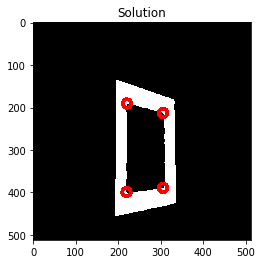

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8104 (1).png
[]
file has only one shape


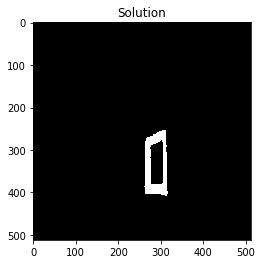

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6872.png
[{'area': 6077, 'centroid': (267, 249), 'corners': array([[255.49637, 255.50227],
       [293.969  , 196.79112],
       [239.42201, 204.31398],
       [293.96866, 298.20895],
       [239.1235 , 296.14752]], dtype=float32)}, {'area': 12963, 'centroid': (266, 248), 'corners': array([[255.49672, 255.50218],
       [309.18124, 171.81877],
       [223.79498, 184.1943 ],
       [310.21646, 319.24228],
       [224.02902, 320.21405]], dtype=float32)}]


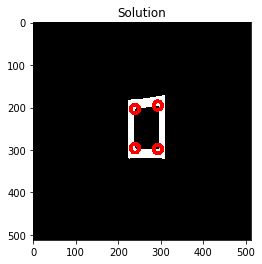

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4810.png
[{'area': 12144, 'centroid': (253, 288), 'corners': array([[255.50037, 255.49062],
       [224.75136, 196.27638],
       [289.26312, 216.52664],
       [286.55283, 365.31595],
       [228.5238 , 377.7143 ]], dtype=float32)}, {'area': 29532, 'centroid': (254, 290), 'corners': array([[255.50168, 255.49005],
       [204.45648, 150.18924],
       [308.21835, 185.78163],
       [310.55283, 400.31595],
       [204.1827 , 425.452  ]], dtype=float32)}]


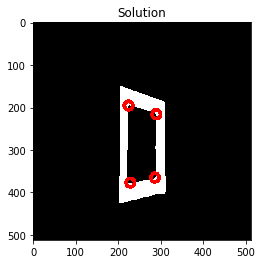

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9973.png
[{'area': 3504, 'centroid': (324, 272), 'corners': array([[255.48058, 255.4954 ],
       [347.18124, 236.81877],
       [302.08954, 239.81296],
       [346.65125, 306.28003],
       [303.32996, 306.6716 ]], dtype=float32)}, {'area': 7420, 'centroid': (325, 272), 'corners': array([[255.48083, 255.49533],
       [359.20892, 220.03133],
       [289.30545, 224.7622 ],
       [358.20322, 323.7136 ],
       [293.32983, 323.67145]], dtype=float32)}]


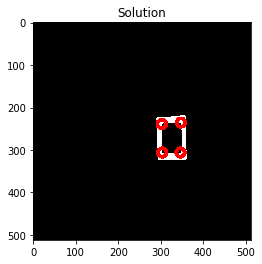

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7228.png
[{'area': 7074, 'centroid': (257, 220), 'corners': array([[255.49986, 255.51038],
       [234.81296, 153.08954],
       [282.55276, 165.68394],
       [231.81877, 283.18124],
       [281.29114, 280.616  ]], dtype=float32)}, {'area': 16236, 'centroid': (257, 219), 'corners': array([[255.50015, 255.51117],
       [220.46107, 113.93942],
       [297.4621 , 141.5383 ],
       [298.87613, 307.14758],
       [217.32845, 313.67007]], dtype=float32)}]


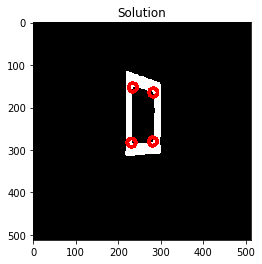

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3957.png
[{'area': 19775, 'centroid': (244, 264), 'corners': array([[255.5031 , 255.49753],
       [191.3493 , 176.71906],
       [299.3624 , 182.46986],
       [187.8873 , 348.25104],
       [299.21835, 348.21832]], dtype=float32)}, {'area': 42662, 'centroid': (245, 265), 'corners': array([[255.50282, 255.49725],
       [164.18413, 135.6675 ],
       [327.1812 , 143.81879],
       [327.37628, 389.1779 ],
       [161.81879, 393.1812 ]], dtype=float32)}]


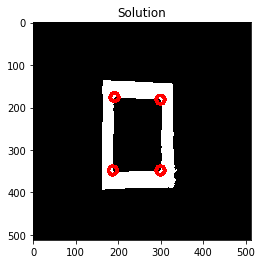

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4382.png
[{'area': 42444, 'centroid': (300, 242), 'corners': array([[255.48709, 255.50343],
       [228.81943, 110.06716],
       [383.18616, 124.10518],
       [380.91083, 364.1869 ],
       [225.51955, 375.3911 ]], dtype=float32)}, {'area': 90860, 'centroid': (299, 243), 'corners': array([[255.48743, 255.5031 ],
       [182.83719,  53.08333],
       [420.28568,  70.35421],
       [418.9108 , 416.18677],
       [184.81879, 438.1812 ]], dtype=float32)}]


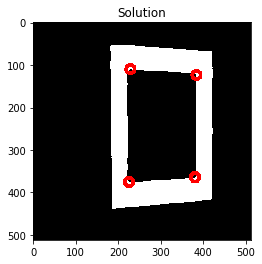

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0557.png
[{'area': 9840, 'centroid': (229, 225), 'corners': array([[255.50722, 255.50804],
       [191.08313, 166.8369 ],
       [268.42407, 166.57593],
       [191.81313, 285.91083],
       [267.18124, 287.18124]], dtype=float32)}, {'area': 20764, 'centroid': (229, 226), 'corners': array([[255.50708, 255.50804],
       [288.19284, 137.09071],
       [172.34886, 138.71979],
       [174.73242, 314.3155 ],
       [285.2184 , 317.2184 ]], dtype=float32)}]


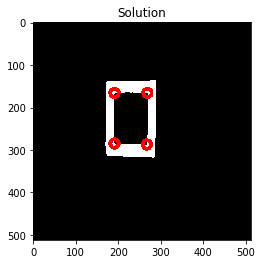

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3002.png
[]
file has only one shape


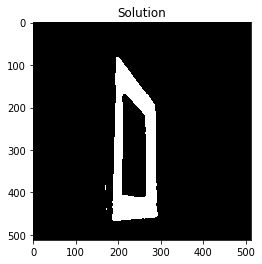

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3580.png
[{'area': 4160, 'centroid': (199, 273), 'corners': array([[255.5156 , 255.49475],
       [174.08917, 236.81311],
       [223.24232, 234.78366],
       [175.52155, 310.52658],
       [222.60251, 313.6709 ]], dtype=float32)}, {'area': 8664, 'centroid': (199, 274), 'corners': array([[255.51538, 255.49484],
       [161.46729, 220.22603],
       [237.18115, 216.81886],
       [162.08333, 331.1628 ],
       [236.87611, 330.14758]], dtype=float32)}]


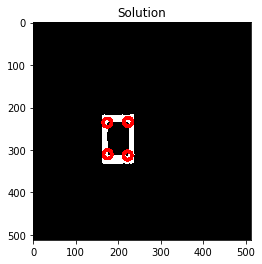

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7512 (1).png
[]
file has only one shape


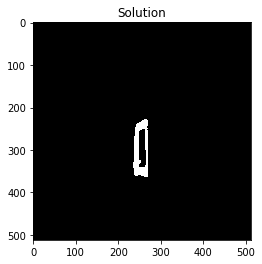

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6360.png
[{'area': 12740, 'centroid': (207, 283), 'corners': array([[255.51346, 255.4922 ],
       [165.32166, 213.20671],
       [252.75708, 224.91508],
       [163.57254, 351.3686 ],
       [250.14159, 349.68607]], dtype=float32)}, {'area': 27772, 'centroid': (207, 284), 'corners': array([[255.51346, 255.49207],
       [146.78572, 175.31573],
       [273.69455, 192.7622 ],
       [142.83704, 387.91696],
       [269.47318, 386.29938]], dtype=float32)}]


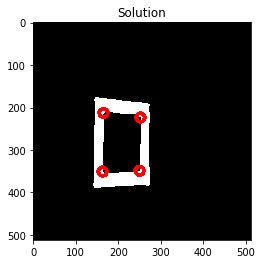

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2276.png
[{'area': 43516, 'centroid': (191, 257), 'corners': array([[255.51762, 255.49994],
       [117.99716, 127.53245],
       [275.21832, 142.78166],
       [107.65626, 378.1333 ],
       [273.72794, 378.87466]], dtype=float32)}, {'area': 93996, 'centroid': (189, 260), 'corners': array([[255.51817 , 255.5002  ],
       [ 80.69641 ,  62.332336],
       [310.67154 ,  95.32993 ],
       [ 62.328445, 436.67007 ],
       [315.4527  , 433.14133 ]], dtype=float32)}]


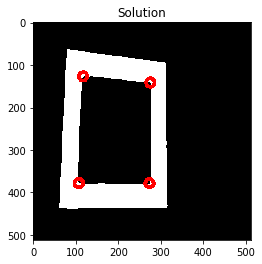

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0195.png
[{'area': 110, 'centroid': (170, 66), 'corners': array([[255.52429, 255.55417],
       [170.61333,  66.22667]], dtype=float32)}, {'area': 120, 'centroid': (170, 19), 'corners': array([[255.52383 , 255.56651 ],
       [172.4762  ,  16.142857],
       [165.113   ,  18.615889],
       [173.89749 ,  24.459593]], dtype=float32)}]
number of points are :  2
I didn't all 5 points of the shape


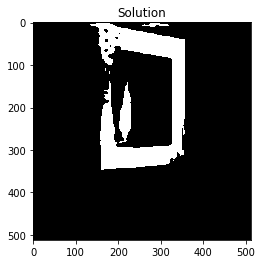

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4897.png
[{'area': 6741, 'centroid': (249, 322), 'corners': array([[255.50177, 255.48149],
       [219.81877, 268.81876],
       [279.29816, 273.29648],
       [219.84889, 374.90393],
       [277.42407, 373.42407]], dtype=float32)}, {'area': 14378, 'centroid': (248, 324), 'corners': array([[255.50183, 255.48123],
       [207.1012 , 242.78717],
       [292.6459 , 250.7143 ],
       [295.67007, 397.67154],
       [203.81879, 402.1812 ]], dtype=float32)}]


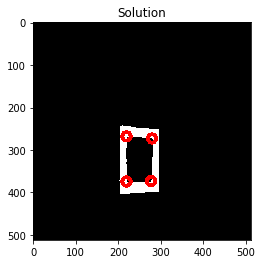

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8943.png
[{'area': 51262, 'centroid': (256, 275), 'corners': array([[255.49983, 255.49432],
       [194.42757,  87.59169],
       [332.70047, 146.63312],
       [332.90347, 415.17126],
       [199.49916, 446.50027]], dtype=float32)}]
file has only one shape


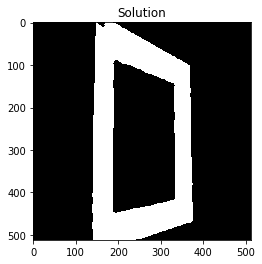

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8633.png
[]
file has only one shape


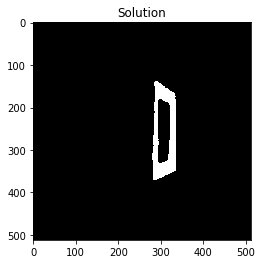

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4961.png
[{'area': 6600, 'centroid': (253, 295), 'corners': array([[255.50099, 255.48886],
       [225.37877, 245.69324],
       [285.30875, 255.8276 ],
       [222.78166, 343.21832],
       [281.6622 , 343.24738]], dtype=float32)}, {'area': 13724, 'centroid': (253, 296), 'corners': array([[255.50055, 255.48853],
       [209.19403, 223.79504],
       [298.64584, 227.71428],
       [297.71164, 366.23108],
       [207.73393, 370.90482]], dtype=float32)}]


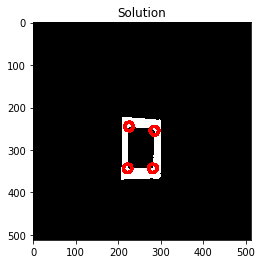

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3951.png
[{'area': 15147, 'centroid': (223, 267), 'corners': array([[255.50879, 255.4969 ],
       [176.52165, 191.4731 ],
       [271.42407, 194.57593],
       [175.32841, 341.67004],
       [271.67004, 340.6716 ]], dtype=float32)}, {'area': 32996, 'centroid': (223, 268), 'corners': array([[255.50859, 255.49649],
       [151.4419 , 156.2925 ],
       [294.96866, 160.79106],
       [296.91696, 375.16296],
       [151.30197, 381.54645]], dtype=float32)}]


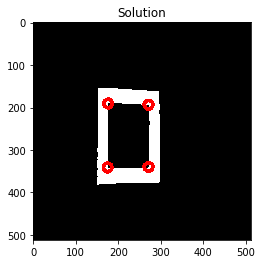

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8008 (1).png
[{'area': 24675, 'centroid': (271, 274), 'corners': array([[255.49522, 255.49574],
       [314.36328, 145.8986 ],
       [219.6022 , 191.34912],
       [322.18124, 378.18124],
       [219.32997, 378.67157]], dtype=float32)}, {'area': 56640, 'centroid': (273, 274), 'corners': array([[255.49435, 255.4935 ],
       [343.2857 ,  79.35417],
       [193.49619, 156.5907 ],
       [193.32455, 426.72028],
       [351.23108, 433.71164]], dtype=float32)}]


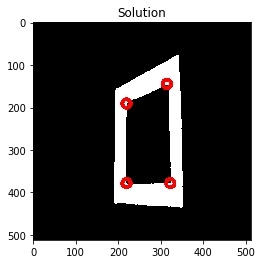

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7492 (1).png
[]
file has only one shape


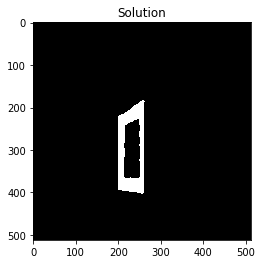

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3036.png
[]
file has only one shape


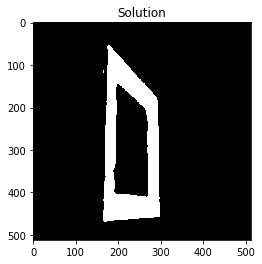

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2099.png
[{'area': 5831, 'centroid': (250, 291), 'corners': array([[255.50201, 255.49039],
       [229.8382 , 230.3426 ],
       [273.14624, 241.65439],
       [227.33783, 347.24774],
       [272.9087 , 346.19366]], dtype=float32)}, {'area': 13200, 'centroid': (250, 291), 'corners': array([[255.50212, 255.49043],
       [214.81876, 199.81876],
       [287.50388, 220.59062],
       [287.71164, 371.23108],
       [215.35408, 377.2857 ]], dtype=float32)}]


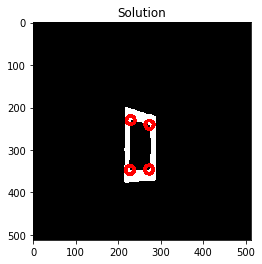

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2648.png
[{'area': 12232, 'centroid': (247, 304), 'corners': array([[255.50252, 255.4867 ],
       [205.43794, 233.96574],
       [288.1869 , 240.08919],
       [204.33784, 372.24777],
       [290.67004, 369.6716 ]], dtype=float32)}, {'area': 26780, 'centroid': (247, 306), 'corners': array([[255.502  , 255.48619],
       [184.32994, 201.32845],
       [310.23096, 211.28835],
       [314.16302, 403.91666],
       [184.68817, 407.5551 ]], dtype=float32)}]


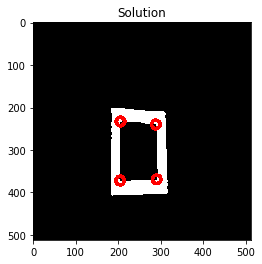

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6829 (1).png
[]
file has only one shape


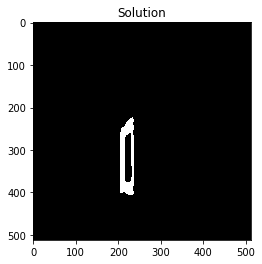

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4624.png
[{'area': 4590, 'centroid': (206, 241), 'corners': array([[255.51341, 255.50407],
       [226.67003, 191.3284 ],
       [184.25   , 201.4375 ],
       [226.56557, 291.3092 ],
       [187.94676, 289.52173]], dtype=float32)}, {'area': 10488, 'centroid': (206, 243), 'corners': array([[255.51358, 255.5036 ],
       [238.18121, 166.81879],
       [171.71977, 177.34888],
       [237.90073, 320.80322],
       [173.73676, 318.98203]], dtype=float32)}]


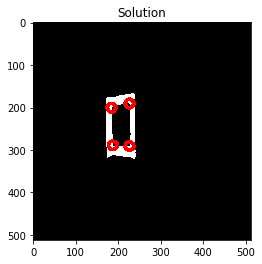

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5578.png
[{'area': 12267, 'centroid': (235, 266), 'corners': array([[255.50565, 255.49701],
       [195.32996, 195.32843],
       [278.6111 , 207.38889],
       [193.81877, 335.18124],
       [275.16287, 332.91663]], dtype=float32)}, {'area': 26289, 'centroid': (235, 267), 'corners': array([[255.50551, 255.49693],
       [173.86876, 163.29318],
       [298.9105 , 176.81297],
       [298.42422, 364.42422],
       [173.32845, 369.67007]], dtype=float32)}]


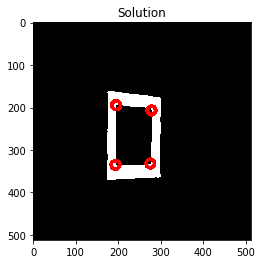

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8090 (1).png
[]
file has only one shape


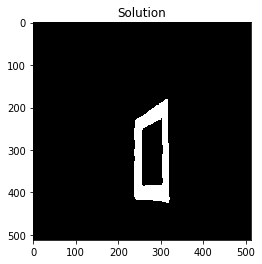

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6734 (1).png
[]
file has only one shape


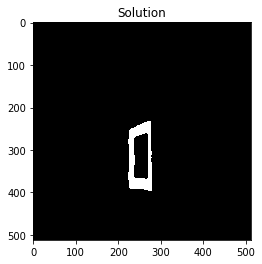

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9737.png
[{'area': 9126, 'centroid': (253, 270), 'corners': array([[255.50067, 255.49567],
       [286.51685, 213.54971],
       [216.68976, 216.12674],
       [290.1869 , 322.91083],
       [219.85211, 327.87573]], dtype=float32)}, {'area': 18871, 'centroid': (254, 271), 'corners': array([[255.50027, 255.49567],
       [305.18115, 187.81885],
       [199.32845, 195.32994],
       [310.67154, 347.67007],
       [202.32993, 353.67154]], dtype=float32)}]


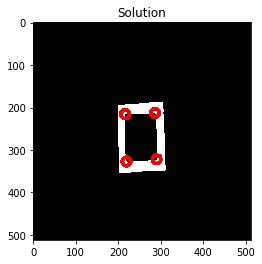

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4753.png
[]
file has only one shape


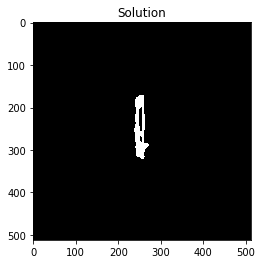

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0414.png
[{'area': 7714, 'centroid': (256, 263), 'corners': array([[255.50015, 255.49837],
       [230.3298 , 196.32858],
       [283.16324, 204.08318],
       [282.9215 , 322.1391 ],
       [229.32841, 328.67004]], dtype=float32)}, {'area': 17622, 'centroid': (256, 263), 'corners': array([[255.5002 , 255.49826],
       [216.29327, 161.44156],
       [301.2184 , 179.7816 ],
       [298.18704, 349.9105 ],
       [215.81316, 362.91083]], dtype=float32)}]


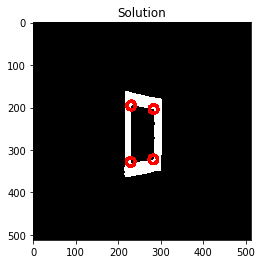

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2041.png
[{'area': 9163, 'centroid': (355, 272), 'corners': array([[255.4726 , 255.49533],
       [317.81876, 213.81877],
       [392.16348, 216.08357],
       [318.3284 , 330.67004],
       [392.6507 , 330.28094]], dtype=float32)}, {'area': 19264, 'centroid': (357, 274), 'corners': array([[255.47205, 255.49498],
       [301.57584, 187.57584],
       [412.18115, 189.81886],
       [302.47305, 358.4783 ],
       [414.1628 , 358.9167 ]], dtype=float32)}]


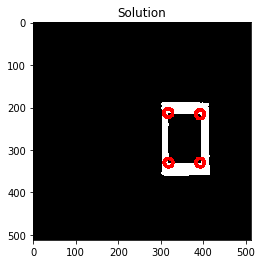

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7581.png
[{'area': 49640, 'centroid': (256, 247), 'corners': array([[255.49893, 255.50339],
       [333.78986,  96.31803],
       [172.44717, 126.68406],
       [170.78166, 380.21832],
       [339.6716 , 388.67004]], dtype=float32)}, {'area': 110189, 'centroid': (260, 248), 'corners': array([[255.49753 , 255.50314 ],
       [374.54858 ,  21.225952],
       [135.19249 ,  80.26775 ],
       [131.8372  , 433.9167  ],
       [382.6715  , 460.6701  ]], dtype=float32)}]


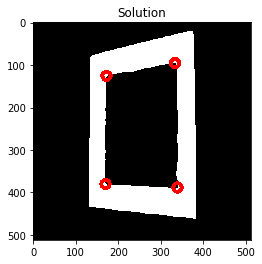

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6850.png
[{'area': 8850, 'centroid': (274, 275), 'corners': array([[255.49472, 255.49466],
       [309.67004, 217.32843],
       [237.46733, 224.22589],
       [311.18124, 331.18124],
       [237.57593, 332.42407]], dtype=float32)}, {'area': 18810, 'centroid': (274, 275), 'corners': array([[255.49466, 255.4947 ],
       [326.67004, 188.32843],
       [220.32845, 198.32994],
       [220.32993, 356.67154],
       [328.447  , 359.80872]], dtype=float32)}]


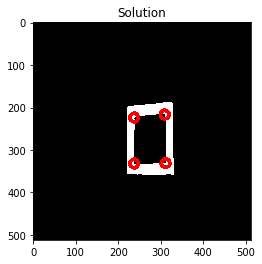

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6806 (1).png
[]
file has only one shape


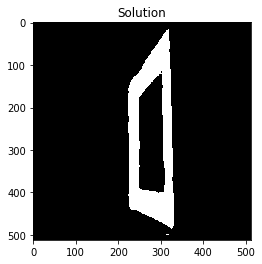

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5144.png
[{'area': 25296, 'centroid': (261, 289), 'corners': array([[255.49826, 255.491  ],
       [318.1713 , 186.09654],
       [201.44719, 198.68402],
       [200.68999, 383.87366],
       [321.7076 , 390.55807]], dtype=float32)}, {'area': 53700, 'centroid': (263, 290), 'corners': array([[255.49794, 255.49063],
       [350.1812 , 138.8188 ],
       [173.08333, 159.83719],
       [172.8372 , 426.9167 ],
       [350.5171 , 439.4499 ]], dtype=float32)}]


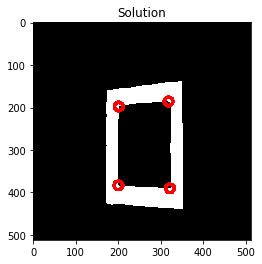

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5784.png
[{'area': 12649, 'centroid': (222, 255), 'corners': array([[255.50906, 255.50014],
       [264.69632, 186.79875],
       [179.55995, 187.54729],
       [267.39102, 321.48032],
       [178.08075, 322.16   ]], dtype=float32)}, {'area': 26796, 'centroid': (222, 256), 'corners': array([[255.509  , 255.49979],
       [289.18118, 153.81882],
       [156.57584, 158.57584],
       [158.51015, 357.21115],
       [285.83377, 358.7392 ]], dtype=float32)}]


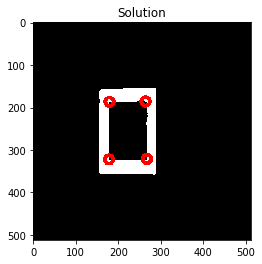

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6178.png
[]
file has only one shape


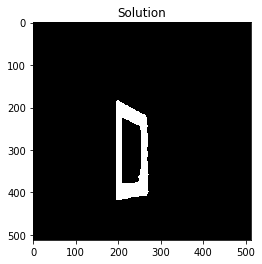

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4852.png
[{'area': 7973, 'centroid': (280, 300), 'corners': array([[255.49329, 255.48756],
       [249.1841 , 240.66751],
       [312.26306, 249.52658],
       [310.43994, 355.4527 ],
       [247.81877, 359.18124]], dtype=float32)}, {'area': 17325, 'centroid': (279, 301), 'corners': array([[255.49307, 255.48726],
       [232.32997, 214.32841],
       [330.3481 , 225.45479],
       [329.1928 , 381.9093 ],
       [232.3787 , 389.30682]], dtype=float32)}]


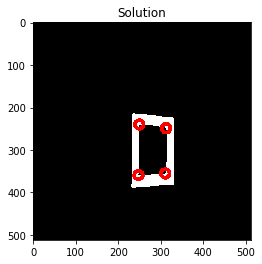

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6960.png
[]
file has only one shape


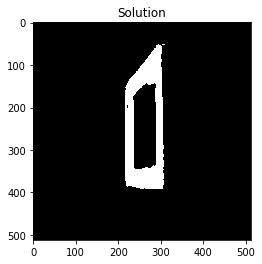

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7878 (1).png
[{'area': 54336, 'centroid': (310, 266), 'corners': array([[255.48444, 255.49818],
       [394.61432, 120.19409],
       [222.81316, 136.08917],
       [406.72955, 397.22302],
       [216.37875, 401.30676]], dtype=float32)}, {'area': 116156, 'centroid': (314, 270), 'corners': array([[255.48338 , 255.49782 ],
       [435.16315 ,  54.288963],
       [182.08951 ,  83.81297 ],
       [178.2841  , 463.09454 ],
       [459.9105  , 464.18704 ]], dtype=float32)}]


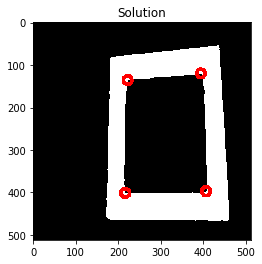

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9902.png
[{'area': 8588, 'centroid': (284, 257), 'corners': array([[255.49196, 255.49965],
       [318.1479 , 201.12434],
       [249.34875, 203.71996],
       [322.18124, 311.18124],
       [249.68504, 310.64148]], dtype=float32)}, {'area': 17985, 'centroid': (285, 257), 'corners': array([[255.49153, 255.4995 ],
       [337.18115, 173.81886],
       [231.27066, 183.77682],
       [339.53198, 337.13657],
       [235.29301, 339.13126]], dtype=float32)}]


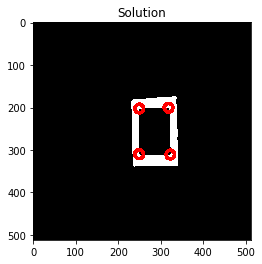

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7995 (1).png
[{'area': 9424, 'centroid': (267, 344), 'corners': array([[255.49654, 255.47546],
       [301.60446, 281.77176],
       [232.12422, 290.8521 ],
       [306.21115, 400.48984],
       [230.81877, 403.18124]], dtype=float32)}, {'area': 19293, 'centroid': (267, 346), 'corners': array([[255.49648, 255.475  ],
       [318.96887, 254.79106],
       [214.32845, 267.32993],
       [214.32993, 430.67154],
       [322.1812 , 432.1812 ]], dtype=float32)}]


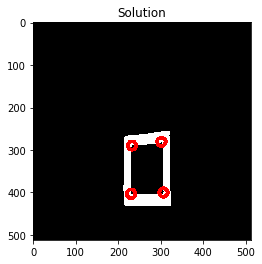

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0648.png
[]
file has only one shape


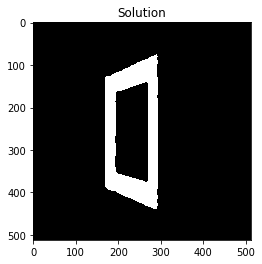

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3770.png
[{'area': 26496, 'centroid': (274, 304), 'corners': array([[255.49464, 255.48691],
       [331.16284, 198.08336],
       [212.31813, 214.21004],
       [214.56004, 402.4527 ],
       [338.31534, 402.64136]], dtype=float32)}, {'area': 57846, 'centroid': (276, 305), 'corners': array([[255.49342, 255.48723],
       [359.67004, 145.32841],
       [183.96587, 176.43796],
       [184.12389, 444.14758],
       [368.67154, 456.67007]], dtype=float32)}]


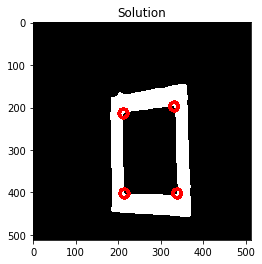

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2257.png
[{'area': 9920, 'centroid': (239, 315), 'corners': array([[256.50006, 254.99919],
       [200.81877, 253.81877],
       [277.91663, 256.83713],
       [278.67004, 373.6716 ],
       [200.81877, 377.18124]], dtype=float32)}, {'area': 21411, 'centroid': (240, 316), 'corners': array([[256.50006, 254.99919],
       [182.32983, 224.32854],
       [295.20322, 228.2864 ],
       [300.24228, 404.21646],
       [184.16493, 408.43112]], dtype=float32)}]


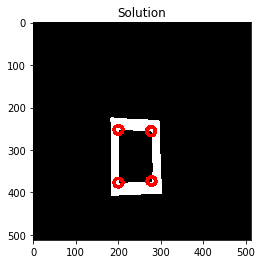

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6183.png
[{'area': 14555, 'centroid': (270, 313), 'corners': array([[255.49617, 255.48466],
       [238.4611 , 203.93942],
       [305.56726, 231.73419],
       [307.16296, 403.91663],
       [237.37863, 412.30685]], dtype=float32)}]
file has only one shape


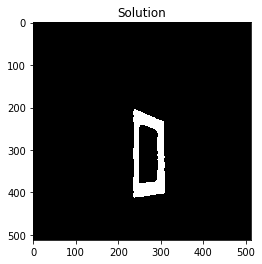

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4487.png
[{'area': 35720, 'centroid': (283, 240), 'corners': array([[255.49223, 255.50412],
       [358.31598, 122.4472 ],
       [209.55995, 127.5473 ],
       [208.32997, 353.67157],
       [357.87366, 357.31   ]], dtype=float32)}, {'area': 76712, 'centroid': (285, 240), 'corners': array([[255.49196 , 255.50406 ],
       [396.3919  ,  68.35723 ],
       [172.83702 ,  80.083046],
       [176.35857 , 403.31516 ],
       [393.67154 , 412.67007 ]], dtype=float32)}]


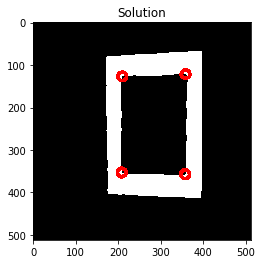

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7442 (1).png
[{'area': 5670, 'centroid': (245, 316), 'corners': array([[255.50015, 253.99944],
       [265.9687 , 251.79105],
       [224.09645, 264.8289 ],
       [266.81754, 377.4519 ],
       [227.90268, 378.07547]], dtype=float32)}]
file has only one shape


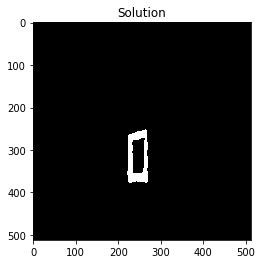

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7082.png
[{'area': 48060, 'centroid': (269, 248), 'corners': array([[255.4958 , 255.50255],
       [187.08919, 111.81312],
       [351.67145, 123.32983],
       [362.384  , 371.5451 ],
       [182.32841, 377.67004]], dtype=float32)}, {'area': 106650, 'centroid': (268, 251), 'corners': array([[255.49594 , 255.502   ],
       [148.08922 ,  48.813217],
       [388.18118 ,  69.818825],
       [407.18118 , 432.18118 ],
       [136.34288 , 442.16156 ]], dtype=float32)}]


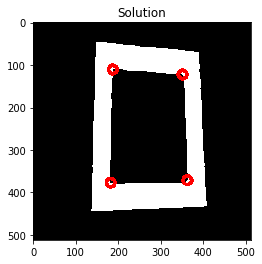

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1130.png
[]
file has only one shape


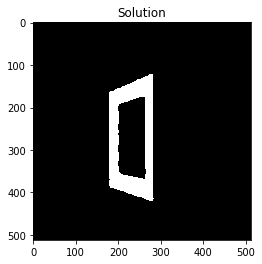

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7532 (1).png
[]
file has only one shape


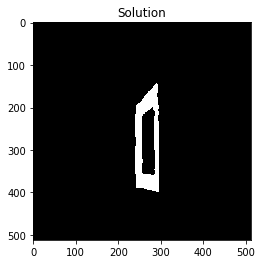

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5779.png
[{'area': 10332, 'centroid': (242, 257), 'corners': array([[255.50371, 255.49945],
       [282.18124, 194.81877],
       [203.08954, 197.81296],
       [201.08357, 318.16348],
       [282.28094, 318.6507 ]], dtype=float32)}, {'area': 22200, 'centroid': (241, 258), 'corners': array([[255.50392, 255.49918],
       [301.77255, 164.46962],
       [181.32793, 172.83105],
       [181.57584, 347.42416],
       [298.54538, 351.3481 ]], dtype=float32)}]


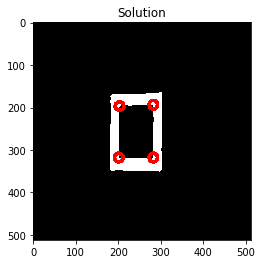

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9907.png
[{'area': 10710, 'centroid': (271, 261), 'corners': array([[255.49547, 255.49835],
       [309.18704, 199.08954],
       [232.37036, 203.37035],
       [314.18124, 321.18124],
       [233.08357, 322.16348]], dtype=float32)}, {'area': 22080, 'centroid': (272, 261), 'corners': array([[255.49513, 255.49841],
       [327.83426, 167.56856],
       [213.52159, 179.4733 ],
       [215.33002, 350.67163],
       [330.9042 , 351.80142]], dtype=float32)}]


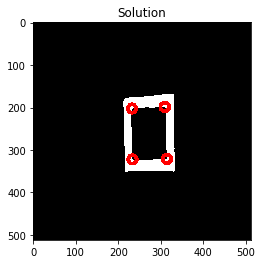

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6971.png
[]
file has only one shape


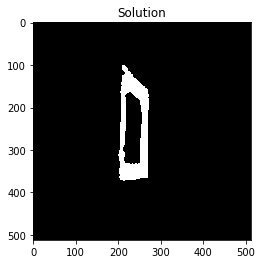

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2617.png
[{'area': 6955, 'centroid': (246, 328), 'corners': array([[255.49994, 255.00081],
       [216.83702, 275.08337],
       [278.3325 , 281.18408],
       [215.81877, 379.18124],
       [275.18704, 378.91046]], dtype=float32)}, {'area': 14508, 'centroid': (247, 329), 'corners': array([[255.49994, 255.00081],
       [203.76225, 248.30544],
       [293.42416, 259.57584],
       [201.32845, 404.67007],
       [294.8762 , 403.1475 ]], dtype=float32)}]


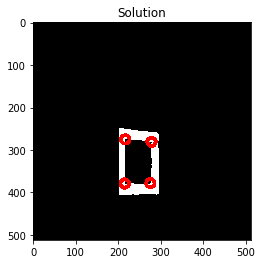

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8603.png
[]
file has only one shape


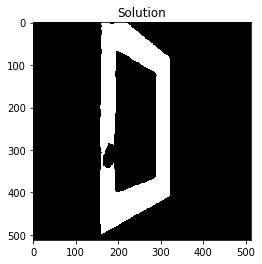

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8358.png
[{'area': 28080, 'centroid': (209, 268), 'corners': array([[255.51285, 255.49622],
       [273.43994, 160.54732],
       [144.76883, 169.28839],
       [144.3493 , 371.28094],
       [272.42407, 375.42407]], dtype=float32)}, {'area': 61304, 'centroid': (210, 269), 'corners': array([[255.51299 , 255.49602 ],
       [303.8342  , 110.5685  ],
       [112.08333 , 127.8372  ],
       [111.818794, 414.1812  ],
       [305.1812  , 427.1812  ]], dtype=float32)}]


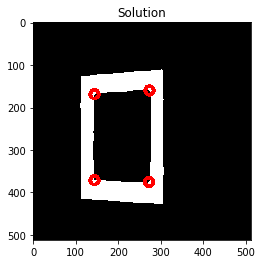

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7481.png
[{'area': 37240, 'centroid': (249, 239), 'corners': array([[255.50262, 255.50615],
       [189.44061,  98.73987],
       [318.24423, 133.61696],
       [314.48032, 356.39102],
       [182.54729, 365.44   ]], dtype=float32)}, {'area': 83230, 'centroid': (245, 238), 'corners': array([[255.50424 , 255.50632 ],
       [152.22754 ,  25.469482],
       [350.23117 ,  92.28839 ],
       [351.45273 , 402.44006 ],
       [145.81879 , 432.1812  ]], dtype=float32)}]


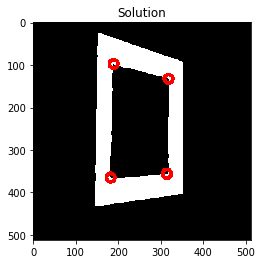

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8728.png
[{'area': 17271, 'centroid': (299, 273), 'corners': array([[255.48792, 255.49533],
       [252.85211, 187.12425],
       [348.25858, 197.3273 ],
       [346.7116 , 353.23114],
       [249.69077, 356.5656 ]], dtype=float32)}, {'area': 37044, 'centroid': (299, 274), 'corners': array([[255.48787, 255.49513],
       [228.75768, 146.78363],
       [371.70685, 162.86874],
       [372.2184 , 388.2184 ],
       [227.79736, 399.4174 ]], dtype=float32)}]


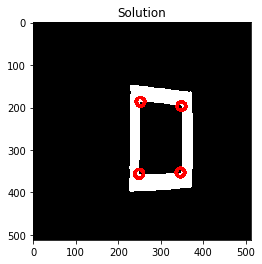

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0946.png
[{'area': 6767, 'centroid': (234, 301), 'corners': array([[255.5057 , 255.48729],
       [203.43768, 252.96544],
       [266.67157, 252.32997],
       [203.82501, 350.6895 ],
       [266.18124, 351.18124]], dtype=float32)}, {'area': 14592, 'centroid': (234, 303), 'corners': array([[255.5057 , 255.48688],
       [282.90894, 226.80644],
       [186.57584, 230.57584],
       [185.7816 , 376.2184 ],
       [282.1812 , 379.1812 ]], dtype=float32)}]


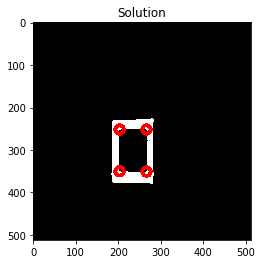

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8728 (1).png
[]
file has only one shape


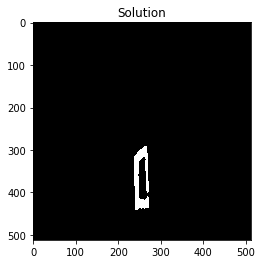

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2133.png
[{'area': 50460, 'centroid': (269, 236), 'corners': array([[255.49559, 255.50731],
       [344.44748,  81.26938],
       [188.45125, 116.87459],
       [181.08357, 367.16348],
       [354.34064, 370.5084 ]], dtype=float32)}, {'area': 110880, 'centroid': (274, 237), 'corners': array([[255.4936 , 255.5081 ],
       [384.26764,   2.6845 ],
       [148.81882,  67.81881],
       [144.67078, 423.41077],
       [395.67154, 444.67007]], dtype=float32)}]


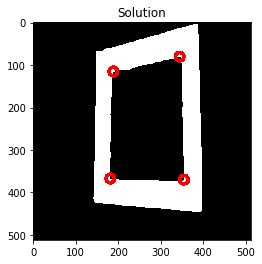

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7062.png
[{'area': 29925, 'centroid': (266, 244), 'corners': array([[255.49754, 255.5043 ],
       [205.46979, 127.6374 ],
       [331.16443, 150.25865],
       [200.71906, 346.6507 ],
       [333.1479 , 349.87576]], dtype=float32)}, {'area': 66531, 'centroid': (264, 245), 'corners': array([[255.49808, 255.50461],
       [173.81877,  68.81877],
       [361.91043, 110.81293],
       [165.78368, 400.24234],
       [366.96875, 398.209  ]], dtype=float32)}]


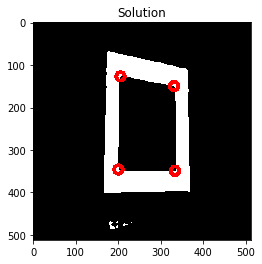

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8773.png
[]
file has only one shape


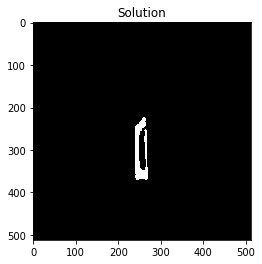

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7343 (1).png
[{'area': 18334, 'centroid': (251, 275), 'corners': array([[255.50078, 255.49518],
       [289.46307, 164.56471],
       [207.9134 , 198.6078 ],
       [207.12663, 366.31018],
       [293.88437, 370.27835]], dtype=float32)}, {'area': 41344, 'centroid': (252, 277), 'corners': array([[255.50027, 255.49521],
       [313.24448, 111.75504],
       [184.53789, 168.5383 ],
       [185.51964, 409.39105],
       [318.6111 , 414.6111 ]], dtype=float32)}]


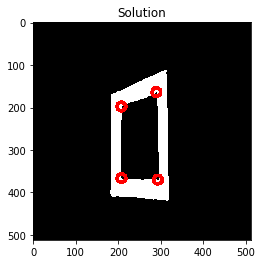

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8692 (1).png
[]
file has only one shape


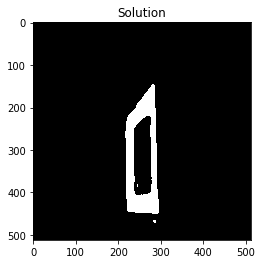

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1190.png
[{'area': 204, 'centroid': (225, 371), 'corners': array([[255.50873, 255.46748],
       [224.43724, 362.385  ],
       [219.52254, 367.64575],
       [231.70805, 369.59656],
       [224.35   , 377.7    ]], dtype=float32)}]
file has only one shape


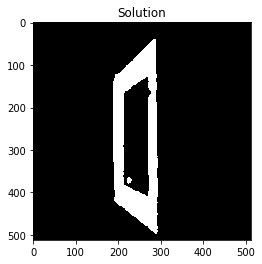

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0497.png
[{'area': 9638, 'centroid': (266, 265), 'corners': array([[255.4969 , 255.49704],
       [229.81877, 204.81877],
       [304.67157, 209.32997],
       [228.81877, 326.18124],
       [303.8765 , 323.14752]], dtype=float32)}, {'area': 19712, 'centroid': (267, 267), 'corners': array([[255.49643, 255.49663],
       [213.08922, 179.81322],
       [323.14758, 183.12389],
       [323.1812 , 353.1812 ],
       [212.83704, 354.91696]], dtype=float32)}]


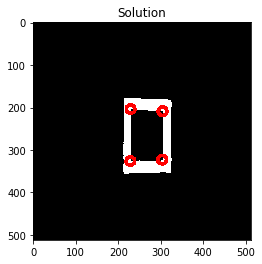

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7939 (1).png
[{'area': 55056, 'centroid': (241, 264), 'corners': array([[255.50293 , 255.49947 ],
       [323.36853 , 107.572464],
       [157.8585  , 140.31396 ],
       [332.87576 , 399.1479  ],
       [148.5197  , 401.39102 ]], dtype=float32)}, {'area': 121275, 'centroid': (245, 267), 'corners': array([[255.50116 , 255.50005 ],
       [362.97064 ,  30.786045],
       [121.08969 ,  90.813   ],
       [104.57578 , 459.42422 ],
       [378.67145 , 472.67017 ]], dtype=float32)}]


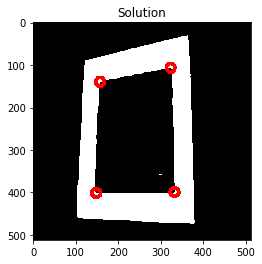

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8015 (1).png
[{'area': 14960, 'centroid': (276, 307), 'corners': array([[255.49362, 255.48633],
       [309.79208, 207.53392],
       [238.14233, 237.74942],
       [314.69806, 389.54648],
       [239.51012, 392.21115]], dtype=float32)}, {'area': 33702, 'centroid': (276, 308), 'corners': array([[255.49367, 255.48636],
       [328.7725 , 157.46954],
       [214.67331, 212.54005],
       [217.4013 , 431.30472],
       [336.67154, 431.67007]], dtype=float32)}]


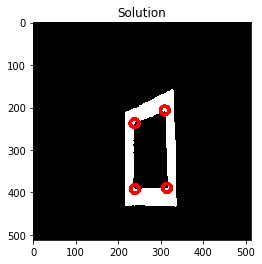

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6896 (1).png
[{'area': 16800, 'centroid': (239, 271), 'corners': array([[255.50499, 255.4943 ],
       [207.42938, 157.90189],
       [278.97662, 199.44453],
       [202.78166, 368.21832],
       [274.316  , 365.5528 ]], dtype=float32)}]
file has only one shape


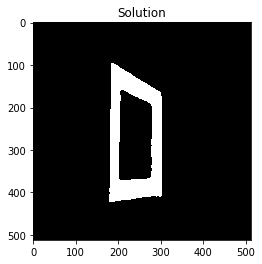

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8337.png
[{'area': 10792, 'centroid': (225, 264), 'corners': array([[255.50838, 255.49763],
       [259.1479 , 194.12436],
       [189.68976, 199.12674],
       [188.56001, 330.4527 ],
       [262.21634, 335.24234]], dtype=float32)}, {'area': 23532, 'centroid': (224, 265), 'corners': array([[255.50842, 255.49704],
       [280.24234, 159.78368],
       [167.38704, 176.51784],
       [167.7816 , 357.2184 ],
       [277.4517 , 373.72852]], dtype=float32)}]


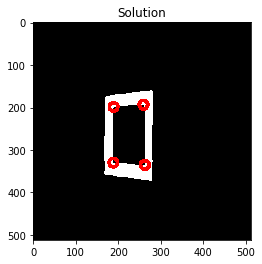

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6093.png
[]
file has only one shape


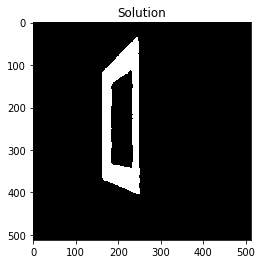

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6019.png
[]
file has only one shape


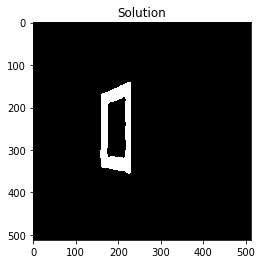

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8207.png
[{'area': 4214, 'centroid': (271, 238), 'corners': array([[251.00072, 256.49994],
       [290.67004, 190.32843],
       [249.2889 , 197.83664],
       [290.18124, 285.18124],
       [257.3889 , 285.6111 ]], dtype=float32)}, {'area': 8804, 'centroid': (270, 239), 'corners': array([[251.00072, 256.49994],
       [301.1812 , 167.81879],
       [240.08955, 177.81294],
       [243.52177, 301.52707],
       [301.3919 , 309.64276]], dtype=float32)}]


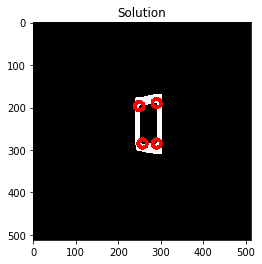

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5238.png
[]
file has only one shape


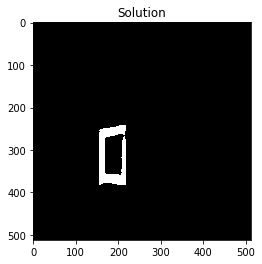

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1149.png
[]
file has only one shape


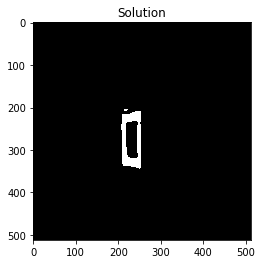

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7030 (1).png
[{'area': 12960, 'centroid': (189, 296), 'corners': array([[255.51852, 255.48907],
       [149.7816 , 223.7816 ],
       [231.79332, 233.91098],
       [144.71906, 362.6507 ],
       [230.91081, 363.1869 ]], dtype=float32)}, {'area': 27170, 'centroid': (188, 297), 'corners': array([[255.51953 , 255.48912 ],
       [129.81877 , 187.81877 ],
       [253.20502 , 209.19426 ],
       [126.510086, 398.21115 ],
       [250.57823 , 396.4302  ]], dtype=float32)}]


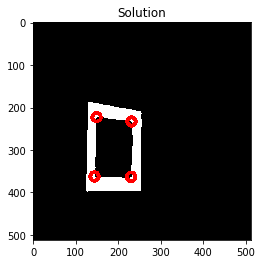

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7284 (1).png
[{'area': 37448, 'centroid': (256, 261), 'corners': array([[255.49898, 255.49982],
       [323.2567 , 130.32974],
       [186.4699 , 155.63747],
       [181.3273 , 376.25858],
       [329.7076 , 378.55807]], dtype=float32)}, {'area': 80373, 'centroid': (259, 262), 'corners': array([[255.4979 , 255.50002],
       [359.4416 ,  68.55823],
       [152.54723, 114.5599 ],
       [148.61034, 425.704  ],
       [367.67145, 436.67017]], dtype=float32)}]


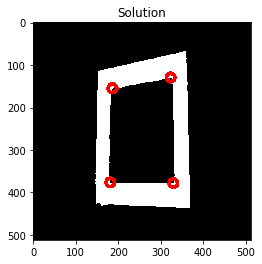

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1535.png
[{'area': 28520, 'centroid': (254, 285), 'corners': array([[255.50127, 255.4929 ],
       [200.75424, 163.49352],
       [314.39984, 192.73799],
       [313.52658, 387.47845],
       [194.32841, 393.67004]], dtype=float32)}, {'area': 62928, 'centroid': (252, 287), 'corners': array([[255.50201, 255.4931 ],
       [168.81877, 107.81876],
       [343.91663, 154.83702],
       [345.91696, 431.16296],
       [162.32845, 450.67007]], dtype=float32)}]


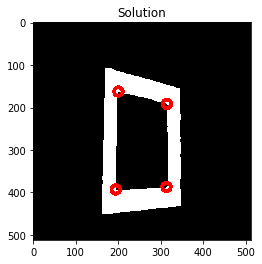

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7213.png
[]
file has only one shape


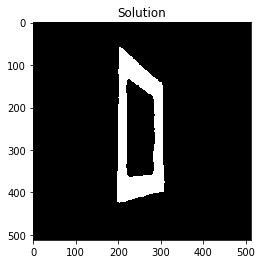

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9331.png
[{'area': 23312, 'centroid': (277, 269), 'corners': array([[255.49396, 255.49615],
       [217.55997, 176.54727],
       [337.14752, 176.1235 ],
       [216.96544, 361.56232],
       [338.16287, 361.91663]], dtype=float32)}, {'area': 48330, 'centroid': (278, 270), 'corners': array([[255.49382, 255.49574],
       [189.08328, 136.83672],
       [366.52173, 135.94675],
       [188.83704, 404.91696],
       [367.18704, 405.91046]], dtype=float32)}]


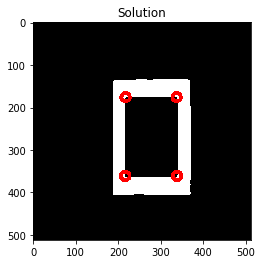

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6830.png
[{'area': 8591, 'centroid': (252, 242), 'corners': array([[255.50102, 255.50407],
       [221.01712, 180.47998],
       [286.16348, 189.08357],
       [218.08954, 298.18704],
       [285.18704, 298.91046]], dtype=float32)}, {'area': 17850, 'centroid': (251, 243), 'corners': array([[255.50082, 255.50343],
       [201.08305, 155.83702],
       [301.30325, 165.00752],
       [202.29251, 327.5581 ],
       [307.13126, 323.70685]], dtype=float32)}]


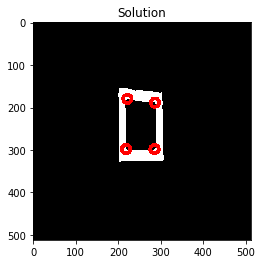

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8194 (1).png
[]
file has only one shape


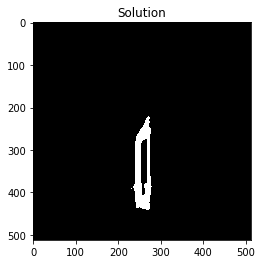

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1522.png
[]
file has only one shape


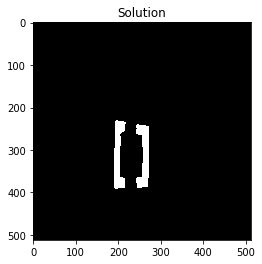

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4157.png
[]
file has only one shape


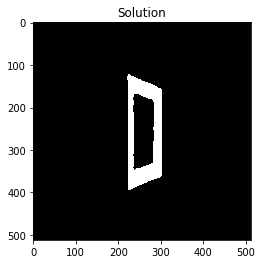

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4396.png
[{'area': 18260, 'centroid': (296, 240), 'corners': array([[255.48874, 255.50412],
       [244.12674, 158.68976],
       [349.44006, 159.54729],
       [243.78166, 324.21832],
       [348.67004, 320.6716 ]], dtype=float32)}, {'area': 38236, 'centroid': (296, 241), 'corners': array([[255.48866 , 255.50385 ],
       [219.79736 , 119.58261 ],
       [376.1812  , 123.818794],
       [373.71164 , 358.23108 ],
       [219.32845 , 363.67007 ]], dtype=float32)}]


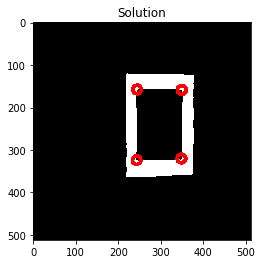

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5092.png
[{'area': 46956, 'centroid': (243, 276), 'corners': array([[255.50339, 255.49469],
       [322.32828, 137.44258],
       [160.79875, 153.30368],
       [157.08357, 405.16348],
       [327.6716 , 410.67004]], dtype=float32)}, {'area': 98952, 'centroid': (246, 278), 'corners': array([[255.50282 , 255.49458 ],
       [364.24234 ,  75.78363 ],
       [123.79736 , 100.58261 ],
       [120.269196, 459.25177 ],
       [368.16296 , 474.91696 ]], dtype=float32)}]


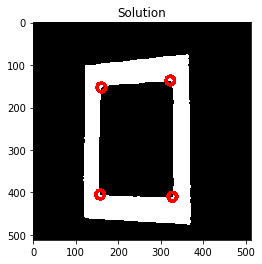

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7434.png
[]
file has only one shape


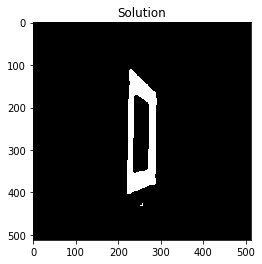

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1369.png
[{'area': 7169, 'centroid': (236, 282), 'corners': array([[255.50505, 255.49248],
       [267.18704, 230.08954],
       [204.54732, 235.56004],
       [267.7076 , 335.55807],
       [206.32997, 333.67157]], dtype=float32)}, {'area': 15386, 'centroid': (236, 284), 'corners': array([[255.50499, 255.49216],
       [283.87643, 205.85248],
       [188.32845, 213.32994],
       [284.2184 , 360.2184 ],
       [192.28265, 361.2956 ]], dtype=float32)}]


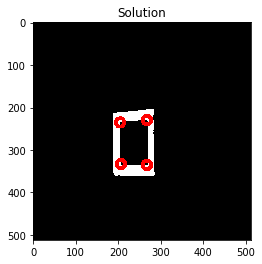

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2248.png
[{'area': 38319, 'centroid': (278, 258), 'corners': array([[255.49355, 255.49951],
       [202.08917, 136.81311],
       [352.14752, 143.1235 ],
       [200.67322, 375.46002],
       [359.67017, 372.67145]], dtype=float32)}, {'area': 85083, 'centroid': (278, 260), 'corners': array([[255.49341 , 255.49924 ],
       [168.34267 ,  76.345314],
       [387.67136 ,  94.32973 ],
       [397.83368 , 427.73923 ],
       [162.32845 , 435.67007 ]], dtype=float32)}]


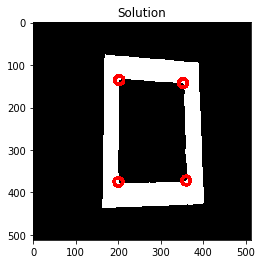

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3210.png
[{'area': 4576, 'centroid': (259, 307), 'corners': array([[255.80219, 259.53223],
       [274.28513, 253.28075],
       [238.57254, 265.6314 ],
       [278.18683, 353.91083],
       [241.32994, 354.67157]], dtype=float32)}, {'area': 10010, 'centroid': (259, 307), 'corners': array([[255.80217, 259.53223],
       [286.40347, 225.36397],
       [227.0807 , 247.84   ],
       [290.15656, 378.67752],
       [227.83704, 378.91663]], dtype=float32)}]


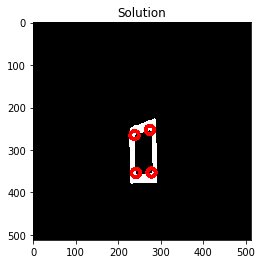

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7255.png
[{'area': 19700, 'centroid': (272, 265), 'corners': array([[255.49576, 255.49818],
       [225.45131, 163.22612],
       [321.42746, 183.63141],
       [321.70825, 354.5621 ],
       [224.12422, 359.1479 ]], dtype=float32)}, {'area': 46354, 'centroid': (270, 265), 'corners': array([[255.49663 , 255.49861 ],
       [199.18245 , 108.536194],
       [347.61212 , 152.60384 ],
       [351.67007 , 393.67154 ],
       [196.8292  , 409.88684 ]], dtype=float32)}]


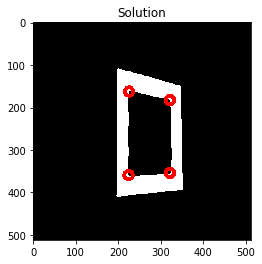

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8355 (1).png
[{'area': 7700, 'centroid': (206, 315), 'corners': array([[255.51369, 255.48358],
       [177.78552, 259.3156 ],
       [240.24359, 268.27017],
       [173.32843, 366.67004],
       [237.8765 , 366.14752]], dtype=float32)}, {'area': 15360, 'centroid': (206, 317), 'corners': array([[255.51375, 255.48312],
       [159.8188 , 234.8188 ],
       [253.91667, 245.83719],
       [254.67007, 392.67154],
       [158.80644, 394.90894]], dtype=float32)}]


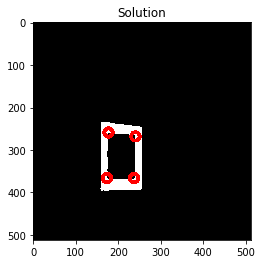

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6758.png
[]
file has only one shape


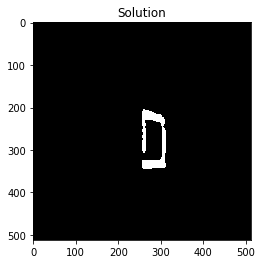

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3715.png
[{'area': 25740, 'centroid': (119, 170), 'corners': array([[255.53784 , 255.52373 ],
       [ 55.089184,  71.813194],
       [184.67159 ,  81.32996 ],
       [ 58.32841 , 268.67004 ],
       [182.36858 , 266.42746 ]], dtype=float32)}, {'area': 57915, 'centroid': (117, 168), 'corners': array([[255.53853 , 255.5244  ],
       [ 21.275743,  16.81442 ],
       [214.91667 ,  39.837193],
       [213.9108  , 306.18677 ],
       [ 25.71091 , 315.19794 ]], dtype=float32)}]


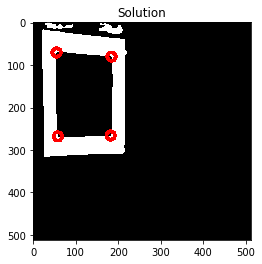

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7240 (1).png
[{'area': 9963, 'centroid': (265, 312), 'corners': array([[256.50003, 253.00056],
       [303.67004, 251.32841],
       [226.6376 , 254.46986],
       [304.21832, 372.21835],
       [224.72002, 370.65128]], dtype=float32)}, {'area': 20880, 'centroid': (265, 314), 'corners': array([[256.50003, 253.00056],
       [320.707  , 221.86874],
       [207.57578, 229.57578],
       [323.19354, 401.90894],
       [208.27014, 402.2436 ]], dtype=float32)}]


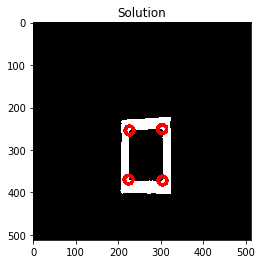

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5186.png
[{'area': 6804, 'centroid': (236, 298), 'corners': array([[255.50497, 255.48817],
       [266.7725 , 244.46953],
       [207.67451, 249.74754],
       [266.51767, 350.6939 ],
       [207.81296, 349.91046]], dtype=float32)}, {'area': 14630, 'centroid': (236, 299), 'corners': array([[255.50522, 255.48784],
       [279.77402, 219.46729],
       [189.08333, 228.83719],
       [191.8372 , 373.9167 ],
       [283.1812 , 375.1812 ]], dtype=float32)}]


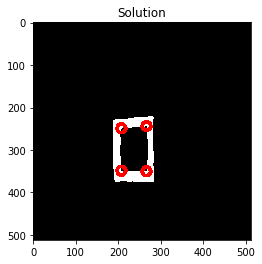

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5360.png
[]
file has only one shape


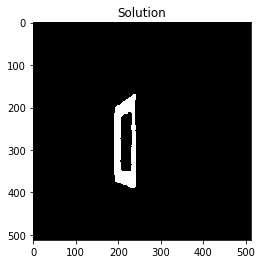

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0092.png
[{'area': 7176, 'centroid': (229, 288), 'corners': array([[255.50694, 255.49107],
       [197.81296, 237.08954],
       [262.67157, 238.32997],
       [197.32855, 338.67017],
       [263.16287, 337.91663]], dtype=float32)}, {'area': 14751, 'centroid': (230, 288), 'corners': array([[255.50694, 255.4908 ],
       [280.28568, 215.35422],
       [182.8075 , 214.55606],
       [181.09071, 363.19284],
       [280.24228, 363.21646]], dtype=float32)}]


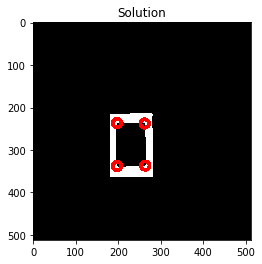

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3063.png
[{'area': 18564, 'centroid': (205, 274), 'corners': array([[255.51364, 255.49368],
       [168.86089, 156.07852],
       [246.5    , 201.     ],
       [164.30539, 370.23834],
       [245.4549 , 373.9506 ]], dtype=float32)}]
file has only one shape


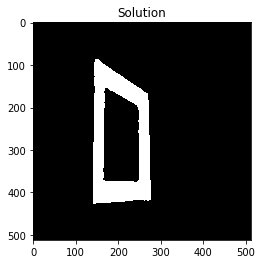

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2279.png
[{'area': 37365, 'centroid': (253, 267), 'corners': array([[255.50041, 255.49684],
       [178.78166, 150.78166],
       [329.67157, 152.32997],
       [174.4699 , 383.36252],
       [332.18704, 381.91046]], dtype=float32)}, {'area': 82110, 'centroid': (253, 270), 'corners': array([[255.50041 , 255.4967  ],
       [145.29326 ,  93.441475],
       [363.16296 , 101.08305 ],
       [373.67007 , 435.67154 ],
       [135.32855 , 439.67017 ]], dtype=float32)}]


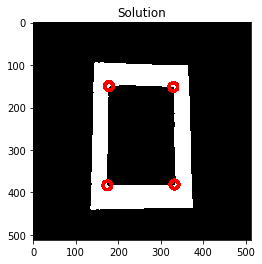

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2216.png
[{'area': 13330, 'centroid': (233, 303), 'corners': array([[255.50699, 255.4871 ],
       [196.45467, 222.65189],
       [274.50385, 242.59068],
       [192.32841, 374.67004],
       [273.7116 , 374.2311 ]], dtype=float32)}, {'area': 28602, 'centroid': (233, 305), 'corners': array([[255.5066 , 255.48695],
       [175.53087, 186.55292],
       [295.67157, 212.32997],
       [297.91696, 407.16296],
       [172.8384 , 414.65714]], dtype=float32)}]


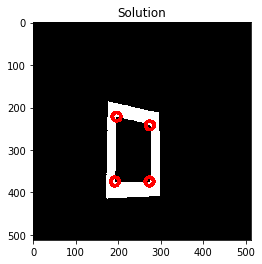

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8482 (1).png
[{'area': 33552, 'centroid': (218, 264), 'corners': array([[255.50961, 255.49869],
       [282.16342, 143.28893],
       [152.81306, 166.0892 ],
       [290.3919 , 369.6428 ],
       [146.81296, 373.91046]], dtype=float32)}, {'area': 70851, 'centroid': (219, 266), 'corners': array([[255.50908 , 255.49881 ],
       [314.18124 ,  87.81876 ],
       [120.225945, 124.451416],
       [324.1812  , 421.1812  ],
       [115.90529 , 426.68582 ]], dtype=float32)}]


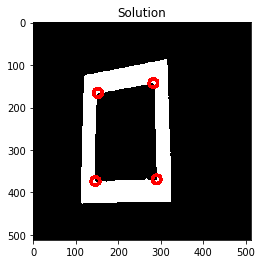

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7905 (1).png
[{'area': 7314, 'centroid': (276, 347), 'corners': array([[255.49423, 255.47466],
       [311.28186, 296.8466 ],
       [243.8369 , 297.08313],
       [310.18124, 399.18124],
       [243.35408, 400.2857 ]], dtype=float32)}, {'area': 15810, 'centroid': (276, 350), 'corners': array([[255.49437, 255.47404],
       [325.24228, 271.78354],
       [226.81879, 274.8188 ],
       [225.48308, 426.45007],
       [326.16104, 427.65707]], dtype=float32)}]


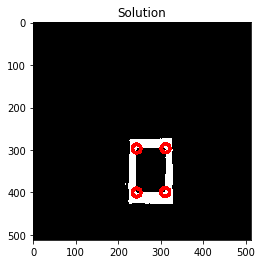

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3577.png
[{'area': 4081, 'centroid': (191, 273), 'corners': array([[255.51758, 255.49506],
       [166.0497 , 237.54478],
       [216.24232, 234.78366],
       [167.32855, 310.67017],
       [216.67003, 310.67157]], dtype=float32)}, {'area': 8625, 'centroid': (191, 274), 'corners': array([[255.51744, 255.49492],
       [230.73927, 219.16641],
       [153.71432, 219.35422],
       [228.91667, 330.1628 ],
       [156.16637, 331.73923]], dtype=float32)}]


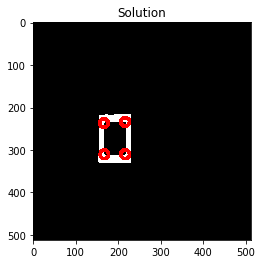

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8692.png
[{'area': 238, 'centroid': (137, 69), 'corners': array([[255.5368  , 255.55824 ],
       [136.5238  ,  62.142857],
       [142.67131 ,  63.329685],
       [132.12628 ,  74.30998 ],
       [141.41064 ,  77.60944 ]], dtype=float32)}, {'area': 76992, 'centroid': (243, 252), 'corners': array([[255.5056  , 255.50195 ],
       [161.83588 ,  42.492813],
       [341.95578 , 106.55345 ],
       [336.5119  , 408.47488 ],
       [152.60901 , 442.4803  ]], dtype=float32)}, {'area': 308, 'centroid': (124, 45), 'corners': array([[255.53885 , 255.56253 ],
       [119.083046,  38.837063],
       [131.14442 ,  41.719654],
       [118.22222 ,  44.5     ],
       [128.68935 ,  56.91716 ]], dtype=float32)}, {'area': 208, 'centroid': (139, 28), 'corners': array([[255.53918 , 255.57648 ],
       [134.90659 ,  21.768332],
       [143.67131 ,  22.329687],
       [134.12146 ,  33.149315

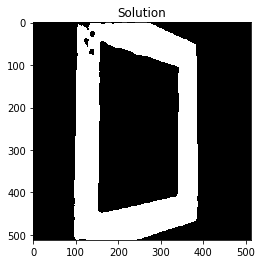

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7164 (1).png
[{'area': 18928, 'centroid': (247, 289), 'corners': array([[255.5022 , 255.49072],
       [196.56004, 205.54732],
       [301.15353, 209.84929],
       [192.12422, 370.1479 ],
       [301.8765 , 371.14752]], dtype=float32)}, {'area': 39609, 'centroid': (248, 292), 'corners': array([[255.50179, 255.49004],
       [173.16635, 168.26076],
       [327.16296, 175.08305],
       [167.69644, 412.66782],
       [329.64276, 411.39194]], dtype=float32)}]


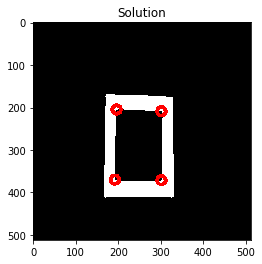

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3269.png
[]
file has only one shape


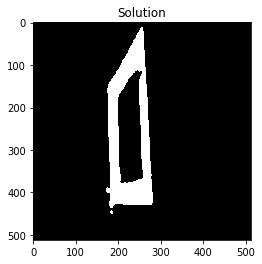

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5502.png
[{'area': 20328, 'centroid': (200, 255), 'corners': array([[255.51535, 255.49828],
       [165.18747, 132.01405],
       [244.55177, 173.3527 ],
       [232.23901, 355.72336],
       [160.60641, 364.73526]], dtype=float32)}]
file has only one shape


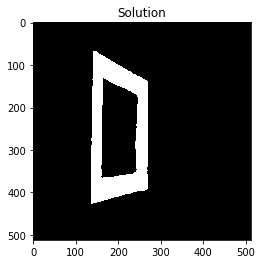

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5110.png
[{'area': 8850, 'centroid': (255, 301), 'corners': array([[255.50014, 255.48709],
       [217.60889, 248.51955],
       [291.4527 , 245.56004],
       [219.81313, 358.91083],
       [289.81714, 361.45236]], dtype=float32)}, {'area': 18748, 'centroid': (254, 303), 'corners': array([[255.50035, 255.48647],
       [307.39774, 216.75157],
       [200.08333, 222.83719],
       [200.83882, 388.65707],
       [306.9042 , 390.80142]], dtype=float32)}]


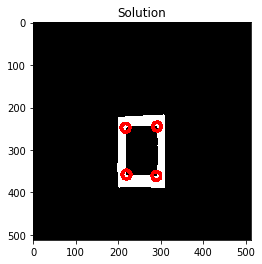

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1414.png
[]
file has only one shape


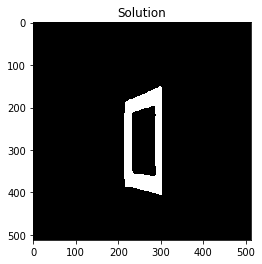

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3360.png
[{'area': 48160, 'centroid': (254, 233), 'corners': array([[255.50047, 255.50528],
       [166.78166, 102.78166],
       [338.65125,  99.71996],
       [171.74834, 356.73074],
       [331.26993, 379.33533]], dtype=float32)}, {'area': 110826, 'centroid': (258, 229), 'corners': array([[255.49832 , 255.50433 ],
       [385.51773 ,  27.306105],
       [123.818794,  47.818794],
       [138.6168  , 407.24408 ],
       [370.66217 , 451.24777 ]], dtype=float32)}]


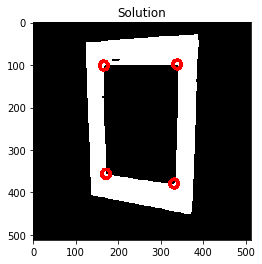

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7166 (1).png
[{'area': 16432, 'centroid': (241, 293), 'corners': array([[255.50378, 255.4897 ],
       [192.94666, 215.4783 ],
       [292.15768, 217.92523],
       [191.32841, 370.67004],
       [290.6727 , 370.25854]], dtype=float32)}, {'area': 35037, 'centroid': (242, 295), 'corners': array([[255.50351, 255.48894],
       [168.6081 , 181.35722],
       [316.31018, 184.12662],
       [319.67007, 406.67154],
       [167.76389, 411.62338]], dtype=float32)}]


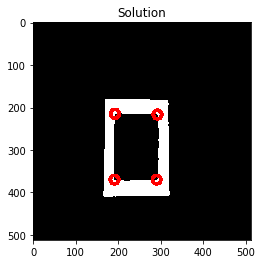

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6760 (1).png
[]
file has only one shape


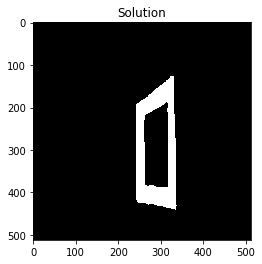

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8042.png
[{'area': 35955, 'centroid': (191, 270), 'corners': array([[255.51772, 255.49588],
       [266.45526, 153.04962],
       [118.68976, 155.12674],
       [115.77738, 385.43332],
       [264.42416, 387.42416]], dtype=float32)}, {'area': 76275, 'centroid': (190, 272), 'corners': array([[255.51765 , 255.49525 ],
       [302.1812  , 103.818794],
       [ 84.68982 , 106.126625],
       [ 76.75773 , 437.21646 ],
       [302.55804 , 442.7076  ]], dtype=float32)}]


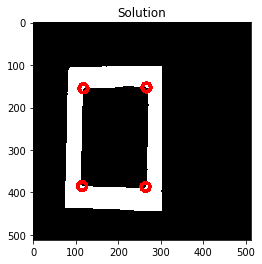

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1171.png
[]
file has only one shape


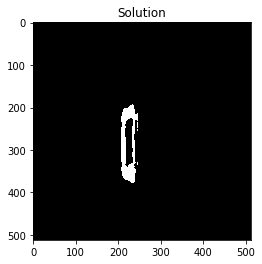

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3661.png
[{'area': 3724, 'centroid': (242, 253), 'corners': array([[255.50357, 255.50041],
       [218.08917, 218.81311],
       [266.18124, 216.81877],
       [220.81313, 290.91083],
       [265.67004, 290.6716 ]], dtype=float32)}, {'area': 8103, 'centroid': (242, 254), 'corners': array([[255.50351, 255.50021],
       [279.44717, 199.53085],
       [206.76892, 201.28838],
       [277.9105 , 308.18704],
       [205.80719, 309.9093 ]], dtype=float32)}]


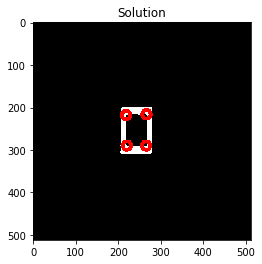

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8260.png
[]
file has only one shape


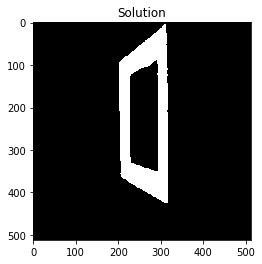

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8330.png
[{'area': 4418, 'centroid': (253, 258), 'corners': array([[255.50055, 255.49928],
       [276.20892, 213.03133],
       [230.71906, 216.3493 ],
       [273.23767, 306.6946 ],
       [232.43768, 303.03455]], dtype=float32)}, {'area': 9660, 'centroid': (253, 259), 'corners': array([[255.49998, 255.49852],
       [287.24783, 191.33786],
       [218.96567, 197.4379 ],
       [227.38889, 323.6111 ],
       [286.69803, 331.54645]], dtype=float32)}]


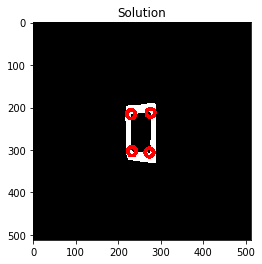

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0905.png
[{'area': 13455, 'centroid': (278, 347), 'corners': array([[257.99533, 251.49925],
       [248.67311, 247.8357 ],
       [313.87604, 268.85214],
       [311.2677 , 431.31552],
       [245.22711, 443.53024]], dtype=float32)}]
file has only one shape


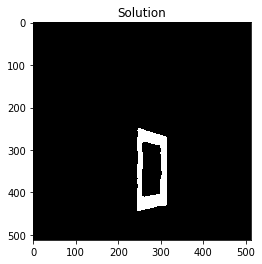

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0163.png
[{'area': 7038, 'centroid': (269, 259), 'corners': array([[255.49608, 255.4989 ],
       [300.7116 , 209.76884],
       [237.08954, 211.81296],
       [302.6716 , 307.67004],
       [239.433  , 310.18585]], dtype=float32)}, {'area': 14949, 'centroid': (270, 259), 'corners': array([[255.4958 , 255.49883],
       [319.18115, 183.81885],
       [220.44759, 189.68314],
       [319.1812 , 332.1812 ],
       [224.29239, 334.55804]], dtype=float32)}]


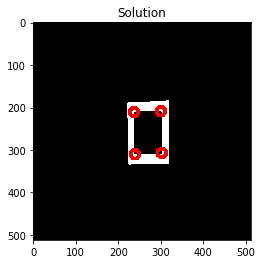

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8661.png
[{'area': 6272, 'centroid': (225, 257), 'corners': array([[255.50887, 255.49976],
       [205.0692 , 193.34885],
       [249.91046, 203.81296],
       [205.03134, 321.20895],
       [242.61111, 317.6111 ]], dtype=float32)}, {'area': 14550, 'centroid': (226, 259), 'corners': array([[255.50862, 255.49876],
       [197.54546, 162.40909],
       [265.55283, 182.68405],
       [265.67157, 340.67004],
       [189.09119, 354.19363]], dtype=float32)}]


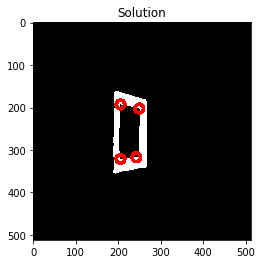

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7873 (1).png
[{'area': 8066, 'centroid': (259, 340), 'corners': array([[255.49876, 255.47658],
       [225.32997, 288.32843],
       [296.60513, 288.72037],
       [224.75262, 392.6622 ],
       [292.7064 , 394.55865]], dtype=float32)}, {'area': 16380, 'centroid': (260, 342), 'corners': array([[255.49863, 255.47603],
       [209.08328, 264.83673],
       [311.91666, 265.83698],
       [208.76218, 420.69455],
       [311.707  , 421.13126]], dtype=float32)}]


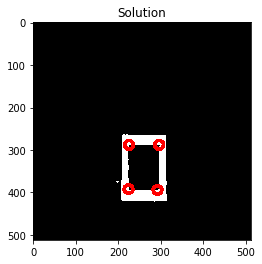

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3074.png
[{'area': 8584, 'centroid': (250, 309), 'corners': array([[255.50209, 255.48468],
       [224.81877, 232.81877],
       [278.38687, 256.75912],
       [222.81877, 375.18124],
       [271.78607, 378.609  ]], dtype=float32)}, {'area': 19448, 'centroid': (250, 309), 'corners': array([[255.5018 , 255.4857 ],
       [211.57217, 189.20201],
       [293.582  , 228.7354 ],
       [207.86086, 410.92142],
       [294.2034 , 410.71356]], dtype=float32)}]


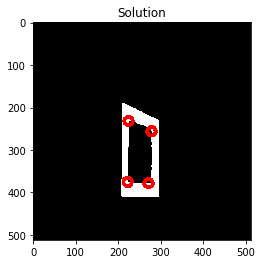

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7937.png
[{'area': 6832, 'centroid': (208, 292), 'corners': array([[255.51282, 255.48999],
       [234.28261, 230.31984],
       [182.32841, 238.32997],
       [181.78166, 349.21832],
       [233.6214 , 353.3069 ]], dtype=float32)}, {'area': 15204, 'centroid': (208, 294), 'corners': array([[255.51295, 255.48976],
       [248.44739, 201.26933],
       [167.74814, 217.2694 ],
       [165.34885, 374.28018],
       [247.83507, 384.43112]], dtype=float32)}]


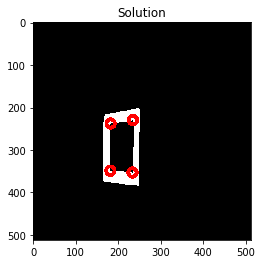

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4788.png
[]
file has only one shape


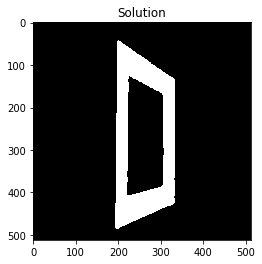

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6989 (1).png
[{'area': 8833, 'centroid': (226, 306), 'corners': array([[255.5084 , 255.48596],
       [192.81877, 245.81877],
       [261.186  , 254.29652],
       [190.3061 , 362.51776],
       [258.67004, 363.6716 ]], dtype=float32)}, {'area': 18762, 'centroid': (226, 307), 'corners': array([[255.50804, 255.48581],
       [179.1663 , 215.26077],
       [278.91663, 230.83704],
       [277.65112, 391.28024],
       [175.35408, 394.2857 ]], dtype=float32)}]


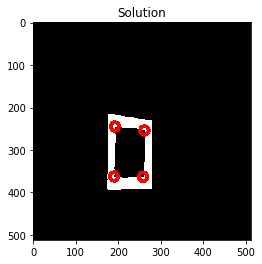

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7809.png
[]
file has only one shape


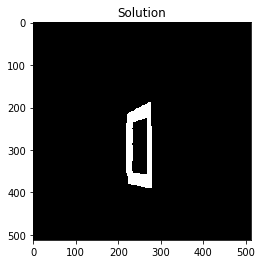

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9212.png
[{'area': 46464, 'centroid': (178, 253), 'corners': array([[255.52081 , 255.50049 ],
       [ 93.78166 , 122.78166 ],
       [266.5217  , 125.946655],
       [ 94.12422 , 384.1479  ],
       [262.7116  , 383.23114 ]], dtype=float32)}, {'area': 96393, 'centroid': (177, 253), 'corners': array([[255.52122 , 255.50035 ],
       [ 50.568596,  63.16537 ],
       [303.70685 ,  68.868744],
       [ 53.089508, 443.18704 ],
       [302.70755 , 442.55807 ]], dtype=float32)}]


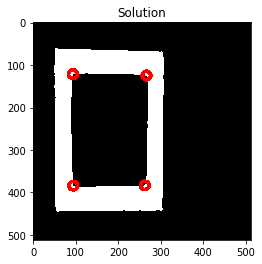

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1439.png
[]
file has only one shape


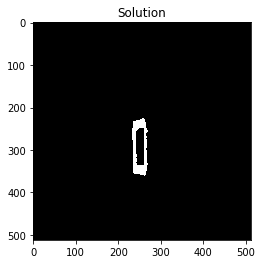

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3740.png
[{'area': 14601, 'centroid': (209, 260), 'corners': array([[256.99954, 251.49997],
       [166.19559, 180.93433],
       [254.70363, 189.81432],
       [255.69174, 332.39362],
       [164.8369 , 337.91687]], dtype=float32)}, {'area': 32292, 'centroid': (209, 261), 'corners': array([[256.99954, 251.49997],
       [143.8188 , 143.8188 ],
       [278.67154, 159.32993],
       [278.36856, 367.4275 ],
       [142.22614, 378.5296 ]], dtype=float32)}]


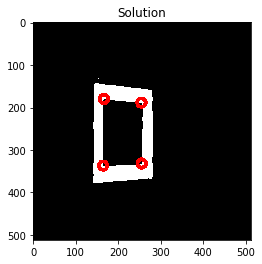

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2172.png
[]
file has only one shape


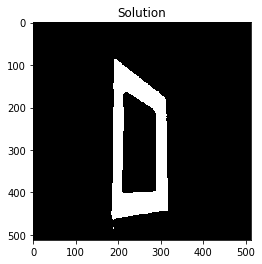

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7271 (1).png
[{'area': 33264, 'centroid': (200, 268), 'corners': array([[255.515  , 255.4972 ],
       [269.5381 , 149.3695 ],
       [134.47292, 162.52179],
       [270.87466, 377.72794],
       [126.78167, 377.21832]], dtype=float32)}, {'area': 72118, 'centroid': (202, 269), 'corners': array([[255.51472, 255.49698],
       [304.18118,  96.8188 ],
       [101.08951, 117.81297],
       [ 92.69006, 425.87378],
       [306.5841 , 434.46695]], dtype=float32)}]


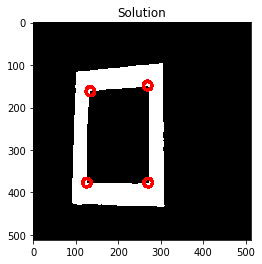

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3935.png
[{'area': 165, 'centroid': (162, 293), 'corners': array([[255.52968, 255.488  ],
       [159.75206, 286.54764],
       [167.4275 , 289.63147],
       [161.25018, 301.7469 ]], dtype=float32)}, {'area': 45580, 'centroid': (220, 254), 'corners': array([[255.50975, 255.50035],
       [303.67004, 122.32843],
       [136.12422, 127.85212],
       [305.3624 , 382.53012],
       [138.25879, 385.363  ]], dtype=float32)}, {'area': 101460, 'centroid': (222, 255), 'corners': array([[255.50859 , 255.50117 ],
       [344.24777 ,  64.33784 ],
       [ 96.08333 ,  70.8372  ],
       [361.0766  , 427.72763 ],
       [ 95.690575, 443.59067 ]], dtype=float32)}]
file has more than 2 shapes for a gate, hence quitting 


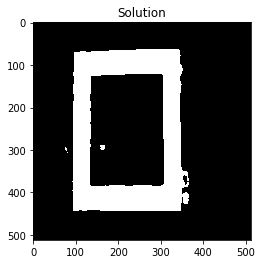

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4179.png
[{'area': 29391, 'centroid': (261, 292), 'corners': array([[255.49936, 255.48988],
       [212.83698, 148.08336],
       [312.25858, 182.32727],
       [313.75   , 399.5625 ],
       [215.42137, 439.08862]], dtype=float32)}]
file has only one shape


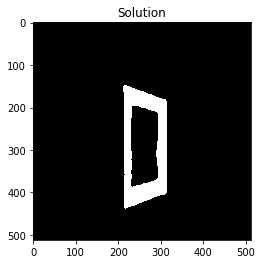

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9846.png
[{'area': 7848, 'centroid': (228, 269), 'corners': array([[255.50742, 255.49608],
       [194.57593, 216.57593],
       [262.67157, 216.32997],
       [194.45084, 322.77322],
       [262.6507 , 323.28094]], dtype=float32)}, {'area': 16695, 'centroid': (229, 270), 'corners': array([[255.50735, 255.49588],
       [280.1812 , 189.81879],
       [179.51021, 192.78888],
       [176.32993, 347.67154],
       [281.30923, 348.56558]], dtype=float32)}]


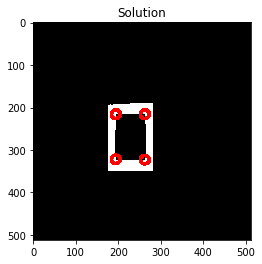

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8233.png
[]
file has only one shape


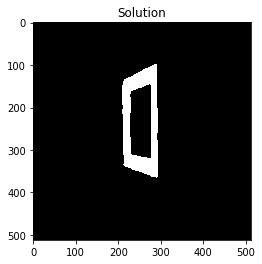

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4375.png
[{'area': 20996, 'centroid': (288, 247), 'corners': array([[255.4908 , 255.502  ],
       [233.74788, 158.26921],
       [346.1817 , 163.55603],
       [343.16287, 333.91663],
       [233.26921, 338.2521 ]], dtype=float32)}, {'area': 44688, 'centroid': (288, 248), 'corners': array([[255.49086, 255.50186],
       [206.8075 , 114.55606],
       [372.67154, 123.32993],
       [372.2184 , 372.2184 ],
       [206.75772, 383.21643]], dtype=float32)}]


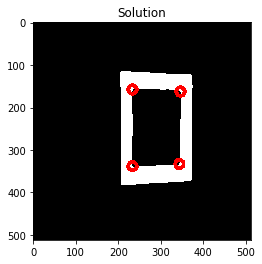

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8562 (1).png
[{'area': 3420, 'centroid': (223, 324), 'corners': array([[250.5303 , 259.22723],
       [240.71165, 280.76898],
       [205.04941, 288.5451 ],
       [240.18123, 366.18124],
       [206.26964, 366.25195]], dtype=float32)}, {'area': 7920, 'centroid': (221, 326), 'corners': array([[250.5303 , 259.22723],
       [250.52951, 259.226  ],
       [191.46294, 272.5997 ],
       [250.69803, 388.54645],
       [192.59975, 390.53726]], dtype=float32)}]


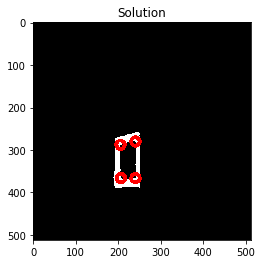

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6908 (1).png
[{'area': 7124, 'centroid': (258, 299), 'corners': array([[255.49971, 255.4878 ],
       [237.71742, 229.31984],
       [284.391  , 247.51971],
       [235.32841, 362.67004],
       [274.6111 , 364.6111 ]], dtype=float32)}, {'area': 15756, 'centroid': (258, 301), 'corners': array([[255.49942, 255.48776],
       [223.93246, 193.23827],
       [297.52063, 223.70827],
       [297.6621 , 392.24783],
       [221.32845, 396.67007]], dtype=float32)}]


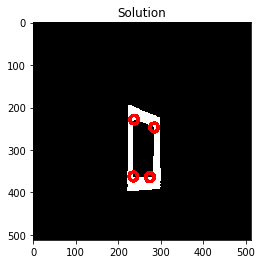

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7241 (1).png
[{'area': 9520, 'centroid': (264, 315), 'corners': array([[256.50003, 257.00064],
       [227.1235 , 257.85248],
       [302.42578, 256.6684 ],
       [225.08073, 371.16   ],
       [301.67017, 372.67145]], dtype=float32)}, {'area': 19662, 'centroid': (264, 316), 'corners': array([[256.50003, 257.00064],
       [320.44168, 228.55846],
       [207.78886, 235.51016],
       [207.32973, 399.67136],
       [321.1812 , 403.1812 ]], dtype=float32)}]


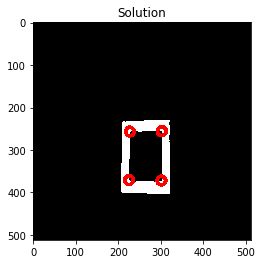

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3663.png
[{'area': 3800, 'centroid': (259, 255), 'corners': array([[255.49896, 255.49986],
       [236.3273 , 219.74144],
       [282.67157, 219.32997],
       [235.44719, 290.31598],
       [281.23834, 293.6946 ]], dtype=float32)}, {'area': 8288, 'centroid': (259, 256), 'corners': array([[255.4991 , 255.49986],
       [294.67007, 200.32845],
       [223.3542 , 201.71432],
       [295.28024, 309.65112],
       [223.81297, 310.9105 ]], dtype=float32)}]


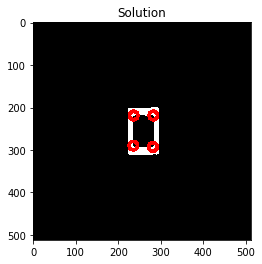

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9654.png
[{'area': 51731, 'centroid': (216, 239), 'corners': array([[255.51167, 255.5061 ],
       [137.46979,  86.6374 ],
       [303.23123, 124.28841],
       [128.81313, 370.91083],
       [305.31598, 373.5528 ]], dtype=float32)}, {'area': 118800, 'centroid': (211, 243), 'corners': array([[255.51369  , 255.50676  ],
       [100.64499  ,   7.4590826],
       [338.9103   ,  78.812996 ],
       [351.67007  , 431.67154  ],
       [ 76.328445 , 440.67007  ]], dtype=float32)}]


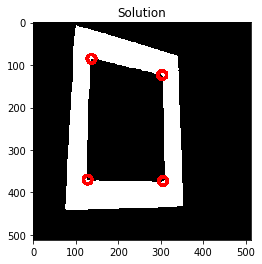

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0695.png
[{'area': 2870, 'centroid': (242, 256), 'corners': array([[255.50333, 255.49998],
       [257.1479 , 216.12437],
       [226.7816 , 219.7816 ],
       [257.6716 , 295.67004],
       [227.54729, 293.44006]], dtype=float32)}, {'area': 6572, 'centroid': (240, 257), 'corners': array([[255.50409, 255.4994 ],
       [266.67   , 196.32838],
       [214.76892, 201.28836],
       [216.6538 , 315.2898 ],
       [265.89438, 320.19727]], dtype=float32)}]


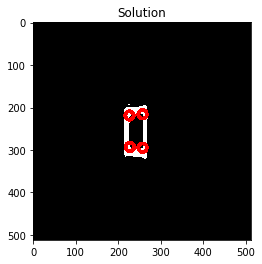

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5457.png
[]
file has only one shape


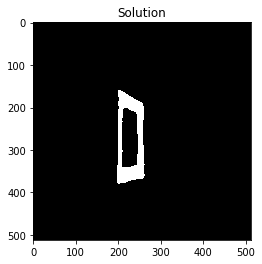

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7374 (1).png
[{'area': 4859, 'centroid': (235, 290), 'corners': array([[255.50516, 255.49052],
       [254.62404, 232.41055],
       [214.60901, 245.51971],
       [255.18117, 343.18115],
       [215.08919, 341.18686]], dtype=float32)}, {'area': 11288, 'centroid': (234, 291), 'corners': array([[255.5053 , 255.49051],
       [266.1781 , 204.34789],
       [200.71999, 224.34874],
       [200.8372 , 367.9167 ],
       [267.9093 , 371.1928 ]], dtype=float32)}]


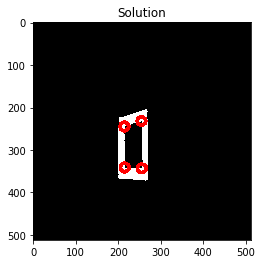

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6527.png
[{'area': 10707, 'centroid': (196, 291), 'corners': array([[255.51614, 255.49011],
       [236.66219, 227.75262],
       [156.76883, 230.28839],
       [236.51714, 354.44983],
       [155.83713, 353.91663]], dtype=float32)}, {'area': 22440, 'centroid': (195, 293), 'corners': array([[255.51634, 255.48984],
       [254.96875, 197.791  ],
       [137.08333, 203.83719],
       [254.70749, 385.5581 ],
       [135.32993, 383.67154]], dtype=float32)}]


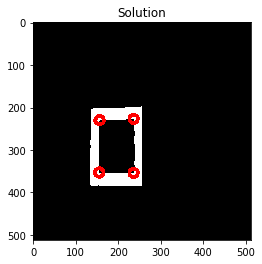

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0989.png
[{'area': 3432, 'centroid': (285, 317), 'corners': array([[256.07538, 260.46112],
       [302.42404, 274.57596],
       [267.12634, 278.69   ],
       [302.24234, 361.21634],
       [268.57593, 358.42407]], dtype=float32)}, {'area': 7788, 'centroid': (284, 319), 'corners': array([[256.07538, 260.46112],
       [310.6981 , 251.45349],
       [256.0707 , 260.4656 ],
       [255.81297, 379.9105 ],
       [311.36517, 385.25983]], dtype=float32)}]


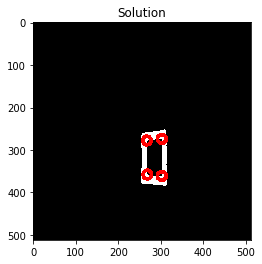

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8114.png
[{'area': 32130, 'centroid': (292, 230), 'corners': array([[255.48882, 255.50787],
       [352.4421 , 107.77279],
       [226.43274, 131.73416],
       [226.78166, 337.21832],
       [357.89325, 346.2298 ]], dtype=float32)}, {'area': 71082, 'centroid': (296, 230), 'corners': array([[255.48744 , 255.50763 ],
       [390.24457 ,  47.75515 ],
       [194.08331 ,  91.837204],
       [196.32993 , 380.67154 ],
       [391.07556 , 406.81747 ]], dtype=float32)}]


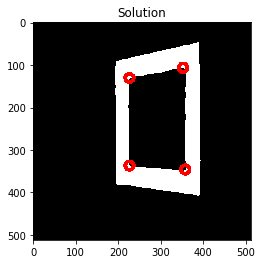

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8667.png
[{'area': 2924, 'centroid': (192, 258), 'corners': array([[255.51796, 255.4995 ],
       [178.08313, 216.83685],
       [207.54915, 219.22676],
       [177.57591, 300.42407],
       [205.61269, 298.7775 ]], dtype=float32)}, {'area': 6760, 'centroid': (193, 259), 'corners': array([[255.51741, 255.49924],
       [171.18253, 192.53615],
       [219.91664, 203.83702],
       [217.2378 , 318.69455],
       [171.84195, 325.68146]], dtype=float32)}]


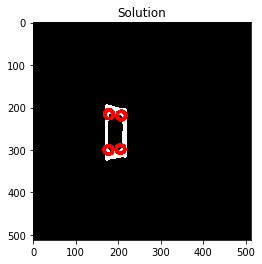

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7631.png
[{'area': 43090, 'centroid': (340, 277), 'corners': array([[255.47534, 255.49513],
       [405.6727 , 131.74144],
       [262.609  , 170.51971],
       [264.81296, 399.91046],
       [415.42407, 408.42407]], dtype=float32)}, {'area': 98175, 'centroid': (345, 278), 'corners': array([[255.47299 , 255.49512 ],
       [442.38885 ,  54.506596],
       [228.74155 , 129.32732 ],
       [228.71979 , 446.65112 ],
       [458.6716  , 480.67    ]], dtype=float32)}]


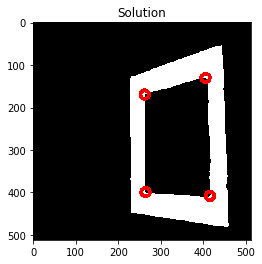

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8346 (1).png
[{'area': 10842, 'centroid': (191, 297), 'corners': array([[255.519  , 255.48927],
       [158.72375, 221.64566],
       [228.76549, 243.55548],
       [152.8369 , 357.91687],
       [226.21425, 360.68427]], dtype=float32)}, {'area': 19470, 'centroid': (191, 299), 'corners': array([[255.51802, 255.48802],
       [140.4666 , 209.03749],
       [244.60979, 223.1946 ],
       [135.43442, 380.30923],
       [246.16307, 385.9166 ]], dtype=float32)}]


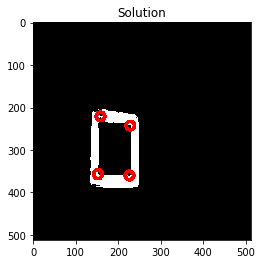

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4086.png
[{'area': 47921, 'centroid': (269, 251), 'corners': array([[255.4956 , 255.50124],
       [187.28839, 111.76884],
       [355.1868 , 123.08921],
       [358.384  , 378.5451 ],
       [187.48792, 389.47476]], dtype=float32)}, {'area': 103632, 'centroid': (269, 253), 'corners': array([[255.49608, 255.50049],
       [145.09108,  47.80645],
       [395.21838,  69.78162],
       [391.4612 , 441.7917 ],
       [143.75772, 457.21643]], dtype=float32)}]


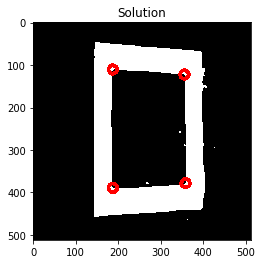

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9451.png
[{'area': 44204, 'centroid': (270, 268), 'corners': array([[255.49567, 255.49663],
       [190.63748, 141.4699 ],
       [354.42407, 142.57593],
       [184.76884, 392.7116 ],
       [354.56232, 395.03455]], dtype=float32)}, {'area': 94369, 'centroid': (272, 270), 'corners': array([[255.49539 , 255.49635 ],
       [153.32994 ,  83.328445],
       [393.797   ,  87.79924 ],
       [144.32845 , 449.67007 ],
       [396.91696 , 455.16296 ]], dtype=float32)}]


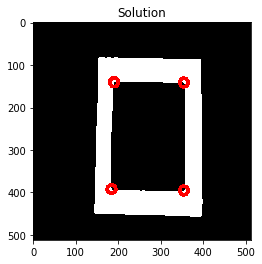

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6692.png
[]
file has only one shape


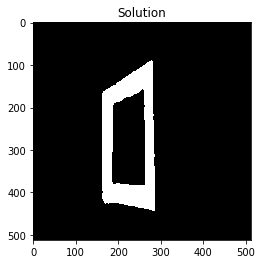

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4589.png
[{'area': 27940, 'centroid': (212, 250), 'corners': array([[255.51169, 255.50162],
       [273.16284, 141.08336],
       [150.4378 , 153.29187],
       [151.83713, 351.91663],
       [275.18124, 360.18124]], dtype=float32)}, {'area': 60822, 'centroid': (214, 251), 'corners': array([[255.51154 , 255.501   ],
       [303.67004 ,  87.32843 ],
       [119.328445, 112.32993 ],
       [122.81298 , 393.91055 ],
       [302.81744 , 415.45193 ]], dtype=float32)}]


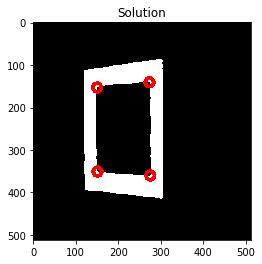

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6943 (1).png
[{'area': 38160, 'centroid': (253, 249), 'corners': array([[255.50177, 255.50316],
       [189.48318, 107.54966],
       [323.5039 , 146.59062],
       [183.32841, 372.67004],
       [322.70462, 368.19174]], dtype=float32)}, {'area': 87234, 'centroid': (249, 250), 'corners': array([[255.50279, 255.50406],
       [155.76987,  34.17366],
       [354.23117, 104.28839],
       [361.9108 , 418.18677],
       [144.75768, 438.21634]], dtype=float32)}]


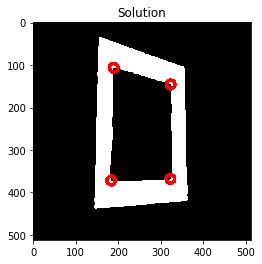

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2266.png
[{'area': 8030, 'centroid': (250, 312), 'corners': array([[255.50124, 255.48434],
       [215.83713, 258.08337],
       [285.6716 , 259.32996],
       [215.8369 , 366.91687],
       [285.42407, 365.42407]], dtype=float32)}, {'area': 17227, 'centroid': (251, 314), 'corners': array([[255.50104, 255.48413],
       [199.77034, 233.10664],
       [302.56558, 234.69078],
       [200.78235, 395.59314],
       [306.1812 , 392.1812 ]], dtype=float32)}]


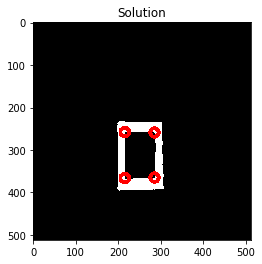

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9240.png
[{'area': 24966, 'centroid': (202, 257), 'corners': array([[255.51596, 255.49986],
       [149.48712, 147.71608],
       [259.5038 , 166.5907 ],
       [256.31598, 351.5528 ],
       [148.3284 , 366.67   ]], dtype=float32)}, {'area': 55776, 'centroid': (199, 258), 'corners': array([[255.51772 , 255.49893 ],
       [119.76215 ,  92.305435],
       [286.44003 , 128.5473  ],
       [286.14786 , 389.8759  ],
       [120.822334, 425.65182 ]], dtype=float32)}]


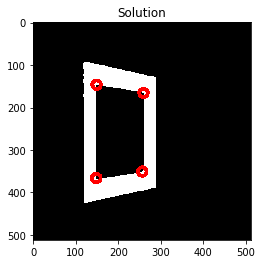

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7569 (1).png
[]
file has only one shape


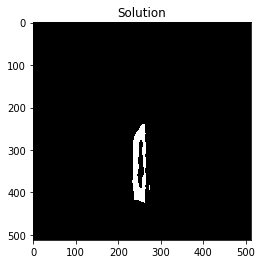

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1736.png
[]
file has only one shape


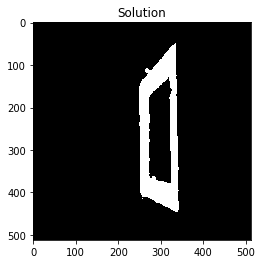

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8356 (1).png
[{'area': 7062, 'centroid': (228, 313), 'corners': array([[255.50777, 255.48413],
       [196.81879, 259.8188 ],
       [260.18115, 264.81885],
       [196.81877, 364.18124],
       [258.67004, 363.6716 ]], dtype=float32)}, {'area': 14758, 'centroid': (228, 315), 'corners': array([[255.50754, 255.48375],
       [184.83101, 233.32794],
       [275.28024, 245.34889],
       [183.29317, 392.13126],
       [275.1479 , 389.87582]], dtype=float32)}]


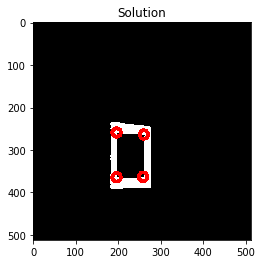

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1681.png
[{'area': 5687, 'centroid': (241, 302), 'corners': array([[255.5035 , 255.48756],
       [261.7983 , 239.07207],
       [219.96574, 249.43794],
       [218.83713, 357.91663],
       [262.4121 , 361.56815]], dtype=float32)}, {'area': 13104, 'centroid': (240, 302), 'corners': array([[255.50356, 255.48752],
       [274.20343, 208.28645],
       [205.34879, 226.71991],
       [204.69006, 383.87378],
       [274.2827 , 393.68018]], dtype=float32)}]


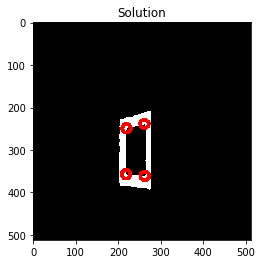

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1499.png
[{'area': 5382, 'centroid': (264, 314), 'corners': array([[253.34717, 255.58104],
       [245.17693, 254.38867],
       [285.4241 , 262.5759 ],
       [243.45084, 370.77322],
       [279.6111 , 369.6111 ]], dtype=float32)}, {'area': 12320, 'centroid': (264, 314), 'corners': array([[253.34718, 255.58105],
       [231.81877, 223.81877],
       [298.9036 , 242.829  ],
       [297.1479 , 393.87573],
       [233.0894 , 403.55795]], dtype=float32)}]


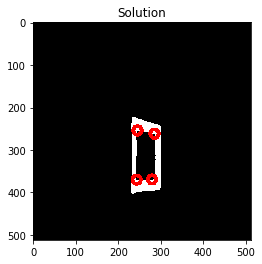

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7675 (1).png
[{'area': 9344, 'centroid': (257, 291), 'corners': array([[255.50003, 255.49034],
       [230.09618, 215.84901],
       [288.40152, 237.01102],
       [227.83705, 357.91696],
       [285.91696, 358.16293]], dtype=float32)}, {'area': 20210, 'centroid': (257, 292), 'corners': array([[255.49998, 255.49039],
       [213.81886, 176.81886],
       [303.4527 , 209.56001],
       [212.24942, 393.46945],
       [305.18704, 389.9105 ]], dtype=float32)}]


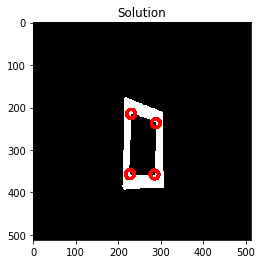

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4368.png
[{'area': 11438, 'centroid': (300, 239), 'corners': array([[255.48778, 255.50433],
       [259.83716, 174.08336],
       [342.16348, 175.08357],
       [259.08337, 306.16287],
       [338.4804 , 304.39108]], dtype=float32)}, {'area': 23985, 'centroid': (301, 240), 'corners': array([[255.48729, 255.50392],
       [240.29239, 143.44196],
       [362.24228, 145.78357],
       [360.89893, 336.21277],
       [240.57578, 338.42422]], dtype=float32)}]


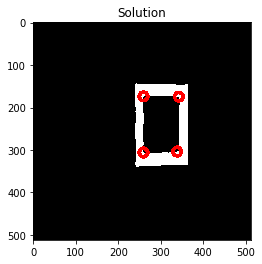

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6235.png
[{'area': 6625, 'centroid': (249, 310), 'corners': array([[260.14954, 253.37982],
       [226.75766, 246.78365],
       [274.1918 , 259.29523],
       [274.315  , 366.64145],
       [224.81877, 371.18124]], dtype=float32)}, {'area': 14694, 'centroid': (250, 312), 'corners': array([[260.14954, 253.37982],
       [212.81877, 215.81877],
       [288.91663, 235.83702],
       [290.65115, 395.28018],
       [211.81879, 402.1812 ]], dtype=float32)}]


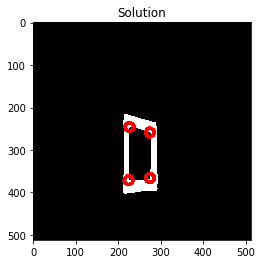

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3247.png
[{'area': 4592, 'centroid': (261, 290), 'corners': array([[255.49799, 255.49008],
       [277.20367, 233.28632],
       [243.08073, 245.84   ],
       [279.64578, 342.2857 ],
       [245.31396, 343.14148]], dtype=float32)}]
file has only one shape


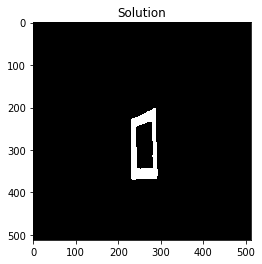

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3591.png
[{'area': 4108, 'centroid': (247, 273), 'corners': array([[255.5022 , 255.4952 ],
       [223.85211, 235.12422],
       [270.7076 , 234.44194],
       [223.32855, 310.67017],
       [271.16287, 310.91663]], dtype=float32)}, {'area': 8700, 'centroid': (248, 274), 'corners': array([[255.50192, 255.49484],
       [211.32994, 216.32845],
       [285.67154, 218.32993],
       [211.83704, 330.91696],
       [284.18704, 330.9105 ]], dtype=float32)}]


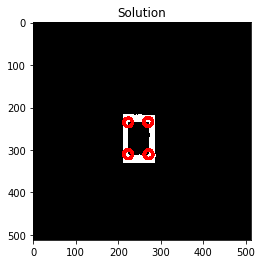

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6451.png
[{'area': 9801, 'centroid': (278, 305), 'corners': array([[255.4936 , 255.48647],
       [240.85211, 246.12422],
       [317.33185, 245.5743 ],
       [239.3284 , 364.67   ],
       [318.18124, 364.18124]], dtype=float32)}, {'area': 20416, 'centroid': (278, 307), 'corners': array([[255.4936 , 255.48578],
       [335.24228, 218.78355],
       [222.32845, 221.32994],
       [336.2026 , 394.4172 ],
       [221.48308, 394.45007]], dtype=float32)}]


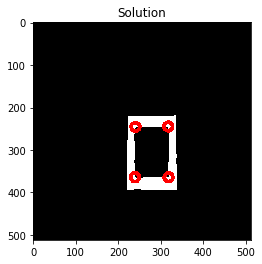

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9005.png
[]
file has only one shape


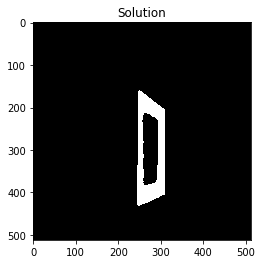

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0360.png
[{'area': 5369, 'centroid': (261, 302), 'corners': array([[255.49821, 255.48715],
       [237.5197 , 257.60898],
       [288.91663, 259.83713],
       [232.76884, 344.7116 ],
       [288.42407, 346.42407]], dtype=float32)}, {'area': 11305, 'centroid': (261, 304), 'corners': array([[255.49828, 255.48674],
       [305.24234, 236.78368],
       [220.32845, 240.32994],
       [218.81297, 366.9105 ],
       [303.1812 , 370.1812 ]], dtype=float32)}]


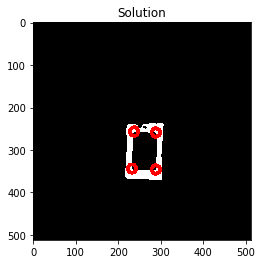

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8188.png
[{'area': 17017, 'centroid': (218, 233), 'corners': array([[255.51   , 255.50673],
       [257.83414, 138.56851],
       [174.76886, 154.28839],
       [176.73811, 317.39987],
       [261.6716 , 325.67004]], dtype=float32)}, {'area': 37654, 'centroid': (219, 233), 'corners': array([[255.50917 , 255.50677 ],
       [283.18124 ,  90.81876 ],
       [151.49615 , 123.590675],
       [152.34889 , 351.28024 ],
       [282.41205 , 374.5681  ]], dtype=float32)}]


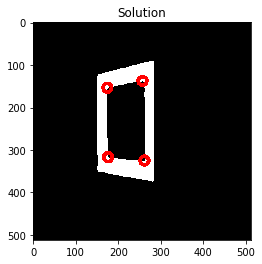

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8622 (1).png
[{'area': 6076, 'centroid': (249, 331), 'corners': array([[255.50108, 255.47885],
       [272.18124, 267.81876],
       [226.69986, 280.03925],
       [273.77386, 390.5296 ],
       [227.83698, 390.91666]], dtype=float32)}]
file has only one shape


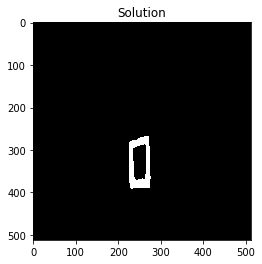

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4646.png
[{'area': 3978, 'centroid': (282, 241), 'corners': array([[255.49196, 255.50414],
       [298.83414, 190.56851],
       [264.0494 , 198.54509],
       [299.6716 , 290.67004],
       [266.56   , 289.4527 ]], dtype=float32)}, {'area': 9333, 'centroid': (281, 242), 'corners': array([[255.49232, 255.50365],
       [309.24234, 165.78365],
       [250.54729, 177.56   ],
       [252.32985, 311.67145],
       [309.1141 , 319.6829 ]], dtype=float32)}]


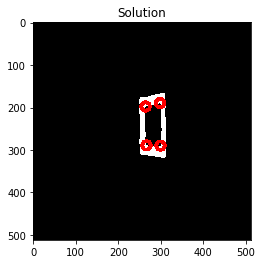

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8162 (1).png
[]
file has only one shape


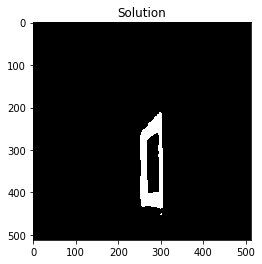

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8955.png
[{'area': 8968, 'centroid': (255, 301), 'corners': array([[255.5007 , 255.48753],
       [229.44362, 223.72112],
       [283.50385, 237.59068],
       [276.6111 , 371.6111 ],
       [228.32841, 375.67004]], dtype=float32)}, {'area': 21996, 'centroid': (255, 303), 'corners': array([[255.50076, 255.48685],
       [211.16583, 184.56853],
       [302.45273, 211.55998],
       [304.2184 , 398.2184 ],
       [217.5238 , 417.7143 ]], dtype=float32)}]


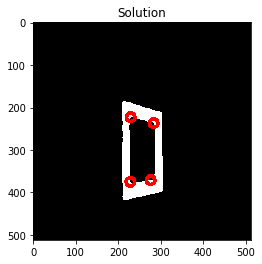

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7841.png
[]
file has only one shape


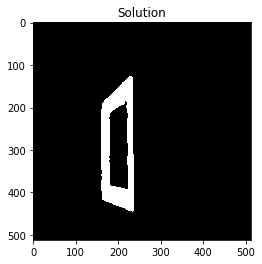

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7895 (1).png
[{'area': 12015, 'centroid': (261, 335), 'corners': array([[255.49841, 255.47789],
       [304.67017, 270.32855],
       [218.52155, 270.47342],
       [303.20322, 401.71362],
       [220.22893, 402.805  ]], dtype=float32)}, {'area': 26136, 'centroid': (261, 337), 'corners': array([[255.49835, 255.47762],
       [323.67007, 238.32845],
       [198.57584, 241.57584],
       [328.1812 , 434.1812 ],
       [196.58798, 435.56805]], dtype=float32)}]


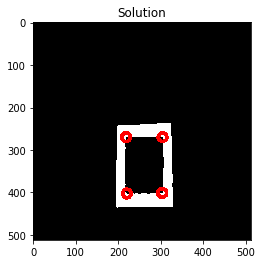

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6507.png
[{'area': 8214, 'centroid': (199, 294), 'corners': array([[255.51546, 255.48915],
       [164.32983, 241.32855],
       [235.18123, 239.81877],
       [163.8369 , 349.91687],
       [233.67001, 348.6716 ]], dtype=float32)}, {'area': 17066, 'centroid': (198, 295), 'corners': array([[255.5156 , 255.48894],
       [252.18121, 214.81879],
       [147.81322, 217.08922],
       [146.35422, 376.28568],
       [251.39194, 374.64276]], dtype=float32)}]


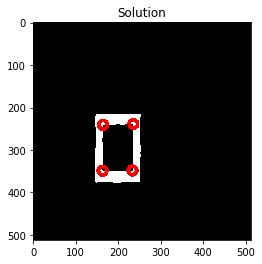

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0914.png
[{'area': 16725, 'centroid': (222, 344), 'corners': array([[252.51486, 252.64487],
       [189.40433, 231.6209 ],
       [263.0866 , 259.6078 ],
       [263.44025, 431.30728],
       [195.3305 , 451.7065 ]], dtype=float32)}, {'area': 43264, 'centroid': (221, 346), 'corners': array([[252.51486, 252.64487],
       [166.55269, 173.2693 ],
       [286.20377, 224.58911],
       [287.75   , 465.5625 ],
       [160.00084, 509.49994]], dtype=float32)}]


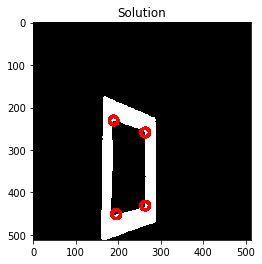

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2755.png
[{'area': 27379, 'centroid': (258, 298), 'corners': array([[255.49895, 255.48851],
       [319.16528, 191.65045],
       [196.5907 , 206.49619],
       [324.42416, 395.42416],
       [196.22588, 399.53268]], dtype=float32)}, {'area': 60172, 'centroid': (261, 301), 'corners': array([[255.49863, 255.48836],
       [348.70657, 139.4415 ],
       [164.58261, 167.79736],
       [359.56558, 445.30923],
       [163.7622 , 446.69455]], dtype=float32)}]


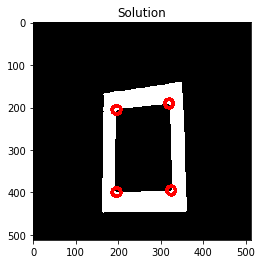

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6989.png
[]
file has only one shape


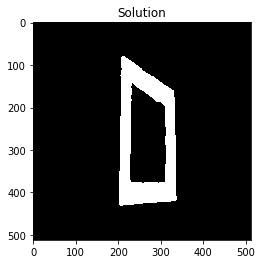

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2355.png
[{'area': 27432, 'centroid': (230, 281), 'corners': array([[255.50618, 255.49367],
       [290.18124, 169.81877],
       [169.67516, 190.46109],
       [294.18124, 382.18124],
       [168.63142, 383.42746]], dtype=float32)}, {'area': 60291, 'centroid': (232, 283), 'corners': array([[255.50589 , 255.49388 ],
       [318.193   , 114.090805],
       [140.57585 , 152.57585 ],
       [136.37859 , 430.30692 ],
       [325.1812  , 433.1812  ]], dtype=float32)}]


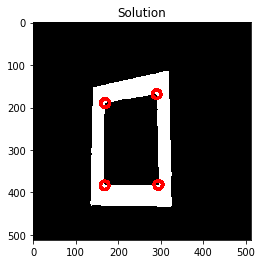

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2682.png
[{'area': 31175, 'centroid': (243, 286), 'corners': array([[255.50323, 255.49162],
       [175.85834, 178.54727],
       [312.67157, 179.32997],
       [316.67004, 389.6716 ],
       [172.34875, 394.28003]], dtype=float32)}, {'area': 68766, 'centroid': (244, 289), 'corners': array([[255.50316, 255.49113],
       [140.4704 , 132.22614],
       [343.67154, 132.32993],
       [355.66998, 439.67163],
       [135.81879, 446.1812 ]], dtype=float32)}]


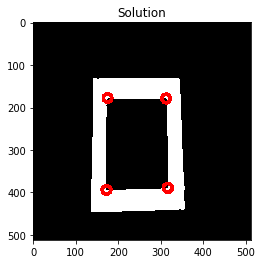

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6837.png
[{'area': 14440, 'centroid': (258, 240), 'corners': array([[255.49919, 255.50462],
       [212.32996, 163.32843],
       [304.21832, 170.78166],
       [212.76884, 312.7116 ],
       [304.31598, 312.5528 ]], dtype=float32)}, {'area': 30800, 'centroid': (258, 240), 'corners': array([[255.49913, 255.50476],
       [192.03113, 126.79107],
       [326.28024, 140.34889],
       [190.32845, 347.67007],
       [330.27316, 345.72623]], dtype=float32)}]


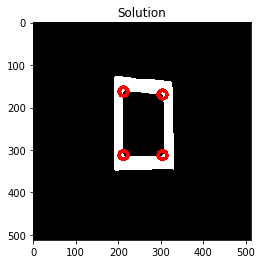

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7522 (1).png
[]
file has only one shape


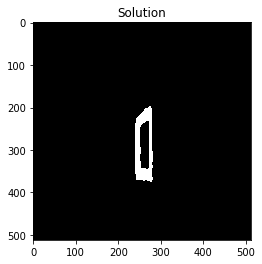

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4638.png
[{'area': 2511, 'centroid': (268, 247), 'corners': array([[255.49637, 255.50227],
       [281.79205, 208.9666 ],
       [253.74142, 212.32727],
       [255.78166, 285.21832],
       [281.30923, 286.5656 ]], dtype=float32)}, {'area': 6240, 'centroid': (266, 248), 'corners': array([[255.49648, 255.5022 ],
       [291.33246, 188.18405],
       [240.6848 , 196.3586 ],
       [243.42886, 307.66864],
       [290.23788, 309.69452]], dtype=float32)}]


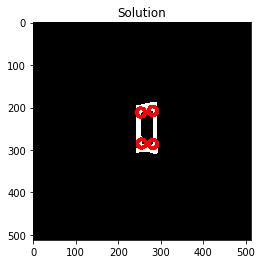

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7009 (1).png
[{'area': 46292, 'centroid': (221, 243), 'corners': array([[255.51053 , 255.50577 ],
       [150.01793 ,  89.253136],
       [302.42404 , 129.57596 ],
       [303.7853  , 369.04758 ],
       [142.81313 , 373.91083 ]], dtype=float32)}, {'area': 103635, 'centroid': (216, 243), 'corners': array([[255.51196 , 255.5061  ],
       [112.16501 ,  17.568935],
       [336.91663 ,  84.83701 ],
       [342.87613 , 422.14758 ],
       [ 98.29251 , 442.5581  ]], dtype=float32)}]


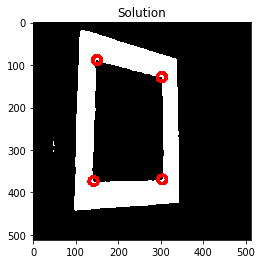

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0383.png
[]
file has only one shape


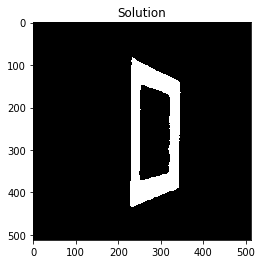

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7308 (1).png
[{'area': 7616, 'centroid': (241, 318), 'corners': array([[255.504  , 255.48274],
       [270.19553, 261.32574],
       [208.31815, 270.21002],
       [273.94568, 371.28836],
       [209.56004, 371.4527 ]], dtype=float32)}, {'area': 15456, 'centroid': (240, 320), 'corners': array([[255.50407, 255.48236],
       [286.6981 , 236.45348],
       [192.76892, 248.28838],
       [192.8372 , 396.9167 ],
       [287.65112, 398.2802 ]], dtype=float32)}]


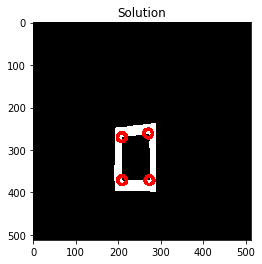

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8646 (1).png
[]
file has only one shape


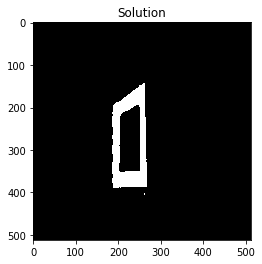

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6501.png
[{'area': 11658, 'centroid': (223, 292), 'corners': array([[255.50859, 255.4899 ],
       [264.6507 , 226.71906],
       [181.57584, 229.57584],
       [265.87366, 355.31   ],
       [186.29778, 359.10553]], dtype=float32)}, {'area': 24318, 'centroid': (223, 293), 'corners': array([[255.50879, 255.48929],
       [286.5294 , 197.2258 ],
       [163.62724, 201.86052],
       [286.1812 , 388.1812 ],
       [160.83704, 388.91663]], dtype=float32)}]


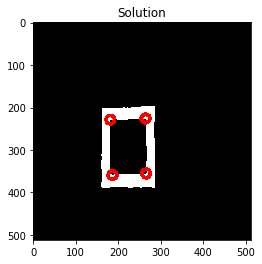

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8256 (1).png
[]
file has only one shape


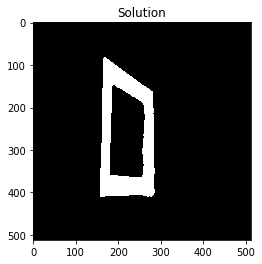

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8021 (1).png
[{'area': 9176, 'centroid': (260, 311), 'corners': array([[255.49796, 255.48479],
       [290.1812 , 234.81877],
       [230.57254, 253.63141],
       [289.6979 , 380.5463 ],
       [229.08305, 379.16293]], dtype=float32)}, {'area': 20928, 'centroid': (260, 313), 'corners': array([[255.49806, 255.48468],
       [303.70676, 195.44159],
       [211.63705, 231.25862],
       [212.75124, 412.72375],
       [307.42407, 415.42407]], dtype=float32)}]


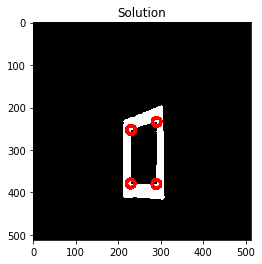

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6773 (1).png
[]
file has only one shape


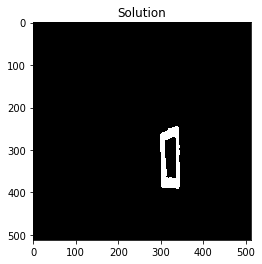

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8424 (1).png
[{'area': 12194, 'centroid': (213, 310), 'corners': array([[258.0008 , 256.50006],
       [172.56004, 244.54732],
       [257.16348, 246.08357],
       [167.89447, 372.7022 ],
       [255.87625, 375.1475 ]], dtype=float32)}, {'area': 25090, 'centroid': (213, 313), 'corners': array([[258.0008 , 256.50006],
       [151.32994, 216.32845],
       [278.5787 , 220.65755],
       [279.1628 , 406.9167 ],
       [149.8075 , 409.44394]], dtype=float32)}]


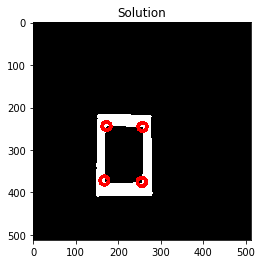

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9530.png
[{'area': 8103, 'centroid': (273, 343), 'corners': array([[255.49516, 255.47571],
       [240.83716, 289.08334],
       [307.6716 , 293.32996],
       [236.46732, 391.7741 ],
       [306.67004, 396.6716 ]], dtype=float32)}, {'area': 16432, 'centroid': (274, 344), 'corners': array([[255.49498, 255.47542],
       [224.8372 , 267.0833 ],
       [325.42416, 270.57584],
       [221.57584, 418.42416],
       [322.6213 , 424.30682]], dtype=float32)}]


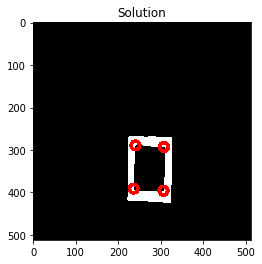

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3744.png
[{'area': 7956, 'centroid': (235, 264), 'corners': array([[255.50546, 255.4978 ],
       [205.37865, 204.69315],
       [266.46548, 210.49156],
       [267.9108 , 317.18677],
       [205.03134, 322.20895]], dtype=float32)}, {'area': 17127, 'centroid': (236, 266), 'corners': array([[255.50525, 255.49742],
       [189.32996, 178.32841],
       [286.28024, 189.34889],
       [285.54858, 345.77405],
       [188.33789, 351.2479 ]], dtype=float32)}]


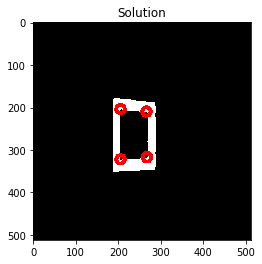

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8645 (1).png
[]
file has only one shape


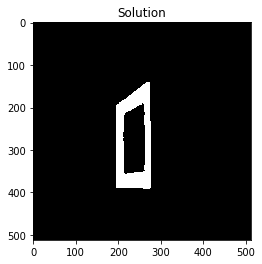

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7378.png
[{'area': 36579, 'centroid': (247, 254), 'corners': array([[255.50154 , 255.50159 ],
       [305.31592 , 112.447174],
       [179.62825 , 156.66101 ],
       [313.6716  , 376.67004 ],
       [181.68407 , 375.55283 ]], dtype=float32)}, {'area': 84255, 'centroid': (253, 254), 'corners': array([[255.50053 , 255.50195 ],
       [338.8176  ,  31.536211],
       [149.04941 , 114.54487 ],
       [147.81879 , 425.1812  ],
       [352.11423 , 443.68295 ]], dtype=float32)}]


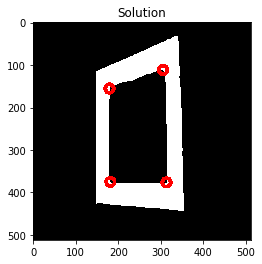

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2148.png
[]
file has only one shape


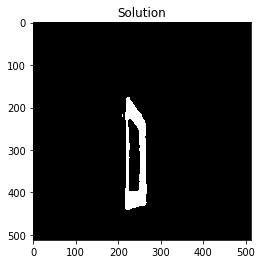

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7216.png
[]
file has only one shape


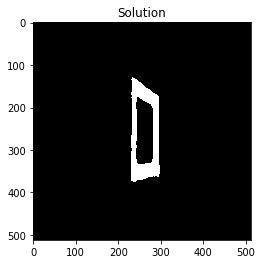

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4405.png
[{'area': 9240, 'centroid': (263, 241), 'corners': array([[255.49759, 255.50351],
       [226.08917, 184.81311],
       [301.87366, 185.68999],
       [299.07477, 298.15768],
       [228.7968 , 303.71362]], dtype=float32)}, {'area': 19836, 'centroid': (264, 242), 'corners': array([[255.49759, 255.50343],
       [207.32994, 157.32845],
       [320.774  , 156.47047],
       [320.67007, 326.67154],
       [208.32845, 331.67007]], dtype=float32)}]


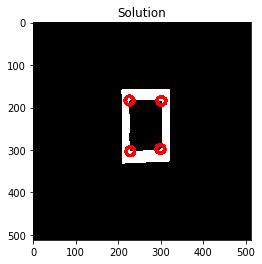

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9278.png
[{'area': 18870, 'centroid': (180, 255), 'corners': array([[255.5204 , 255.49992],
       [127.66012, 171.43817],
       [234.14752, 175.1235 ],
       [234.53014, 336.3624 ],
       [128.0313 , 341.20895]], dtype=float32)}, {'area': 40261, 'centroid': (179, 256), 'corners': array([[255.5206 , 255.49973],
       [100.35723, 131.60808],
       [261.89334, 140.77034],
       [260.67007, 373.67154],
       [100.08951, 379.18704]], dtype=float32)}]


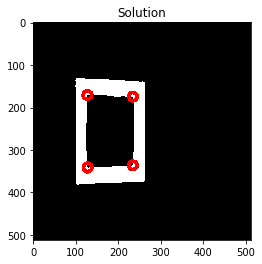

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8669 (1).png
[]
file has only one shape


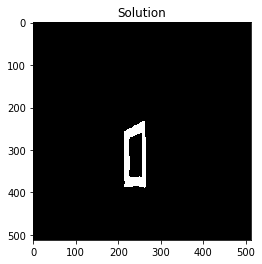

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5514.png
[{'area': 9300, 'centroid': (231, 269), 'corners': array([[255.50708, 255.49628],
       [208.51595, 189.55692],
       [261.11417, 209.56459],
       [252.61111, 339.6111 ],
       [204.30196, 344.54648]], dtype=float32)}, {'area': 21021, 'centroid': (231, 271), 'corners': array([[255.50739, 255.49556],
       [190.22757, 150.46947],
       [277.9193 , 183.84   ],
       [273.98337, 372.52   ],
       [188.75769, 383.21637]], dtype=float32)}]


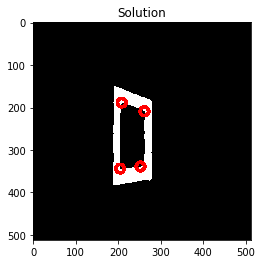

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3129.png
[{'area': 42750, 'centroid': (244, 210), 'corners': array([[255.50255 , 255.51263 ],
       [167.78275 ,  83.40713 ],
       [325.91663 ,  90.837135],
       [330.9164  , 330.16348 ],
       [160.57593 , 332.42407 ]], dtype=float32)}, {'area': 92851, 'centroid': (244, 212), 'corners': array([[255.50275 , 255.51257 ],
       [129.29326 ,  23.441475],
       [361.67157 ,  36.329933],
       [372.67007 , 386.67154 ],
       [119.75773 , 392.21643 ]], dtype=float32)}]


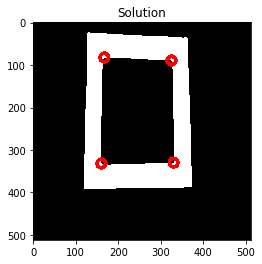

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9276.png
[{'area': 18203, 'centroid': (152, 257), 'corners': array([[255.52809 , 255.49937 ],
       [ 99.54729 , 175.55995 ],
       [205.14752 , 176.1235  ],
       [ 99.575935, 339.42407 ],
       [206.91643 , 339.16348 ]], dtype=float32)}, {'area': 38560, 'centroid': (152, 257), 'corners': array([[255.52837 , 255.49918 ],
       [ 71.818794, 137.8188  ],
       [231.67155 , 139.32994 ],
       [ 72.60807 , 377.64276 ],
       [230.70699 , 379.13126 ]], dtype=float32)}]


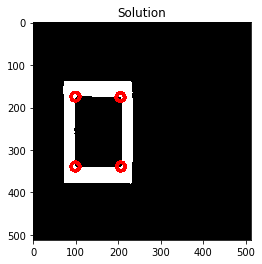

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4884.png
[{'area': 15792, 'centroid': (227, 316), 'corners': array([[255.5086 , 255.48349],
       [186.25087, 230.23022],
       [272.08044, 244.57497],
       [271.1479 , 392.87576],
       [180.8369 , 397.91687]], dtype=float32)}, {'area': 34968, 'centroid': (226, 318), 'corners': array([[255.50812, 255.48308],
       [159.8188 , 191.8188 ],
       [296.67154, 212.32993],
       [293.5777 , 427.7951 ],
       [157.32845, 440.67007]], dtype=float32)}]


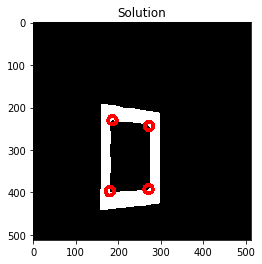

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4510.png
[{'area': 9480, 'centroid': (251, 243), 'corners': array([[255.50096, 255.5031 ],
       [290.2613 , 184.80667],
       [215.51955, 184.60889],
       [214.32997, 301.67157],
       [289.18124, 303.18124]], dtype=float32)}, {'area': 19836, 'centroid': (251, 244), 'corners': array([[255.50096, 255.50302],
       [307.39774, 155.75157],
       [194.83702, 160.08305],
       [196.34885, 330.28018],
       [306.96866, 332.20892]], dtype=float32)}]


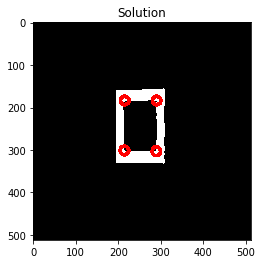

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7061 (1).png
[{'area': 10125, 'centroid': (248, 308), 'corners': array([[255.50192, 255.48544],
       [212.7964 , 245.28635],
       [286.16   , 250.08075],
       [209.58789, 370.5681 ],
       [286.31625, 366.40634]], dtype=float32)}, {'area': 21294, 'centroid': (248, 310), 'corners': array([[255.50186, 255.48503],
       [192.32983, 217.32854],
       [305.67145, 225.32985],
       [189.81879, 399.1812 ],
       [306.67007, 397.67154]], dtype=float32)}]


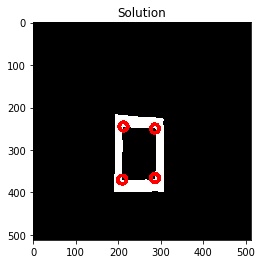

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3445.png
[{'area': 2752, 'centroid': (247, 343), 'corners': array([[255.50243, 255.47523],
       [266.18124, 312.81876],
       [225.40692, 316.96393],
       [265.54916, 373.77322],
       [229.32997, 373.67157]], dtype=float32)}, {'area': 5700, 'centroid': (247, 344), 'corners': array([[255.5022 , 255.47575],
       [275.77255, 296.4696 ],
       [218.34325, 299.3181 ],
       [276.91055, 387.18704],
       [218.8372 , 390.9167 ]], dtype=float32)}]


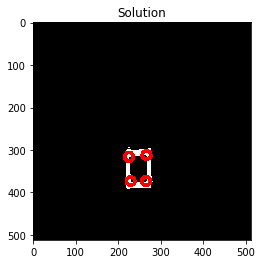

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3113.png
[{'area': 35372, 'centroid': (209, 227), 'corners': array([[255.51366 , 255.50931 ],
       [141.68999 , 102.126335],
       [279.6512  , 126.71995 ],
       [137.43274 , 338.2658  ],
       [283.43994 , 338.4527  ]], dtype=float32)}, {'area': 80503, 'centroid': (206, 229), 'corners': array([[255.51508 , 255.50996 ],
       [108.179306,  35.635487],
       [311.69177 ,  86.606544],
       [322.2802  , 386.65112 ],
       [ 99.328445, 397.67007 ]], dtype=float32)}]


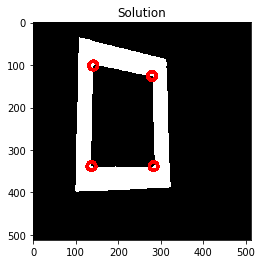

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7217.png
[]
file has only one shape


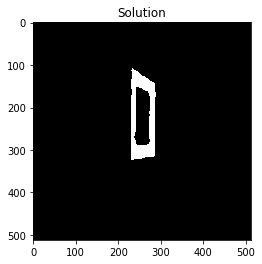

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7080.png
[{'area': 5841, 'centroid': (262, 246), 'corners': array([[255.49814, 255.50264],
       [234.69   , 198.12631],
       [290.67157, 202.32997],
       [237.51955, 294.3911 ],
       [289.67004, 293.6716 ]], dtype=float32)}, {'area': 12070, 'centroid': (261, 247), 'corners': array([[255.4982 , 255.50244],
       [220.56892, 176.16489],
       [304.16327, 183.08328],
       [220.76218, 317.69455],
       [304.67007, 315.67154]], dtype=float32)}]


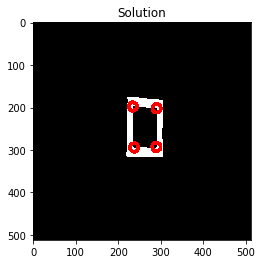

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1850.png
[{'area': 6345, 'centroid': (238, 275), 'corners': array([[255.50427, 255.49443],
       [257.1482 , 205.1171 ],
       [216.18924, 222.27133],
       [259.16293, 337.91696],
       [223.6708 , 338.51303]], dtype=float32)}]
file has only one shape


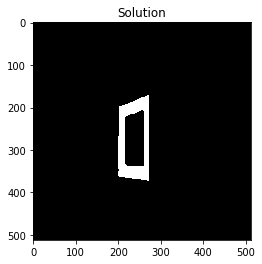

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5654.png
[{'area': 38955, 'centroid': (263, 256), 'corners': array([[255.49739, 255.49973],
       [192.50374, 131.55644],
       [340.31717, 142.44772],
       [185.68468, 375.64136],
       [340.67004, 373.6716 ]], dtype=float32)}, {'area': 81650, 'centroid': (262, 259), 'corners': array([[255.49759 , 255.49924 ],
       [153.32994 ,  79.328445],
       [375.16348 ,  94.08366 ],
       [380.13126 , 424.70685 ],
       [148.57584 , 433.42416 ]], dtype=float32)}]


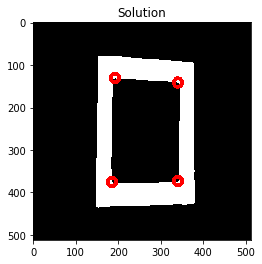

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4491.png
[{'area': 54096, 'centroid': (250, 244), 'corners': array([[255.50186, 255.50255],
       [337.67267,  97.74149],
       [157.609  , 112.51969],
       [159.85213, 383.87576],
       [338.3209 , 391.58896]], dtype=float32)}, {'area': 116640, 'centroid': (253, 244), 'corners': array([[255.50075 , 255.5037  ],
       [384.77277 ,  26.469707],
       [115.12426 ,  54.85212 ],
       [121.683136, 440.55243 ],
       [382.67154 , 459.67007 ]], dtype=float32)}]


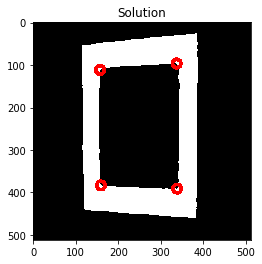

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3414.png
[{'area': 2688, 'centroid': (209, 303), 'corners': array([[255.51285, 255.48674],
       [188.81877, 272.81876],
       [230.53265, 276.2258 ],
       [189.57593, 333.42407],
       [227.31001, 333.87366]], dtype=float32)}, {'area': 5700, 'centroid': (209, 304), 'corners': array([[255.51271, 255.4866 ],
       [177.75533, 257.81683],
       [239.55804, 259.2924 ],
       [180.32837, 350.66998],
       [239.1628 , 350.9167 ]], dtype=float32)}]


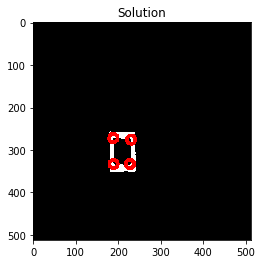

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3232.png
[]
file has only one shape


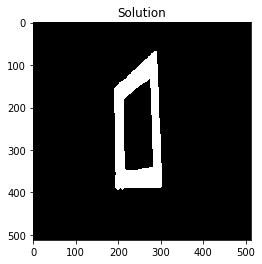

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2230.png
[{'area': 7020, 'centroid': (182, 312), 'corners': array([[255.5202 , 255.48438],
       [153.75768, 257.78363],
       [213.14752, 265.1235 ],
       [151.81877, 363.18124],
       [211.14787, 362.87576]], dtype=float32)}, {'area': 14915, 'centroid': (183, 314), 'corners': array([[255.51993, 255.48389],
       [141.12979, 232.37643],
       [230.77403, 245.4514 ],
       [137.35722, 390.3919 ],
       [230.67007, 388.67154]], dtype=float32)}]


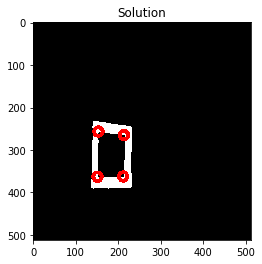

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9479.png
[{'area': 63242, 'centroid': (272, 255), 'corners': array([[255.49498, 255.50035],
       [177.28839, 101.76884],
       [372.21832, 102.78166],
       [170.81313, 405.91083],
       [374.7116 , 406.23114]], dtype=float32)}, {'area': 137088, 'centroid': (274, 257), 'corners': array([[255.49498 , 255.50014 ],
       [130.81879 ,  30.818794],
       [418.1812  ,  35.818794],
       [122.10114 , 476.2128  ],
       [426.18704 , 477.9105  ]], dtype=float32)}]


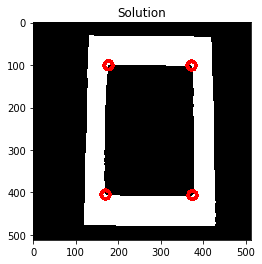

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2610.png
[{'area': 18408, 'centroid': (233, 300), 'corners': array([[255.50693, 255.4882 ],
       [184.81877, 208.81877],
       [283.3624 , 225.46985],
       [182.78166, 384.21832],
       [284.54858, 382.77405]], dtype=float32)}, {'area': 40820, 'centroid': (233, 303), 'corners': array([[255.50688, 255.48793],
       [160.81877, 166.81877],
       [307.18677, 193.0892 ],
       [313.42416, 421.42416],
       [158.29317, 428.13126]], dtype=float32)}]


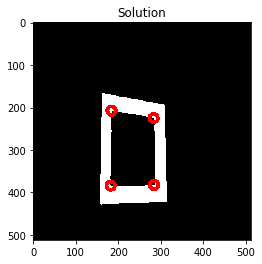

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8270.png
[]
file has only one shape


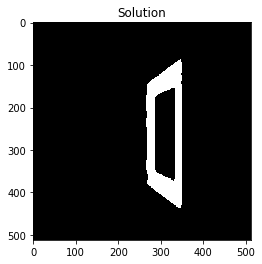

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4362.png
[{'area': 7630, 'centroid': (290, 244), 'corners': array([[255.49031, 255.50288],
       [259.32996, 191.32841],
       [323.476  , 193.52397],
       [323.21838, 295.21838],
       [256.41083, 298.70053]], dtype=float32)}, {'area': 15756, 'centroid': (291, 244), 'corners': array([[255.49025, 255.50275],
       [241.57584, 167.57584],
       [342.1812 , 167.81879],
       [243.29251, 324.5581 ],
       [337.2649 , 323.89185]], dtype=float32)}]


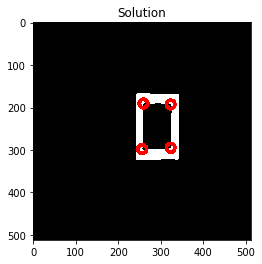

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0839.png
[{'area': 13348, 'centroid': (189, 269), 'corners': array([[255.51813, 255.49594],
       [144.81883, 198.81883],
       [234.54916, 203.22679],
       [143.81877, 340.18124],
       [234.16287, 337.91663]], dtype=float32)}, {'area': 28542, 'centroid': (189, 270), 'corners': array([[255.51799 , 255.49567 ],
       [122.818794, 164.8188  ],
       [257.1812  , 171.81879 ],
       [256.1628  , 369.9167  ],
       [124.385735, 377.8058  ]], dtype=float32)}]


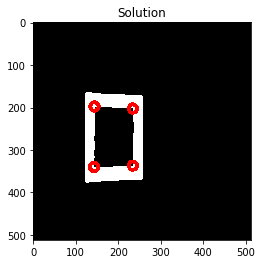

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6643.png
[{'area': 4815, 'centroid': (208, 300), 'corners': array([[255.51306, 255.48775],
       [227.52342, 245.54889],
       [187.18924, 256.27133],
       [229.18123, 350.18124],
       [187.83713, 349.91663]], dtype=float32)}, {'area': 11130, 'centroid': (207, 302), 'corners': array([[255.51305, 255.48734],
       [240.18124, 220.81876],
       [173.08969, 236.813  ],
       [241.95071, 375.46204],
       [172.20587, 379.49945]], dtype=float32)}]


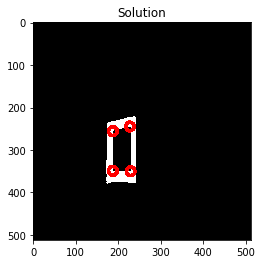

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7471.png
[{'area': 25651, 'centroid': (269, 252), 'corners': array([[255.49695, 255.50201],
       [221.32997, 133.32841],
       [325.75   , 165.4375 ],
       [320.6865 , 353.25397],
       [215.78166, 360.21832]], dtype=float32)}, {'area': 58116, 'centroid': (266, 252), 'corners': array([[255.49808 , 255.5022  ],
       [191.22754 ,  68.46948 ],
       [350.9193  , 125.840004],
       [351.1628  , 395.9167  ],
       [186.27637 , 418.18597 ]], dtype=float32)}]


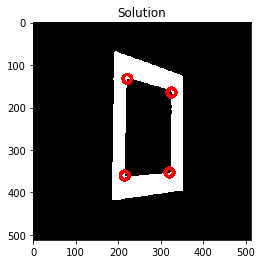

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6835 (1).png
[]
file has only one shape


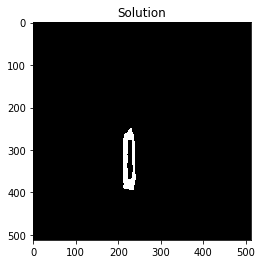

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7934 (1).png
[{'area': 7770, 'centroid': (262, 342), 'corners': array([[255.49814, 255.47589],
       [297.18124, 288.81876],
       [227.6376 , 290.46988],
       [295.16507, 396.34937],
       [228.68999, 396.87366]], dtype=float32)}, {'area': 17066, 'centroid': (262, 344), 'corners': array([[255.49821, 255.47562],
       [312.1812 , 262.8188 ],
       [211.75224, 268.3378 ],
       [209.22752, 423.53052],
       [315.1812 , 423.1812 ]], dtype=float32)}]


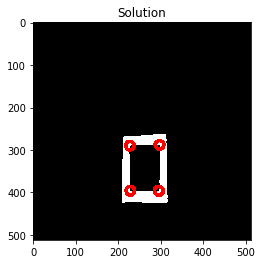

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9599.png
[{'area': 20470, 'centroid': (223, 233), 'corners': array([[255.50859, 255.50626],
       [169.46986, 142.6376 ],
       [279.1869 , 150.08919],
       [167.6376 , 318.53012],
       [280.16287, 317.91663]], dtype=float32)}, {'area': 43771, 'centroid': (223, 233), 'corners': array([[255.50845 , 255.50604 ],
       [142.81886 , 100.818855],
       [306.67154 , 115.32993 ],
       [308.71164 , 357.23108 ],
       [139.81879 , 360.1812  ]], dtype=float32)}]


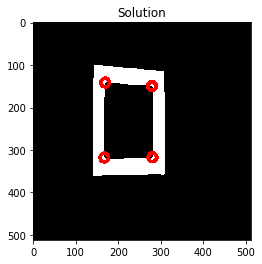

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0967.png
[{'area': 74698, 'centroid': (290, 292), 'corners': array([[255.49059, 255.48984],
       [398.16287, 123.08336],
       [181.4699 , 129.63748],
       [178.62625, 455.37308],
       [399.05328, 458.52185]], dtype=float32)}, {'area': 149688, 'centroid': (292, 283), 'corners': array([[255.47504 , 255.49829 ],
       [447.42416 ,  49.575832],
       [133.76892 ,  61.28837 ],
       [457.40674 , 505.90372 ],
       [375.66666 , 510.33334 ]], dtype=float32)}]


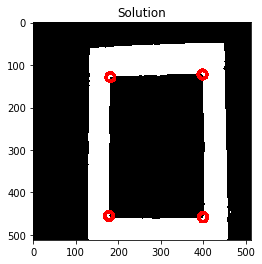

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7514 (1).png
[]
file has only one shape


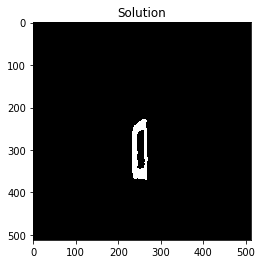

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6044.png
[]
file has only one shape


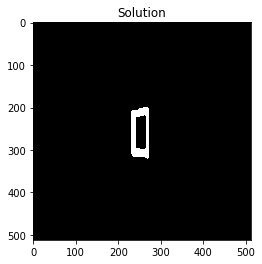

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1408.png
[{'area': 3456, 'centroid': (252, 284), 'corners': array([[255.50038, 255.49203],
       [267.23203, 236.17381],
       [236.3181 , 243.21007],
       [268.6716 , 330.67004],
       [238.8609 , 329.9215 ]], dtype=float32)}, {'area': 8232, 'centroid': (251, 286), 'corners': array([[255.50089, 255.49258],
       [271.45456, 213.40909],
       [223.84993, 224.09541],
       [222.99931, 332.50006],
       [278.15646, 359.67767]], dtype=float32)}]


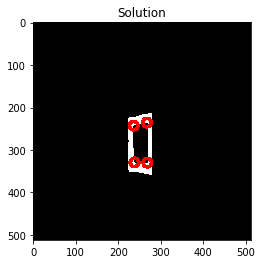

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0247.png
[]
file has only one shape


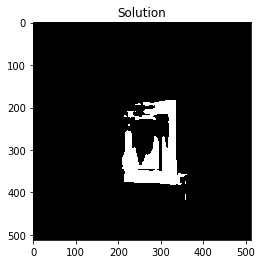

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0208.png
[]
file has only one shape


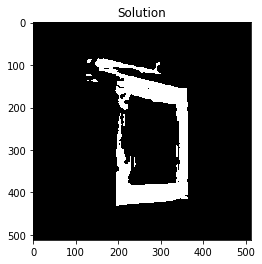

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2498.png
[]
file has only one shape


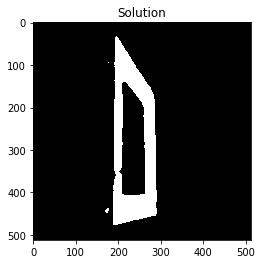

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9295.png
[{'area': 7383, 'centroid': (249, 279), 'corners': array([[255.50151, 255.4932 ],
       [217.85211, 228.12422],
       [283.23117, 231.28839],
       [217.55995, 330.45273],
       [281.96896, 332.2089 ]], dtype=float32)}, {'area': 15000, 'centroid': (250, 280), 'corners': array([[255.50151, 255.49292],
       [199.2864 , 207.79677],
       [299.67154, 207.32993],
       [201.32845, 354.67007],
       [299.1812 , 356.1812 ]], dtype=float32)}]


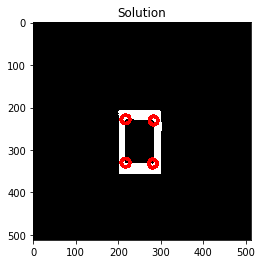

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2630.png
[{'area': 10935, 'centroid': (203, 298), 'corners': array([[255.51515, 255.48837],
       [168.54831, 229.29895],
       [241.18694, 240.0892 ],
       [163.83661, 361.9163 ],
       [242.16287, 361.91663]], dtype=float32)}, {'area': 23640, 'centroid': (203, 300), 'corners': array([[255.51448, 255.48793],
       [147.8188 , 197.8188 ],
       [261.71368, 213.72426],
       [263.47476, 391.5121 ],
       [144.30197, 395.54645]], dtype=float32)}]


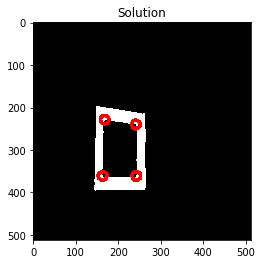

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5845.png
[{'area': 6448, 'centroid': (277, 262), 'corners': array([[255.49377, 255.4984 ],
       [306.3087 , 209.47372],
       [247.71906, 215.3493 ],
       [305.83478, 313.4312 ],
       [248.32161, 310.79324]], dtype=float32)}, {'area': 13200, 'centroid': (275, 263), 'corners': array([[255.49435, 255.49821],
       [318.21634, 186.75766],
       [232.32845, 194.32994],
       [232.81879, 335.1812 ],
       [318.67154, 336.67007]], dtype=float32)}]


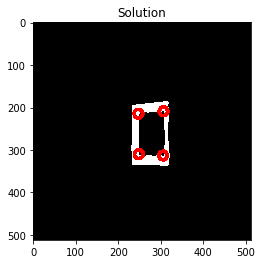

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7735 (1).png
[{'area': 21432, 'centroid': (285, 297), 'corners': array([[255.49176, 255.48875],
       [232.4514 , 201.22598],
       [339.77405, 215.4514 ],
       [228.75262, 385.6622 ],
       [340.7116 , 386.23114]], dtype=float32)}, {'area': 47538, 'centroid': (284, 299), 'corners': array([[255.49251, 255.48906],
       [205.75768, 153.78363],
       [365.64276, 179.60808],
       [371.65115, 428.28018],
       [201.48273, 432.4497 ]], dtype=float32)}]


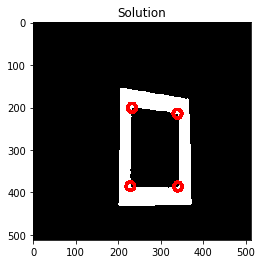

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9574.png
[{'area': 28217, 'centroid': (257, 292), 'corners': array([[255.49931, 255.49017],
       [193.57593, 190.57593],
       [322.65125, 191.71997],
       [189.55995, 391.45273],
       [326.42407, 391.42407]], dtype=float32)}, {'area': 60588, 'centroid': (258, 294), 'corners': array([[255.4991 , 255.48962],
       [164.33002, 144.32837],
       [353.67154, 148.32993],
       [155.81879, 440.1812 ],
       [359.7076 , 440.55804]], dtype=float32)}]


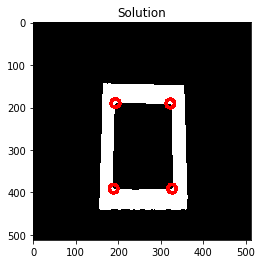

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2238.png
[{'area': 12298, 'centroid': (221, 304), 'corners': array([[255.50969, 255.48685],
       [181.0961 , 230.84875],
       [261.65125, 241.71997],
       [179.32841, 371.67004],
       [262.73334, 371.12686]], dtype=float32)}, {'area': 26625, 'centroid': (221, 305), 'corners': array([[255.50928, 255.48643],
       [163.29341, 195.4415 ],
       [284.1812 , 213.81879],
       [285.18704, 403.91046],
       [160.32289, 408.6325 ]], dtype=float32)}]


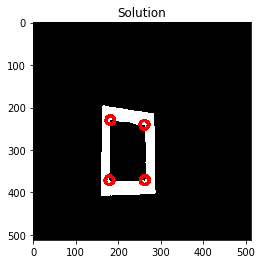

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0335.png
[{'area': 19040, 'centroid': (314, 291), 'corners': array([[255.484  , 255.49031],
       [261.81296, 208.08954],
       [367.05328, 209.47815],
       [258.08954, 371.18704],
       [367.6507 , 375.28094]], dtype=float32)}, {'area': 40016, 'centroid': (315, 293), 'corners': array([[255.48352, 255.48962],
       [237.08305, 172.83702],
       [394.67154, 171.32993],
       [232.83704, 411.91696],
       [397.28586, 415.59842]], dtype=float32)}]


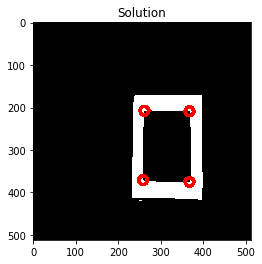

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8700.png
[{'area': 31831, 'centroid': (302, 275), 'corners': array([[255.48708, 255.49503],
       [237.09612, 158.84909],
       [371.16348, 172.08357],
       [367.48032, 382.39102],
       [234.57593, 386.42407]], dtype=float32)}, {'area': 68208, 'centroid': (302, 276), 'corners': array([[255.48706, 255.49503],
       [204.86874, 106.293  ],
       [403.16296, 128.08305],
       [403.67007, 428.67154],
       [200.81879, 441.1812 ]], dtype=float32)}]


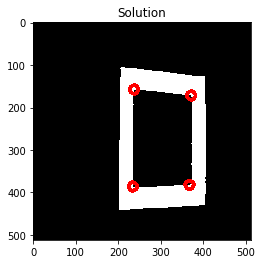

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6263.png
[{'area': 11760, 'centroid': (292, 302), 'corners': array([[253.99915, 252.49994],
       [255.81296, 228.08954],
       [329.4734 , 237.73695],
       [331.45273, 369.44006],
       [252.86876, 372.70682]], dtype=float32)}, {'area': 25800, 'centroid': (292, 304), 'corners': array([[253.99915, 252.49994],
       [235.60225, 191.75157],
       [352.209  , 212.03125],
       [353.90894, 402.19354],
       [233.81879, 408.1812 ]], dtype=float32)}]


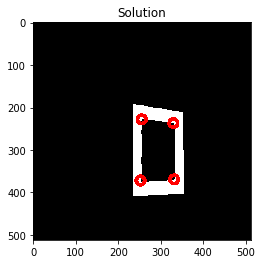

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6811.png
[{'area': 5500, 'centroid': (268, 247), 'corners': array([[255.49677, 255.50293],
       [243.81294, 197.08957],
       [294.15137, 204.09618],
       [242.74602, 290.68646],
       [293.91083, 292.1869 ]], dtype=float32)}, {'area': 11232, 'centroid': (267, 246), 'corners': array([[255.49693, 255.50294],
       [232.16623, 172.2608 ],
       [306.23102, 185.28835],
       [229.88577, 315.68295],
       [306.6213 , 316.30682]], dtype=float32)}]


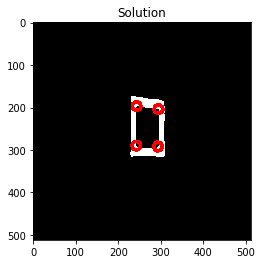

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2129.png
[{'area': 51986, 'centroid': (267, 233), 'corners': array([[255.49677, 255.50645],
       [354.30383,  92.64723],
       [180.58795,  98.43195],
       [360.15045, 367.90445],
       [173.32997, 367.67157]], dtype=float32)}, {'area': 109473, 'centroid': (268, 235), 'corners': array([[255.49622 , 255.50632 ],
       [397.2184  ,  31.781597],
       [138.32845 ,  35.32994 ],
       [135.67473 , 431.2723  ],
       [407.77405 , 432.54858 ]], dtype=float32)}]


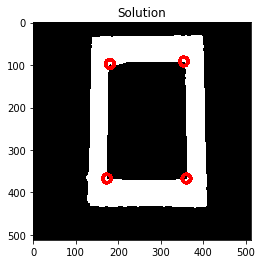

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8553 (1).png
[{'area': 4429, 'centroid': (227, 312), 'corners': array([[255.50766, 255.48378],
       [246.15642, 260.3224 ],
       [206.90973, 272.4978 ],
       [246.2237 , 359.91406],
       [208.85213, 360.87567]], dtype=float32)}, {'area': 10404, 'centroid': (226, 314), 'corners': array([[255.50783, 255.48358],
       [258.18124, 236.81876],
       [192.31804, 254.21013],
       [258.1616 , 384.65714],
       [192.66579, 389.58566]], dtype=float32)}]


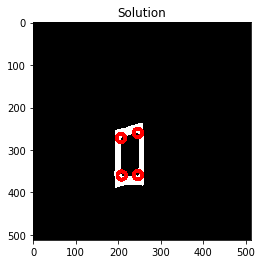

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3524.png
[{'area': 2940, 'centroid': (256, 312), 'corners': array([[255.49973, 255.48448],
       [236.81296, 278.08954],
       [276.18124, 278.81876],
       [237.2768 , 345.72104],
       [276.91083, 344.1869 ]], dtype=float32)}, {'area': 6240, 'centroid': (257, 312), 'corners': array([[255.49965, 255.48427],
       [225.4704 , 261.22614],
       [286.16296, 262.08304],
       [285.91898, 363.36008],
       [227.83717, 364.91708]], dtype=float32)}]


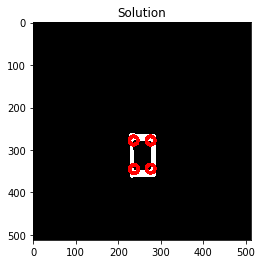

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0593.png
[{'area': 11016, 'centroid': (264, 255), 'corners': array([[255.49767, 255.49979],
       [302.42792, 188.45088],
       [224.76883, 194.28839],
       [224.71997, 317.65125],
       [303.18124, 324.18124]], dtype=float32)}, {'area': 23400, 'centroid': (264, 257), 'corners': array([[255.49773, 255.49931],
       [322.1812 , 156.81879],
       [205.08333, 166.83719],
       [208.69617, 351.35275],
       [318.7075 , 358.5581 ]], dtype=float32)}]


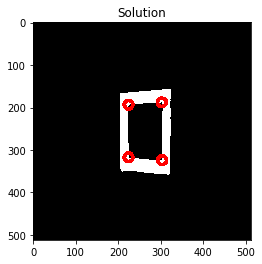

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6882.png
[{'area': 5390, 'centroid': (251, 258), 'corners': array([[255.5007 , 255.4992 ],
       [276.31   , 211.12634],
       [225.53783, 217.53838],
       [275.70755, 305.55807],
       [227.2884 , 305.2312 ]], dtype=float32)}, {'area': 11398, 'centroid': (251, 258), 'corners': array([[255.50092, 255.4996 ],
       [290.4047 , 188.15916],
       [209.44199, 200.29237],
       [290.67154, 324.67007],
       [211.43442, 325.30923]], dtype=float32)}]


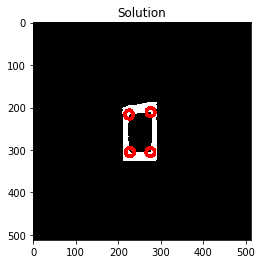

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5208.png
[{'area': 26329, 'centroid': (254, 279), 'corners': array([[255.49957, 255.49425],
       [303.3652 , 158.74016],
       [197.89445, 190.29774],
       [200.26067, 381.16016],
       [306.34244, 394.57877]], dtype=float32)}, {'area': 60502, 'centroid': (257, 281), 'corners': array([[255.49763, 255.49289],
       [333.44495,  95.19015],
       [171.42198, 151.314  ],
       [169.18243, 424.07556],
       [337.60248, 454.67078]], dtype=float32)}]


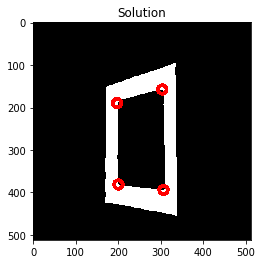

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1686.png
[{'area': 3115, 'centroid': (241, 313), 'corners': array([[255.50346, 255.48419],
       [257.77252, 268.46954],
       [225.71902, 273.34933],
       [257.6716 , 354.67004],
       [226.78166, 354.21832]], dtype=float32)}, {'area': 7344, 'centroid': (240, 313), 'corners': array([[255.50383, 255.48322],
       [268.21637, 246.75768],
       [213.08955, 256.81296],
       [215.6827 , 376.2911 ],
       [265.6686 , 381.6643 ]], dtype=float32)}]


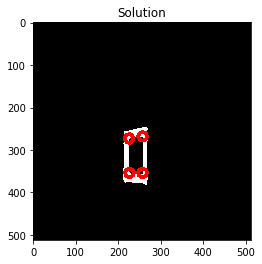

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5683.png
[{'area': 10795, 'centroid': (270, 280), 'corners': array([[255.49594, 255.493  ],
       [229.83696, 218.08336],
       [311.21835, 219.78165],
       [229.71906, 342.6507 ],
       [309.74243, 341.3054 ]], dtype=float32)}, {'area': 22509, 'centroid': (270, 282), 'corners': array([[255.49594, 255.49265],
       [210.57584, 190.57584],
       [331.1812 , 191.81879],
       [209.32845, 373.67007],
       [331.67007, 372.67154]], dtype=float32)}]


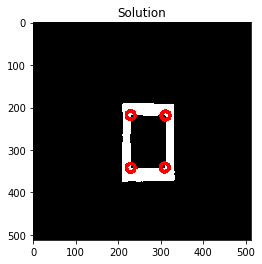

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1896.png
[{'area': 6572, 'centroid': (242, 275), 'corners': array([[255.50294, 255.49501],
       [266.0341 , 211.28896],
       [218.09654, 223.82872],
       [267.6716 , 332.67004],
       [217.08917, 331.18686]], dtype=float32)}, {'area': 14742, 'centroid': (242, 275), 'corners': array([[255.50311, 255.49547],
       [280.6459 , 178.71432],
       [202.12395, 200.85216],
       [201.69427, 357.74207],
       [282.41394, 361.22824]], dtype=float32)}]


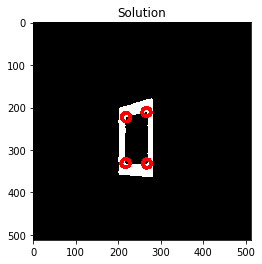

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8403 (1).png
[{'area': 47502, 'centroid': (207, 238), 'corners': array([[255.51291, 255.50516],
       [125.85212, 106.12422],
       [291.26776, 109.68449],
       [116.54732, 365.43994],
       [298.73935, 363.16013]], dtype=float32)}, {'area': 103410, 'centroid': (205, 241), 'corners': array([[255.51305 , 255.50494 ],
       [ 86.348885,  43.719757],
       [329.64276 ,  57.608074],
       [343.6703  , 420.67133 ],
       [ 72.78182 , 426.61813 ]], dtype=float32)}]


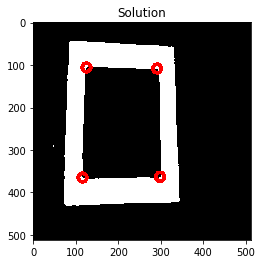

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4095.png
[{'area': 13616, 'centroid': (238, 274), 'corners': array([[255.50493, 255.49515],
       [279.18704, 200.08954],
       [193.52155, 207.47342],
       [281.46213, 343.46167],
       [193.78166, 344.21832]], dtype=float32)}, {'area': 29430, 'centroid': (237, 275), 'corners': array([[255.50499, 255.49493],
       [299.48993, 162.78885],
       [168.78886, 179.51016],
       [172.28838, 377.23108],
       [302.7075 , 383.5581 ]], dtype=float32)}]


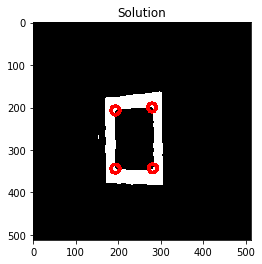

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9691.png
[{'area': 19895, 'centroid': (236, 282), 'corners': array([[255.50508, 255.49286],
       [291.16284, 196.08336],
       [182.54732, 199.56004],
       [293.31024, 365.87326],
       [180.26927, 366.25165]], dtype=float32)}, {'area': 43344, 'centroid': (238, 284), 'corners': array([[255.50488, 255.49231],
       [317.904  , 156.84889],
       [157.32845, 163.32994],
       [323.67163, 405.66998],
       [152.22752, 408.53052]], dtype=float32)}]


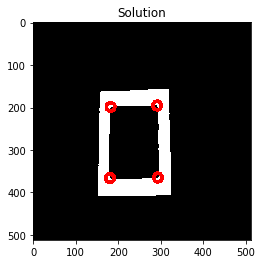

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2104.png
[{'area': 8003, 'centroid': (230, 282), 'corners': array([[255.50764, 255.49284],
       [209.40265, 203.61288],
       [254.50383, 220.59068],
       [205.32841, 353.67004],
       [247.61111, 352.6111 ]], dtype=float32)}]
file has only one shape


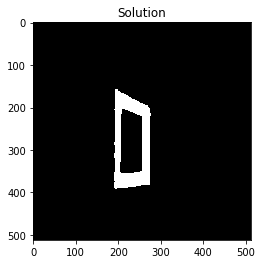

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2506.png
[]
file has only one shape


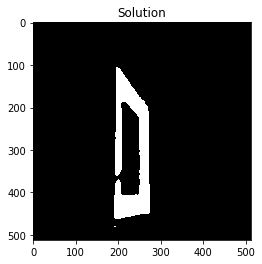

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2289.png
[{'area': 8664, 'centroid': (137, 306), 'corners': array([[255.53256, 255.48586],
       [102.81876, 250.81877],
       [174.12686, 256.26666],
       [101.78166, 360.21832],
       [169.21425, 362.68427]], dtype=float32)}, {'area': 18592, 'centroid': (137, 308), 'corners': array([[255.53313 , 255.48557 ],
       [ 84.53308 , 224.41588 ],
       [193.21114 , 235.51016 ],
       [ 80.818794, 387.1812  ],
       [190.77258 , 389.5304  ]], dtype=float32)}]


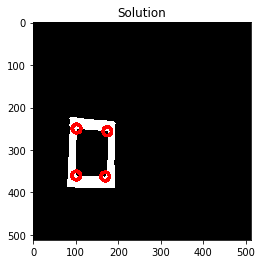

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4276.png
[{'area': 10412, 'centroid': (268, 239), 'corners': array([[255.49664, 255.50452],
       [232.32994, 172.32843],
       [304.53006, 177.63742],
       [302.52658, 302.47845],
       [232.3284 , 308.67   ]], dtype=float32)}, {'area': 22848, 'centroid': (267, 241), 'corners': array([[255.49644, 255.50436],
       [214.29341, 138.4415 ],
       [324.67154, 150.32993],
       [322.39383, 332.55804],
       [215.35408, 344.2857 ]], dtype=float32)}]


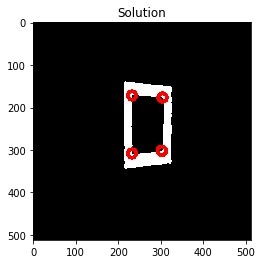

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8842.png
[{'area': 50103, 'centroid': (254, 281), 'corners': array([[255.50003, 255.49368],
       [174.57596, 131.57596],
       [340.42407, 154.57593],
       [339.3158 , 411.5529 ],
       [171.1888 , 422.72818]], dtype=float32)}, {'area': 111872, 'centroid': (251, 283), 'corners': array([[255.50229 , 255.4936  ],
       [135.16577 ,  58.568535],
       [376.67157 , 104.32996 ],
       [383.3626  , 465.53    ],
       [128.03134 , 497.20892 ]], dtype=float32)}]


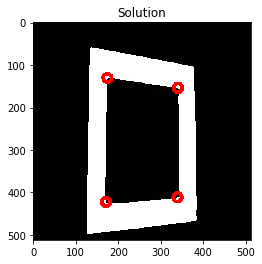

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5069.png
[{'area': 8892, 'centroid': (256, 284), 'corners': array([[255.49965, 255.4919 ],
       [294.18115, 227.81883],
       [219.54732, 229.56004],
       [293.24738, 340.6622 ],
       [219.32997, 341.67157]], dtype=float32)}, {'area': 18870, 'centroid': (255, 286), 'corners': array([[255.49992, 255.49155],
       [309.7076 , 200.44196],
       [200.7693 , 204.28831],
       [310.24228, 371.21643],
       [200.32985, 369.67145]], dtype=float32)}]


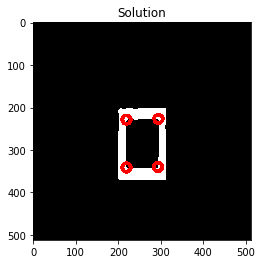

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3229.png
[]
file has only one shape


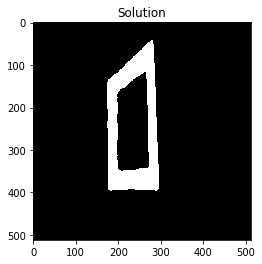

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1751.png
[]
file has only one shape


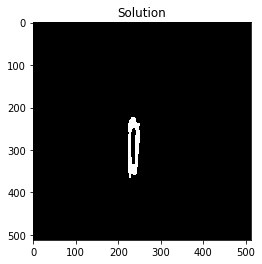

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0553.png
[{'area': 18920, 'centroid': (237, 232), 'corners': array([[255.50516, 255.5064 ],
       [291.21832, 147.78166],
       [183.81311, 148.08917],
       [183.32997, 314.67157],
       [289.6716 , 318.67004]], dtype=float32)}, {'area': 41148, 'centroid': (238, 232), 'corners': array([[255.50508, 255.50632],
       [318.66998, 106.32836],
       [155.75218, 112.3379 ],
       [157.08305, 352.16296],
       [314.72998, 362.24356]], dtype=float32)}]


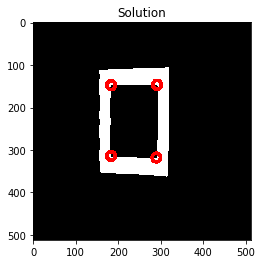

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4637.png
[{'area': 2449, 'centroid': (257, 245), 'corners': array([[255.49901, 255.50276],
       [249.47368, 207.26315],
       [271.2184 , 207.7816 ],
       [244.76886, 281.7116 ],
       [270.16296, 283.91663]], dtype=float32)}, {'area': 5733, 'centroid': (256, 246), 'corners': array([[255.49937, 255.50246],
       [281.30472, 189.40118],
       [233.77644, 193.27042],
       [234.56003, 302.4527 ],
       [277.73764, 307.7556 ]], dtype=float32)}]


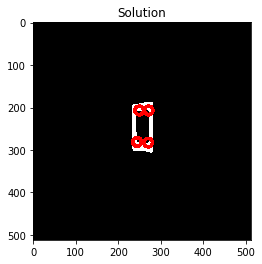

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7163.png
[{'area': 18786, 'centroid': (250, 265), 'corners': array([[255.50075, 255.49858],
       [291.62076, 157.43524],
       [207.02446, 186.71692],
       [295.6716 , 354.67004],
       [202.09674, 355.1711 ]], dtype=float32)}, {'area': 42441, 'centroid': (252, 264), 'corners': array([[255.50043, 255.49858],
       [315.7725 ,  99.46954],
       [180.84567, 160.67476],
       [180.34921, 396.28073],
       [319.7075 , 402.5581 ]], dtype=float32)}]


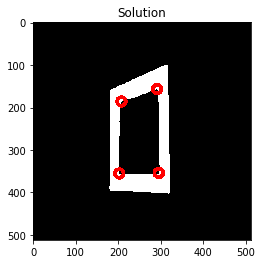

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9348.png
[{'area': 68153, 'centroid': (262, 255), 'corners': array([[255.49767, 255.50008],
       [162.68402,  93.44719],
       [367.67157, 100.32996],
       [366.73935, 409.16013],
       [160.08954, 416.18704]], dtype=float32)}, {'area': 144570, 'centroid': (261, 255), 'corners': array([[255.49794 , 255.50014 ],
       [113.40237 ,  15.387303],
       [413.72934 ,  35.776836],
       [416.21838 , 477.21838 ],
       [110.328445, 490.67007 ]], dtype=float32)}]


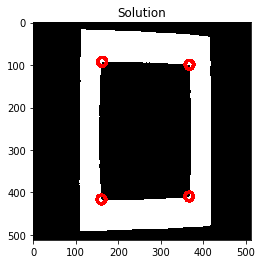

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5400.png
[]
file has only one shape


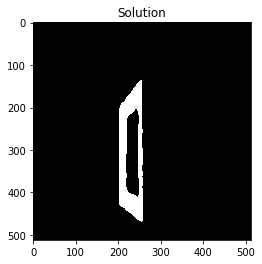

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3692.png
[{'area': 35264, 'centroid': (228, 280), 'corners': array([[255.50694, 255.49333],
       [156.08917, 163.81311],
       [304.16348, 172.08357],
       [305.8765 , 389.14752],
       [155.85248, 394.8765 ]], dtype=float32)}, {'area': 75936, 'centroid': (229, 280), 'corners': array([[255.50687 , 255.49341 ],
       [119.40687 , 112.78233 ],
       [339.14993 , 115.09531 ],
       [343.1628  , 441.9167  ],
       [118.837036, 449.91696 ]], dtype=float32)}]


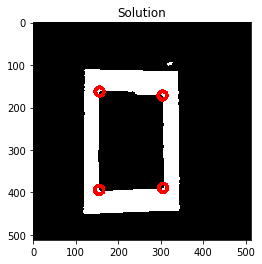

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6884.png
[{'area': 45120, 'centroid': (271, 255), 'corners': array([[255.49472, 255.5021 ],
       [337.449  , 103.12614],
       [192.98749, 155.78891],
       [349.52692, 373.47833],
       [190.71997, 382.65125]], dtype=float32)}, {'area': 101185, 'centroid': (275, 256), 'corners': array([[255.49377 , 255.50168 ],
       [373.7136  ,  30.796751],
       [160.76904 , 111.28834 ],
       [397.24762 , 435.7887  ],
       [153.2168  , 443.06924 ]], dtype=float32)}]


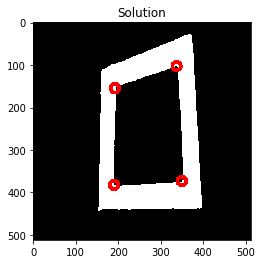

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7235 (1).png
[{'area': 12922, 'centroid': (264, 305), 'corners': array([[255.49731, 255.48613],
       [309.538  , 236.7094 ],
       [220.57593, 238.57593],
       [309.42575, 374.33173],
       [221.83635, 375.71103]], dtype=float32)}, {'area': 27470, 'centroid': (264, 307), 'corners': array([[255.49753, 255.48578],
       [330.55798, 204.29227],
       [199.32845, 210.32994],
       [199.51015, 408.21115],
       [330.96866, 409.20892]], dtype=float32)}]


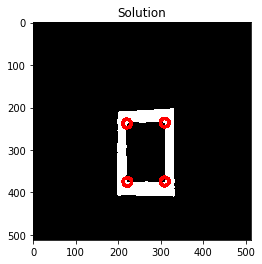

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9015.png
[]
file has only one shape


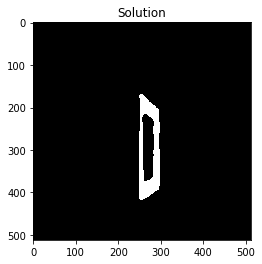

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2703.png
[{'area': 8214, 'centroid': (223, 326), 'corners': array([[255.50887, 255.48036],
       [188.08357, 272.83652],
       [258.6716 , 272.32996],
       [188.45084, 381.77322],
       [258.30994, 380.8738 ]], dtype=float32)}, {'area': 18315, 'centroid': (223, 328), 'corners': array([[255.50887, 255.48022],
       [275.7076 , 244.44196],
       [169.81879, 246.8188 ],
       [167.81879, 409.1812 ],
       [279.16296, 408.91696]], dtype=float32)}]


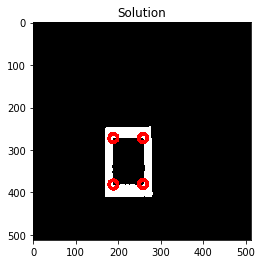

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6199.png
[{'area': 22320, 'centroid': (205, 280), 'corners': array([[255.51419, 255.49208],
       [169.88644, 146.31749],
       [247.08026, 188.57512],
       [238.55548, 388.97656],
       [161.44136, 393.7064 ]], dtype=float32)}]
file has only one shape


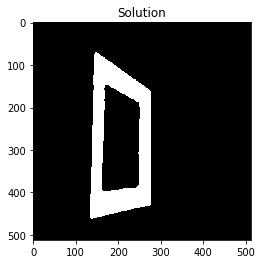

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6549.png
[{'area': 25875, 'centroid': (228, 259), 'corners': array([[255.50725, 255.49916],
       [287.5486 , 154.22598],
       [168.18932, 170.27124],
       [169.22893, 358.805  ],
       [289.96866, 360.20895]], dtype=float32)}, {'area': 55024, 'centroid': (229, 261), 'corners': array([[255.50706, 255.49901],
       [316.18124, 103.81876],
       [139.85007, 131.0953 ],
       [139.8291 , 401.90372],
       [318.96866, 409.20892]], dtype=float32)}]


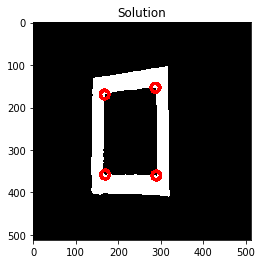

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7714 (1).png
[{'area': 7772, 'centroid': (281, 312), 'corners': array([[252.39775, 253.3291 ],
       [252.39749, 253.3291 ],
       [314.2951 , 261.19672],
       [249.71906, 365.6507 ],
       [311.6507 , 367.28094]], dtype=float32)}, {'area': 16393, 'centroid': (282, 313), 'corners': array([[252.39775, 253.3291 ],
       [236.75768, 225.78363],
       [329.67163, 239.33002],
       [235.29317, 395.13126],
       [329.18704, 393.9105 ]], dtype=float32)}]


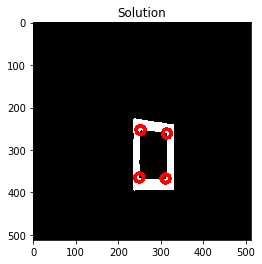

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9848.png
[{'area': 7350, 'centroid': (300, 266), 'corners': array([[255.4877 , 255.49704],
       [330.21725, 213.40714],
       [267.78168, 216.78166],
       [267.78168, 315.21832],
       [334.16348, 316.9164 ]], dtype=float32)}, {'area': 15200, 'centroid': (301, 266), 'corners': array([[255.48743, 255.49698],
       [349.18115, 188.81885],
       [251.74146, 197.3273 ],
       [351.1812 , 340.1812 ],
       [252.83704, 339.91663]], dtype=float32)}]


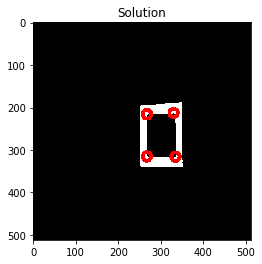

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5870.png
[{'area': 15390, 'centroid': (265, 253), 'corners': array([[255.49727, 255.50061],
       [309.70673, 171.44153],
       [219.09642, 182.82893],
       [219.42178, 330.43024],
       [311.16348, 332.9164 ]], dtype=float32)}, {'area': 33320, 'centroid': (265, 255), 'corners': array([[255.49725, 255.50034],
       [331.70657, 133.4415 ],
       [195.12425, 152.85213],
       [198.83852, 366.41943],
       [333.77386, 372.5296 ]], dtype=float32)}]


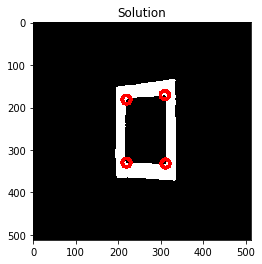

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7945.png
[{'area': 4370, 'centroid': (235, 306), 'corners': array([[255.23837, 258.30527],
       [255.23845, 258.30536],
       [212.2603 , 267.92163],
       [254.53825, 352.63055],
       [215.06572, 352.1164 ]], dtype=float32)}, {'area': 9316, 'centroid': (234, 307), 'corners': array([[255.23837, 258.30527],
       [268.67004, 239.32843],
       [200.69093, 247.4346 ],
       [198.32791, 367.1689 ],
       [266.70032, 377.5737 ]], dtype=float32)}]


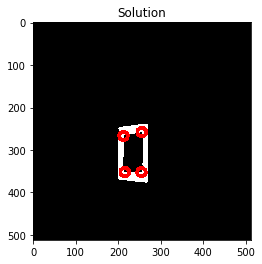

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7040.png
[{'area': 60420, 'centroid': (281, 263), 'corners': array([[255.4929 , 255.49974],
       [197.35854,  93.68502],
       [369.45267, 134.56006],
       [382.8765 , 406.14752],
       [193.55995, 411.45273]], dtype=float32)}, {'area': 138589, 'centroid': (277, 270), 'corners': array([[255.49507, 255.4994 ],
       [156.63141,  18.57253],
       [406.91663,  81.83701],
       [431.67007, 470.67154],
       [139.29234, 493.55804]], dtype=float32)}]


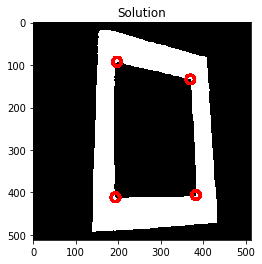

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9213.png
[{'area': 46025, 'centroid': (191, 253), 'corners': array([[255.5173  , 255.50049 ],
       [106.463554, 123.591866],
       [278.1869  , 124.08919 ],
       [276.7116  , 382.23114 ],
       [107.08953 , 385.18704 ]], dtype=float32)}, {'area': 97282, 'centroid': (190, 253), 'corners': array([[255.51772 , 255.50049 ],
       [ 62.86882 ,  62.293392],
       [317.24228 ,  67.78357 ],
       [316.67017 , 440.67145 ],
       [ 66.78162 , 445.21838 ]], dtype=float32)}]


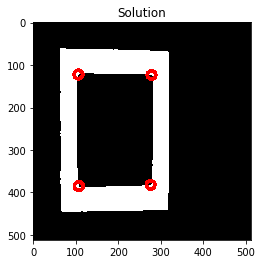

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8584 (1).png
[]
file has only one shape


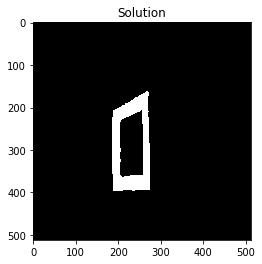

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7360.png
[{'area': 23712, 'centroid': (259, 271), 'corners': array([[255.49794, 255.49652],
       [309.16287, 163.08337],
       [203.87442, 188.45084],
       [315.18124, 367.18124],
       [205.26964, 367.25195]], dtype=float32)}, {'area': 52390, 'centroid': (261, 272), 'corners': array([[255.4974 , 255.49704],
       [334.83417, 106.56853],
       [177.0785 , 154.8609 ],
       [177.08305, 408.16296],
       [343.97073, 418.21423]], dtype=float32)}]


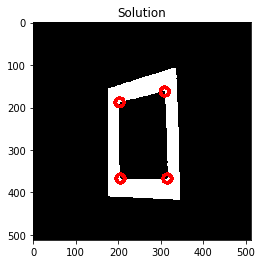

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8197 (1).png
[]
file has only one shape


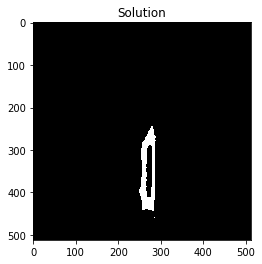

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7952.png
[{'area': 4802, 'centroid': (207, 302), 'corners': array([[255.51323, 255.48694],
       [230.18123, 253.81877],
       [184.76886, 259.2884 ],
       [229.67159, 349.67004],
       [184.57591, 348.42407]], dtype=float32)}, {'area': 10152, 'centroid': (206, 303), 'corners': array([[255.51332, 255.48685],
       [242.1812 , 231.8188 ],
       [171.12425, 240.85213],
       [171.685  , 367.64145],
       [241.16315, 374.91687]], dtype=float32)}]


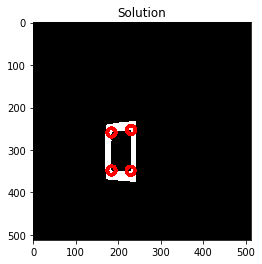

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3493.png
[{'area': 3600, 'centroid': (264, 309), 'corners': array([[250.50027, 256.69272],
       [240.83707, 274.08337],
       [287.16348, 273.0836 ],
       [242.81313, 346.91083],
       [287.67004, 345.6716 ]], dtype=float32)}, {'area': 8288, 'centroid': (265, 310), 'corners': array([[250.50027, 256.69272],
       [300.2802 , 256.34888],
       [229.08333, 256.8372 ],
       [301.1475 , 363.8762 ],
       [230.32993, 366.67154]], dtype=float32)}]


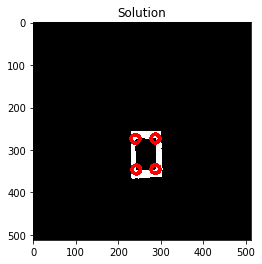

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0701.png
[]
file has only one shape


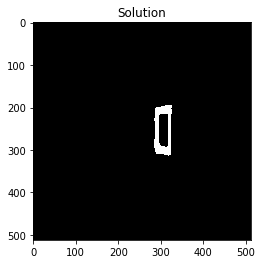

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4732.png
[]
file has only one shape


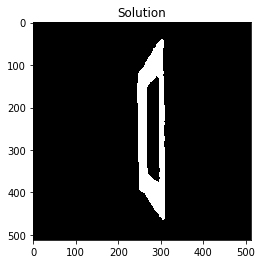

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4547.png
[{'area': 37444, 'centroid': (270, 241), 'corners': array([[255.49591 , 255.50412 ],
       [338.20352 , 114.286415],
       [196.44719 , 133.68402 ],
       [199.5197  , 355.39102 ],
       [341.69806 , 367.54648 ]], dtype=float32)}, {'area': 80464, 'centroid': (273, 241), 'corners': array([[255.494  , 255.50452],
       [376.24234,  52.78364],
       [162.7816 ,  87.78159],
       [164.32993, 399.67154],
       [374.6025 , 429.6708 ]], dtype=float32)}]


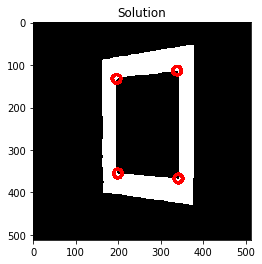

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7623.png
[{'area': 19055, 'centroid': (255, 298), 'corners': array([[255.50003, 255.48839],
       [303.16284, 204.08336],
       [206.54478, 218.0497 ],
       [203.68999, 383.87366],
       [305.69806, 388.54648]], dtype=float32)}, {'area': 42042, 'centroid': (255, 300), 'corners': array([[255.49933, 255.48833],
       [327.70673, 160.44156],
       [179.76906, 189.28833],
       [176.32974, 419.67136],
       [331.2008 , 433.79663]], dtype=float32)}]


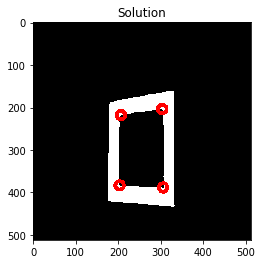

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1328.png
[{'area': 50622, 'centroid': (247, 261), 'corners': array([[255.50233, 255.4991 ],
       [332.18704, 116.08953],
       [159.74144, 132.3273 ],
       [157.08917, 393.18686],
       [333.54916, 401.77322]], dtype=float32)}, {'area': 109460, 'centroid': (250, 262), 'corners': array([[255.5017  , 255.49922 ],
       [374.1561  ,  48.105217],
       [120.818825,  75.818825],
       [116.61599 , 450.5451  ],
       [377.6918  , 469.39346 ]], dtype=float32)}]


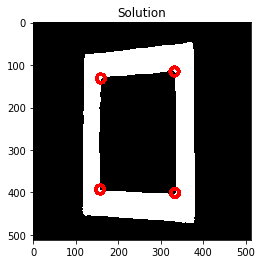

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4699.png
[]
file has only one shape


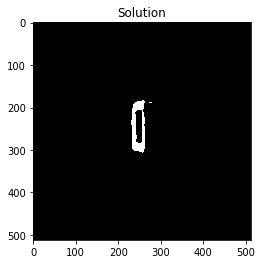

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8757 (1).png
[{'area': 7808, 'centroid': (257, 272), 'corners': array([[255.49992, 255.49565],
       [229.25177, 210.52873],
       [287.578  , 219.31398],
       [227.12422, 330.1479 ],
       [286.21835, 329.21832]], dtype=float32)}, {'area': 17542, 'centroid': (257, 274), 'corners': array([[255.4994 , 255.49521],
       [212.57593, 182.57593],
       [307.24753, 196.3379 ],
       [304.1628 , 354.9167 ],
       [212.28249, 364.29532]], dtype=float32)}]


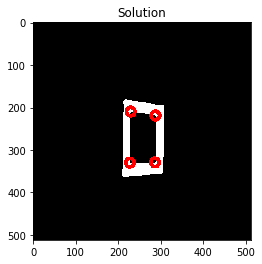

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7317 (1).png
[{'area': 11869, 'centroid': (218, 305), 'corners': array([[259.99957, 251.49997],
       [258.2385 , 233.30534],
       [179.83984, 242.26065],
       [257.8549 , 374.79013],
       [176.83713, 373.91663]], dtype=float32)}, {'area': 25254, 'centroid': (217, 307), 'corners': array([[259.99957, 251.49997],
       [279.2857 , 203.35416],
       [158.32845, 215.32994],
       [156.77625, 407.33447],
       [277.6213 , 409.30682]], dtype=float32)}]


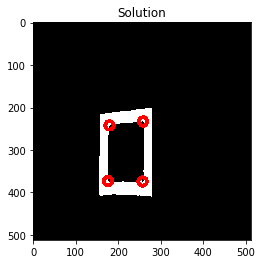

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1510.png
[{'area': 9880, 'centroid': (239, 305), 'corners': array([[255.50478, 255.4865 ],
       [212.74779, 227.23708],
       [271.15433, 244.67476],
       [270.16287, 373.91663],
       [208.81877, 378.18124]], dtype=float32)}, {'area': 22869, 'centroid': (239, 306), 'corners': array([[255.50516, 255.486  ],
       [195.22238, 186.52254],
       [288.5269 , 216.52165],
       [290.3626 , 403.53   ],
       [193.37909, 419.56485]], dtype=float32)}]


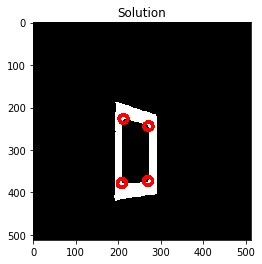

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0926.png
[{'area': 672, 'centroid': (349, 459), 'corners': array([[255.47197, 255.43878],
       [358.1653 , 450.57623],
       [334.87762, 457.94022],
       [367.26187, 465.45053],
       [336.2286 , 469.3791 ]], dtype=float32)}, {'area': 79234, 'centroid': (279, 306), 'corners': array([[255.49327, 255.4864 ],
       [170.21004, 131.31813],
       [391.31024, 135.12674],
       [164.98149, 475.055  ],
       [392.31598, 475.5528 ]], dtype=float32)}, {'area': 154584, 'centroid': (281, 285), 'corners': array([[255.50392 , 255.50087 ],
       [120.288246,  55.769474],
       [441.91666 ,  61.837048],
       [112.24552 , 508.305   ],
       [323.33334 , 510.33334 ]], dtype=float32)}]
file has more than 2 shapes for a gate, hence quitting 


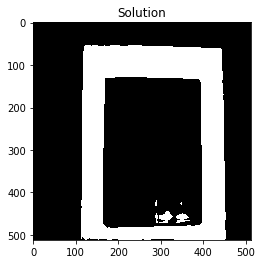

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9334.png
[{'area': 13348, 'centroid': (261, 270), 'corners': array([[255.49835, 255.49588],
       [216.57593, 200.57593],
       [307.16348, 202.08357],
       [216.32841, 339.67004],
       [307.8765 , 339.14752]], dtype=float32)}, {'area': 28085, 'centroid': (262, 271), 'corners': array([[255.49808, 255.49567],
       [195.81296, 169.08952],
       [329.67154, 170.32993],
       [194.32845, 372.67007],
       [330.1928 , 372.9093 ]], dtype=float32)}]


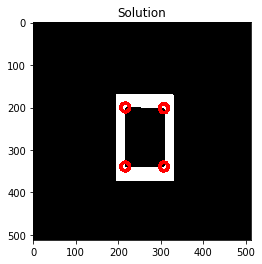

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5158.png
[{'area': 29900, 'centroid': (214, 284), 'corners': array([[255.51134, 255.49237],
       [276.70673, 168.44153],
       [151.18932, 185.27124],
       [149.56004, 387.4527 ],
       [278.15652, 397.6775 ]], dtype=float32)}, {'area': 63460, 'centroid': (216, 286), 'corners': array([[255.51108, 255.49216],
       [307.7067 , 115.86879],
       [121.08333, 143.83719],
       [119.38446, 432.27744],
       [307.83505, 452.43112]], dtype=float32)}]


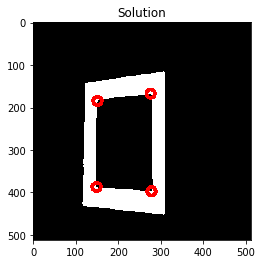

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7815 (1).png
[{'area': 7526, 'centroid': (271, 336), 'corners': array([[252.49994, 260.0008 ],
       [238.32997, 284.32843],
       [305.16348, 286.0836 ],
       [236.81877, 387.18124],
       [304.9164 , 387.16348]], dtype=float32)}, {'area': 16068, 'centroid': (271, 338), 'corners': array([[252.49995, 260.00076],
       [222.81879, 258.8188 ],
       [321.67154, 263.32993],
       [219.71925, 412.6508 ],
       [322.42416, 414.42416]], dtype=float32)}]


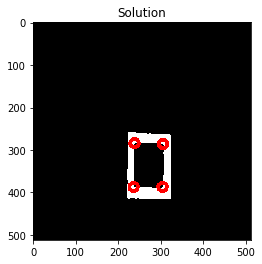

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5028.png
[{'area': 17876, 'centroid': (252, 282), 'corners': array([[255.50069, 255.49258],
       [201.85211, 201.12422],
       [306.5528 , 204.684  ],
       [200.08336, 363.16284],
       [302.45526, 362.95038]], dtype=float32)}, {'area': 37209, 'centroid': (252, 284), 'corners': array([[255.50063, 255.49203],
       [174.86874, 167.29317],
       [331.1812 , 167.81879],
       [330.2034 , 401.71356],
       [175.8384 , 403.65714]], dtype=float32)}]


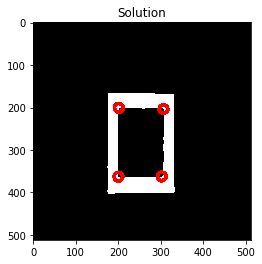

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3213.png
[{'area': 4472, 'centroid': (259, 307), 'corners': array([[255.82762, 259.5116 ],
       [274.62753, 252.98772],
       [239.12093, 265.8842 ],
       [279.18124, 354.18124],
       [241.4514 , 354.77405]], dtype=float32)}, {'area': 9945, 'centroid': (258, 308), 'corners': array([[255.8276 , 259.5116 ],
       [288.6708 , 228.3976 ],
       [226.79623, 247.58911],
       [290.24228, 378.21643],
       [228.88611, 380.68283]], dtype=float32)}]


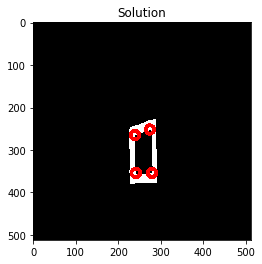

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9824.png
[{'area': 7560, 'centroid': (193, 261), 'corners': array([[255.5173 , 255.49855],
       [161.85211, 208.12425],
       [227.05328, 213.47815],
       [160.08336, 312.16284],
       [226.16287, 312.91663]], dtype=float32)}, {'area': 15708, 'centroid': (193, 262), 'corners': array([[255.51675, 255.49794],
       [147.47653, 184.07764],
       [245.55804, 191.29239],
       [143.83704, 337.91696],
       [243.1628 , 337.9167 ]], dtype=float32)}]


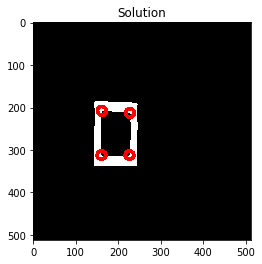

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8668.png
[{'area': 3600, 'centroid': (139, 277), 'corners': array([[255.53316, 255.49406],
       [121.08919, 234.8131 ],
       [158.34056, 240.49141],
       [122.81315, 321.91083],
       [156.91083, 318.18686]], dtype=float32)}, {'area': 8494, 'centroid': (140, 279), 'corners': array([[255.53299, 255.49352],
       [114.77935, 209.5659 ],
       [171.91664, 219.8371 ],
       [170.16302, 339.91666],
       [111.81062, 348.64978]], dtype=float32)}]


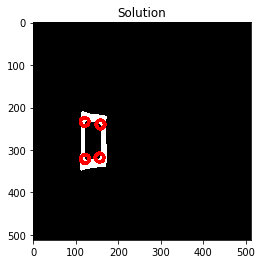

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9497.png
[{'area': 10168, 'centroid': (260, 303), 'corners': array([[255.49873, 255.4868 ],
       [222.83716, 242.08336],
       [299.91046, 247.81296],
       [221.81313, 362.91083],
       [298.91083, 362.1869 ]], dtype=float32)}, {'area': 21122, 'centroid': (261, 305), 'corners': array([[255.49828, 255.48633],
       [205.85213, 215.12425],
       [319.67145, 220.32985],
       [202.83704, 391.91696],
       [318.67007, 392.67154]], dtype=float32)}]


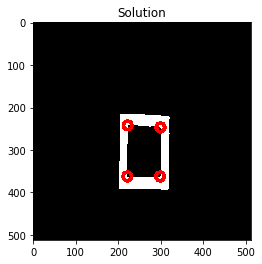

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4858.png
[{'area': 12367, 'centroid': (286, 314), 'corners': array([[255.49194, 255.48376],
       [249.45465, 238.65189],
       [326.72922, 252.76619],
       [325.91083, 382.18683],
       [246.12425, 387.1479 ]], dtype=float32)}, {'area': 26640, 'centroid': (286, 316), 'corners': array([[255.49123, 255.48352],
       [228.35724, 203.60808],
       [346.67154, 219.32993],
       [347.1144 , 415.68298],
       [228.79677, 426.7136 ]], dtype=float32)}]


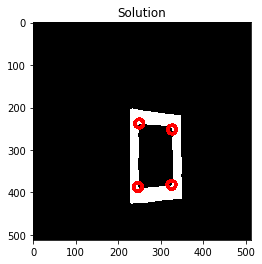

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6892 (1).png
[{'area': 22971, 'centroid': (237, 259), 'corners': array([[255.50592, 255.49745],
       [203.18575, 124.67008],
       [283.1544 , 173.67465],
       [193.57591, 370.42407],
       [272.13928, 369.63495]], dtype=float32)}]
file has only one shape


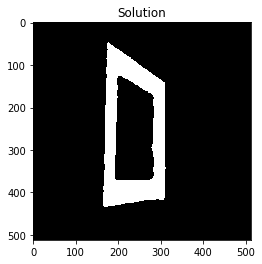

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2878.png
[{'area': 2378, 'centroid': (251, 320), 'corners': array([[255.50105, 255.48224],
       [263.7314 , 278.71597],
       [238.08954, 286.81296],
       [263.91046, 356.18704],
       [239.83716, 357.91666]], dtype=float32)}, {'area': 5148, 'centroid': (249, 321), 'corners': array([[255.5013 , 255.48184],
       [267.5071 , 260.38202],
       [228.68492, 272.35855],
       [229.29239, 377.55804],
       [270.38885, 379.49326]], dtype=float32)}]


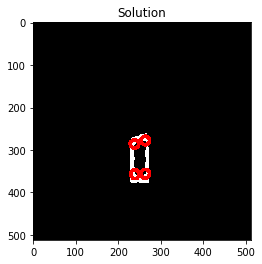

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3886.png
[]
file has only one shape


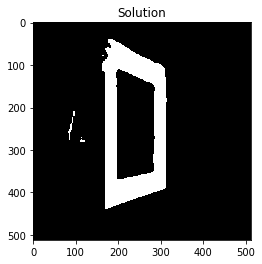

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7026.png
[{'area': 5300, 'centroid': (257, 249), 'corners': array([[255.4996 , 255.50174],
       [236.83713, 197.08336],
       [280.23114, 206.28839],
       [233.18721, 288.4983 ],
       [276.67267, 299.25836]], dtype=float32)}, {'area': 11470, 'centroid': (258, 251), 'corners': array([[255.49957, 255.50195],
       [227.59546, 169.66313],
       [294.77405, 187.4514 ],
       [222.32845, 323.67007],
       [293.72958, 323.22357]], dtype=float32)}]


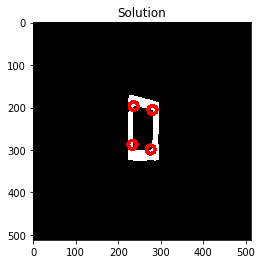

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4741.png
[]
file has only one shape


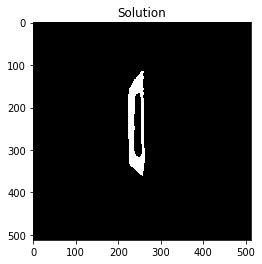

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6945.png
[]
file has only one shape


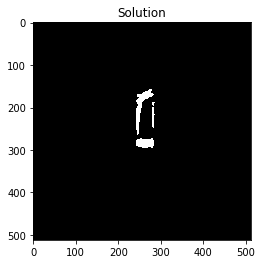

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2396.png
[{'area': 5978, 'centroid': (231, 310), 'corners': array([[255.50636, 255.4849 ],
       [251.23312, 247.17386],
       [208.44717, 261.68405],
       [253.24232, 367.21634],
       [209.56001, 366.4527 ]], dtype=float32)}, {'area': 13067, 'centroid': (230, 311), 'corners': array([[255.5066 , 255.48508],
       [262.23624, 216.37656],
       [193.56854, 240.16579],
       [193.5759 , 392.42407],
       [265.16315, 397.9169 ]], dtype=float32)}]


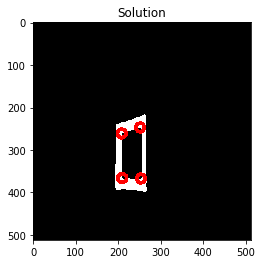

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1662.png
[{'area': 5439, 'centroid': (263, 308), 'corners': array([[254.34694, 257.419  ],
       [286.1564 , 251.3224 ],
       [240.44717, 261.68405],
       [241.85213, 358.87576],
       [285.77423, 362.52936]], dtype=float32)}, {'area': 12210, 'centroid': (263, 309), 'corners': array([[254.34694, 257.419  ],
       [298.1629 , 224.08336],
       [225.84993, 239.09541],
       [225.55998, 383.45273],
       [297.7075 , 390.5581 ]], dtype=float32)}]


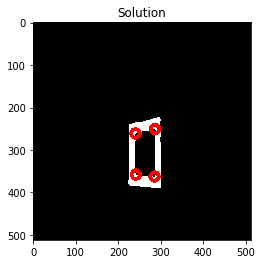

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8322 (1).png
[{'area': 40349, 'centroid': (211, 237), 'corners': array([[255.51314, 255.50667],
       [142.42232, 101.56938],
       [287.31363, 134.93225],
       [133.78166, 353.21832],
       [290.21835, 355.21832]], dtype=float32)}, {'area': 90440, 'centroid': (208, 240), 'corners': array([[255.5146  , 255.50713 ],
       [107.02895 ,  34.786015],
       [320.18118 ,  90.818825],
       [330.44394 , 407.1925  ],
       [ 91.818794, 415.1812  ]], dtype=float32)}]


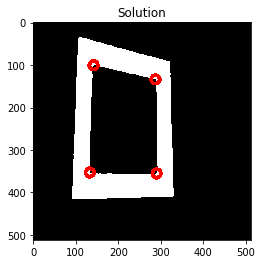

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9651.png
[{'area': 7384, 'centroid': (215, 342), 'corners': array([[255.51093, 255.4763 ],
       [183.81296, 291.08954],
       [248.67159, 292.32996],
       [180.57254, 390.3686 ],
       [250.20894, 390.96866]], dtype=float32)}, {'area': 15049, 'centroid': (215, 343), 'corners': array([[255.51093, 255.47617],
       [167.32993, 268.32846],
       [263.20264, 268.5826 ],
       [164.08   , 414.542  ],
       [266.1812 , 416.1812 ]], dtype=float32)}]


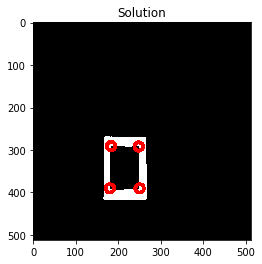

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4640.png
[{'area': 2890, 'centroid': (263, 244), 'corners': array([[255.49738, 255.50334],
       [277.1479 , 203.12434],
       [246.22223, 212.61111],
       [278.18124, 286.18124],
       [255.38889, 285.6111 ]], dtype=float32)}, {'area': 6174, 'centroid': (262, 245), 'corners': array([[255.49762, 255.50313],
       [287.1812 , 181.81879],
       [240.20671, 188.32166],
       [238.68307, 305.50815],
       [285.83505, 309.43112]], dtype=float32)}]


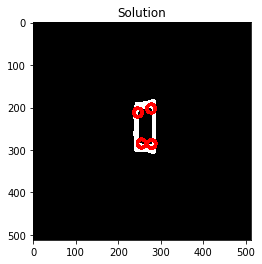

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7276.png
[{'area': 62400, 'centroid': (270, 264), 'corners': array([[255.49641, 255.4995 ],
       [183.77165,  93.58611],
       [360.44006, 126.54728],
       [370.73935, 407.16013],
       [178.74144, 418.6727 ]], dtype=float32)}, {'area': 143766, 'centroid': (266, 268), 'corners': array([[255.49794 , 255.49889 ],
       [139.55533 ,  11.190007],
       [399.16296 ,  73.08302 ],
       [421.1812  , 469.1812  ],
       [126.81879 , 501.1812  ]], dtype=float32)}]


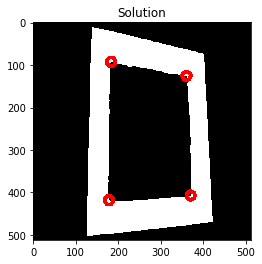

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6679.png
[{'area': 11658, 'centroid': (242, 289), 'corners': array([[255.50336, 255.491  ],
       [269.44763, 197.26945],
       [209.69583, 228.32158],
       [210.57596, 366.42404],
       [273.81586, 371.33252]], dtype=float32)}, {'area': 27089, 'centroid': (242, 289), 'corners': array([[255.5036 , 255.49042],
       [286.61115, 148.29416],
       [190.44717, 194.68405],
       [192.79636, 403.71356],
       [290.41196, 414.56802]], dtype=float32)}]


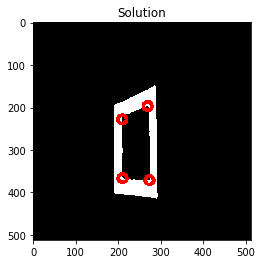

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1565.png
[{'area': 19824, 'centroid': (257, 298), 'corners': array([[255.4997 , 255.48837],
       [205.0961 , 208.84875],
       [311.16348, 218.08357],
       [202.08336, 384.16284],
       [311.1479 , 382.87576]], dtype=float32)}, {'area': 42706, 'centroid': (257, 300), 'corners': array([[255.49939, 255.48805],
       [180.62079, 165.34561],
       [338.9167 , 182.8372 ],
       [339.18704, 423.91046],
       [176.83704, 427.91696]], dtype=float32)}]


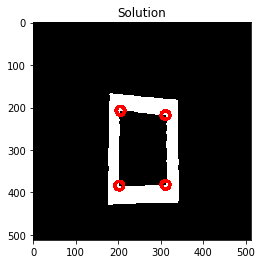

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3668.png
[{'area': 3773, 'centroid': (271, 253), 'corners': array([[255.49553, 255.50055],
       [248.4514 , 217.22597],
       [295.18124, 215.81877],
       [249.34875, 290.28003],
       [294.67004, 290.67157]], dtype=float32)}, {'area': 8322, 'centroid': (271, 253), 'corners': array([[255.4956 , 255.50041],
       [308.5581 , 198.29251],
       [235.32845, 200.32994],
       [307.24774, 307.66217],
       [237.78226, 310.59317]], dtype=float32)}]


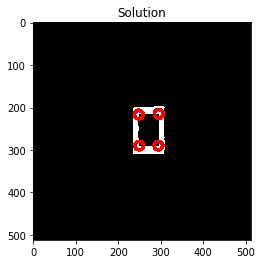

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0642.png
[]
file has only one shape


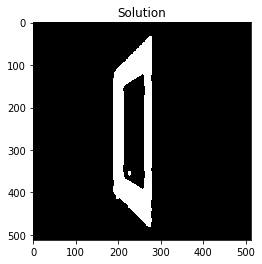

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1949.png
[{'area': 21696, 'centroid': (266, 254), 'corners': array([[255.49681, 255.50067],
       [321.67023, 156.3286 ],
       [211.76883, 170.28839],
       [209.08919, 344.1869 ],
       [322.23105, 346.71164]], dtype=float32)}, {'area': 47595, 'centroid': (268, 256), 'corners': array([[255.49506, 255.50089],
       [349.1812 , 107.81879],
       [184.57585, 135.57585],
       [191.96916, 391.68924],
       [350.87573, 393.1479 ]], dtype=float32)}]


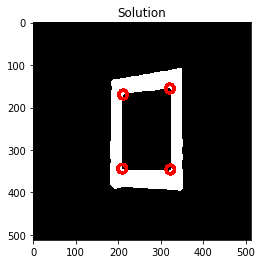

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0715.png
[]
file has only one shape


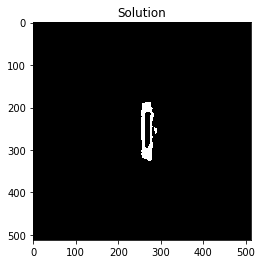

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7149 (1).png
[{'area': 51430, 'centroid': (185, 265), 'corners': array([[255.51923 , 255.49812 ],
       [108.454994, 121.6161  ],
       [275.03455 , 144.43768 ],
       [ 93.559944, 394.45273 ],
       [275.21835 , 396.21832 ]], dtype=float32)}, {'area': 109200, 'centroid': (182, 268), 'corners': array([[255.51987 , 255.49837 ],
       [ 66.81876 ,  54.818764],
       [312.18677 ,  92.08921 ],
       [ 44.78182 , 454.61813 ],
       [317.42416 , 454.42416 ]], dtype=float32)}]


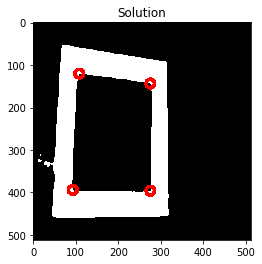

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0096.png
[{'area': 8325, 'centroid': (262, 289), 'corners': array([[255.49808, 255.49072],
       [227.46986, 235.6376 ],
       [298.42407, 234.57593],
       [226.08954, 343.18704],
       [299.67004, 343.6716 ]], dtype=float32)}, {'area': 18094, 'centroid': (264, 290), 'corners': array([[255.49759, 255.49052],
       [314.96875, 205.791  ],
       [210.76892, 213.28838],
       [318.67145, 370.67017],
       [212.78226, 371.59317]], dtype=float32)}]


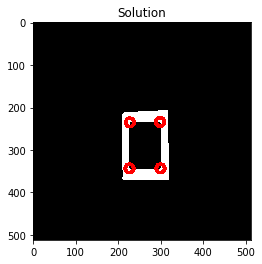

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7316.png
[{'area': 71165, 'centroid': (258, 269), 'corners': array([[255.49924, 255.49767],
       [350.43253,  96.39998],
       [156.76883, 125.28839],
       [367.23114, 417.7116 ],
       [151.09674, 423.1711 ]], dtype=float32)}, {'area': 152000, 'centroid': (262, 273), 'corners': array([[255.49852 , 255.49727 ],
       [394.6213  ,  20.693186],
       [113.47    ,  64.637405],
       [424.1812  , 494.1812  ],
       [103.8372  , 494.9167  ]], dtype=float32)}]


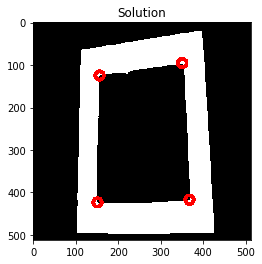

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6176.png
[]
file has only one shape


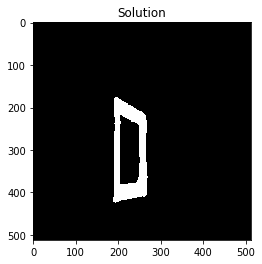

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6094.png
[]
file has only one shape


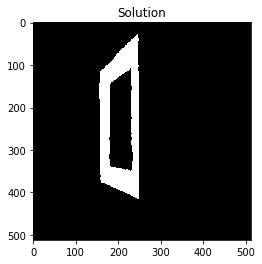

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8639.png
[]
file has only one shape


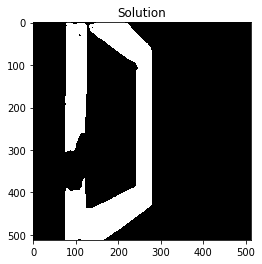

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0123.png
[{'area': 24534, 'centroid': (266, 244), 'corners': array([[255.49785, 255.5008 ],
       [227.28268,  93.91243],
       [311.32507, 148.63553],
       [311.1868 , 359.91083],
       [226.90587, 377.3488 ]], dtype=float32)}]
file has only one shape


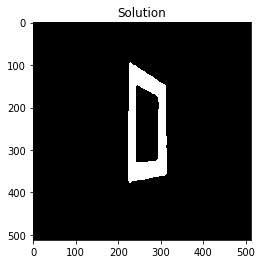

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7654 (1).png
[{'area': 6890, 'centroid': (256, 354), 'corners': array([[255.50006, 255.47198],
       [236.57397, 287.42395],
       [281.95575, 305.5535 ],
       [232.83705, 413.91696],
       [279.28006, 413.65125]], dtype=float32)}, {'area': 14898, 'centroid': (256, 357), 'corners': array([[255.49982, 255.47238],
       [222.4455 , 254.60641],
       [294.9193 , 281.84   ],
       [220.29251, 447.5581 ],
       [297.1812 , 444.1812 ]], dtype=float32)}]


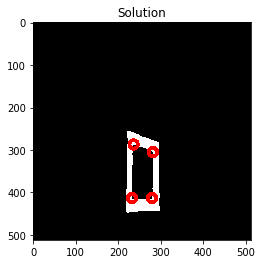

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3708.png
[{'area': 26331, 'centroid': (238, 289), 'corners': array([[255.50447, 255.49072],
       [174.78166, 189.78166],
       [300.00754, 191.5325 ],
       [303.45273, 384.44006],
       [177.16643, 390.73926]], dtype=float32)}, {'area': 57230, 'centroid': (238, 289), 'corners': array([[255.50453, 255.49072],
       [144.32994, 142.32845],
       [333.1812 , 147.81879],
       [336.67007, 429.67154],
       [142.32837, 437.66998]], dtype=float32)}]


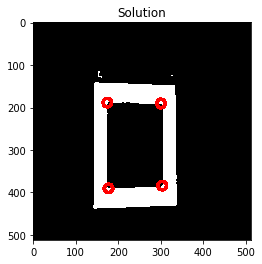

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3899.png
[{'area': 48238, 'centroid': (266, 244), 'corners': array([[255.49684 , 255.5031  ],
       [178.54729 , 111.559944],
       [355.17267 , 111.008095],
       [355.4999  , 376.27277 ],
       [179.81316 , 381.91083 ]], dtype=float32)}, {'area': 103615, 'centroid': (267, 245), 'corners': array([[255.49684 , 255.50296 ],
       [139.5345  ,  48.49155 ],
       [396.27124 ,  51.469765],
       [133.30554 , 438.62762 ],
       [398.8645  , 438.73605 ]], dtype=float32)}]


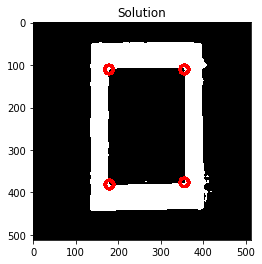

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5801.png
[{'area': 36806, 'centroid': (215, 231), 'corners': array([[255.51126 , 255.5064  ],
       [289.5045  , 112.94214 ],
       [142.0263  , 118.024956],
       [137.32999 , 347.6716  ],
       [291.16348 , 349.9164  ]], dtype=float32)}, {'area': 77158, 'centroid': (216, 233), 'corners': array([[255.51093 , 255.50632 ],
       [326.18115 ,  58.818855],
       [106.80751 ,  67.55607 ],
       [104.683136, 398.55243 ],
       [327.1633  , 404.91672 ]], dtype=float32)}]


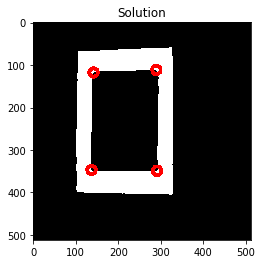

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7873.png
[]
file has only one shape


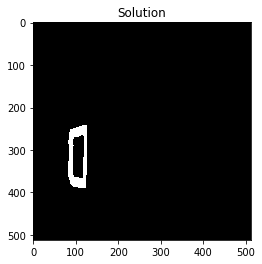

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0691.png
[]
file has only one shape


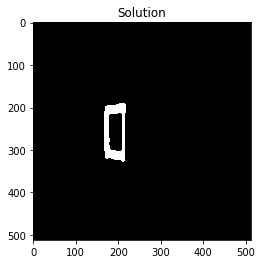

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4757.png
[]
file has only one shape


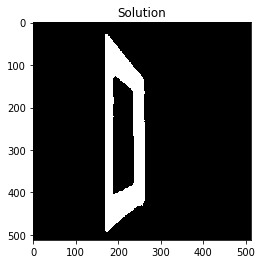

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1843.png
[]
file has only one shape


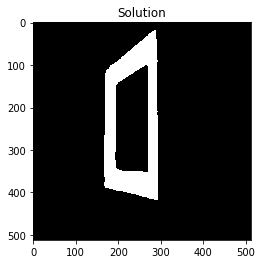

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2091.png
[{'area': 12141, 'centroid': (255, 278), 'corners': array([[255.50067, 255.4945 ],
       [226.2285 , 188.19516],
       [286.40836, 207.46358],
       [220.6375 , 357.53006],
       [290.7116 , 356.2311 ]], dtype=float32)}, {'area': 29344, 'centroid': (255, 278), 'corners': array([[255.50049, 255.49455],
       [206.16794, 136.12561],
       [311.97888, 183.4557 ],
       [309.6247 , 393.8604 ],
       [201.2693 , 399.25238]], dtype=float32)}]


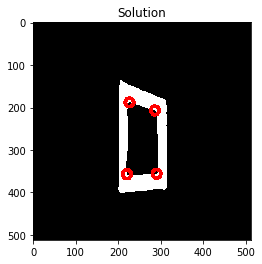

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7596.png
[{'area': 10686, 'centroid': (221, 273), 'corners': array([[255.50934, 255.49513],
       [258.59882, 203.69531],
       [184.08954, 213.81296],
       [183.32997, 337.67157],
       [259.7543 , 338.18414]], dtype=float32)}, {'area': 22885, 'centroid': (221, 276), 'corners': array([[255.50934, 255.49469],
       [278.18124, 174.81876],
       [165.83702, 188.08305],
       [162.8372 , 366.9167 ],
       [278.1812 , 374.1812 ]], dtype=float32)}]


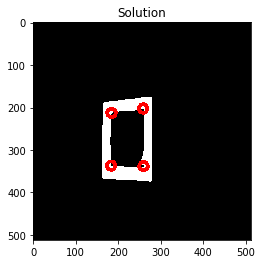

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7151.png
[{'area': 38642, 'centroid': (260, 260), 'corners': array([[255.49826, 255.50043],
       [318.41116, 108.65359],
       [191.5998 , 163.70175],
       [325.317  , 377.55237],
       [188.685  , 382.64145]], dtype=float32)}, {'area': 89424, 'centroid': (265, 259), 'corners': array([[255.4963  , 255.49704 ],
       [350.81757 ,  28.536203],
       [160.04424 , 124.553406],
       [153.75642 , 434.73007 ],
       [372.53052 , 442.77246 ]], dtype=float32)}]


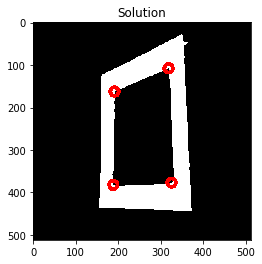

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0256.png
[]
file has only one shape


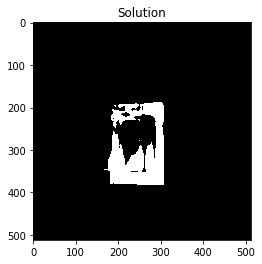

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3791.png
[]
file has only one shape


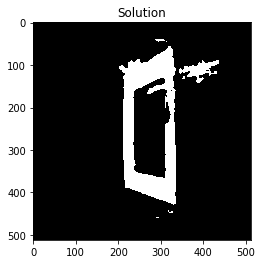

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1668.png
[{'area': 8742, 'centroid': (257, 303), 'corners': array([[255.49889, 255.48705],
       [285.69806, 230.4535 ],
       [229.45125, 241.87462],
       [227.54729, 368.44006],
       [286.20087, 372.79712]], dtype=float32)}, {'area': 20805, 'centroid': (257, 304), 'corners': array([[255.49869, 255.48636],
       [300.70657, 191.44148],
       [208.57239, 220.63153],
       [209.28836, 398.23108],
       [301.8569 , 411.78473]], dtype=float32)}]


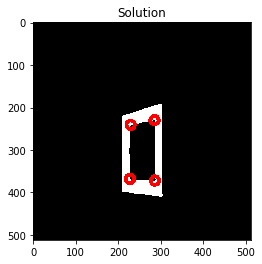

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4365.png
[{'area': 9044, 'centroid': (302, 250), 'corners': array([[255.48695, 255.50124],
       [268.46988, 191.6376 ],
       [341.55185, 201.48859],
       [339.39194, 305.64276],
       [266.34875, 310.28003]], dtype=float32)}, {'area': 19152, 'centroid': (303, 250), 'corners': array([[255.48688, 255.50124],
       [248.57584, 165.57584],
       [359.1812 , 166.81879],
       [358.3919 , 333.64276],
       [248.32845, 337.67007]], dtype=float32)}]


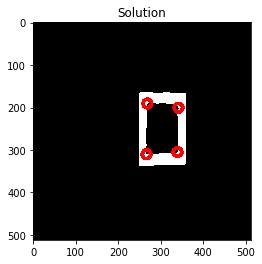

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2830.png
[{'area': 2800, 'centroid': (226, 324), 'corners': array([[255.5082 , 255.47964],
       [241.77272, 284.46967],
       [209.26038, 293.16748],
       [240.18686, 361.91083],
       [213.59068, 361.50385]], dtype=float32)}, {'area': 5900, 'centroid': (225, 325), 'corners': array([[255.50816, 255.48056],
       [250.06958, 265.34283],
       [201.35294, 277.52942],
       [248.83485, 382.43118],
       [200.75772, 382.21646]], dtype=float32)}]


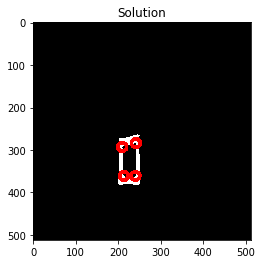

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4627.png
[{'area': 4268, 'centroid': (208, 244), 'corners': array([[255.5128 , 255.50336],
       [226.60222, 195.32916],
       [187.25   , 206.4375 ],
       [229.56808, 289.41208],
       [191.3493 , 290.28094]], dtype=float32)}, {'area': 9504, 'centroid': (208, 245), 'corners': array([[255.51318, 255.50314],
       [237.70671, 172.44154],
       [174.84993, 183.09541],
       [177.03807, 313.4008 ],
       [238.97072, 318.21423]], dtype=float32)}]


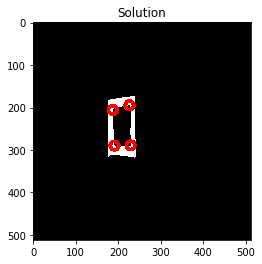

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6905 (1).png
[{'area': 8584, 'centroid': (252, 298), 'corners': array([[255.50111, 255.488  ],
       [228.82971, 221.24051],
       [280.53668, 240.59206],
       [227.32841, 368.67004],
       [276.52658, 366.47845]], dtype=float32)}, {'area': 19178, 'centroid': (254, 300), 'corners': array([[255.50075, 255.48831],
       [215.76857, 180.17358],
       [297.18597, 216.29652],
       [298.1812 , 399.1812 ],
       [213.80748, 406.44394]], dtype=float32)}]


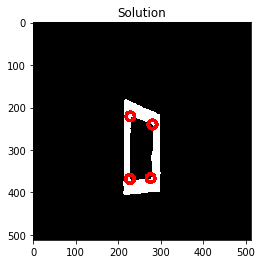

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2812.png
[{'area': 10920, 'centroid': (254, 283), 'corners': array([[255.49988, 255.49222],
       [285.1812 , 202.81877],
       [220.71846, 225.79956],
       [285.53024, 354.2712 ],
       [222.81296, 355.91046]], dtype=float32)}, {'area': 24150, 'centroid': (254, 285), 'corners': array([[255.49973, 255.49254],
       [300.77243, 160.46947],
       [202.55986, 198.54733],
       [303.48987, 392.21115],
       [205.47652, 390.92236]], dtype=float32)}]


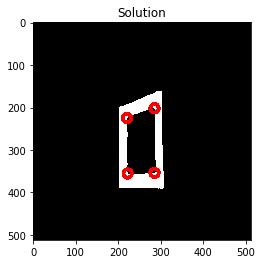

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8954.png
[{'area': 11457, 'centroid': (277, 299), 'corners': array([[255.4941 , 255.48811],
       [251.25876, 211.637  ],
       [311.75   , 231.4375 ],
       [306.6111 , 376.6111 ],
       [248.29321, 384.13123]], dtype=float32)}, {'area': 28196, 'centroid': (277, 300), 'corners': array([[255.49658, 255.49333],
       [228.16583, 165.56853],
       [330.95044, 199.54488],
       [334.0007 , 349.49997],
       [227.55495, 431.80978]], dtype=float32)}]


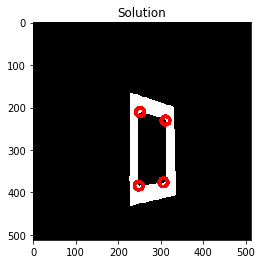

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7160.png
[{'area': 52974, 'centroid': (263, 282), 'corners': array([[255.49663, 255.49196],
       [329.7921 , 102.53394],
       [183.37381, 177.13623],
       [342.68198, 415.78986],
       [184.27396, 426.70306]], dtype=float32)}]
file has only one shape


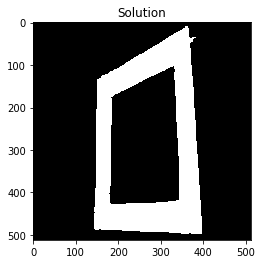

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4923.png
[{'area': 17271, 'centroid': (221, 331), 'corners': array([[254.34724, 251.58107],
       [174.81296, 245.08954],
       [269.12817, 254.52594],
       [270.52658, 410.47845],
       [172.10516, 415.1561 ]], dtype=float32)}, {'area': 38862, 'centroid': (220, 333), 'corners': array([[254.34724, 251.58107],
       [150.83856, 203.58034],
       [297.21646, 223.75772],
       [295.64578, 447.28568],
       [146.29317, 460.13126]], dtype=float32)}]


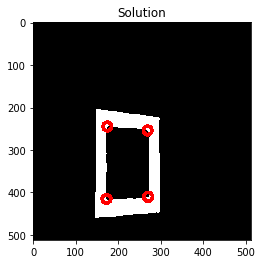

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7412.png
[]
file has only one shape


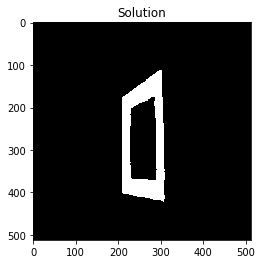

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7594 (1).png
[]
file has only one shape


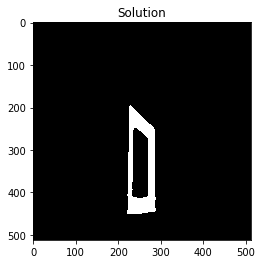

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6524.png
[{'area': 10332, 'centroid': (115, 298), 'corners': array([[255.5382 , 255.48798],
       [ 79.81295, 239.08954],
       [156.68787, 240.62883],
       [ 75.83691, 357.91687],
       [152.69806, 359.54648]], dtype=float32)}, {'area': 21296, 'centroid': (113, 300), 'corners': array([[255.53894 , 255.48792 ],
       [ 58.329838, 212.32854 ],
       [174.13126 , 215.29301 ],
       [ 53.781597, 386.2184  ],
       [170.1628  , 386.9167  ]], dtype=float32)}]


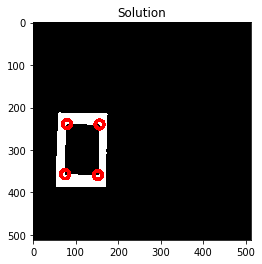

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7445.png
[]
file has only one shape


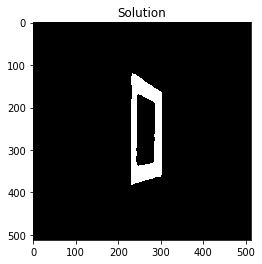

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4008.png
[]
file has only one shape


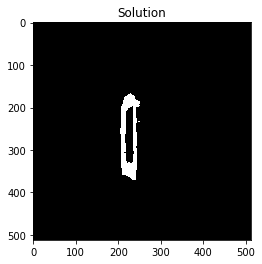

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4482.png
[{'area': 16640, 'centroid': (286, 244), 'corners': array([[255.49162, 255.50275],
       [337.91083, 166.81316],
       [235.12422, 168.85211],
       [334.7076 , 325.55807],
       [236.46986, 323.3624 ]], dtype=float32)}, {'area': 36036, 'centroid': (286, 246), 'corners': array([[255.49155, 255.50247],
       [361.77246, 127.46949],
       [209.08951, 136.81297],
       [212.29239, 359.55804],
       [362.1812 , 362.1812 ]], dtype=float32)}]


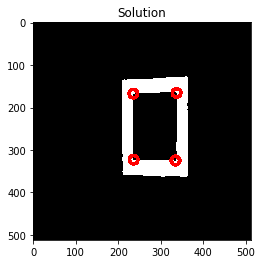

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3090.png
[{'area': 34387, 'centroid': (242, 216), 'corners': array([[255.50453 , 255.51239 ],
       [181.57545 ,  82.68218 ],
       [309.55283 , 120.684044],
       [175.8369  , 330.91687 ],
       [312.67004 , 330.6716  ]], dtype=float32)}, {'area': 79288, 'centroid': (239, 217), 'corners': array([[255.50565 , 255.51324 ],
       [146.60225 ,  13.751576],
       [340.42413 ,  79.57585 ],
       [349.91672 , 380.1633  ],
       [138.08333 , 389.1628  ]], dtype=float32)}]


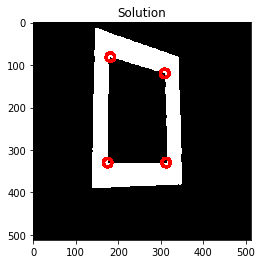

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4048.png
[]
file has only one shape


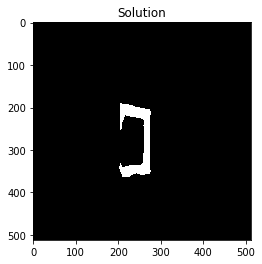

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4733.png
[]
file has only one shape


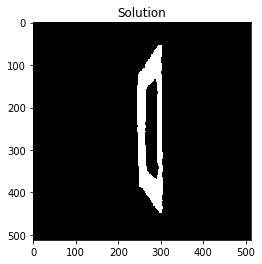

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8631 (1).png
[{'area': 5040, 'centroid': (237, 325), 'corners': array([[255.50461, 255.48068],
       [256.67004, 268.3284 ],
       [216.0897 , 278.813  ],
       [259.6111 , 375.6111 ],
       [217.09099, 378.1935 ]], dtype=float32)}]
file has only one shape


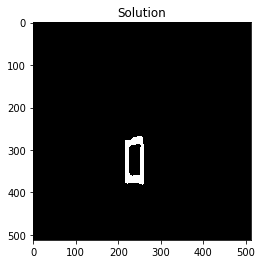

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1503.png
[{'area': 11457, 'centroid': (234, 301), 'corners': array([[255.50653, 255.48729],
       [205.32993, 213.32846],
       [267.15433, 235.67476],
       [258.6111 , 380.6111 ],
       [203.32841, 383.67004]], dtype=float32)}, {'area': 27352, 'centroid': (233, 303), 'corners': array([[255.50674, 255.48688],
       [188.6082 , 163.94202],
       [286.11365, 207.56378],
       [286.1479 , 412.87573],
       [184.47794, 430.4721 ]], dtype=float32)}]


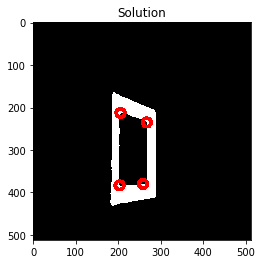

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7057 (1).png
[{'area': 8664, 'centroid': (230, 307), 'corners': array([[254.49995, 254.0006 ],
       [197.83716, 251.08336],
       [266.87366, 256.69   ],
       [192.78888, 359.4898 ],
       [264.16287, 361.91663]], dtype=float32)}, {'area': 18036, 'centroid': (231, 308), 'corners': array([[254.49995, 254.0006 ],
       [180.57578, 223.57578],
       [283.67154, 232.32993],
       [178.35408, 389.2857 ],
       [282.18704, 389.91046]], dtype=float32)}]


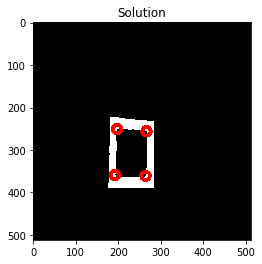

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6962 (1).png
[{'area': 10125, 'centroid': (255, 300), 'corners': array([[255.5007 , 255.48808],
       [221.30193, 230.45349],
       [289.19183, 241.48402],
       [217.27225, 362.07675],
       [290.45273, 362.44006]], dtype=float32)}, {'area': 22200, 'centroid': (254, 301), 'corners': array([[255.50064, 255.48802],
       [203.29362, 196.44138],
       [309.65112, 216.71979],
       [311.1628 , 392.9167 ],
       [200.34886, 397.2802 ]], dtype=float32)}]


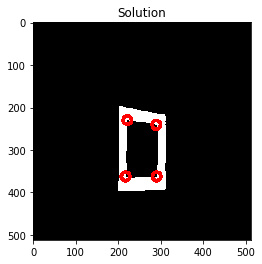

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1809.png
[]
file has only one shape


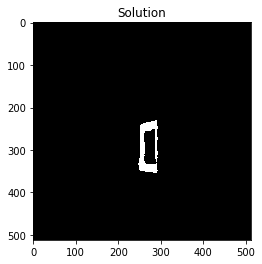

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0084.png
[{'area': 48151, 'centroid': (334, 240), 'corners': array([[255.47769, 255.50513],
       [414.74823, 102.52873],
       [248.76883, 119.28839],
       [424.6716 , 365.67004],
       [249.32732, 369.25848]], dtype=float32)}, {'area': 104272, 'centroid': (339, 241), 'corners': array([[255.47679 , 255.5051  ],
       [455.2028  ,  36.286495],
       [209.08952 ,  66.812965],
       [474.53052 , 427.77246 ],
       [209.32993 , 427.67154 ]], dtype=float32)}]


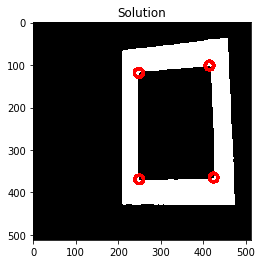

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9449.png
[{'area': 49232, 'centroid': (270, 262), 'corners': array([[255.49567 , 255.49835 ],
       [185.25758 , 127.69462 ],
       [357.4686  , 126.639435],
       [180.57593 , 394.42407 ],
       [359.91083 , 395.1869  ]], dtype=float32)}, {'area': 105592, 'centroid': (272, 264), 'corners': array([[255.4956  , 255.49808 ],
       [147.293   ,  64.868744],
       [399.67154 ,  70.32993 ],
       [136.32845 , 454.67007 ],
       [404.67007 , 458.67154 ]], dtype=float32)}]


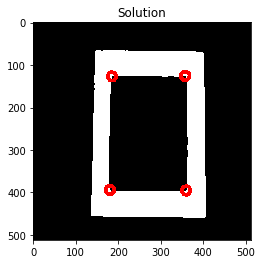

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4204.png
[{'area': 24541, 'centroid': (244, 309), 'corners': array([[255.50441, 255.48425],
       [197.81876, 183.81876],
       [293.5528 , 211.684  ],
       [295.9329 , 404.18103],
       [199.47661, 436.45117]], dtype=float32)}]
file has only one shape


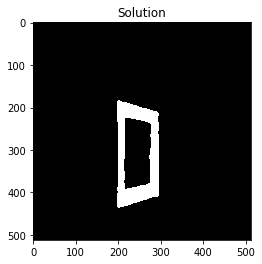

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0345.png
[{'area': 5520, 'centroid': (230, 313), 'corners': array([[255.5068 , 255.48407],
       [204.684  , 268.4472 ],
       [258.14752, 269.1235 ],
       [201.60016, 356.262  ],
       [256.55627, 359.27887]], dtype=float32)}, {'area': 12015, 'centroid': (230, 314), 'corners': array([[255.50694, 255.48386],
       [275.43124, 248.16524],
       [188.85242, 248.12389],
       [185.04953, 378.45508],
       [274.1812 , 382.1812 ]], dtype=float32)}]


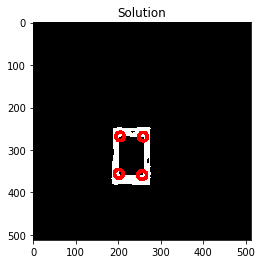

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7154.png
[{'area': 14691, 'centroid': (249, 250), 'corners': array([[255.50078, 255.50244],
       [288.67004, 158.32841],
       [210.83983, 179.26068],
       [289.90463, 330.1512 ],
       [208.08917, 330.18686]], dtype=float32)}, {'area': 33798, 'centroid': (251, 249), 'corners': array([[255.50064, 255.50296],
       [309.67007, 109.32846],
       [188.42036, 151.77913],
       [184.22739, 368.5304 ],
       [313.1812 , 371.1812 ]], dtype=float32)}]


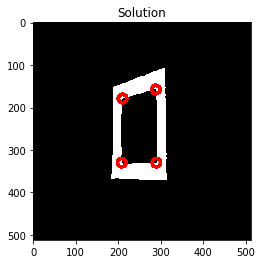

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5345.png
[]
file has only one shape


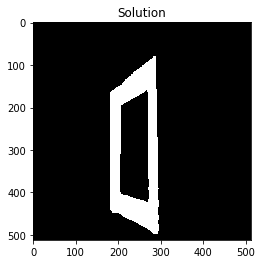

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8458 (1).png
[{'area': 12056, 'centroid': (212, 307), 'corners': array([[255.51181, 255.48564],
       [253.91687, 240.8369 ],
       [169.04962, 245.54472],
       [255.42746, 370.3686 ],
       [170.32997, 374.67157]], dtype=float32)}, {'area': 26069, 'centroid': (211, 310), 'corners': array([[255.51195, 255.48509],
       [275.13126, 211.29317],
       [148.96545, 217.43768],
       [277.24228, 405.21643],
       [147.3378 , 408.24777]], dtype=float32)}]


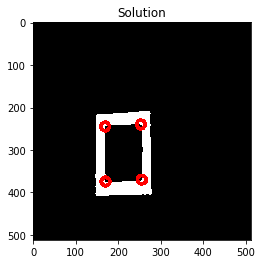

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3531.png
[{'area': 2440, 'centroid': (191, 245), 'corners': array([[255.51738, 255.50275],
       [173.28839, 215.76883],
       [210.67159, 216.32997],
       [173.57593, 274.42407],
       [211.28003, 273.65125]], dtype=float32)}, {'area': 5520, 'centroid': (191, 245), 'corners': array([[255.51744, 255.50302],
       [162.8188 , 198.81879],
       [222.5465 , 200.30194],
       [163.81322, 289.9108 ],
       [220.14787, 289.87573]], dtype=float32)}]


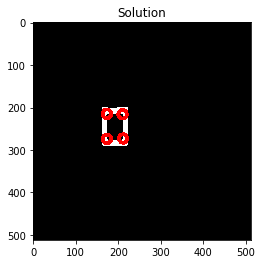

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5441.png
[]
file has only one shape


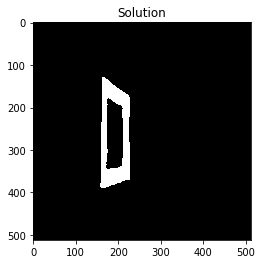

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1729.png
[]
file has only one shape


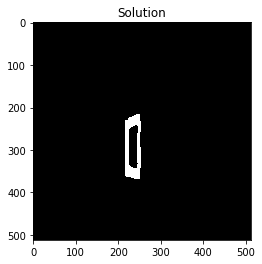

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8284 (1).png
[{'area': 38448, 'centroid': (235, 240), 'corners': array([[255.50656, 255.50597],
       [173.80092,  95.7779 ],
       [305.91925, 141.84   ],
       [164.57593, 357.42407],
       [307.73935, 360.16013]], dtype=float32)}, {'area': 86853, 'centroid': (231, 242), 'corners': array([[255.50749 , 255.5057  ],
       [138.76201 ,  25.305647],
       [336.67868 , 103.20704 ],
       [345.2184  , 412.2184  ],
       [123.75773 , 420.21643 ]], dtype=float32)}]


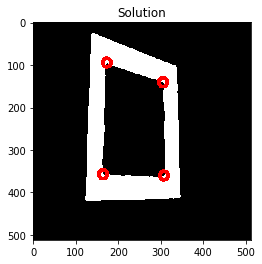

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2271.png
[{'area': 11180, 'centroid': (222, 318), 'corners': array([[255.5092 , 255.48283],
       [182.83714, 254.08336],
       [263.42407, 258.57593],
       [179.26065, 377.83337],
       [262.67004, 380.6716 ]], dtype=float32)}, {'area': 23750, 'centroid': (222, 320), 'corners': array([[255.50887, 255.48248],
       [163.32983, 223.32854],
       [284.1812 , 229.81879],
       [159.81879, 412.1812 ],
       [286.21643, 411.24228]], dtype=float32)}]


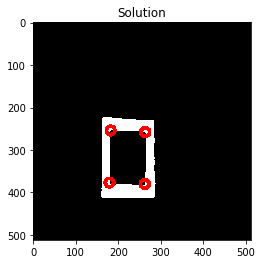

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1388.png
[{'area': 17028, 'centroid': (277, 281), 'corners': array([[255.49342, 255.49336],
       [313.53796, 179.36948],
       [233.90546, 206.28427],
       [238.36572, 370.1304 ],
       [316.7068 , 378.13123]], dtype=float32)}, {'area': 39431, 'centroid': (278, 283), 'corners': array([[255.492  , 255.49239],
       [336.72366, 126.8138 ],
       [211.32843, 171.32996],
       [211.12349, 404.14755],
       [339.28268, 430.68018]], dtype=float32)}]


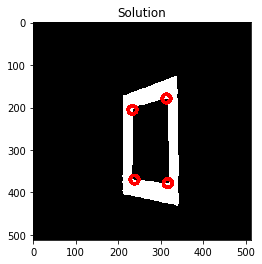

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0252.png
[]
file has only one shape


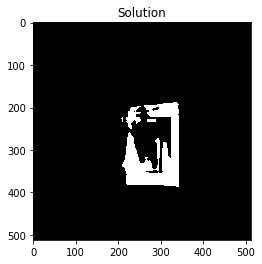

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1849.png
[{'area': 7200, 'centroid': (232, 273), 'corners': array([[255.50594, 255.49556],
       [253.81728, 197.54784],
       [209.66467, 213.73009],
       [255.16295, 340.91696],
       [210.6965 , 338.37222]], dtype=float32)}, {'area': 16770, 'centroid': (231, 273), 'corners': array([[255.506  , 255.49539],
       [269.18124, 159.81877],
       [192.91342, 193.60783],
       [192.26947, 368.2519 ],
       [268.20264, 377.4174 ]], dtype=float32)}]


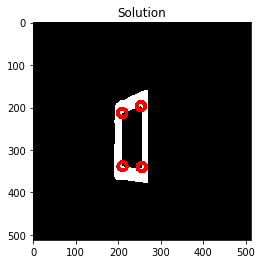

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8934.png
[{'area': 7598, 'centroid': (253, 312), 'corners': array([[255.50093, 255.48439],
       [228.68999, 246.12633],
       [280.4622 , 255.53838],
       [226.32841, 376.67004],
       [279.21835, 372.21835]], dtype=float32)}, {'area': 17512, 'centroid': (253, 314), 'corners': array([[255.50137, 255.48355],
       [211.32991, 213.32848],
       [298.6448 , 235.43562],
       [297.18704, 399.9105 ],
       [211.4829 , 412.4499 ]], dtype=float32)}]


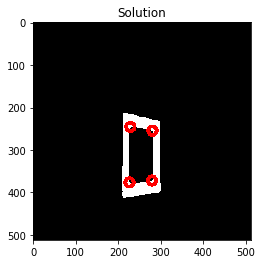

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0717.png
[]
file has only one shape


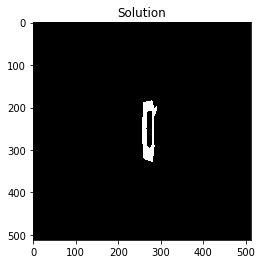

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3927.png
[{'area': 16059, 'centroid': (205, 264), 'corners': array([[255.5136 , 255.49773],
       [160.60834, 183.60376],
       [253.31024, 190.12674],
       [253.71161, 338.23117],
       [156.81313, 342.91083]], dtype=float32)}, {'area': 34748, 'centroid': (205, 263), 'corners': array([[255.51405, 255.49796],
       [133.8188 , 143.8188 ],
       [278.1391 , 158.07849],
       [278.51694, 374.45007],
       [134.18137, 383.4631 ]], dtype=float32)}]


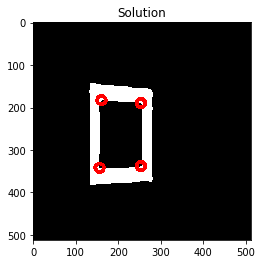

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4042.png
[{'area': 21375, 'centroid': (223, 271), 'corners': array([[255.50964, 255.49614],
       [182.57591, 155.57591],
       [271.6703 , 184.57684],
       [265.62207, 367.4862 ],
       [180.3285 , 379.67014]], dtype=float32)}, {'area': 50976, 'centroid': (223, 272), 'corners': array([[255.51022, 255.49535],
       [160.88635,  87.3175 ],
       [296.9103 , 147.813  ],
       [300.25592, 403.21512],
       [157.55096, 441.8186 ]], dtype=float32)}]


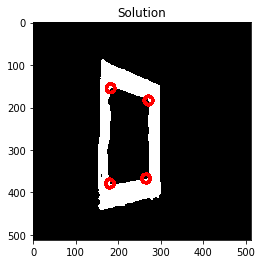

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6401.png
[{'area': 7350, 'centroid': (267, 305), 'corners': array([[259.50003, 253.99956],
       [234.32997, 254.32841],
       [301.36313, 257.512  ],
       [236.83122, 358.67218],
       [298.14786, 355.87567]], dtype=float32)}, {'area': 15352, 'centroid': (267, 307), 'corners': array([[259.50003, 253.99956],
       [219.32994, 231.32845],
       [317.1812 , 232.81879],
       [317.67007, 380.67154],
       [216.81885, 383.18115]], dtype=float32)}]


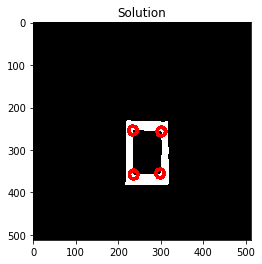

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2694.png
[{'area': 10292, 'centroid': (236, 327), 'corners': array([[255.50508, 255.48022],
       [196.83713, 266.08337],
       [276.6716 , 267.32996],
       [196.57593, 388.42407],
       [276.90396, 387.15112]], dtype=float32)}, {'area': 22204, 'centroid': (236, 329), 'corners': array([[255.50522, 255.47974],
       [177.09108, 238.80644],
       [295.1812 , 238.81879],
       [298.18704, 417.9105 ],
       [175.81879, 421.1812 ]], dtype=float32)}]


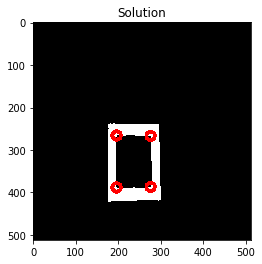

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2486.png
[]
file has only one shape


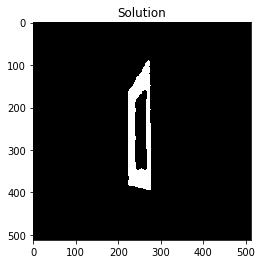

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2712.png
[{'area': 22936, 'centroid': (251, 299), 'corners': array([[255.50124, 255.48778],
       [310.73074, 206.74834],
       [191.57593, 210.57593],
       [310.64148, 391.31494],
       [189.32997, 391.67157]], dtype=float32)}, {'area': 51150, 'centroid': (252, 303), 'corners': array([[255.50096, 255.48737],
       [338.66998, 163.32837],
       [164.75772, 169.78357],
       [345.24228, 436.21643],
       [160.71744, 437.68018]], dtype=float32)}]


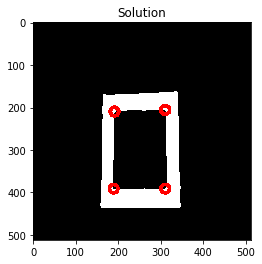

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2414.png
[{'area': 8400, 'centroid': (241, 297), 'corners': array([[255.5036 , 255.48868],
       [264.2026 , 219.58282],
       [214.60901, 239.51971],
       [267.16293, 366.91696],
       [215.57591, 366.42407]], dtype=float32)}, {'area': 19295, 'centroid': (240, 298), 'corners': array([[255.50378, 255.48863],
       [278.46732, 176.58034],
       [197.57254, 215.63141],
       [198.96387, 400.59308],
       [282.28717, 403.34036]], dtype=float32)}]


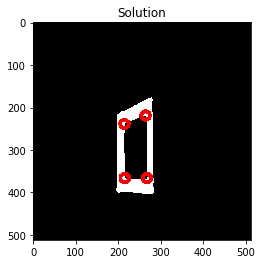

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9817.png
[{'area': 12376, 'centroid': (336, 255), 'corners': array([[255.47768, 255.50014],
       [378.43994, 187.54732],
       [292.5473 , 192.56004],
       [380.4622 , 319.46158],
       [293.1235 , 320.14752]], dtype=float32)}, {'area': 26136, 'centroid': (338, 255), 'corners': array([[255.4774 , 255.49986],
       [400.1812 , 154.81879],
       [272.5473 , 165.55983],
       [404.1812 , 352.1812 ],
       [273.32983, 351.67145]], dtype=float32)}]


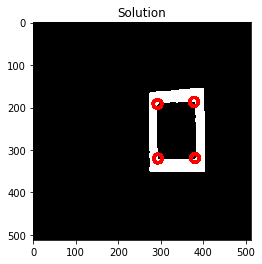

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8266.png
[]
file has only one shape


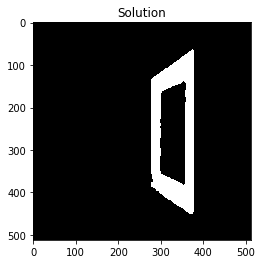

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4249.png
[{'area': 13320, 'centroid': (237, 237), 'corners': array([[255.50516, 255.50473],
       [215.65262, 148.4189 ],
       [276.75   , 168.4375 ],
       [274.15433, 312.32523],
       [204.34294, 329.65454]], dtype=float32)}, {'area': 31578, 'centroid': (237, 239), 'corners': array([[255.50655 , 255.5042  ],
       [183.55284 , 101.269226],
       [297.0007  , 142.49995 ],
       [297.38107 , 342.24814 ],
       [183.87848 , 378.80716 ]], dtype=float32)}]


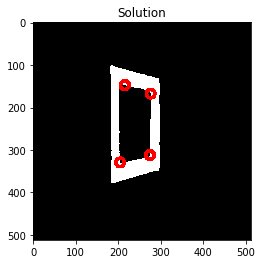

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6874.png
[{'area': 43040, 'centroid': (272, 263), 'corners': array([[255.49428, 255.49977],
       [337.48407, 120.55691],
       [194.81416, 163.4329 ],
       [353.41602, 374.3089 ],
       [194.08357, 387.16348]], dtype=float32)}, {'area': 93688, 'centroid': (276, 265), 'corners': array([[255.49303, 255.49995],
       [373.41956,  53.83858],
       [161.78886, 123.51018],
       [395.67145, 436.67017],
       [156.75548, 443.2449 ]], dtype=float32)}]


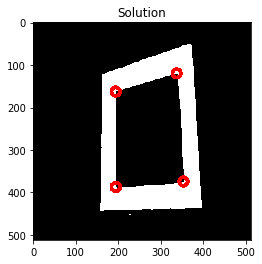

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3585.png
[{'area': 4160, 'centroid': (233, 275), 'corners': array([[255.50604, 255.49443],
       [208.12674, 237.68976],
       [258.15112, 238.09605],
       [209.35852, 314.31494],
       [258.18124, 314.18124]], dtype=float32)}, {'area': 8740, 'centroid': (233, 276), 'corners': array([[255.50612, 255.49423],
       [194.8188 , 218.81879],
       [270.67154, 219.32993],
       [196.3787 , 334.30682],
       [270.7921 , 333.0335 ]], dtype=float32)}]


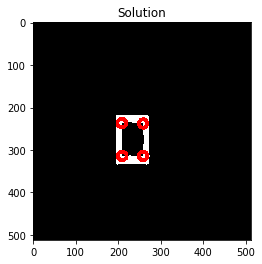

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5503.png
[{'area': 18509, 'centroid': (199, 257), 'corners': array([[255.51665, 255.49919],
       [165.36438, 141.37741],
       [240.66426, 177.57399],
       [230.61111, 354.6111 ],
       [160.55847, 363.44183]], dtype=float32)}]
file has only one shape


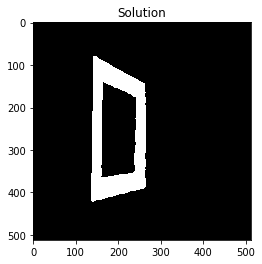

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1447.png
[]
file has only one shape


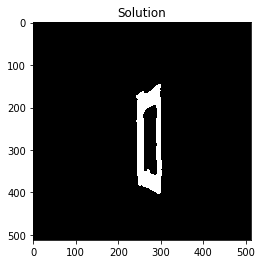

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2749.png
[{'area': 49306, 'centroid': (264, 259), 'corners': array([[255.49655 , 255.50029 ],
       [340.54926 , 114.911545],
       [183.2738  , 142.23772 ],
       [353.7308  , 384.25214 ],
       [179.25879 , 391.363   ]], dtype=float32)}, {'area': 106265, 'centroid': (268, 263), 'corners': array([[255.49548, 255.50064],
       [381.67004,  49.32841],
       [143.75778,  90.7835 ],
       [400.9167 , 448.1628 ],
       [136.57584, 449.42416]], dtype=float32)}]


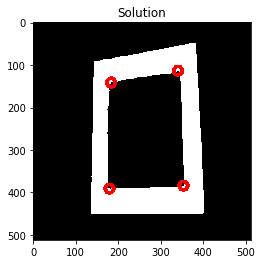

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7351 (1).png
[{'area': 9966, 'centroid': (233, 292), 'corners': array([[255.50554, 255.49031],
       [263.77258, 213.46959],
       [201.60901, 232.51971],
       [265.18124, 362.18124],
       [202.81296, 361.91046]], dtype=float32)}, {'area': 22176, 'centroid': (233, 293), 'corners': array([[255.50557, 255.49036],
       [279.44473, 174.19005],
       [183.09647, 207.82881],
       [185.22906, 393.80502],
       [280.5171 , 399.4499 ]], dtype=float32)}]


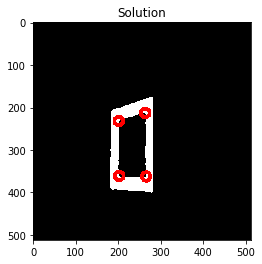

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8778 (1).png
[{'area': 42486, 'centroid': (298, 259), 'corners': array([[255.48833, 255.49973],
       [233.32996, 110.32843],
       [373.89285, 143.42545],
       [367.316  , 383.5528 ],
       [230.52151, 400.52655]], dtype=float32)}, {'area': 96565, 'centroid': (295, 259), 'corners': array([[255.49124 , 255.4996  ],
       [195.22754 ,  30.469482],
       [406.5     ,  94.72727 ],
       [408.73932 , 429.8334  ],
       [189.5688  , 475.83484 ]], dtype=float32)}]


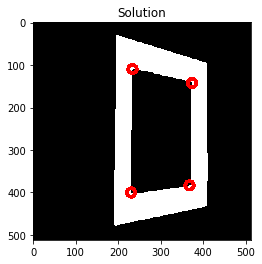

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9000.png
[]
file has only one shape


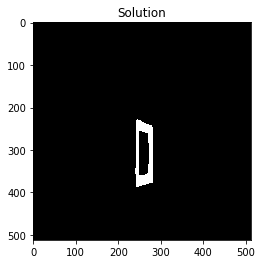

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8707 (1).png
[]
file has only one shape


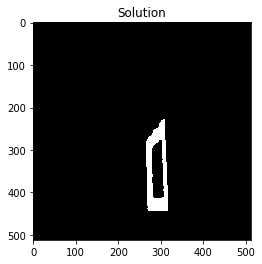

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9746.png
[{'area': 11264, 'centroid': (254, 274), 'corners': array([[255.50029, 255.49477],
       [287.56628, 210.35567],
       [213.77643, 217.27074],
       [297.6716 , 329.67004],
       [217.2884 , 337.23123]], dtype=float32)}, {'area': 23562, 'centroid': (255, 274), 'corners': array([[255.50008, 255.4947 ],
       [309.24234, 180.78363],
       [194.32845, 192.32994],
       [319.1812 , 356.1812 ],
       [198.8188 , 367.1812 ]], dtype=float32)}]


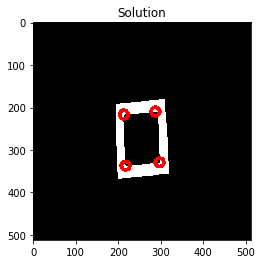

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2499.png
[]
file has only one shape


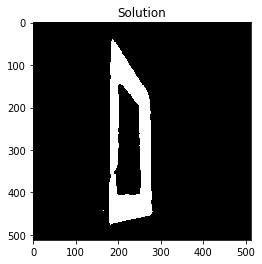

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7480 (1).png
[]
file has only one shape


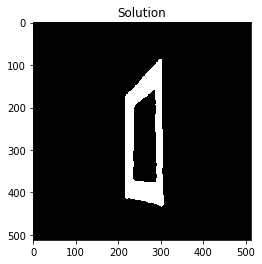

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3322.png
[]
file has only one shape


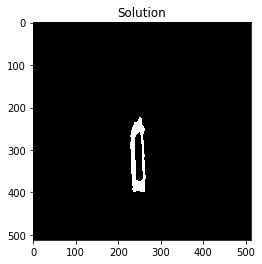

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8461 (1).png
[{'area': 10624, 'centroid': (192, 308), 'corners': array([[252.00087, 257.50006],
       [233.27963, 245.39488],
       [152.57593, 248.57593],
       [232.80353, 370.29507],
       [150.3171 , 370.11414]], dtype=float32)}, {'area': 22506, 'centroid': (191, 311), 'corners': array([[252.00087, 257.50006],
       [252.1812 , 218.81879],
       [135.226  , 220.46729],
       [253.18121, 401.1812 ],
       [132.54684, 404.52103]], dtype=float32)}]


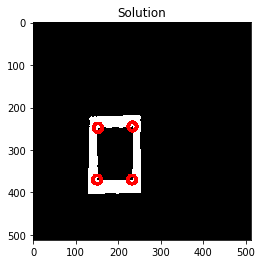

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1854.png
[{'area': 3700, 'centroid': (239, 285), 'corners': array([[255.99908, 252.49994],
       [253.41797, 234.41377],
       [222.12631, 241.69   ],
       [254.65117, 332.28015],
       [223.46992, 331.36258]], dtype=float32)}]
file has only one shape


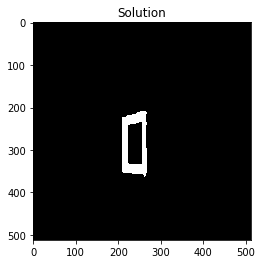

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8069.png
[{'area': 34336, 'centroid': (272, 229), 'corners': array([[255.4956  , 255.50687 ],
       [346.45273 , 114.559944],
       [199.81311 , 121.08918 ],
       [197.1235  , 340.14752 ],
       [343.16348 , 344.9164  ]], dtype=float32)}, {'area': 71781, 'centroid': (274, 230), 'corners': array([[255.49506, 255.507  ],
       [381.5581 ,  63.29251],
       [167.69485,  70.3289 ],
       [168.08305, 388.16296],
       [378.9093 , 399.1928 ]], dtype=float32)}]


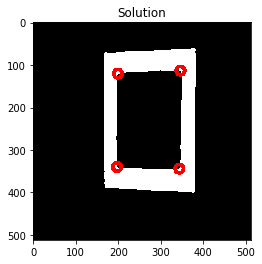

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2191.png
[{'area': 15015, 'centroid': (227, 313), 'corners': array([[255.5078 , 255.48363],
       [193.08917, 211.81314],
       [264.92395, 243.83084],
       [191.32841, 403.67004],
       [263.31   , 401.87366]], dtype=float32)}, {'area': 35400, 'centroid': (227, 315), 'corners': array([[255.50812, 255.48325],
       [176.07939, 151.4504 ],
       [286.33533, 212.72997],
       [288.71164, 440.23108],
       [169.32845, 452.67007]], dtype=float32)}]


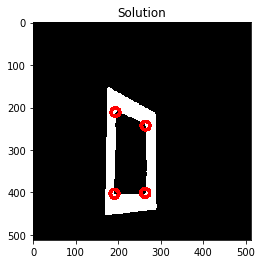

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8691.png
[{'area': 45552, 'centroid': (226, 254), 'corners': array([[255.50949, 255.50133],
       [162.55997,  94.54727],
       [300.3153 , 135.35863],
       [291.6111 , 383.6111 ],
       [156.47368, 403.73685]], dtype=float32)}, {'area': 109668, 'centroid': (219, 254), 'corners': array([[255.51245  , 255.50604  ],
       [122.293655 ,   2.4413376],
       [334.1256   ,  90.45087  ],
       [337.0007   , 384.50003  ],
       [115.39775  , 496.67087  ]], dtype=float32)}]


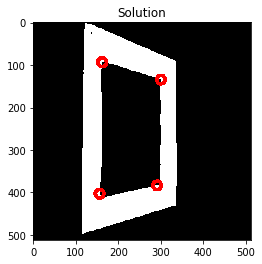

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3236.png
[]
file has only one shape


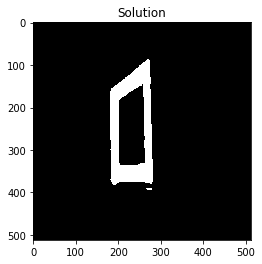

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6952.png
[]
file has only one shape


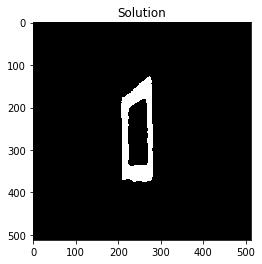

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7002 (1).png
[{'area': 23432, 'centroid': (239, 280), 'corners': array([[255.50505, 255.49403],
       [185.88629, 174.31744],
       [295.16   , 194.08073],
       [183.08336, 376.16284],
       [298.72925, 372.22357]], dtype=float32)}, {'area': 52800, 'centroid': (237, 281), 'corners': array([[255.50542, 255.49413],
       [156.81876, 124.81876],
       [323.67157, 159.32997],
       [329.44394, 413.1925 ],
       [155.38297, 426.65073]], dtype=float32)}]


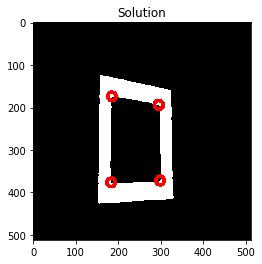

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6483.png
[{'area': 47425, 'centroid': (264, 252), 'corners': array([[255.49759, 255.5011 ],
       [347.03424, 113.32498],
       [180.57584, 127.57583],
       [178.85844, 383.45267],
       [351.42416, 382.42416]], dtype=float32)}, {'area': 102440, 'centroid': (268, 254), 'corners': array([[255.49655 , 255.50148 ],
       [389.56805 ,  51.587967],
       [142.08333 ,  75.83719 ],
       [135.61899 , 438.43555 ],
       [394.83377 , 446.7392  ]], dtype=float32)}]


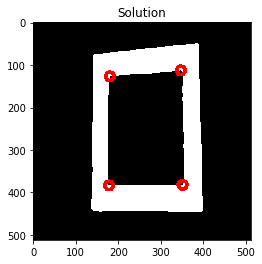

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4227.png
[{'area': 8892, 'centroid': (233, 232), 'corners': array([[255.50629, 255.50674],
       [218.49625, 157.49933],
       [263.12558, 168.45084],
       [263.75   , 291.5625 ],
       [208.31825, 310.7943 ]], dtype=float32)}, {'area': 20700, 'centroid': (234, 234), 'corners': array([[255.50732, 255.50597],
       [191.16583, 119.56853],
       [279.44003, 141.54729],
       [280.578  , 326.686  ],
       [191.16586, 349.4315 ]], dtype=float32)}]


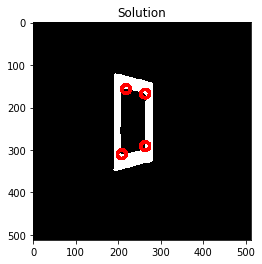

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7107 (1).png
[{'area': 10584, 'centroid': (265, 302), 'corners': array([[255.49712, 255.48729],
       [227.78166, 240.78166],
       [306.18124, 240.81877],
       [225.08954, 363.18704],
       [302.78998, 363.68185]], dtype=float32)}, {'area': 22080, 'centroid': (265, 304), 'corners': array([[255.49712, 255.48668],
       [207.32994, 211.32845],
       [325.43124, 217.1655 ],
       [325.67007, 392.67154],
       [206.79738, 395.4172 ]], dtype=float32)}]


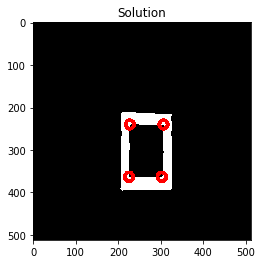

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7094 (1).png
[{'area': 23684, 'centroid': (243, 282), 'corners': array([[255.50362, 255.493  ],
       [185.55008, 185.49007],
       [302.53683, 195.59224],
       [180.30502, 367.8439 ],
       [302.42407, 374.42407]], dtype=float32)}, {'area': 50778, 'centroid': (242, 285), 'corners': array([[255.50323, 255.49203],
       [158.85213, 143.12425],
       [330.18118, 156.81882],
       [333.91696, 416.16296],
       [152.17937, 422.3646 ]], dtype=float32)}]


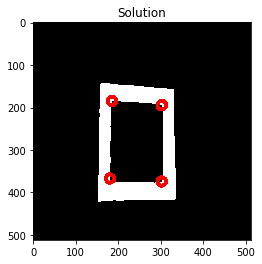

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4150.png
[]
file has only one shape


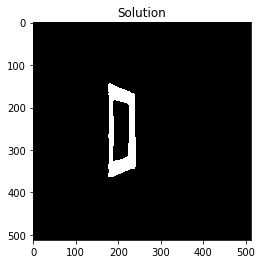

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4584.png
[{'area': 17069, 'centroid': (237, 248), 'corners': array([[255.50505, 255.50215],
       [284.33997, 164.4382 ],
       [187.60892, 172.51959],
       [188.08919, 327.1869 ],
       [286.18124, 332.18124]], dtype=float32)}, {'area': 37044, 'centroid': (237, 249), 'corners': array([[255.5049 , 255.50203],
       [308.18124, 121.81876],
       [163.1262 , 139.69006],
       [169.18184, 364.59503],
       [306.83377, 375.7392 ]], dtype=float32)}]


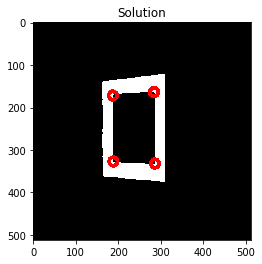

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2658.png
[{'area': 7920, 'centroid': (222, 313), 'corners': array([[255.50906, 255.48407],
       [188.81294, 259.08957],
       [256.6716 , 261.32996],
       [187.81877, 367.18124],
       [256.18704, 365.91046]], dtype=float32)}, {'area': 16640, 'centroid': (223, 315), 'corners': array([[255.50879, 255.48366],
       [170.5689 , 236.16493],
       [274.1812 , 237.81879],
       [276.67007, 391.67154],
       [171.81879, 395.1812 ]], dtype=float32)}]


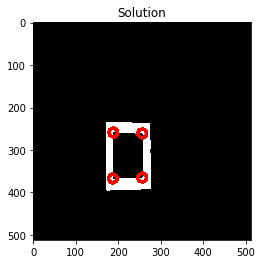

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1566.png
[{'area': 15800, 'centroid': (258, 302), 'corners': array([[255.49918, 255.48715],
       [212.31363, 222.74597],
       [306.4527 , 229.56004],
       [208.80653, 378.9091 ],
       [306.6507 , 378.28094]], dtype=float32)}, {'area': 34692, 'centroid': (258, 303), 'corners': array([[255.49922, 255.48717],
       [187.8188 , 182.8188 ],
       [331.67154, 196.32993],
       [329.6111 , 413.6111 ],
       [187.83682, 420.71112]], dtype=float32)}]


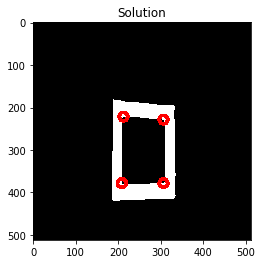

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1230.png
[{'area': 9821, 'centroid': (256, 282), 'corners': array([[255.50034, 255.49281],
       [229.1914 , 200.38034],
       [284.76572, 216.55576],
       [285.57462, 352.6897 ],
       [228.22577, 361.52936]], dtype=float32)}, {'area': 23218, 'centroid': (256, 283), 'corners': array([[255.50008, 255.49118],
       [212.28256, 156.7046 ],
       [305.0007 , 200.49995],
       [305.87363, 383.31006],
       [218.5238 , 402.7143 ]], dtype=float32)}]


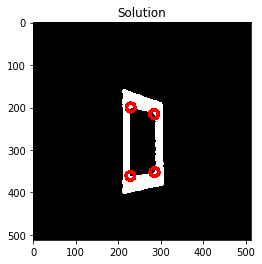

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3771.png
[{'area': 19224, 'centroid': (267, 312), 'corners': array([[255.49683, 255.4842 ],
       [310.3391 , 220.62822],
       [214.08954, 234.81296],
       [318.64148, 398.31494],
       [216.83698, 397.91666]], dtype=float32)}, {'area': 42400, 'centroid': (267, 314), 'corners': array([[255.49602, 255.4845 ],
       [338.16302, 177.08336],
       [188.12428, 203.85213],
       [189.8748 , 434.5488 ],
       [344.48978, 444.21112]], dtype=float32)}]


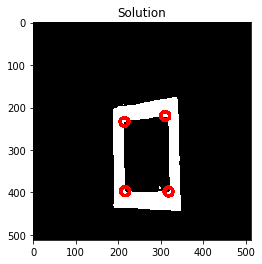

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5854.png
[{'area': 7866, 'centroid': (269, 264), 'corners': array([[255.49599, 255.49765],
       [302.18124, 207.81877],
       [236.44719, 213.68402],
       [302.34076, 319.9174 ],
       [236.20792, 319.03357]], dtype=float32)}, {'area': 16393, 'centroid': (268, 265), 'corners': array([[255.49628, 255.49748],
       [315.6525 , 179.34732],
       [218.86874, 191.29301],
       [221.32993, 345.67154],
       [316.16284, 347.91708]], dtype=float32)}]


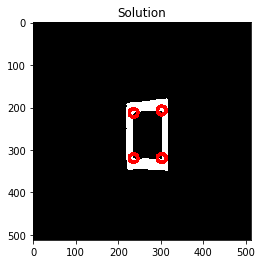

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7355.png
[{'area': 7656, 'centroid': (265, 262), 'corners': array([[255.4969 , 255.49854],
       [294.36667, 205.55675],
       [234.08972, 212.81302],
       [296.21832, 317.21835],
       [235.32997, 317.67157]], dtype=float32)}, {'area': 16587, 'centroid': (265, 263), 'corners': array([[255.49672, 255.49849],
       [309.2376 , 173.3055 ],
       [216.43196, 192.58798],
       [311.83505, 345.43112],
       [219.88611, 344.68283]], dtype=float32)}]


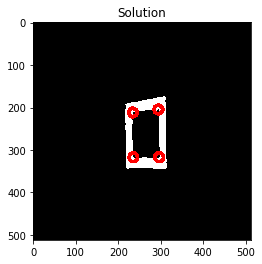

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1528.png
[{'area': 6930, 'centroid': (263, 310), 'corners': array([[255.49786, 255.4849 ],
       [235.32994, 256.32843],
       [294.18124, 260.81876],
       [234.34885, 362.28018],
       [290.36517, 363.25983]], dtype=float32)}, {'area': 15066, 'centroid': (264, 312), 'corners': array([[255.49744, 255.48459],
       [221.32997, 229.32841],
       [311.1812 , 239.81879],
       [309.30994, 387.87378],
       [218.81879, 391.1812 ]], dtype=float32)}]


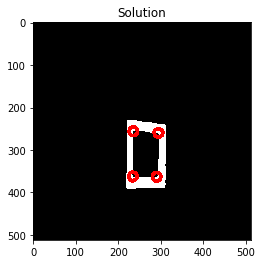

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7176.png
[{'area': 6096, 'centroid': (273, 239), 'corners': array([[255.49438, 255.50517],
       [293.8598 , 173.22096],
       [250.68468, 188.35863],
       [294.332  , 297.73843],
       [252.5451 , 297.9506 ]], dtype=float32)}, {'area': 13286, 'centroid': (273, 238), 'corners': array([[255.49483, 255.50516],
       [307.8176 , 141.53621],
       [236.43817, 167.66032],
       [235.3976 , 323.67078],
       [307.2658 , 324.56726]], dtype=float32)}]


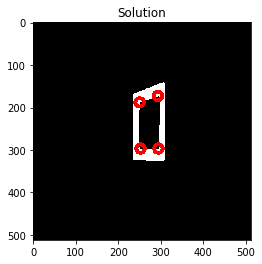

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8504 (1).png
[{'area': 8906, 'centroid': (251, 293), 'corners': array([[255.50056, 255.48972],
       [285.8159 , 231.66751],
       [216.18909, 243.2715 ],
       [286.2289 , 350.686  ],
       [217.08357, 351.16348]], dtype=float32)}, {'area': 18939, 'centroid': (251, 295), 'corners': array([[255.50087, 255.48935],
       [302.6708 , 204.3977 ],
       [197.81415, 220.43292],
       [305.1812 , 377.1812 ],
       [201.15999, 380.4048 ]], dtype=float32)}]


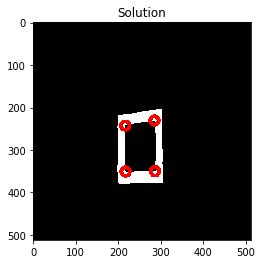

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9796.png
[{'area': 32045, 'centroid': (332, 234), 'corners': array([[255.47865 , 255.50671 ],
       [398.54535 , 119.651886],
       [261.04962 , 135.54472 ],
       [260.57593 , 338.42407 ],
       [403.16013 , 340.73935 ]], dtype=float32)}, {'area': 69324, 'centroid': (335, 234), 'corners': array([[255.47775 , 255.50656 ],
       [435.18118 ,  66.8188  ],
       [230.8188  ,  89.818794],
       [229.83882 , 386.65707 ],
       [440.37927 , 394.6544  ]], dtype=float32)}]


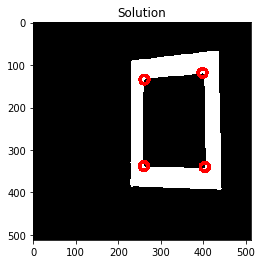

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0070.png
[{'area': 7280, 'centroid': (307, 285), 'corners': array([[255.48558, 255.4919 ],
       [275.81296, 234.08954],
       [340.21832, 234.78166],
       [274.78168, 336.21832],
       [341.91083, 334.1869 ]], dtype=float32)}, {'area': 15708, 'centroid': (309, 286), 'corners': array([[255.48517, 255.49155],
       [356.707  , 208.86874],
       [258.8188 , 211.81879],
       [358.7075 , 361.5581 ],
       [261.1655 , 363.43124]], dtype=float32)}]


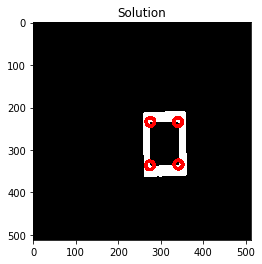

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8236.png
[]
file has only one shape


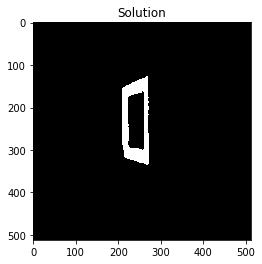

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7700.png
[{'area': 5610, 'centroid': (247, 292), 'corners': array([[255.50154, 255.48994],
       [270.60223, 236.32916],
       [223.49615, 246.59068],
       [270.6716 , 343.67004],
       [227.5085 , 344.17917]], dtype=float32)}, {'area': 11766, 'centroid': (247, 293), 'corners': array([[255.50156, 255.48988],
       [283.18124, 211.81876],
       [211.00647, 228.56612],
       [209.4419 , 362.39377],
       [284.1812 , 371.1812 ]], dtype=float32)}]


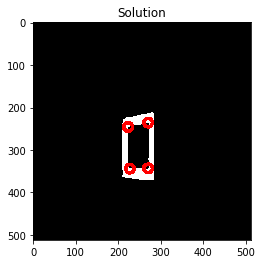

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7786 (1).png
[{'area': 6968, 'centroid': (248, 333), 'corners': array([[255.50204, 255.47841],
       [218.81296, 282.08954],
       [280.25854, 287.3273 ],
       [216.30196, 383.54648],
       [279.28003, 382.65125]], dtype=float32)}, {'area': 14994, 'centroid': (249, 335), 'corners': array([[255.50172, 255.47823],
       [204.1655 , 256.56876],
       [297.18115, 264.81885],
       [199.81879, 408.1812 ],
       [296.67007, 408.67154]], dtype=float32)}]


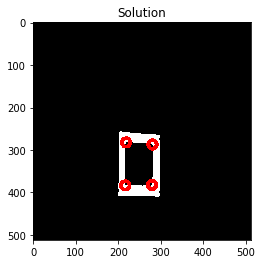

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8069 (1).png
[{'area': 3959, 'centroid': (263, 331), 'corners': array([[259.742  , 259.85455],
       [280.2036 , 277.28632],
       [245.81831, 289.556  ],
       [279.6716 , 380.67004],
       [246.7816 , 381.2184 ]], dtype=float32)}, {'area': 9540, 'centroid': (261, 333), 'corners': array([[259.74197, 259.85455],
       [291.4312 , 252.16519],
       [232.74142, 270.32727],
       [232.3378 , 407.24777],
       [290.26617, 410.90488]], dtype=float32)}]


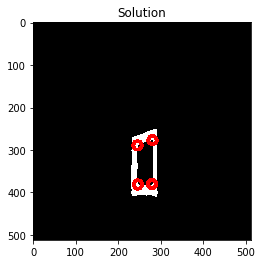

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3112.png
[{'area': 36995, 'centroid': (214, 230), 'corners': array([[255.5122 , 255.5085 ],
       [145.09616, 101.84864],
       [287.3626 , 128.46979],
       [141.12663, 343.31018],
       [291.46158, 343.4622 ]], dtype=float32)}, {'area': 83309, 'centroid': (212, 232), 'corners': array([[255.51349 , 255.509   ],
       [112.88619 ,  35.317135],
       [320.2184  ,  86.78159 ],
       [329.9108  , 393.18677 ],
       [101.818794, 403.1812  ]], dtype=float32)}]


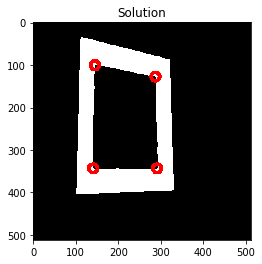

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7213 (1).png
[{'area': 47700, 'centroid': (245, 254), 'corners': array([[255.50275, 255.50069],
       [329.74832, 120.5288 ],
       [163.5658 , 124.83136],
       [335.69067, 380.46628],
       [155.83818, 383.65744]], dtype=float32)}, {'area': 99963, 'centroid': (246, 256), 'corners': array([[255.50241 , 255.50027 ],
       [368.18704 ,  61.089508],
       [124.328445,  70.32993 ],
       [118.006134, 442.62076 ],
       [377.9167  , 444.1628  ]], dtype=float32)}]


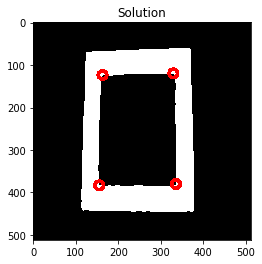

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1163.png
[{'area': 273, 'centroid': (195, 369), 'corners': array([[255.51715, 255.46773],
       [193.23224, 357.53195],
       [202.27875, 366.4438 ],
       [188.26036, 378.4028 ],
       [193.98116, 380.3584 ]], dtype=float32)}]
file has only one shape


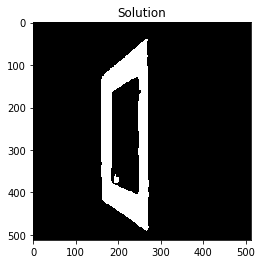

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6140.png
[]
file has only one shape


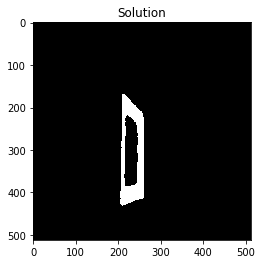

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0196.png
[]
file has only one shape


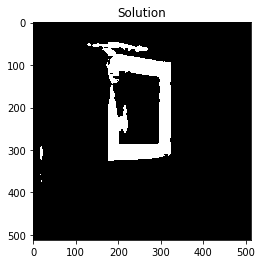

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2096.png
[{'area': 8120, 'centroid': (239, 286), 'corners': array([[255.50478, 255.49208],
       [216.65569, 212.41544],
       [266.5618 , 228.66002],
       [212.32841, 352.67004],
       [267.45273, 349.44006]], dtype=float32)}, {'area': 18568, 'centroid': (239, 287), 'corners': array([[255.5048 , 255.49174],
       [200.7638 , 175.37656],
       [283.25858, 205.32729],
       [284.71164, 379.23108],
       [198.78577, 388.68445]], dtype=float32)}]


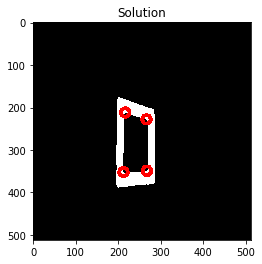

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0268.png
[{'area': 12556, 'centroid': (200, 284), 'corners': array([[255.51588, 255.49217],
       [164.3493 , 209.71906],
       [242.67159, 224.32997],
       [237.63144, 351.67532],
       [159.8369 , 354.91687]], dtype=float32)}, {'area': 25010, 'centroid': (201, 287), 'corners': array([[255.51495, 255.49213],
       [155.44072, 179.78568],
       [261.91046, 197.81294],
       [140.68484, 383.64142],
       [263.1812 , 384.1812 ]], dtype=float32)}]


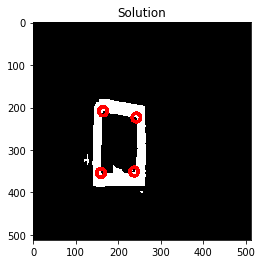

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9681.png
[{'area': 55484, 'centroid': (211, 257), 'corners': array([[255.51173 , 255.50076 ],
       [298.3927  , 110.3828  ],
       [125.328415, 126.32996 ],
       [309.68185 , 385.78998 ],
       [114.78166 , 393.21832 ]], dtype=float32)}, {'area': 120304, 'centroid': (214, 262), 'corners': array([[255.51175 , 255.49945 ],
       [339.1812  ,  47.818794],
       [ 84.58612 ,  70.77178 ],
       [359.1812  , 454.1812  ],
       [ 67.762215, 459.69455 ]], dtype=float32)}]


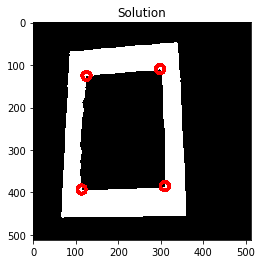

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5328.png
[]
file has only one shape


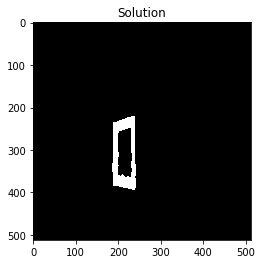

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8878.png
[{'area': 6930, 'centroid': (235, 311), 'corners': array([[255.50557, 255.48454],
       [205.08357, 256.83652],
       [265.87558, 261.73874],
       [205.81877, 366.18124],
       [264.25214, 362.7308 ]], dtype=float32)}, {'area': 15345, 'centroid': (235, 313), 'corners': array([[255.50552, 255.48424],
       [190.32996, 230.32841],
       [281.67154, 239.32993],
       [282.67007, 387.67154],
       [190.75772, 396.21643]], dtype=float32)}]


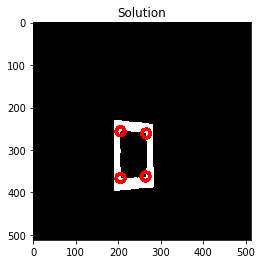

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6564.png
[{'area': 8850, 'centroid': (160, 286), 'corners': array([[255.52634 , 255.49167 ],
       [194.70001 , 226.4265  ],
       [125.08954 , 233.81296 ],
       [195.64595 , 343.2857  ],
       [125.575935, 342.42407 ]], dtype=float32)}, {'area': 17850, 'centroid': (159, 287), 'corners': array([[255.52623, 255.49127],
       [210.6024 , 200.32922],
       [108.81321, 208.08919],
       [210.83507, 370.43112],
       [108.32993, 369.67154]], dtype=float32)}]


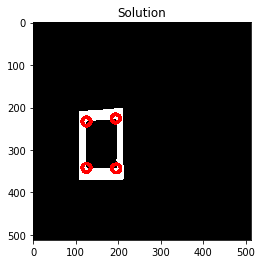

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5493.png
[]
file has only one shape


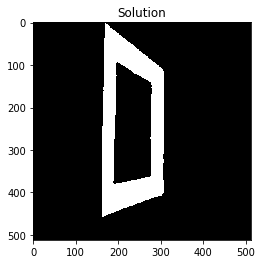

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7118.png
[{'area': 6634, 'centroid': (272, 260), 'corners': array([[255.49516, 255.49883],
       [302.67004, 207.32843],
       [243.30823, 212.60654],
       [302.18124, 311.18124],
       [242.32997, 310.67157]], dtype=float32)}, {'area': 14415, 'centroid': (273, 260), 'corners': array([[255.49496, 255.49886],
       [318.64276, 180.60806],
       [228.32845, 191.32994],
       [227.29301, 335.13126],
       [319.1812 , 336.1812 ]], dtype=float32)}]


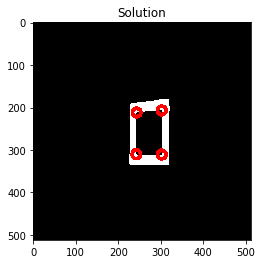

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8118 (1).png
[]
file has only one shape


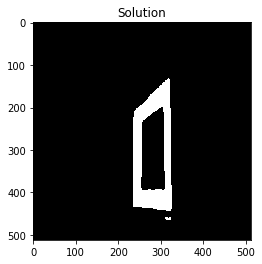

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4137.png
[]
file has only one shape


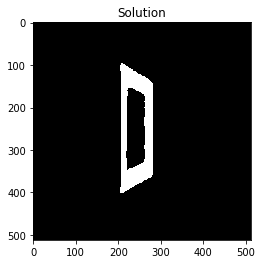

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4351.png
[{'area': 7437, 'centroid': (279, 247), 'corners': array([[255.49341, 255.5022 ],
       [247.83714, 192.08336],
       [312.31635, 196.59366],
       [248.4783 , 302.05334],
       [310.67004, 299.6716 ]], dtype=float32)}, {'area': 16236, 'centroid': (280, 248), 'corners': array([[255.4932 , 255.50186],
       [232.5101 , 165.78885],
       [328.6459 , 169.7143 ],
       [327.2034 , 326.71356],
       [232.59966, 331.53702]], dtype=float32)}]


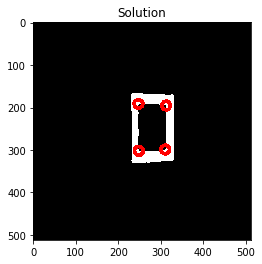

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6957.png
[]
file has only one shape


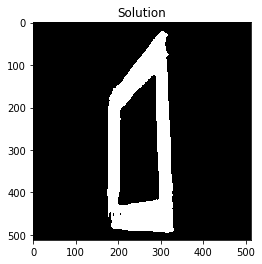

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4485.png
[{'area': 25088, 'centroid': (292, 247), 'corners': array([[255.4897 , 255.50206],
       [355.33987, 150.43817],
       [231.82887, 153.09674],
       [231.47343, 341.47845],
       [354.6716 , 345.67004]], dtype=float32)}, {'area': 53382, 'centroid': (293, 248), 'corners': array([[255.4897 , 255.50172],
       [387.28574, 106.35415],
       [200.1051 , 114.84382],
       [200.33002, 384.67163],
       [384.24228, 393.21643]], dtype=float32)}]


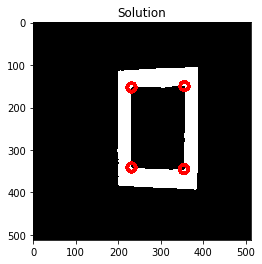

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8376.png
[{'area': 29592, 'centroid': (303, 269), 'corners': array([[255.48654, 255.49608],
       [237.72256, 163.38446],
       [370.64148, 166.68504],
       [371.25214, 372.7308 ],
       [236.04962, 375.45526]], dtype=float32)}, {'area': 62800, 'centroid': (303, 269), 'corners': array([[255.48633, 255.49602],
       [207.48308, 111.54991],
       [404.18118, 122.81881],
       [405.67078, 418.60254],
       [204.81879, 426.1812 ]], dtype=float32)}]


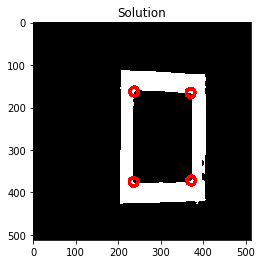

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7836.png
[]
file has only one shape


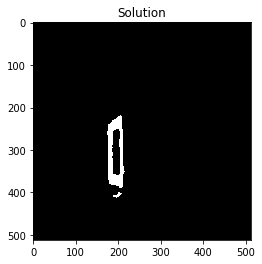

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8441 (1).png
[{'area': 46375, 'centroid': (192, 236), 'corners': array([[255.51726 , 255.50652 ],
       [270.89984 ,  99.19632 ],
       [114.886116, 116.31714 ],
       [278.1869  , 357.91083 ],
       [106.77738 , 363.43332 ]], dtype=float32)}, {'area': 97917, 'centroid': (193, 238), 'corners': array([[255.5169  , 255.50645 ],
       [308.64587 ,  38.714294],
       [ 75.83703 ,  64.08305 ],
       [322.21646 , 416.24228 ],
       [ 64.812965, 419.9105  ]], dtype=float32)}]


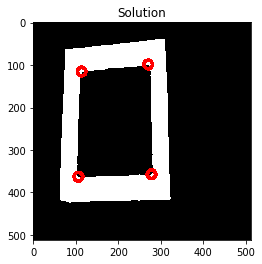

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1144.png
[]
file has only one shape


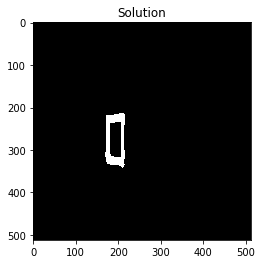

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6533.png
[{'area': 16892, 'centroid': (256, 288), 'corners': array([[255.4994 , 255.49127],
       [305.91077, 206.81322],
       [207.74144, 214.3273 ],
       [308.805  , 363.77106],
       [207.69511, 367.6711 ]], dtype=float32)}, {'area': 35850, 'centroid': (257, 290), 'corners': array([[255.49931, 255.49094],
       [330.21634, 167.75768],
       [183.08333, 182.83719],
       [183.81297, 402.9105 ],
       [330.21768, 407.59317]], dtype=float32)}]


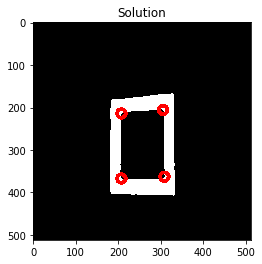

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7579 (1).png
[]
file has only one shape


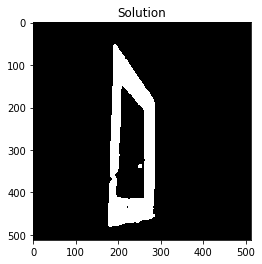

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2652.png
[{'area': 8136, 'centroid': (229, 307), 'corners': array([[255.50728, 255.48558],
       [194.78166, 252.78166],
       [263.42407, 255.57593],
       [193.81877, 363.18124],
       [263.16287, 361.91663]], dtype=float32)}, {'area': 17220, 'centroid': (230, 309), 'corners': array([[255.50694, 255.4853 ],
       [178.57584, 225.57584],
       [282.1812 , 230.81879],
       [177.81879, 390.1812 ],
       [282.2378 , 389.69455]], dtype=float32)}]


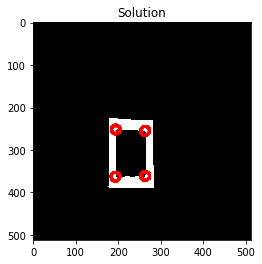

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4966.png
[{'area': 7208, 'centroid': (273, 294), 'corners': array([[255.49533, 255.48907],
       [241.32997, 243.32841],
       [304.26483, 245.41805],
       [240.08954, 346.18704],
       [303.17126, 345.90347]], dtype=float32)}, {'area': 15453, 'centroid': (273, 296), 'corners': array([[255.49506, 255.4888 ],
       [224.84383, 220.1051 ],
       [323.1812 , 220.81879],
       [323.67007, 370.67154],
       [222.78355, 373.24228]], dtype=float32)}]


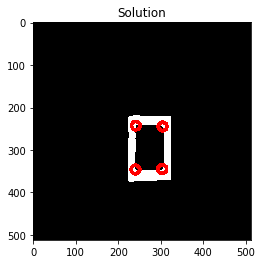

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3487.png
[{'area': 3675, 'centroid': (243, 310), 'corners': array([[255.50323, 255.48468],
       [219.78166, 275.78168],
       [266.6716 , 275.32996],
       [220.96544, 346.56232],
       [266.67004, 346.6716 ]], dtype=float32)}, {'area': 7848, 'centroid': (243, 312), 'corners': array([[255.5033 , 255.48427],
       [206.81879, 258.8188 ],
       [279.30472, 260.4013 ],
       [279.91696, 364.16296],
       [207.81879, 368.1812 ]], dtype=float32)}]


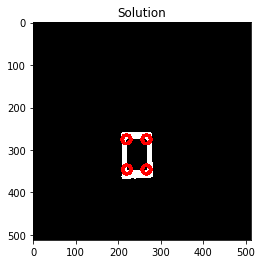

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9330.png
[{'area': 28842, 'centroid': (267, 268), 'corners': array([[255.4967 , 255.49629],
       [199.19284, 167.26736],
       [334.65125, 164.71997],
       [200.81313, 373.91083],
       [335.67017, 371.67145]], dtype=float32)}, {'area': 60702, 'centroid': (268, 269), 'corners': array([[255.49649 , 255.49615 ],
       [167.81879 , 118.818794],
       [368.1812  , 118.818794],
       [168.32845 , 420.67007 ],
       [369.1812  , 420.1812  ]], dtype=float32)}]


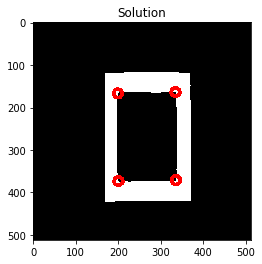

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5452.png
[]
file has only one shape


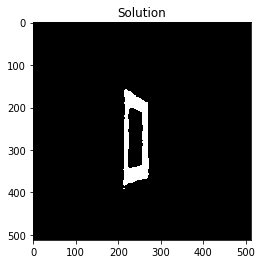

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9003.png
[]
file has only one shape


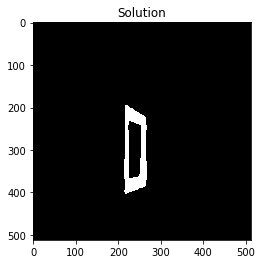

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7152 (1).png
[{'area': 51238, 'centroid': (254, 264), 'corners': array([[255.5     , 255.49814 ],
       [169.45499 , 125.61608 ],
       [342.4256  , 126.426735],
       [161.04962 , 397.45526 ],
       [348.05334 , 396.5217  ]], dtype=float32)}, {'area': 109848, 'centroid': (254, 267), 'corners': array([[255.50014 , 255.49767 ],
       [127.71282 ,  64.659645],
       [381.16284 ,  69.082924],
       [394.18704 , 458.9105  ],
       [121.752426, 465.98117 ]], dtype=float32)}]


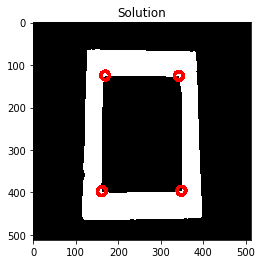

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6070.png
[]
file has only one shape


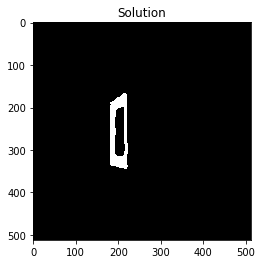

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6749.png
[{'area': 40963, 'centroid': (292, 265), 'corners': array([[255.4901 , 255.49927],
       [231.48872, 100.02625],
       [356.26315, 160.5267 ],
       [230.02628, 392.975  ],
       [366.6784 , 394.7932 ]], dtype=float32)}, {'area': 98780, 'centroid': (288, 265), 'corners': array([[255.49072 , 255.5002  ],
       [197.28293 ,  16.220894],
       [386.87457 , 105.271996],
       [409.1812  , 454.1812  ],
       [190.99722 , 468.4675  ]], dtype=float32)}]


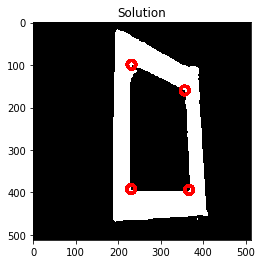

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7125.png
[{'area': 13244, 'centroid': (252, 249), 'corners': array([[255.50032, 255.50237],
       [293.67004, 171.32843],
       [211.28017, 184.6886 ],
       [294.16348, 319.9164 ],
       [212.54472, 322.95038]], dtype=float32)}, {'area': 28672, 'centroid': (253, 249), 'corners': array([[255.49995, 255.50262],
       [312.2141 , 131.31563],
       [190.769  , 157.28835],
       [189.1655 , 354.43124],
       [315.7075 , 357.5581 ]], dtype=float32)}]


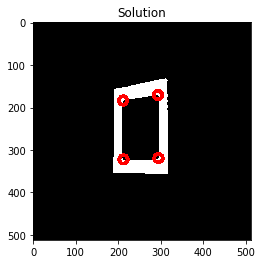

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3254.png
[{'area': 3220, 'centroid': (222, 304), 'corners': array([[255.50925, 255.48575],
       [235.66194, 256.7755 ],
       [207.57591, 265.5759 ],
       [237.65123, 346.28006],
       [211.26004, 347.36356]], dtype=float32)}, {'area': 6885, 'centroid': (221, 305), 'corners': array([[255.50905, 255.48633],
       [246.20895, 236.03131],
       [196.61183, 253.2631 ],
       [246.1303 , 369.20596],
       [196.75772, 369.21646]], dtype=float32)}]


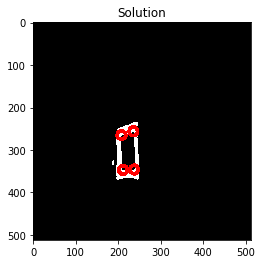

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3753.png
[{'area': 10541, 'centroid': (251, 290), 'corners': array([[255.50096, 255.49039],
       [211.32997, 228.32841],
       [291.44006, 228.54729],
       [212.34875, 354.28003],
       [292.74243, 350.3054 ]], dtype=float32)}, {'area': 23625, 'centroid': (252, 291), 'corners': array([[255.50076, 255.48984],
       [191.32845, 199.32994],
       [312.1628 , 200.08333],
       [314.24228, 383.21643],
       [193.40121, 388.30472]], dtype=float32)}]


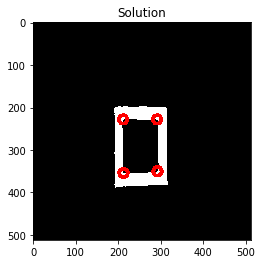

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8354 (1).png
[{'area': 7659, 'centroid': (209, 314), 'corners': array([[258.2872 , 257.9988 ],
       [176.81879, 257.8188 ],
       [242.18123, 263.81876],
       [175.81877, 367.18124],
       [240.90909, 366.19345]], dtype=float32)}, {'area': 16038, 'centroid': (208, 315), 'corners': array([[258.2872 , 257.9988 ],
       [161.8188 , 231.8188 ],
       [257.67163, 243.33002],
       [159.81879, 394.1812 ],
       [257.67017, 392.67145]], dtype=float32)}]


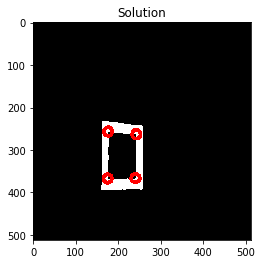

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8532 (1).png
[{'area': 9834, 'centroid': (254, 300), 'corners': array([[255.49988, 255.4878 ],
       [282.64862, 222.36812],
       [222.84567, 244.67476],
       [286.44162, 366.44177],
       [223.85213, 368.87576]], dtype=float32)}, {'area': 22200, 'centroid': (254, 301), 'corners': array([[255.49997, 255.4877 ],
       [298.8176 , 182.53621],
       [203.61606, 220.45497],
       [301.59885, 403.3047 ],
       [204.59647, 404.636  ]], dtype=float32)}]


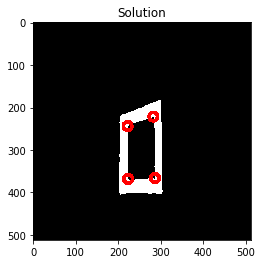

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4267.png
[{'area': 18326, 'centroid': (247, 250), 'corners': array([[255.50218, 255.50156],
       [200.86967, 157.79404],
       [296.5528 , 170.684  ],
       [295.87326, 332.31024],
       [200.81877, 344.18124]], dtype=float32)}, {'area': 41160, 'centroid': (246, 251), 'corners': array([[255.50258, 255.50085],
       [175.22722, 112.46971],
       [320.6459 , 133.7143 ],
       [321.48166, 367.1881 ],
       [177.79668, 393.71356]], dtype=float32)}]


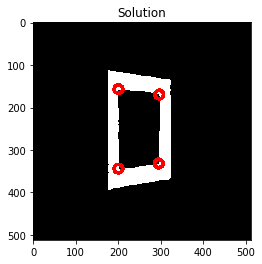

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7172.png
[{'area': 21660, 'centroid': (279, 266), 'corners': array([[255.49306, 255.49611],
       [317.77164, 143.01442],
       [233.00435, 186.56825],
       [324.6716 , 364.67004],
       [233.68407, 367.55283]], dtype=float32)}, {'area': 50764, 'centroid': (281, 265), 'corners': array([[255.49257, 255.49568],
       [341.5204 ,  75.61839],
       [206.90547, 159.28406],
       [205.81879, 410.1812 ],
       [354.54648, 418.69806]], dtype=float32)}]


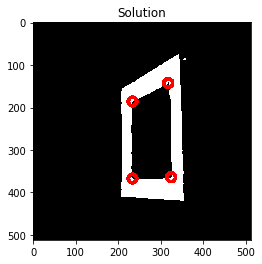

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4687.png
[]
file has only one shape


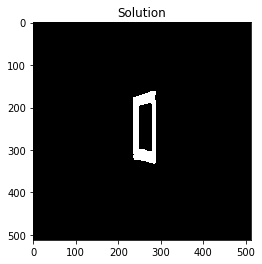

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5559.png
[{'area': 38628, 'centroid': (297, 245), 'corners': array([[255.4882 , 255.50351],
       [230.43373, 110.35566],
       [369.54916, 131.22679],
       [371.77057, 362.72516],
       [224.81877, 372.18124]], dtype=float32)}, {'area': 86190, 'centroid': (295, 245), 'corners': array([[255.48961, 255.50456],
       [189.32997,  46.32841],
       [404.9167 ,  84.8372 ],
       [409.18704, 413.9105 ],
       [187.81879, 436.1812 ]], dtype=float32)}]


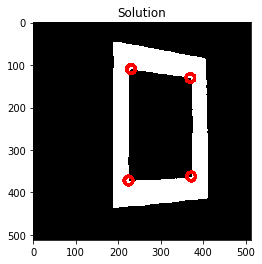

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8529.png
[{'area': 5616, 'centroid': (275, 268), 'corners': array([[255.49484, 255.49696],
       [256.5879 , 208.4319 ],
       [297.6716 , 216.32997],
       [254.81316, 325.91083],
       [295.4527 , 321.44003]], dtype=float32)}, {'area': 13098, 'centroid': (276, 269), 'corners': array([[255.49432, 255.49605],
       [244.29327, 180.44156],
       [313.91046, 196.81294],
       [310.2378 , 347.69455],
       [240.81879, 358.1812 ]], dtype=float32)}]


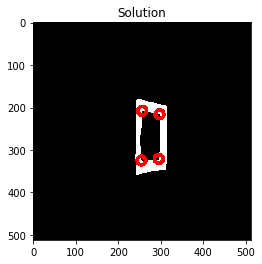

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9852.png
[{'area': 8436, 'centroid': (295, 274), 'corners': array([[255.48901, 255.49478],
       [260.83716, 219.08336],
       [330.91663, 221.83713],
       [260.08337, 327.16287],
       [330.16306, 329.91666]], dtype=float32)}, {'area': 17280, 'centroid': (296, 275), 'corners': array([[255.48866, 255.49457],
       [244.57578, 195.57578],
       [350.1812 , 196.81879],
       [243.32845, 353.67007],
       [349.90894, 355.19354]], dtype=float32)}]


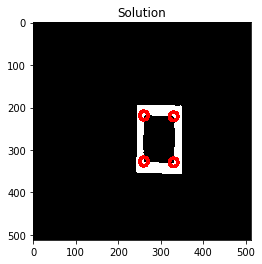

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8186.png
[{'area': 11396, 'centroid': (248, 236), 'corners': array([[255.50148, 255.50595],
       [282.18124, 157.81877],
       [213.76886, 169.28839],
       [214.81296, 306.91046],
       [284.1312 , 311.70728]], dtype=float32)}, {'area': 25724, 'centroid': (249, 236), 'corners': array([[255.5002 , 255.50531],
       [299.5389 , 116.93942],
       [194.08969, 143.813  ],
       [194.84341, 334.89453],
       [301.44678, 354.8088 ]], dtype=float32)}]


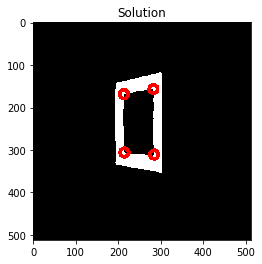

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3037.png
[]
file has only one shape


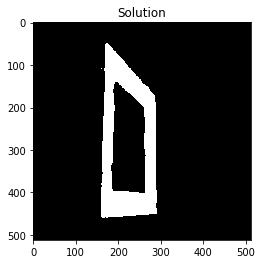

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7479.png
[{'area': 5202, 'centroid': (263, 258), 'corners': array([[255.49805, 255.49971],
       [242.32996, 207.32843],
       [288.30472, 213.40118],
       [241.81316, 308.91083],
       [283.8765 , 305.14752]], dtype=float32)}, {'area': 11448, 'centroid': (263, 259), 'corners': array([[255.49818, 255.4988 ],
       [232.42923, 179.07259],
       [299.91046, 194.81294],
       [296.14142, 330.45273],
       [230.26787, 340.07693]], dtype=float32)}]


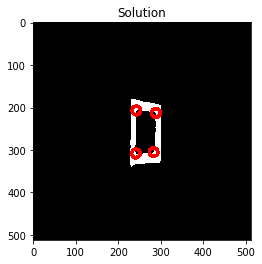

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8634.png
[]
file has only one shape


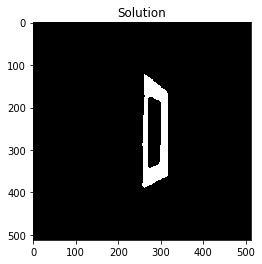

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9724.png
[{'area': 14553, 'centroid': (250, 194), 'corners': array([[255.50131 , 255.51683 ],
       [205.81296 , 122.08954 ],
       [297.91663 , 125.837135],
       [202.42201 , 263.68604 ],
       [296.42407 , 266.42407 ]], dtype=float32)}, {'area': 30104, 'centroid': (251, 194), 'corners': array([[255.50131 , 255.51683 ],
       [182.83704 ,  89.08336 ],
       [321.1812  ,  91.818794],
       [180.32845 , 296.67007 ],
       [319.67017 , 299.67145 ]], dtype=float32)}]


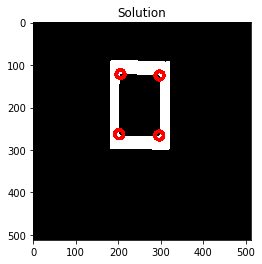

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1007.png
[{'area': 24600, 'centroid': (236, 315), 'corners': array([[255.5048 , 255.48325],
       [271.50095, 192.49968],
       [186.60892, 219.51958],
       [184.99913, 406.50006],
       [284.1812 , 435.1812 ]], dtype=float32)}, {'area': 57750, 'centroid': (239, 317), 'corners': array([[255.5032  , 255.48193 ],
       [308.44775 , 126.269516],
       [160.74756 , 181.67456 ],
       [158.49615 , 456.40933 ],
       [312.18124 , 501.18124 ]], dtype=float32)}]


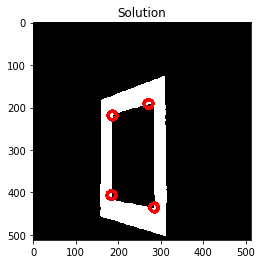

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8159.png
[{'area': 14878, 'centroid': (301, 230), 'corners': array([[255.48657, 255.50772],
       [339.522  , 142.5278 ],
       [260.5378 , 157.53838],
       [260.54727, 306.44006],
       [342.13092, 316.20624]], dtype=float32)}, {'area': 32760, 'centroid': (303, 230), 'corners': array([[255.48463, 255.50723],
       [362.83417,  98.56853],
       [237.44757, 130.68317],
       [236.26067, 334.83337],
       [362.28275, 359.6802 ]], dtype=float32)}]


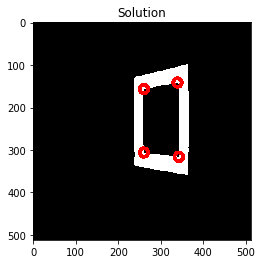

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7013 (1).png
[{'area': 45192, 'centroid': (235, 248), 'corners': array([[255.50645, 255.50374],
       [160.95935, 105.36425],
       [317.91663, 134.837  ],
       [153.68976, 373.87326],
       [316.87326, 371.31024]], dtype=float32)}, {'area': 97170, 'centroid': (232, 249), 'corners': array([[255.5074  , 255.50409 ],
       [124.4831  ,  39.549843],
       [351.1812  ,  87.81878 ],
       [356.67007 , 425.67154 ],
       [110.78165 , 436.21835 ]], dtype=float32)}]


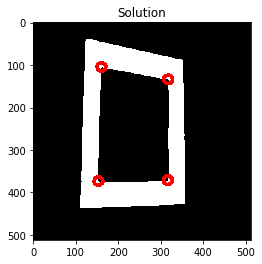

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9514.png
[{'area': 60697, 'centroid': (267, 272), 'corners': array([[255.49663, 255.49615],
       [177.85211, 123.12423],
       [363.5655 , 125.69085],
       [164.37036, 411.62964],
       [366.67004, 418.6716 ]], dtype=float32)}, {'area': 130634, 'centroid': (269, 276), 'corners': array([[255.49649 , 255.49547 ],
       [135.33002 ,  58.32837 ],
       [408.1812  ,  62.818794],
       [114.12427 , 476.1479  ],
       [414.48035 , 491.39105 ]], dtype=float32)}]


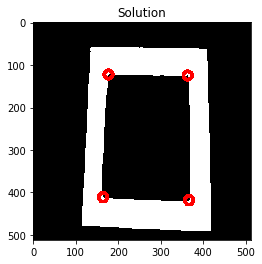

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3981.png
[{'area': 20240, 'centroid': (239, 272), 'corners': array([[255.50395, 255.49628],
       [279.31003, 159.12634],
       [193.60901, 185.51971],
       [195.8714 , 367.47433],
       [282.66217, 378.24774]], dtype=float32)}, {'area': 47940, 'centroid': (241, 272), 'corners': array([[255.50328, 255.49492],
       [303.70663,  96.44146],
       [168.5    , 149.72726],
       [168.35294, 403.47058],
       [308.70636, 436.55862]], dtype=float32)}]


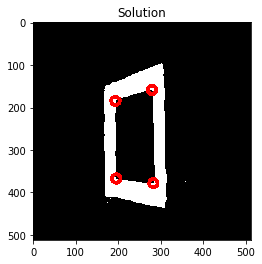

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0406.png
[{'area': 23736, 'centroid': (226, 264), 'corners': array([[255.50871, 255.49767],
       [185.83836, 134.3424 ],
       [275.90344, 166.82872],
       [275.8128 , 360.4983 ],
       [192.49924, 389.50024]], dtype=float32)}, {'area': 59550, 'centroid': (224, 265), 'corners': array([[255.50954, 255.49733],
       [166.6476 ,  65.35324],
       [303.87372, 130.69003],
       [302.3977 , 403.65082],
       [154.42194, 461.43033]], dtype=float32)}]


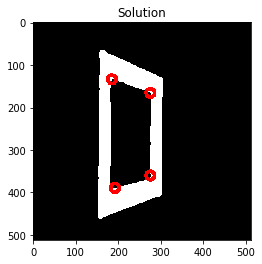

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8881.png
[{'area': 13330, 'centroid': (270, 307), 'corners': array([[255.49576, 255.4859 ],
       [230.7816 , 229.7816 ],
       [311.3054 , 238.25758],
       [311.7116 , 378.23114],
       [228.81877, 383.18124]], dtype=float32)}, {'area': 28980, 'centroid': (270, 309), 'corners': array([[255.4957 , 255.48561],
       [208.81877, 192.81877],
       [333.65112, 208.71979],
       [337.21115, 407.48987],
       [209.29448, 423.17816]], dtype=float32)}]


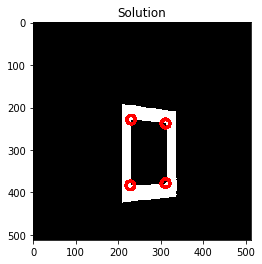

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8581.png
[]
file has only one shape


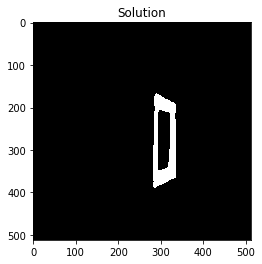

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1529.png
[{'area': 7956, 'centroid': (229, 310), 'corners': array([[255.50778, 255.48476],
       [199.85213, 252.12437],
       [261.91046, 260.81296],
       [196.81877, 366.18124],
       [259.67004, 365.6716 ]], dtype=float32)}, {'area': 17028, 'centroid': (229, 312), 'corners': array([[255.50766, 255.4845 ],
       [186.35414, 222.7143 ],
       [278.87573, 238.85213],
       [277.65112, 393.28024],
       [182.35408, 397.2857 ]], dtype=float32)}]


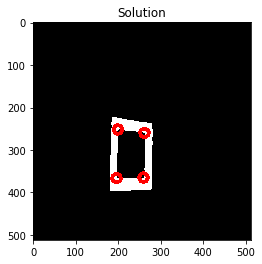

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4591.png
[{'area': 34790, 'centroid': (183, 240), 'corners': array([[251.99959, 254.49997],
       [249.66214, 116.75254],
       [113.08972, 131.81302],
       [115.08358, 352.16348],
       [251.67145, 361.67017]], dtype=float32)}, {'area': 75555, 'centroid': (184, 239), 'corners': array([[251.99959 , 254.49997 ],
       [282.4655  ,  56.491547],
       [ 78.08333 ,  83.8372  ],
       [ 83.49127 , 399.34045 ],
       [282.81744 , 423.45193 ]], dtype=float32)}]


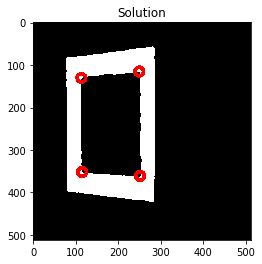

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9887.png
[{'area': 7350, 'centroid': (302, 275), 'corners': array([[255.48709, 255.49443],
       [269.08313, 224.8369 ],
       [335.67157, 224.32997],
       [268.81876, 326.18124],
       [336.18124, 327.18124]], dtype=float32)}, {'area': 15100, 'centroid': (303, 275), 'corners': array([[255.48682, 255.49437],
       [354.20892, 201.03133],
       [253.72728, 203.49998],
       [253.33002, 349.67163],
       [350.72998, 353.24356]], dtype=float32)}]


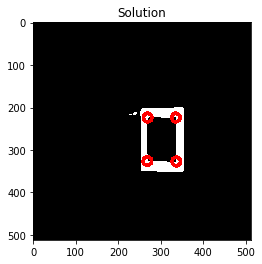

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0008.png
[{'area': 42687, 'centroid': (127, 195), 'corners': array([[255.53612 , 255.518   ],
       [ 59.544186,  42.24761 ],
       [205.78732 ,  98.57092 ],
       [202.91081 , 314.1869  ],
       [ 55.768845, 320.7116  ]], dtype=float32)}, {'area': 87236, 'centroid': (122, 197), 'corners': array([[ 2.55539093e+02,  2.55518082e+02],
       [ 2.32981720e+01, -5.15937060e-02],
       [ 2.37478424e+02,  5.74733734e+01],
       [ 2.37711624e+02,  3.63231079e+02],
       [ 1.33284445e+01,  3.86670074e+02]], dtype=float32)}]


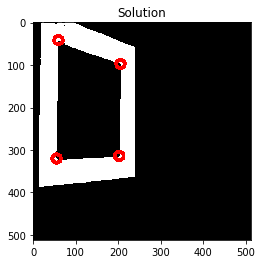

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0933.png
[{'area': 19030, 'centroid': (257, 330), 'corners': array([[255.49945, 255.47932],
       [309.91687, 243.8369 ],
       [204.32855, 248.32983],
       [204.68999, 413.87366],
       [311.18124, 416.18124]], dtype=float32)}, {'area': 41634, 'centroid': (258, 332), 'corners': array([[255.49959, 255.47891],
       [336.1812 , 202.81879],
       [177.09071, 213.80717],
       [177.3378 , 452.24777],
       [337.65118, 460.28015]], dtype=float32)}]


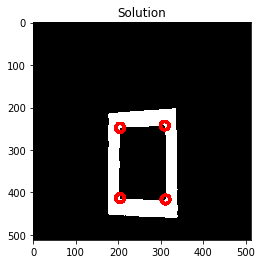

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5772.png
[{'area': 7952, 'centroid': (241, 260), 'corners': array([[255.50398, 255.49863],
       [276.18124, 204.81877],
       [207.12422, 207.85211],
       [207.85834, 315.45273],
       [274.20322, 315.71362]], dtype=float32)}, {'area': 17325, 'centroid': (240, 260), 'corners': array([[255.50412, 255.49849],
       [294.4312 , 179.16518],
       [187.44196, 184.29239],
       [291.67154, 340.67007],
       [189.32545, 342.18777]], dtype=float32)}]


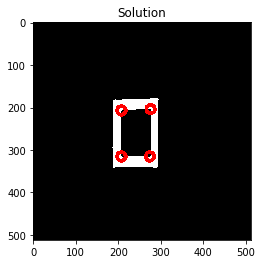

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9829.png
[{'area': 13104, 'centroid': (282, 253), 'corners': array([[255.49251, 255.50069],
       [239.81296, 181.08954],
       [326.42407, 186.57593],
       [238.32843, 323.67004],
       [327.16287, 321.91663]], dtype=float32)}, {'area': 27510, 'centroid': (283, 254), 'corners': array([[255.4921 , 255.50027],
       [219.29239, 147.44196],
       [348.67154, 156.32993],
       [350.15613, 354.895  ],
       [218.83704, 357.91696]], dtype=float32)}]


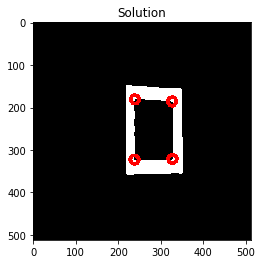

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6577.png
[{'area': 8142, 'centroid': (294, 276), 'corners': array([[255.48882, 255.49452],
       [326.6099 , 216.47144],
       [261.76883, 225.28839],
       [326.39383, 331.55804],
       [264.67172, 332.55743]], dtype=float32)}, {'area': 17340, 'centroid': (294, 277), 'corners': array([[255.48889, 255.49422],
       [342.81592, 188.66753],
       [244.08333, 203.83719],
       [247.34889, 358.28024],
       [344.2026 , 359.4172 ]], dtype=float32)}]


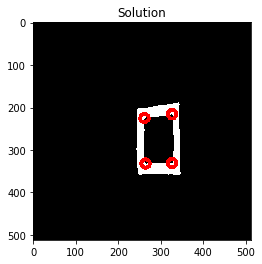

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7337.png
[{'area': 62172, 'centroid': (235, 264), 'corners': array([[255.50487, 255.49966],
       [319.77414,  97.46733],
       [140.57594, 129.57594],
       [334.23114, 407.7116 ],
       [137.92523, 410.15768]], dtype=float32)}, {'area': 134612, 'centroid': (240, 267), 'corners': array([[255.50343 , 255.49966 ],
       [363.1479  ,  21.124346],
       [102.83696 ,  77.0831  ],
       [ 93.8372  , 475.9167  ],
       [387.13126 , 480.707   ]], dtype=float32)}]


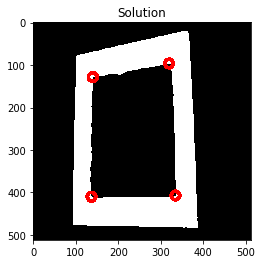

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4769.png
[]
file has only one shape


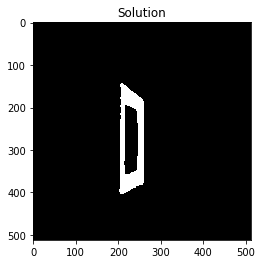

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1427.png
[]
file has only one shape


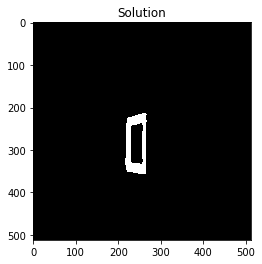

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4498.png
[{'area': 26058, 'centroid': (240, 248), 'corners': array([[255.50412, 255.50172],
       [303.6727 , 147.74144],
       [177.55995, 152.54729],
       [177.85213, 346.87576],
       [303.16348, 348.9164 ]], dtype=float32)}, {'area': 56430, 'centroid': (242, 249), 'corners': array([[255.50398 , 255.50137 ],
       [335.67017 , 101.328545],
       [145.8188  , 111.818794],
       [147.8372  , 390.9167  ],
       [335.1812  , 398.1812  ]], dtype=float32)}]


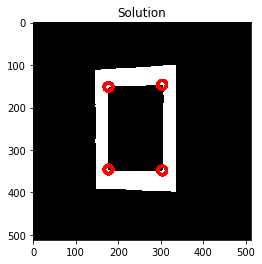

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8725.png
[{'area': 36162, 'centroid': (297, 267), 'corners': array([[255.48834, 255.49728],
       [229.08331, 141.83675],
       [370.03455, 159.43768],
       [367.57974, 380.22107],
       [226.08954, 387.18704]], dtype=float32)}, {'area': 78324, 'centroid': (296, 268), 'corners': array([[255.4884 , 255.49724],
       [196.30191,  80.45348],
       [403.18677, 113.08921],
       [403.1628 , 429.9167 ],
       [190.81879, 447.1812 ]], dtype=float32)}]


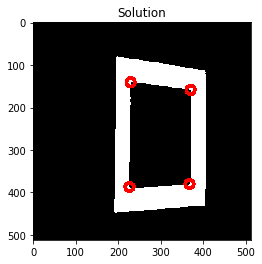

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6935.png
[]
file has only one shape


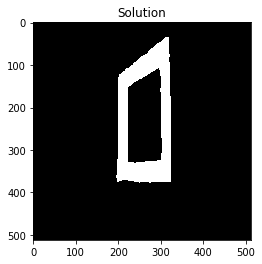

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6901 (1).png
[{'area': 11524, 'centroid': (249, 287), 'corners': array([[255.5023 , 255.49136],
       [220.80963, 196.25125],
       [282.3378 , 224.24847],
       [218.75768, 368.21634],
       [278.21835, 365.21832]], dtype=float32)}, {'area': 26433, 'centroid': (250, 288), 'corners': array([[255.50232, 255.49051],
       [204.69502, 148.32889],
       [300.1038 , 195.07422],
       [298.6539 , 404.78925],
       [201.34239, 416.15585]], dtype=float32)}]


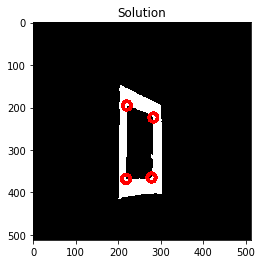

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0599.png
[{'area': 8496, 'centroid': (256, 255), 'corners': array([[255.49939, 255.4997 ],
       [223.28839, 199.76883],
       [290.7076 , 196.44194],
       [223.81313, 310.91083],
       [290.6025 , 315.6709 ]], dtype=float32)}, {'area': 18512, 'centroid': (256, 256), 'corners': array([[255.49992, 255.49979],
       [306.60242, 166.32922],
       [203.46948, 175.22754],
       [205.09064, 338.1932 ],
       [306.24228, 346.21643]], dtype=float32)}]


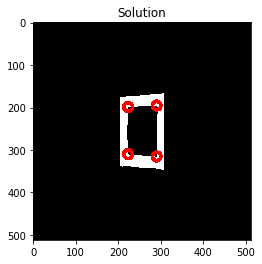

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6249.png
[{'area': 20995, 'centroid': (268, 292), 'corners': array([[255.49684, 255.49014],
       [228.18233, 175.53625],
       [315.92377, 211.83052],
       [309.6111 , 390.6111 ],
       [225.03297, 397.20276]], dtype=float32)}, {'area': 48384, 'centroid': (267, 293), 'corners': array([[255.49745, 255.48984],
       [200.81886, 115.81886],
       [338.56183, 172.66031],
       [342.18704, 431.9105 ],
       [200.76228, 454.6507 ]], dtype=float32)}]


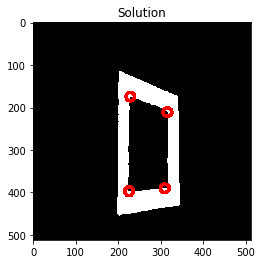

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0178.png
[{'area': 169, 'centroid': (318, 103), 'corners': array([[259.0008  , 252.49994 ],
       [316.69104 ,  95.53074 ],
       [324.15704 , 104.464966],
       [311.556   , 105.72409 ],
       [318.44934 , 110.22076 ]], dtype=float32)}]
file has only one shape


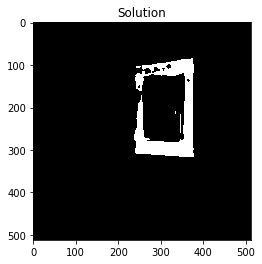

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6863.png
[{'area': 6000, 'centroid': (269, 272), 'corners': array([[255.49594, 255.4956 ],
       [297.67023, 222.3286 ],
       [241.44719, 229.68402],
       [297.96866, 319.20895],
       [241.26927, 319.25165]], dtype=float32)}, {'area': 12584, 'centroid': (269, 271), 'corners': array([[255.49603, 255.49597],
       [310.1812 , 197.8188 ],
       [227.08333, 207.83719],
       [313.67163, 338.66998],
       [227.29301, 341.13126]], dtype=float32)}]


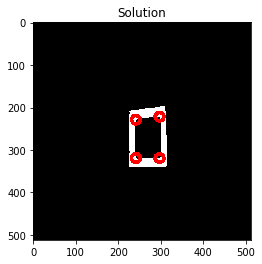

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2788.png
[{'area': 14196, 'centroid': (246, 321), 'corners': array([[255.50201, 255.48204],
       [286.20352, 241.28642],
       [205.56694, 253.84189],
       [291.16348, 392.9164 ],
       [203.81296, 394.91046]], dtype=float32)}, {'area': 30780, 'centroid': (246, 323), 'corners': array([[255.5019 , 255.48201],
       [308.55795, 205.29216],
       [179.71976, 228.34889],
       [313.9167 , 428.1628 ],
       [180.75772, 431.21646]], dtype=float32)}]


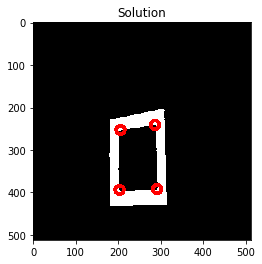

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7382 (1).png
[{'area': 8322, 'centroid': (249, 283), 'corners': array([[255.50122, 255.49278],
       [273.7001 , 206.42644],
       [222.60901, 226.51971],
       [275.20264, 351.41736],
       [223.81296, 349.91046]], dtype=float32)}, {'area': 18618, 'centroid': (249, 283), 'corners': array([[255.50131, 255.49283],
       [289.571  , 168.33127],
       [205.49615, 202.59068],
       [205.32985, 378.67145],
       [290.67154, 383.67007]], dtype=float32)}]


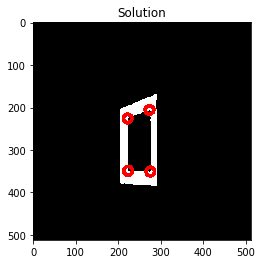

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5212.png
[{'area': 18308, 'centroid': (239, 291), 'corners': array([[255.504  , 255.49074],
       [281.41217, 189.43188],
       [194.08954, 209.81296],
       [196.4916 , 381.34064],
       [282.51767, 388.6939 ]], dtype=float32)}, {'area': 41700, 'centroid': (239, 294), 'corners': array([[255.5029 , 255.48933],
       [304.7725 , 139.46953],
       [169.7816 , 176.7816 ],
       [176.54233, 426.64282],
       [306.51312, 440.28394]], dtype=float32)}]


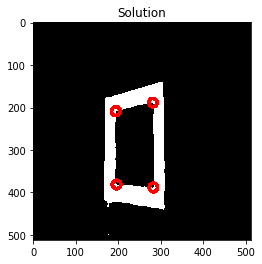

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1278.png
[{'area': 47676, 'centroid': (284, 262), 'corners': array([[255.49167, 255.49866],
       [205.51971, 122.609  ],
       [370.91043, 138.81294],
       [369.7116 , 391.23114],
       [200.12634, 396.31003]], dtype=float32)}, {'area': 101052, 'centroid': (283, 264), 'corners': array([[255.49196 , 255.4987  ],
       [164.88628 ,  58.317257],
       [407.18677 ,  84.08921 ],
       [411.42416 , 448.42416 ],
       [160.01616 , 459.39362 ]], dtype=float32)}]


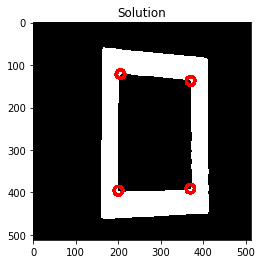

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8140.png
[{'area': 9030, 'centroid': (288, 233), 'corners': array([[255.49014, 255.50677],
       [320.88275, 168.74356],
       [255.63748, 176.46992],
       [259.09546, 295.23746],
       [322.28094, 296.6507 ]], dtype=float32)}, {'area': 19291, 'centroid': (289, 233), 'corners': array([[255.49002, 255.50674],
       [338.18124, 136.81877],
       [238.7816 , 153.7816 ],
       [238.0892 , 317.18677],
       [336.7075 , 329.5581 ]], dtype=float32)}]


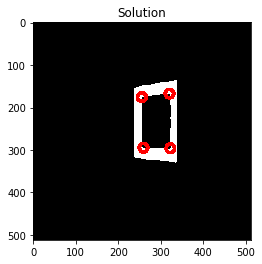

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0175.png
[{'area': 18939, 'centroid': (250, 249), 'corners': array([[255.50136, 255.50195],
       [300.18704, 160.08954],
       [197.44719, 173.68402],
       [301.61478, 331.89047],
       [199.81296, 333.91046]], dtype=float32)}, {'area': 40404, 'centroid': (251, 250), 'corners': array([[255.50067, 255.50311],
       [324.424  , 115.57598],
       [173.68376, 140.49734],
       [172.71979, 368.65112],
       [328.24228, 376.21643]], dtype=float32)}]


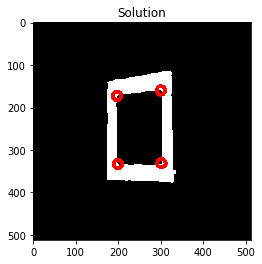

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7756.png
[{'area': 9114, 'centroid': (253, 295), 'corners': array([[255.49991, 255.48935],
       [280.5545 , 219.6064 ],
       [224.08073, 234.84   ],
       [281.6214 , 366.3069 ],
       [227.99309, 364.4674 ]], dtype=float32)}, {'area': 20586, 'centroid': (253, 297), 'corners': array([[255.49988, 255.48953],
       [295.81757, 181.5362 ],
       [207.12628, 211.69003],
       [206.8372 , 390.9167 ],
       [298.59735, 403.38696]], dtype=float32)}]


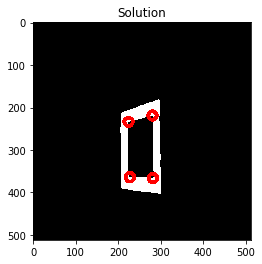

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8264 (1).png
[{'area': 10584, 'centroid': (230, 300), 'corners': array([[255.50737, 255.48749],
       [204.88383, 210.24812],
       [260.97662, 245.44453],
       [201.32841, 373.67004],
       [257.31592, 375.55283]], dtype=float32)}, {'area': 24000, 'centroid': (230, 301), 'corners': array([[255.50734, 255.48677],
       [188.2821 , 163.92584],
       [278.44003, 215.69293],
       [183.68982, 412.87338],
       [277.6341 , 414.22263]], dtype=float32)}]


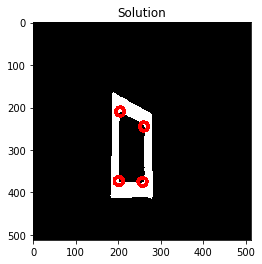

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0510.png
[{'area': 52490, 'centroid': (247, 226), 'corners': array([[255.50177, 255.50865],
       [166.82974,  79.07574],
       [339.4527 ,  99.56005],
       [334.87326, 359.31024],
       [160.54732, 367.43994]], dtype=float32)}, {'area': 111249, 'centroid': (245, 225), 'corners': array([[255.50235 , 255.50905 ],
       [123.91741 ,   8.277087],
       [381.23108 ,  43.28837 ],
       [376.24356 , 415.72998 ],
       [119.53787 , 433.46167 ]], dtype=float32)}]


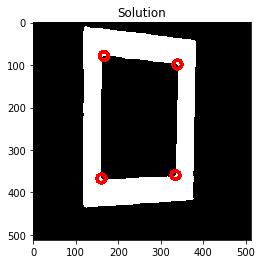

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5399.png
[]
file has only one shape


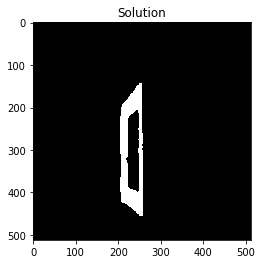

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0365.png
[{'area': 7245, 'centroid': (217, 271), 'corners': array([[255.51038, 255.49574],
       [190.55788, 218.7728 ],
       [250.28094, 223.3493 ],
       [184.52155, 319.52658],
       [248.6507 , 322.28094]], dtype=float32)}, {'area': 15100, 'centroid': (216, 272), 'corners': array([[255.5103 , 255.49553],
       [173.24133, 196.65724],
       [267.15985, 200.55716],
       [168.12398, 343.14786],
       [264.66208, 347.24753]], dtype=float32)}]


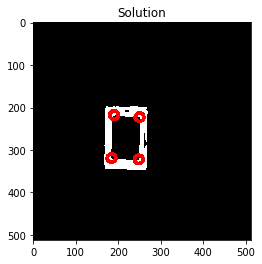

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6700.png
[{'area': 8316, 'centroid': (266, 297), 'corners': array([[255.49641, 255.48848],
       [289.40198, 217.01776],
       [240.55975, 237.69272],
       [291.2423 , 371.21634],
       [244.80116, 370.10547]], dtype=float32)}, {'area': 19588, 'centroid': (265, 299), 'corners': array([[255.4965 , 255.48776],
       [303.22992, 174.17357],
       [224.0807 , 212.84   ],
       [225.3378 , 401.24777],
       [305.5171 , 411.4499 ]], dtype=float32)}]


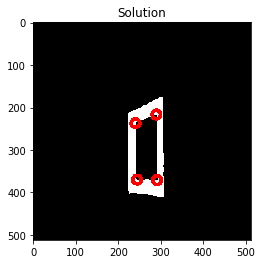

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5800.png
[{'area': 32625, 'centroid': (221, 238), 'corners': array([[255.50948, 255.50475],
       [292.18704, 126.08953],
       [151.83688, 130.08313],
       [148.33781, 348.24738],
       [291.6716 , 349.67004]], dtype=float32)}, {'area': 68786, 'centroid': (221, 240), 'corners': array([[255.50928 , 255.50433 ],
       [326.1812  ,  75.818794],
       [117.83703 ,  85.08305 ],
       [115.812965, 395.9105  ],
       [327.1812  , 402.1812  ]], dtype=float32)}]


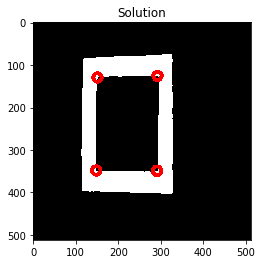

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0577.png
[{'area': 66584, 'centroid': (279, 249), 'corners': array([[255.49382 , 255.50151 ],
       [381.67004 ,  88.328415],
       [178.49617 ,  98.59069 ],
       [177.25946 , 399.08524 ],
       [375.16348 , 414.9164  ]], dtype=float32)}, {'area': 143577, 'centroid': (284, 249), 'corners': array([[255.49292 , 255.50137 ],
       [433.9215  ,  13.860879],
       [131.60217 ,  38.349113],
       [131.86662 , 460.34378 ],
       [425.46213 , 491.46167 ]], dtype=float32)}]


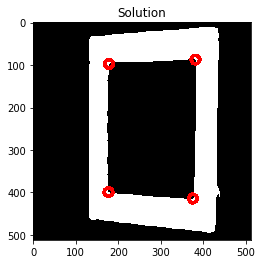

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7985.png
[{'area': 57645, 'centroid': (229, 247), 'corners': array([[255.5074  , 255.50313 ],
       [316.40628 ,  86.468864],
       [139.57593 , 108.575935],
       [135.56004 , 388.4527  ],
       [317.16348 , 401.9164  ]], dtype=float32)}, {'area': 126752, 'centroid': (233, 248), 'corners': array([[255.50496, 255.50308],
       [362.67023,  13.3286 ],
       [ 99.83704,  56.08303],
       [ 91.8372 , 445.9167 ],
       [364.16278, 478.91718]], dtype=float32)}]


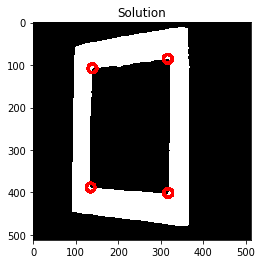

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7327 (1).png
[{'area': 24840, 'centroid': (226, 292), 'corners': array([[255.50735, 255.49045],
       [282.28702, 185.65959],
       [169.52156, 203.4734 ],
       [286.18124, 390.18124],
       [168.6404 , 390.34332]], dtype=float32)}, {'area': 53328, 'centroid': (227, 294), 'corners': array([[255.50714, 255.49074],
       [310.18124, 134.81876],
       [141.08331, 167.8372 ],
       [137.69427, 430.74207],
       [312.64594, 439.2857 ]], dtype=float32)}]


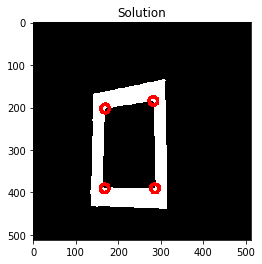

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1679.png
[{'area': 8151, 'centroid': (254, 299), 'corners': array([[255.4996 , 255.4882 ],
       [278.34253, 225.1909 ],
       [228.18924, 241.27133],
       [281.16324, 366.91672],
       [230.77924, 366.43405]], dtype=float32)}, {'area': 18190, 'centroid': (254, 300), 'corners': array([[255.4998 , 255.48741],
       [293.57104, 188.33128],
       [212.47311, 216.52165],
       [211.32974, 392.67136],
       [293.83417, 404.4315 ]], dtype=float32)}]


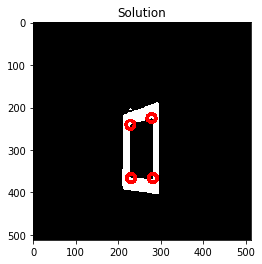

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8327 (1).png
[{'area': 27348, 'centroid': (207, 265), 'corners': array([[255.51424, 255.49818],
       [148.81877, 154.81877],
       [269.4749 , 178.48814],
       [143.84889, 362.90393],
       [270.1479 , 363.87576]], dtype=float32)}, {'area': 60602, 'centroid': (205, 268), 'corners': array([[255.51466 , 255.49838 ],
       [120.031204, 100.790985],
       [297.67157 , 140.32997 ],
       [304.1812  , 408.1812  ],
       [111.60226 , 415.2484  ]], dtype=float32)}]


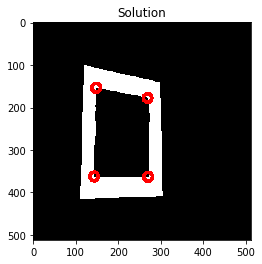

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4842.png
[{'area': 5439, 'centroid': (266, 277), 'corners': array([[255.49704, 255.49432],
       [247.83473, 220.65045],
       [290.36316, 228.51189],
       [244.32841, 331.67004],
       [288.91687, 328.16315]], dtype=float32)}, {'area': 12024, 'centroid': (267, 277), 'corners': array([[255.49704, 255.49443],
       [233.22755, 191.4695 ],
       [302.91046, 207.81294],
       [303.67007, 351.67154],
       [233.16518, 360.4312 ]], dtype=float32)}]


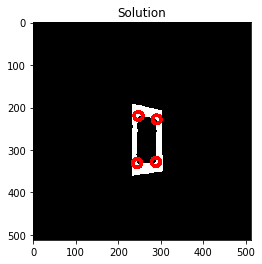

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5874.png
[{'area': 18585, 'centroid': (259, 253), 'corners': array([[255.4987 , 255.50084],
       [310.18124, 163.81877],
       [208.72723, 173.50009],
       [208.42178, 338.43024],
       [310.6716 , 340.67004]], dtype=float32)}, {'area': 40348, 'centroid': (259, 255), 'corners': array([[255.49889, 255.50032],
       [333.163  , 121.08336],
       [181.76903, 142.28835],
       [185.21652, 379.45483],
       [335.1812 , 383.1812 ]], dtype=float32)}]


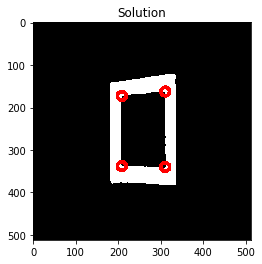

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6824.png
[{'area': 44016, 'centroid': (260, 238), 'corners': array([[255.49918, 255.50687],
       [188.60034,  97.12011],
       [338.23105, 125.28836],
       [180.08954, 359.18704],
       [346.56113, 357.70975]], dtype=float32)}, {'area': 97911, 'centroid': (258, 240), 'corners': array([[255.49985 , 255.50671 ],
       [149.48311 ,  35.549843],
       [372.16296 ,  77.08302 ],
       [389.79694 , 415.20078 ],
       [137.75772 , 424.21643 ]], dtype=float32)}]


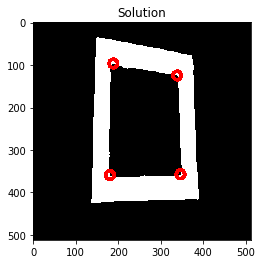

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1437.png
[]
file has only one shape


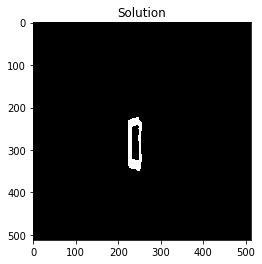

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1380.png
[{'area': 6095, 'centroid': (245, 280), 'corners': array([[255.50232, 255.49315],
       [270.44165, 222.5583 ],
       [220.08954, 230.81296],
       [221.57591, 334.42407],
       [268.7076 , 338.55807]], dtype=float32)}, {'area': 14000, 'centroid': (244, 282), 'corners': array([[255.50282, 255.49298],
       [282.1629 , 193.08336],
       [205.81319, 207.08917],
       [205.4013 , 361.30472],
       [281.97073, 369.21423]], dtype=float32)}]


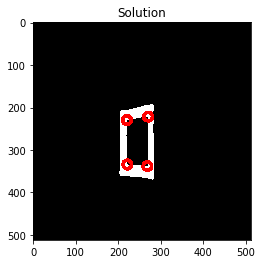

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7547.png
[{'area': 29866, 'centroid': (229, 261), 'corners': array([[255.50722, 255.49849],
       [296.21832, 151.78166],
       [163.44719, 162.68402],
       [294.48044, 367.3911 ],
       [160.83713, 365.91663]], dtype=float32)}, {'area': 64148, 'centroid': (231, 263), 'corners': array([[255.5062 , 255.49854],
       [327.163  , 101.08336],
       [140.17236, 123.35845],
       [129.34889, 411.28024],
       [331.67145, 417.67017]], dtype=float32)}]


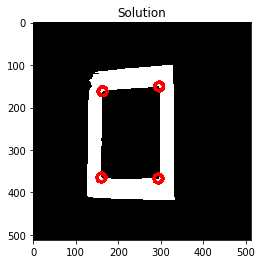

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4502.png
[{'area': 16892, 'centroid': (241, 246), 'corners': array([[255.5042 , 255.50255],
       [287.40317, 164.59073],
       [190.74834, 169.26927],
       [290.16013, 325.73935],
       [190.60806, 325.64276]], dtype=float32)}, {'area': 36261, 'centroid': (241, 248), 'corners': array([[255.50385, 255.50192],
       [316.59827, 127.78863],
       [164.83702, 137.08305],
       [167.73242, 363.3155 ],
       [317.16296, 365.91696]], dtype=float32)}]


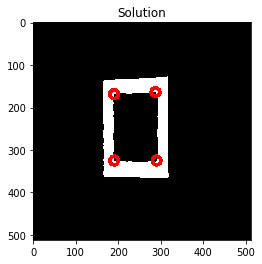

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6931 (1).png
[{'area': 11550, 'centroid': (237, 291), 'corners': array([[255.50539, 255.49034],
       [208.5585 , 204.55823],
       [273.09454, 230.28427],
       [205.83705, 369.91696],
       [270.91083, 365.18683]], dtype=float32)}, {'area': 26606, 'centroid': (238, 292), 'corners': array([[255.5053 , 255.49074],
       [191.29324, 156.44157],
       [290.87604, 199.85216],
       [291.18704, 401.9105 ],
       [187.7968 , 410.71362]], dtype=float32)}]


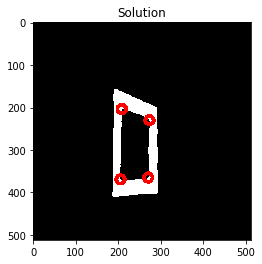

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7665.png
[{'area': 3526, 'centroid': (230, 244), 'corners': array([[255.50703, 255.5034 ],
       [247.40456, 201.66315],
       [211.66043, 207.43822],
       [246.4655 , 286.50842],
       [212.35863, 285.31534]], dtype=float32)}, {'area': 7381, 'centroid': (229, 245), 'corners': array([[255.50699, 255.50343],
       [261.55795, 185.29216],
       [199.49998, 191.72728],
       [201.22673, 301.5491 ],
       [258.24228, 306.21643]], dtype=float32)}]


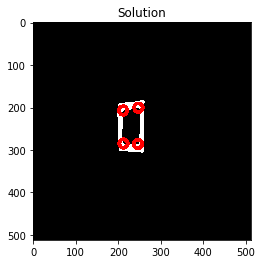

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8927.png
[{'area': 3040, 'centroid': (282, 296), 'corners': array([[255.49252, 255.48888],
       [268.25867, 255.63704],
       [299.91663, 259.83713],
       [265.63748, 334.53006],
       [299.45273, 333.44006]], dtype=float32)}, {'area': 6664, 'centroid': (283, 297), 'corners': array([[255.4923 , 255.48833],
       [255.78366, 238.75768],
       [310.53   , 243.63742],
       [310.33176, 353.73846],
       [257.76978, 358.82632]], dtype=float32)}]


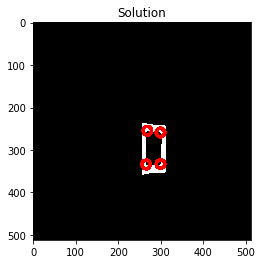

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7787 (1).png
[{'area': 6868, 'centroid': (248, 321), 'corners': array([[256.49994, 251.0007 ],
       [220.33786, 271.75253],
       [281.6716 , 276.32996],
       [217.37859, 371.30692],
       [278.16293, 369.91666]], dtype=float32)}, {'area': 14400, 'centroid': (249, 323), 'corners': array([[256.49994, 251.0007 ],
       [204.33002, 247.32837],
       [296.67154, 254.32993],
       [202.75772, 395.21643],
       [295.67007, 395.67154]], dtype=float32)}]


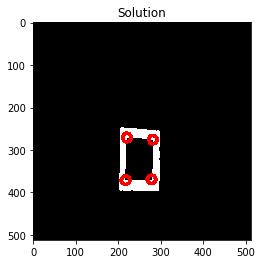

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6149.png
[]
file has only one shape


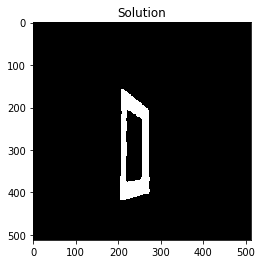

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9888.png
[{'area': 7526, 'centroid': (292, 273), 'corners': array([[255.48984, 255.49525],
       [258.83716, 222.08336],
       [326.18124, 220.81877],
       [257.68466, 322.64136],
       [326.2871 , 325.34036]], dtype=float32)}, {'area': 18526, 'centroid': (292, 273), 'corners': array([[255.48991, 255.49457],
       [342.67   , 195.3284 ],
       [224.72006, 216.51057],
       [244.78267, 350.59302],
       [342.81595, 352.33246]], dtype=float32)}]


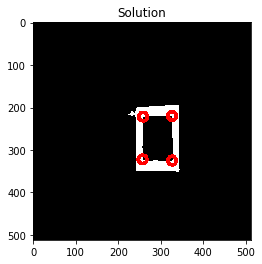

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8758.png
[]
file has only one shape


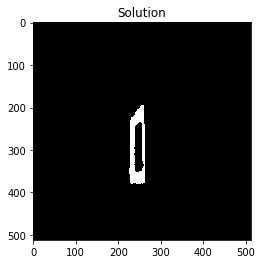

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6084.png
[]
file has only one shape


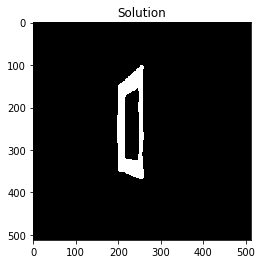

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9933.png
[{'area': 10790, 'centroid': (299, 254), 'corners': array([[255.48784, 255.50014],
       [259.2884 , 190.76884],
       [339.91663, 191.83713],
       [258.86874, 318.70682],
       [340.54858, 316.77405]], dtype=float32)}, {'area': 23370, 'centroid': (300, 255), 'corners': array([[255.48764, 255.5    ],
       [238.83719, 162.08333],
       [359.16296, 162.08305],
       [363.1628 , 345.9167 ],
       [241.32845, 352.67007]], dtype=float32)}]


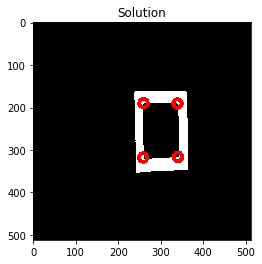

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1531.png
[{'area': 10920, 'centroid': (261, 304), 'corners': array([[255.49846, 255.48671],
       [224.8188 , 232.81879],
       [298.61478, 243.10953],
       [225.16522, 372.4312 ],
       [298.18704, 369.91046]], dtype=float32)}, {'area': 24150, 'centroid': (261, 305), 'corners': array([[255.49876, 255.48686],
       [208.56734, 196.39989],
       [319.15005, 217.09541],
       [318.65112, 400.28024],
       [204.81879, 407.1812 ]], dtype=float32)}]


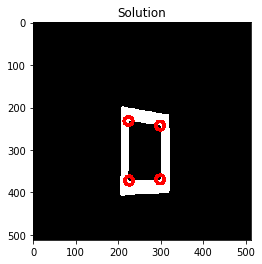

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4690.png
[]
file has only one shape


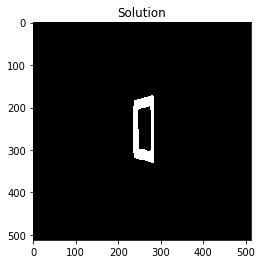

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3774.png
[]
file has only one shape


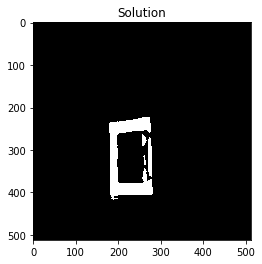

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7282 (1).png
[{'area': 43740, 'centroid': (270, 252), 'corners': array([[255.49509 , 255.50235 ],
       [340.3635  , 108.898834],
       [192.79868 , 142.30371 ],
       [351.0533  , 376.52167 ],
       [190.5197  , 377.39102 ]], dtype=float32)}, {'area': 94705, 'centroid': (274, 253), 'corners': array([[255.49239 , 255.50264 ],
       [379.6981  ,  38.453472],
       [158.22597 ,  95.4514  ],
       [168.5891  , 438.92783 ],
       [392.1812  , 442.1812  ]], dtype=float32)}]


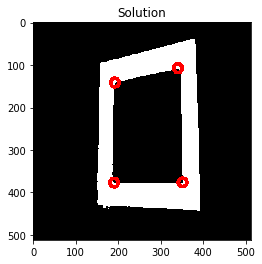

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7841 (1).png
[{'area': 9243, 'centroid': (255, 338), 'corners': array([[255.50008, 255.47734],
       [218.08357, 280.83652],
       [293.42407, 282.57593],
       [217.32841, 394.67004],
       [293.28003, 394.65125]], dtype=float32)}, {'area': 19780, 'centroid': (255, 340), 'corners': array([[255.50014, 255.47652],
       [201.08305, 254.83702],
       [310.67154, 258.32993],
       [198.29227, 425.55798],
       [310.41202, 426.56805]], dtype=float32)}]


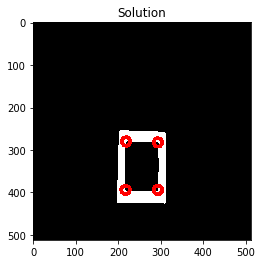

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7469 (1).png
[]
file has only one shape


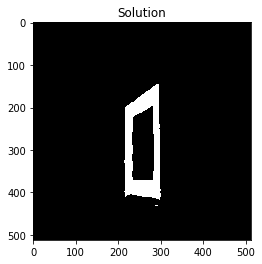

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5369.png
[]
file has only one shape


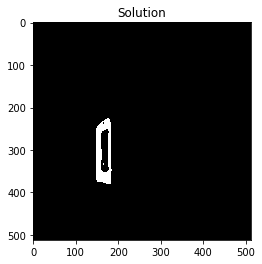

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0910.png
[{'area': 18873, 'centroid': (256, 347), 'corners': array([[255.50056, 255.47363],
       [220.49078, 229.30609],
       [298.3151 , 257.35855],
       [299.9329 , 435.18103],
       [218.55281, 462.73077]], dtype=float32)}]
file has only one shape


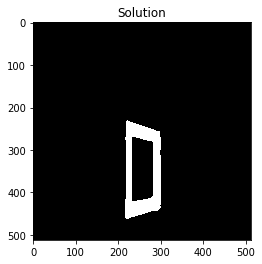

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6145.png
[]
file has only one shape


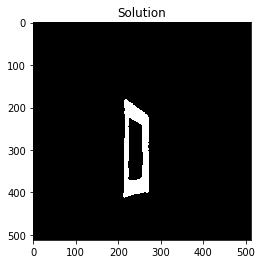

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8646.png
[{'area': 31165, 'centroid': (318, 244), 'corners': array([[255.48271 , 255.50407 ],
       [268.8609  , 106.078514],
       [376.91666 , 134.83716 ],
       [375.55237 , 356.317   ],
       [265.08337 , 376.16287 ]], dtype=float32)}, {'area': 74517, 'centroid': (316, 243), 'corners': array([[255.48439 , 255.50316 ],
       [235.79646 ,  27.286413],
       [407.87338 ,  93.68982 ],
       [408.75    , 397.5625  ],
       [233.15172 , 448.84534 ]], dtype=float32)}]


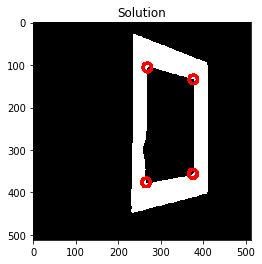

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3018.png
[]
file has only one shape


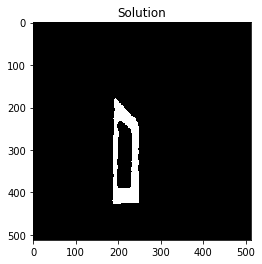

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8501.png
[{'area': 15385, 'centroid': (240, 276), 'corners': array([[255.50479, 255.49496],
       [201.09067, 185.80676],
       [281.6512 , 197.71994],
       [280.15085, 354.1534 ],
       [200.32846, 365.67007]], dtype=float32)}, {'area': 35501, 'centroid': (239, 277), 'corners': array([[255.50609, 255.49353],
       [179.79643, 140.2864 ],
       [305.91046, 169.81294],
       [306.32675, 386.46   ],
       [177.58798, 414.56802]], dtype=float32)}]


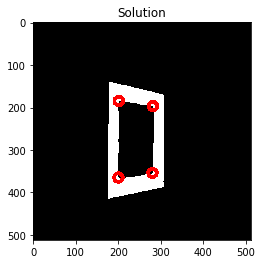

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8280.png
[]
file has only one shape


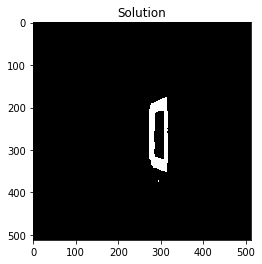

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7800 (1).png
[{'area': 20292, 'centroid': (292, 303), 'corners': array([[255.48962, 255.48674],
       [240.24297, 212.4293 ],
       [347.19174, 221.2954 ],
       [236.8369 , 389.91687],
       [349.42407, 389.42407]], dtype=float32)}, {'area': 44807, 'centroid': (292, 306), 'corners': array([[255.48949, 255.4864 ],
       [211.81886, 172.81885],
       [374.1812 , 183.81879],
       [208.32845, 432.67007],
       [381.1812 , 431.1812 ]], dtype=float32)}]


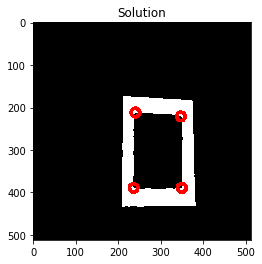

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4698.png
[]
file has only one shape


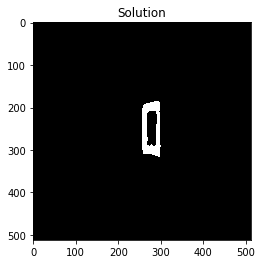

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8703.png
[{'area': 25625, 'centroid': (285, 276), 'corners': array([[255.49164, 255.49477],
       [227.81296, 172.08954],
       [347.16348, 183.08357],
       [345.46158, 371.4622 ],
       [225.85248, 376.8765 ]], dtype=float32)}, {'area': 55146, 'centroid': (285, 277), 'corners': array([[255.49176 , 255.49461 ],
       [198.32999 , 123.328384],
       [376.42416 , 144.57584 ],
       [375.67007 , 414.67154 ],
       [195.8384  , 426.65714 ]], dtype=float32)}]


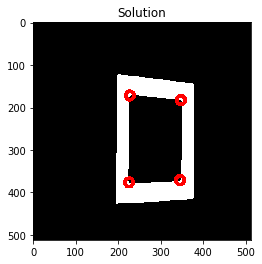

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2369.png
[{'area': 14586, 'centroid': (221, 288), 'corners': array([[255.50887, 255.49146],
       [257.50925, 189.30609],
       [183.55975, 217.69272],
       [258.54916, 372.77322],
       [186.25468, 375.00378]], dtype=float32)}, {'area': 34038, 'centroid': (222, 289), 'corners': array([[255.50874, 255.49133],
       [277.1781 , 139.34778],
       [162.81317, 187.08917],
       [158.55998, 410.45273],
       [282.1812 , 419.1812 ]], dtype=float32)}]


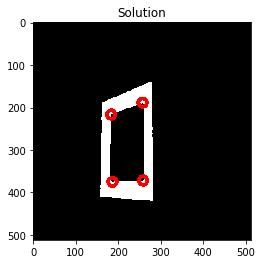

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7232.png
[{'area': 49452, 'centroid': (289, 272), 'corners': array([[255.49135, 255.4974 ],
       [217.10579, 103.80244],
       [363.91666, 149.83716],
       [371.5618 , 407.3396 ],
       [216.12422, 420.1479 ]], dtype=float32)}, {'area': 119805, 'centroid': (283, 274), 'corners': array([[255.49286 , 255.49634 ],
       [177.02925 ,  13.785826],
       [396.47842 , 104.47338 ],
       [415.45273 , 462.44006 ],
       [170.32848 , 503.6701  ]], dtype=float32)}]


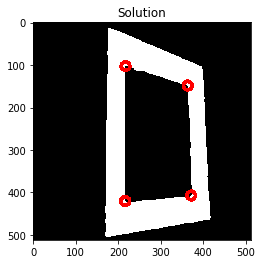

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8994.png
[]
file has only one shape


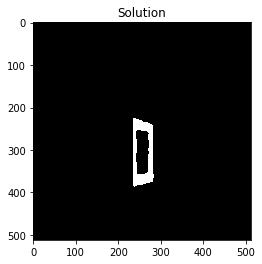

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7951.png
[{'area': 4704, 'centroid': (215, 302), 'corners': array([[255.51077, 255.487  ],
       [239.28572, 255.35413],
       [193.1066 , 259.77014],
       [237.24232, 350.21634],
       [196.60368, 349.61218]], dtype=float32)}, {'area': 10010, 'centroid': (215, 304), 'corners': array([[255.51096, 255.4867 ],
       [248.80421, 231.93434],
       [180.609  , 243.5197 ],
       [179.5759 , 368.42407],
       [250.18121, 375.1812 ]], dtype=float32)}]


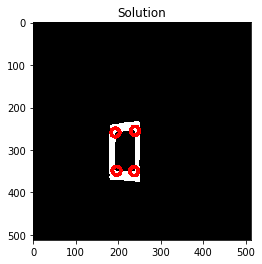

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8161 (1).png
[]
file has only one shape


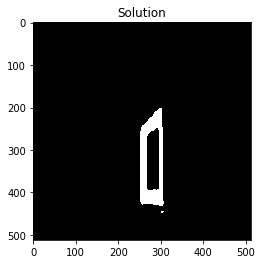

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3787.png
[]
file has only one shape


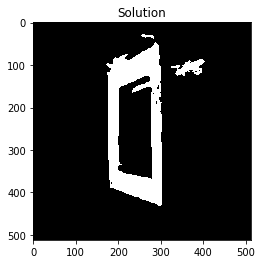

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9237.png
[{'area': 31866, 'centroid': (178, 260), 'corners': array([[251.99956 , 250.49997 ],
       [116.81893 , 144.06712 ],
       [250.45268 , 159.56004 ],
       [248.91643 , 363.16348 ],
       [111.768845, 370.7116  ]], dtype=float32)}, {'area': 67774, 'centroid': (177, 260), 'corners': array([[251.99956, 250.49997],
       [ 79.03113,  94.79107],
       [282.16296, 117.08305],
       [281.91672, 408.1633 ],
       [ 78.35407, 425.2857 ]], dtype=float32)}]


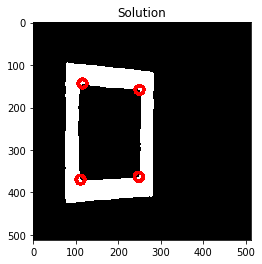

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5829.png
[{'area': 9225, 'centroid': (270, 257), 'corners': array([[255.4957 , 255.49956],
       [306.67004, 196.32843],
       [233.8605 , 203.6274 ],
       [234.56004, 316.4527 ],
       [307.3919 , 317.6428 ]], dtype=float32)}, {'area': 20020, 'centroid': (270, 258), 'corners': array([[255.4957 , 255.49931],
       [323.42935, 166.09953],
       [215.08951, 178.81297],
       [219.78226, 344.59317],
       [322.9042 , 348.80142]], dtype=float32)}]


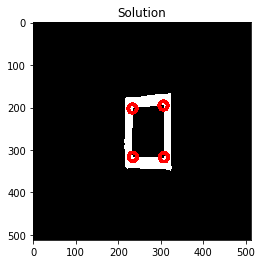

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8467.png
[{'area': 57672, 'centroid': (266, 267), 'corners': array([[255.49722, 255.49724],
       [188.5197 , 104.609  ],
       [359.73965, 135.92175],
       [354.4527 , 404.44003],
       [182.76903, 427.71167]], dtype=float32)}, {'area': 128304, 'centroid': (262, 267), 'corners': array([[255.50035 , 255.49655 ],
       [140.67574 ,  21.310364],
       [398.87573 ,  80.85213 ],
       [396.1631  , 459.91663 ],
       [136.08243 , 508.34036 ]], dtype=float32)}]


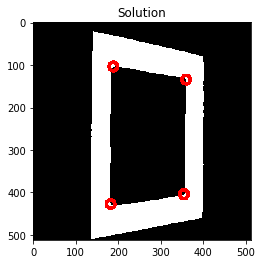

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7071.png
[{'area': 41891, 'centroid': (277, 245), 'corners': array([[255.49353, 255.50414],
       [204.78552, 109.31561],
       [355.16348, 130.08357],
       [199.59187, 366.53644],
       [361.53644, 363.4081 ]], dtype=float32)}, {'area': 94354, 'centroid': (276, 247), 'corners': array([[255.49388, 255.50354],
       [165.5759 ,  47.57591],
       [389.67136,  81.32973],
       [403.60242, 422.67078],
       [156.81879, 430.1812 ]], dtype=float32)}]


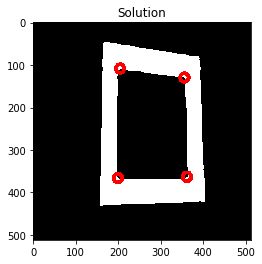

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9894.png
[{'area': 20592, 'centroid': (243, 264), 'corners': array([[255.5031 , 255.49759],
       [188.57593, 176.57593],
       [300.14752, 179.1235 ],
       [187.81313, 350.91083],
       [300.42407, 350.42407]], dtype=float32)}, {'area': 43350, 'centroid': (244, 265), 'corners': array([[255.50302, 255.49725],
       [162.33002, 138.32837],
       [327.67154, 140.32993],
       [160.03133, 392.20892],
       [328.24228, 392.21646]], dtype=float32)}]


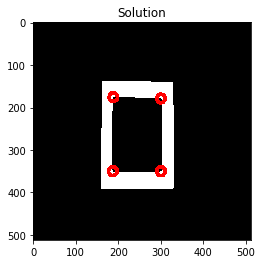

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7917 (1).png
[{'area': 24320, 'centroid': (237, 310), 'corners': array([[255.50494, 255.48509],
       [297.31598, 214.44719],
       [179.85248, 218.1235 ],
       [173.28839, 401.23117],
       [299.67145, 404.67017]], dtype=float32)}, {'area': 52360, 'centroid': (238, 313), 'corners': array([[255.50488, 255.48468],
       [326.18115, 169.81885],
       [151.57584, 178.57584],
       [144.55077, 447.87378],
       [330.1812 , 450.1812 ]], dtype=float32)}]


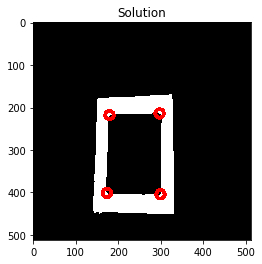

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3119.png
[{'area': 25172, 'centroid': (227, 233), 'corners': array([[255.5076 , 255.50682],
       [168.81877, 127.81877],
       [288.42407, 144.57593],
       [167.8369 , 329.91687],
       [291.7391 , 327.1603 ]], dtype=float32)}, {'area': 56848, 'centroid': (227, 234), 'corners': array([[255.50882, 255.50781],
       [138.81877,  74.81877],
       [316.16296, 106.08302],
       [324.87613, 369.14758],
       [136.81879, 379.1812 ]], dtype=float32)}]


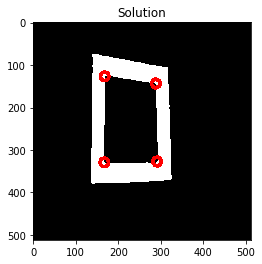

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7982 (1).png
[{'area': 23040, 'centroid': (286, 320), 'corners': array([[255.49117, 255.48235],
       [338.77414, 220.46733],
       [229.44713, 237.68419],
       [347.18124, 411.18124],
       [227.32994, 410.67157]], dtype=float32)}, {'area': 49590, 'centroid': (287, 322), 'corners': array([[255.49025, 255.48254],
       [365.60254, 172.3291 ],
       [203.09647, 203.82884],
       [199.32974, 451.67136],
       [373.20322, 458.7136 ]], dtype=float32)}]


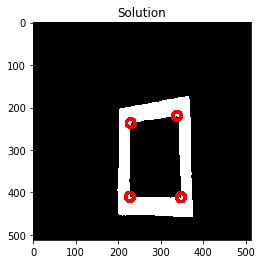

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1554.png
[{'area': 8541, 'centroid': (212, 310), 'corners': array([[255.51219, 255.48506],
       [181.16586, 250.56851],
       [246.31018, 259.12662],
       [179.51009, 366.21115],
       [241.77107, 365.805  ]], dtype=float32)}, {'area': 17510, 'centroid': (213, 311), 'corners': array([[255.51173, 255.4846 ],
       [165.32996, 224.32841],
       [266.33615, 239.41216],
       [163.81322, 394.9108 ],
       [262.17114, 392.9035 ]], dtype=float32)}]


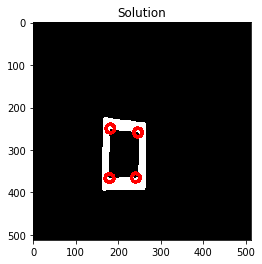

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8250.png
[]
file has only one shape


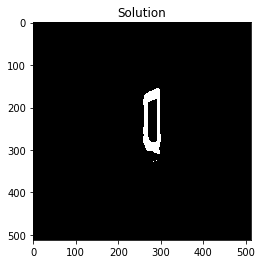

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6759 (1).png
[]
file has only one shape


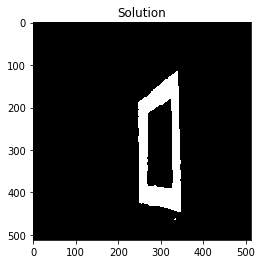

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7247 (1).png
[{'area': 7560, 'centroid': (245, 322), 'corners': array([[255.50269, 255.48138],
       [278.23834, 269.3054 ],
       [212.12422, 273.8521 ],
       [279.18124, 374.18124],
       [212.32999, 374.6716 ]], dtype=float32)}, {'area': 15655, 'centroid': (245, 324), 'corners': array([[255.50282, 255.48111],
       [296.2857 , 247.35408],
       [194.44196, 252.60617],
       [294.67154, 399.67007],
       [196.3787 , 400.30682]], dtype=float32)}]


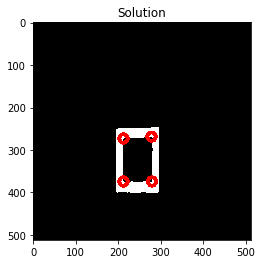

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7401.png
[{'area': 23835, 'centroid': (262, 258), 'corners': array([[255.49811, 255.49966],
       [297.3384 , 138.62267],
       [211.55975, 171.69272],
       [212.78166, 361.21832],
       [313.60977, 365.3344 ]], dtype=float32)}, {'area': 57600, 'centroid': (266, 256), 'corners': array([[255.49614 , 255.49788 ],
       [332.36356 ,  59.715824],
       [186.08061 , 136.84003 ],
       [185.32993 , 404.67154 ],
       [343.3792  , 423.6544  ]], dtype=float32)}]


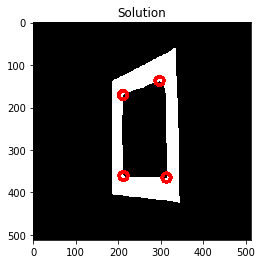

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7686 (1).png
[{'area': 6201, 'centroid': (276, 295), 'corners': array([[255.49454, 255.48921],
       [256.68823, 235.44478],
       [302.13153, 249.25429],
       [252.4345 , 349.30917],
       [297.44   , 349.4527 ]], dtype=float32)}, {'area': 12506, 'centroid': (276, 296), 'corners': array([[255.49463, 255.48949],
       [242.29344, 205.44148],
       [312.9103 , 227.813  ],
       [241.40265, 377.38696],
       [314.67007, 373.67154]], dtype=float32)}]


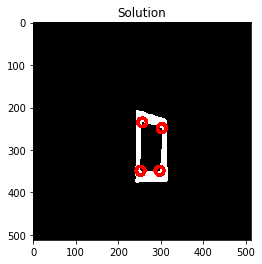

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_9567.png
[{'area': 48208, 'centroid': (255, 259), 'corners': array([[255.49965, 255.49965],
       [174.85211, 126.12423],
       [340.54916, 130.22679],
       [164.52155, 385.52658],
       [346.42407, 385.42407]], dtype=float32)}, {'area': 103140, 'centroid': (256, 262), 'corners': array([[255.49965 , 255.49896 ],
       [137.69006 ,  67.126205],
       [379.1812  ,  74.818794],
       [119.818794, 447.1812  ],
       [390.1562  , 447.8949  ]], dtype=float32)}]


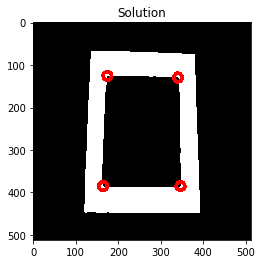

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4478.png
[{'area': 11919, 'centroid': (279, 238), 'corners': array([[255.4936 , 255.50433],
       [321.67017, 172.32855],
       [236.83984, 174.26065],
       [320.42407, 305.42407],
       [237.08922, 305.1868 ]], dtype=float32)}, {'area': 25938, 'centroid': (279, 239), 'corners': array([[255.49355, 255.50406],
       [342.67007, 141.32845],
       [214.32845, 146.32994],
       [343.67145, 337.67017],
       [217.16408, 338.71814]], dtype=float32)}]


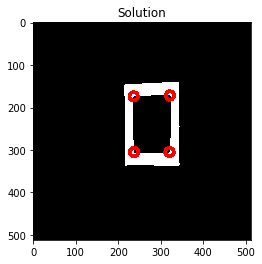

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7770.png
[{'area': 4305, 'centroid': (258, 300), 'corners': array([[254.34682, 252.41904],
       [275.23203, 247.17381],
       [239.08954, 256.81296],
       [276.91663, 348.16287],
       [242.77187, 350.41394]], dtype=float32)}, {'area': 9513, 'centroid': (257, 301), 'corners': array([[254.34682, 252.41904],
       [288.55807, 224.29245],
       [226.18892, 239.27167],
       [227.12389, 369.14758],
       [287.24228, 375.21643]], dtype=float32)}]


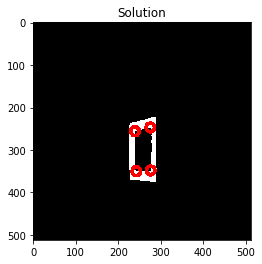

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7207.png
[]
file has only one shape


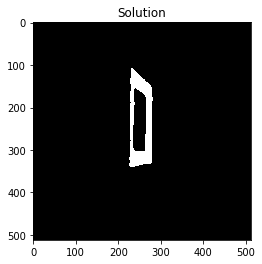

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4180.png
[{'area': 27342, 'centroid': (262, 291), 'corners': array([[255.49884, 255.49022],
       [216.22752, 152.46953],
       [311.0343 , 184.43788],
       [314.1296 , 395.26495],
       [217.8864 , 431.6825 ]], dtype=float32)}]
file has only one shape


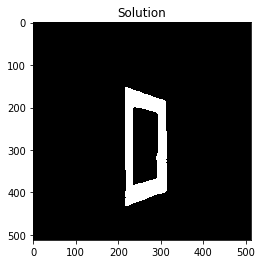

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6233.png
[{'area': 5782, 'centroid': (248, 307), 'corners': array([[256.50024, 252.99954],
       [229.34293, 246.5029 ],
       [271.62964, 257.37033],
       [225.81877, 363.18124],
       [270.7116 , 361.2311 ]], dtype=float32)}, {'area': 13024, 'centroid': (249, 308), 'corners': array([[256.50024, 252.99954],
       [213.81876, 217.81876],
       [285.2311 , 237.28838],
       [286.65112, 387.28024],
       [213.18407, 394.33246]], dtype=float32)}]


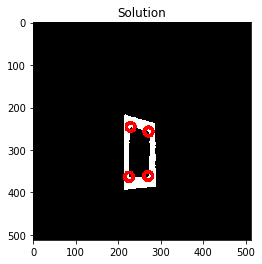

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5099.png
[{'area': 17160, 'centroid': (242, 297), 'corners': array([[255.50365, 255.48819],
       [292.74243, 216.69463],
       [192.83984, 220.26065],
       [191.32997, 377.67157],
       [293.42407, 378.42407]], dtype=float32)}, {'area': 37026, 'centroid': (243, 299), 'corners': array([[255.50351, 255.48784],
       [318.1812 , 176.81879],
       [166.71976, 188.34889],
       [166.81297, 414.9105 ],
       [319.16296, 418.91696]], dtype=float32)}]


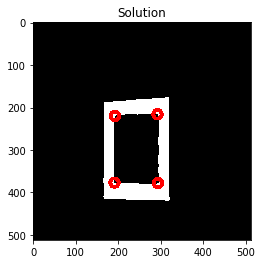

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4694.png
[]
file has only one shape


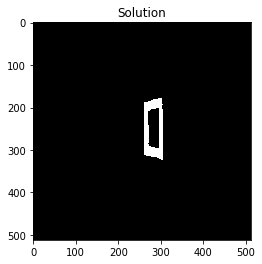

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5914.png
[{'area': 9815, 'centroid': (269, 258), 'corners': array([[255.4956 , 255.4999 ],
       [297.95737, 179.59258],
       [238.60016, 195.73799],
       [237.12674, 326.31024],
       [298.83478, 331.4312 ]], dtype=float32)}, {'area': 22500, 'centroid': (268, 259), 'corners': array([[255.49576, 255.49922],
       [314.70657, 142.44148],
       [218.09651, 171.82877],
       [219.08315, 366.48254],
       [315.70685, 369.13126]], dtype=float32)}]


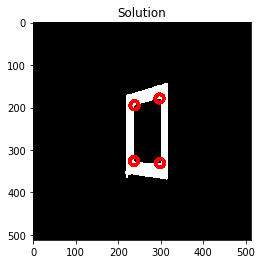

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8176.png
[{'area': 3354, 'centroid': (263, 234), 'corners': array([[255.49721, 255.50629],
       [282.1812 , 191.81879],
       [244.8872 , 198.74962],
       [281.90906, 274.19305],
       [246.28833, 274.23096]], dtype=float32)}, {'area': 7257, 'centroid': (263, 234), 'corners': array([[255.49768, 255.50609],
       [292.1812 , 171.8188 ],
       [234.08333, 179.83719],
       [236.3378 , 291.24777],
       [290.41205, 297.56805]], dtype=float32)}]


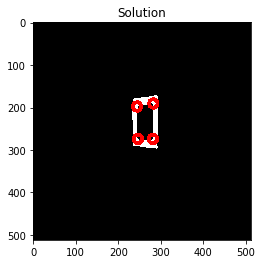

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7481 (1).png
[]
file has only one shape


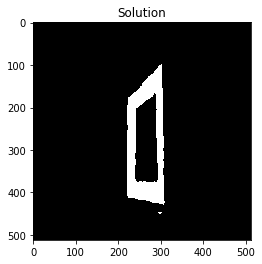

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8753 (1).png
[]
file has only one shape


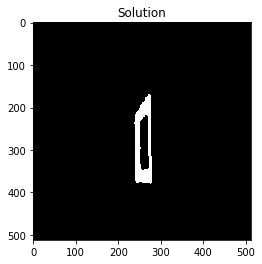

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6981.png
[]
file has only one shape


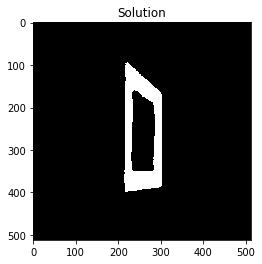

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8810.png
[{'area': 13359, 'centroid': (351, 284), 'corners': array([[255.4733 , 255.4919 ],
       [318.08316, 193.83678],
       [386.55283, 206.68404],
       [381.6111 , 366.6111 ],
       [317.49728, 375.31622]], dtype=float32)}, {'area': 32480, 'centroid': (351, 285), 'corners': array([[255.47345, 255.49168],
       [297.1828 , 143.54771],
       [408.91037, 175.81291],
       [412.0656 , 396.80466],
       [296.73434, 423.90503]], dtype=float32)}]


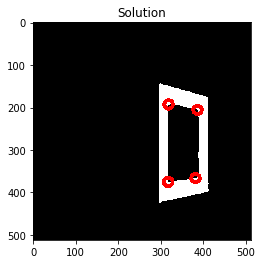

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5887.png
[{'area': 34580, 'centroid': (195, 228), 'corners': array([[255.5166 , 255.50801],
       [264.2184 , 103.78159],
       [130.56691, 117.8419 ],
       [123.78166, 341.21832],
       [261.5238 , 350.9222 ]], dtype=float32)}, {'area': 74825, 'centroid': (197, 229), 'corners': array([[255.51549 , 255.50903 ],
       [298.18124 ,  42.818764],
       [ 94.08332 ,  75.837204],
       [ 92.65439 , 389.1462  ],
       [296.24228 , 409.21643 ]], dtype=float32)}]


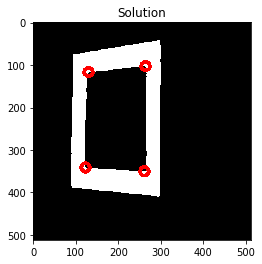

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6496.png
[{'area': 15504, 'centroid': (216, 283), 'corners': array([[255.51071, 255.49237],
       [168.26065, 209.83984],
       [266.18124, 207.81877],
       [167.08954, 358.18704],
       [264.91928, 357.16   ]], dtype=float32)}, {'area': 33075, 'centroid': (216, 285), 'corners': array([[255.51085, 255.49168],
       [287.66998, 172.32837],
       [144.08951, 179.81297],
       [289.67154, 395.67007],
       [142.85213, 395.87573]], dtype=float32)}]


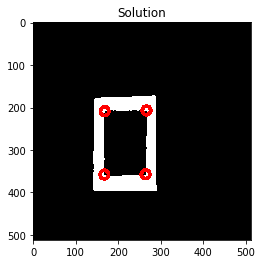

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_2699.png
[{'area': 6936, 'centroid': (221, 326), 'corners': array([[255.50934, 255.4805 ],
       [189.81296, 276.08954],
       [254.18123, 277.81876],
       [188.54732, 376.43994],
       [253.67003, 374.67157]], dtype=float32)}, {'area': 14850, 'centroid': (221, 328), 'corners': array([[255.50928, 255.48022],
       [173.32994, 253.32845],
       [269.20322, 252.2864 ],
       [171.81879, 402.1812 ],
       [271.1628 , 401.9167 ]], dtype=float32)}]


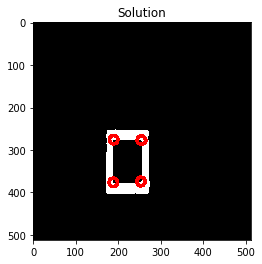

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3821.png
[{'area': 32488, 'centroid': (220, 277), 'corners': array([[255.51073, 255.49579],
       [159.76167, 146.3054 ],
       [286.3624 , 178.46988],
       [287.91083, 379.1869 ],
       [158.81313, 394.91083]], dtype=float32)}, {'area': 72299, 'centroid': (217, 275), 'corners': array([[255.51254 , 255.49416 ],
       [131.18143 ,  95.355385],
       [312.82336 , 129.30014 ],
       [319.42416 , 423.42416 ],
       [123.83843 , 459.65714 ]], dtype=float32)}]


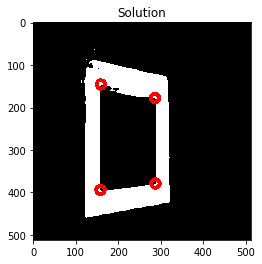

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6691.png
[]
file has only one shape


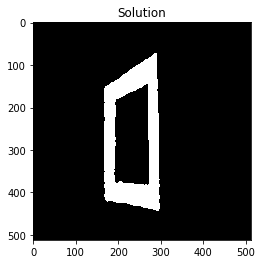

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6744 (1).png
[]
file has only one shape


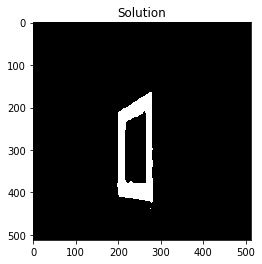

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7186 (1).png
[{'area': 7314, 'centroid': (258, 312), 'corners': array([[255.49918, 255.4844 ],
       [293.29507, 261.19647],
       [224.81877, 260.81876],
       [291.21634, 363.24234],
       [226.74896, 365.1127 ]], dtype=float32)}, {'area': 15965, 'centroid': (258, 314), 'corners': array([[255.4991 , 255.48386],
       [308.59842, 235.71414],
       [208.32845, 238.32994],
       [308.64594, 391.2857 ],
       [207.29239, 391.55804]], dtype=float32)}]


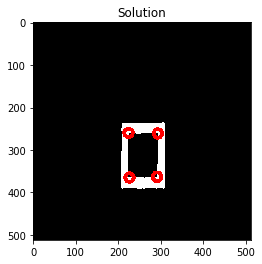

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3347.png
[]
file has only one shape


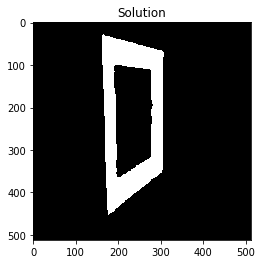

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8652 (1).png
[]
file has only one shape


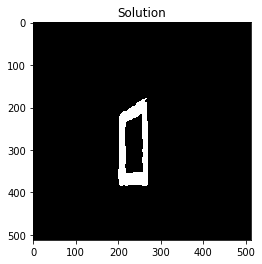

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3590.png
[{'area': 4160, 'centroid': (243, 274), 'corners': array([[255.50316, 255.49464],
       [219.42537, 237.31033],
       [268.91663, 237.83713],
       [219.8369 , 312.91687],
       [265.54535, 313.3481 ]], dtype=float32)}, {'area': 8625, 'centroid': (244, 275), 'corners': array([[255.50296, 255.49443],
       [207.32994, 218.32845],
       [281.67154, 219.32993],
       [208.76218, 333.69455],
       [281.67007, 331.67154]], dtype=float32)}]


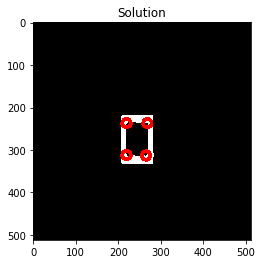

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_8951.png
[{'area': 25004, 'centroid': (265, 280), 'corners': array([[255.4977 , 255.4899 ],
       [224.04001, 143.64316],
       [316.00052, 210.49997],
       [317.08017, 385.87656],
       [234.097  , 406.57904]], dtype=float32)}]
file has only one shape


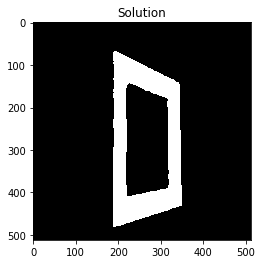

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7653.png
[{'area': 7686, 'centroid': (264, 285), 'corners': array([[255.4969 , 255.49191],
       [294.1812 , 223.81877],
       [235.83678, 231.08316],
       [294.16293, 345.91696],
       [235.8439 , 342.89484]], dtype=float32)}, {'area': 17108, 'centroid': (265, 286), 'corners': array([[255.49693, 255.4919 ],
       [308.22986, 192.1735 ],
       [217.45364, 212.63301],
       [217.81879, 368.1812 ],
       [311.55804, 374.7076 ]], dtype=float32)}]


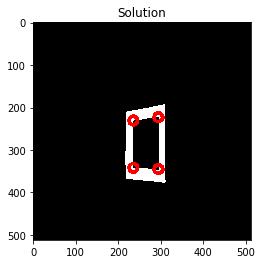

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7132.png
[{'area': 31812, 'centroid': (264, 255), 'corners': array([[255.4969  , 255.50182 ],
       [316.35272 , 127.202614],
       [201.09654 , 163.82872 ],
       [330.6111  , 354.6111  ],
       [199.32997 , 365.67157 ]], dtype=float32)}, {'area': 71400, 'centroid': (269, 254), 'corners': array([[255.4956  , 255.50188 ],
       [351.2314  ,  57.173588],
       [170.74155 , 126.32732 ],
       [168.81886 , 414.18115 ],
       [369.21646 , 415.24228 ]], dtype=float32)}]


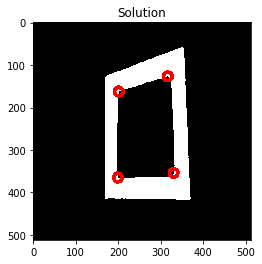

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6441.png
[{'area': 18648, 'centroid': (247, 287), 'corners': array([[255.50227, 255.49113],
       [195.84   , 205.08073],
       [301.25858, 206.3273 ],
       [193.3284 , 370.67   ],
       [299.18704, 369.91046]], dtype=float32)}, {'area': 38801, 'centroid': (247, 290), 'corners': array([[255.5022 , 255.49031],
       [168.8188 , 170.81879],
       [325.67154, 170.32993],
       [328.67017, 408.67145],
       [167.76218, 412.69455]], dtype=float32)}]


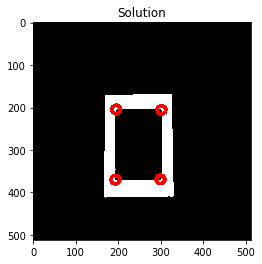

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_3320.png
[]
file has only one shape


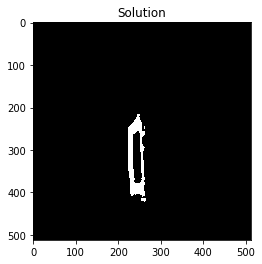

/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4367.png
[{'area': 10414, 'centroid': (300, 239), 'corners': array([[255.48784, 255.50433],
       [261.54727, 177.55995],
       [338.14594, 177.48338],
       [260.08337, 303.16287],
       [339.21835, 300.21832]], dtype=float32)}, {'area': 22015, 'centroid': (300, 239), 'corners': array([[255.48756, 255.50433],
       [241.35722, 147.60808],
       [358.83505, 147.56888],
       [358.79315, 329.6785 ],
       [242.32855, 333.67017]], dtype=float32)}]


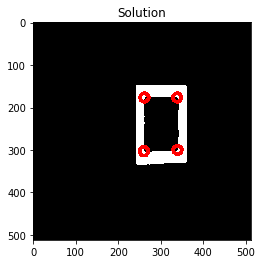

{"/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_6760.png": [[209, 110, 307, 151, 197, 345, 309, 350]], "/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_1883.png": [[287, 214, 240, 225, 289, 337, 241, 338]], "/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0578.png": [[361, 90, 163, 100, 159, 397, 355, 415]], "/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_5530.png": [[210, 194, 285, 204, 285, 333, 208, 338]], "/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_4599.png": [[270, 135, 169, 156, 172, 345, 274, 359]], "/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_7351.png": [[310,

In [2]:
from matplotlib import pyplot as plt
import json
from Corners import Corners
import glob


path = '/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/*.png'
results = {}
for file in glob.glob(path):
    print(file)
    detector = Corners()
    img, poly = detector.process_image_path(file)
#     if len(poly) == 0:
#         continue

    plt.imshow(img)
    plt.title('Solution')
    plt.show()
    
    if len(poly) == 0:
        continue
    results[file] = [poly.astype(int).flatten().tolist()]

    json_object = json.dumps(results)

if 'json_object' in locals():
    print(json_object)
else:
    print('damn')



# Result json for submission
# "IMG_8378.JPG": [[616, 278, 948, 290, 945, 616, 609, 627]]



<class 'numpy.ndarray'>
[{'area': 110, 'centroid': (170, 66), 'corners': array([[255.52429, 255.55417],
       [170.61333,  66.22667]], dtype=float32)}, {'area': 120, 'centroid': (170, 19), 'corners': array([[255.52383 , 255.56651 ],
       [172.4762  ,  16.142857],
       [165.113   ,  18.615889],
       [173.89749 ,  24.459593]], dtype=float32)}]
number of points are :  2
I didn't all 5 points of the shape


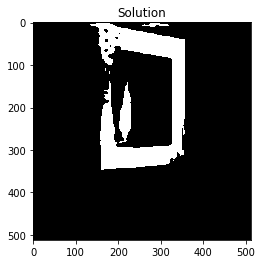

damn


NameError: name 'json_object' is not defined

In [2]:
from matplotlib import pyplot as plt
import json
from Corners import Corners



path = '/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/results/512pos8/masks/IMG_0195.png'
results = {}

detector = Corners()
img, poly = detector.process_image_path(path)

plt.imshow(img)
plt.title('Solution')
plt.show()

if len(poly) == 0:
    print('damn')
else:
    results[path] = [poly.astype(int).flatten().tolist()]

    json_object = json.dumps(results)

print(json_object)



# Result json for submission
# "IMG_8378.JPG": [[616, 278, 948, 290, 945, 616, 609, 627]]



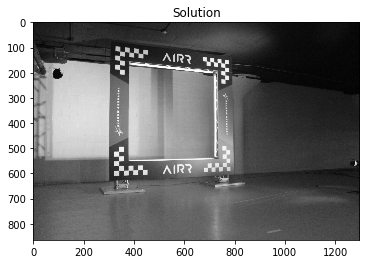

In [10]:
from matplotlib import pyplot as plt
import json
from Corners import Corners
from PIL import Image
import numpy as np



path = '/home/gani/shrek/alphapilot/wing-cv-pytorch-deeplab-xception/pytorch-deeplab-xception/data/dataset/train/images/IMG_0007-rgb.JPG'
img = Image.open(path).convert('L')
img = np.array(img)
results = {}

detector = Corners()
img, poly = detector.process_image_path(img)

plt.imshow(img, cmap='gray')
plt.title('Solution')
plt.show()

if len(poly) == 0:
    print('damn')
else:
    results[path] = [poly.astype(int).flatten().tolist()]

    json_object = json.dumps(results)

print(json_object)